In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

3


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

In [9]:
#show_data(data,columns, 1,480, None)

In [10]:
#show_data2(data,columns)

# cv

In [11]:
n_reg_lookback=28

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [13]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [15]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [20]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [21]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [24]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testlstm", n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,model_type='conv',
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [25]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [26]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('3003_conv_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)


(26,) 0.00244472 2.97218


(829, 517, 26)


train/valid # (297687, 2) (74534, 2)


train/valid # (197177, 2) (48115, 2)
train/valid # (197177, 2) (48115, 2)


rand split across time
train has 197177 records out of 372221 records
valid has 48115 records out of 372221 records
train has 5803 records out of 5803 records
no valid set
1540
0
26 18 (1, 18)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)


{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
374273


Epoch 1/100


   1/1540 [..............................] - ETA: 42:34 - loss: 4.3873 - total_loss: 4.3873 - reg_loss: 4.3873

   5/1540 [..............................] - ETA: 8:48 - loss: 2.0964 - total_loss: 2.0964 - reg_loss: 2.0964 

   9/1540 [..............................] - ETA: 5:03 - loss: 1.6375 - total_loss: 1.6375 - reg_loss: 1.6375

  13/1540 [..............................] - ETA: 3:37 - loss: 1.3602 - total_loss: 1.3602 - reg_loss: 1.3602

  16/1540 [..............................] - ETA: 3:01 - loss: 1.2152 - total_loss: 1.2152 - reg_loss: 1.2152

  20/1540 [..............................] - ETA: 2:29 - loss: 1.0788 - total_loss: 1.0788 - reg_loss: 1.0788

  24/1540 [..............................] - ETA: 2:08 - loss: 0.9814 - total_loss: 0.9814 - reg_loss: 0.9814

  27/1540 [..............................] - ETA: 1:56 - loss: 0.9239 - total_loss: 0.9239 - reg_loss: 0.9239

  31/1540 [..............................] - ETA: 1:44 - loss: 0.8641 - total_loss: 0.8641 - reg_loss: 0.8641

  34/1540 [..............................] - ETA: 1:37 - loss: 0.8203 - total_loss: 0.8203 - reg_loss: 0.8203

  38/1540 [..............................] - ETA: 1:29 - loss: 0.7724 - total_loss: 0.7724 - reg_loss: 0.7724

  41/1540 [..............................] - ETA: 1:25 - loss: 0.7469 - total_loss: 0.7469 - reg_loss: 0.7469

  44/1540 [..............................] - ETA: 1:21 - loss: 0.7230 - total_loss: 0.7230 - reg_loss: 0.7230

  47/1540 [..............................] - ETA: 1:17 - loss: 0.6956 - total_loss: 0.6956 - reg_loss: 0.6956

  51/1540 [..............................] - ETA: 1:13 - loss: 0.6740 - total_loss: 0.6740 - reg_loss: 0.6740

  55/1540 [>.............................] - ETA: 1:09 - loss: 0.6487 - total_loss: 0.6487 - reg_loss: 0.6487

  58/1540 [>.............................] - ETA: 1:07 - loss: 0.6314 - total_loss: 0.6314 - reg_loss: 0.6314

  62/1540 [>.............................] - ETA: 1:04 - loss: 0.6127 - total_loss: 0.6127 - reg_loss: 0.6127

  65/1540 [>.............................] - ETA: 1:02 - loss: 0.5997 - total_loss: 0.5997 - reg_loss: 0.5997

  69/1540 [>.............................] - ETA: 59s - loss: 0.5846 - total_loss: 0.5846 - reg_loss: 0.5846 

  72/1540 [>.............................] - ETA: 58s - loss: 0.5746 - total_loss: 0.5746 - reg_loss: 0.5746

  76/1540 [>.............................] - ETA: 56s - loss: 0.5635 - total_loss: 0.5635 - reg_loss: 0.5635

  79/1540 [>.............................] - ETA: 55s - loss: 0.5555 - total_loss: 0.5555 - reg_loss: 0.5555

  83/1540 [>.............................] - ETA: 53s - loss: 0.5446 - total_loss: 0.5446 - reg_loss: 0.5446

  87/1540 [>.............................] - ETA: 51s - loss: 0.5353 - total_loss: 0.5353 - reg_loss: 0.5353

  91/1540 [>.............................] - ETA: 50s - loss: 0.5264 - total_loss: 0.5264 - reg_loss: 0.5264

  95/1540 [>.............................] - ETA: 48s - loss: 0.5192 - total_loss: 0.5192 - reg_loss: 0.5192

  99/1540 [>.............................] - ETA: 47s - loss: 0.5110 - total_loss: 0.5110 - reg_loss: 0.5110

 103/1540 [=>............................] - ETA: 46s - loss: 0.5044 - total_loss: 0.5044 - reg_loss: 0.5044

 107/1540 [=>............................] - ETA: 45s - loss: 0.4997 - total_loss: 0.4997 - reg_loss: 0.4997

 112/1540 [=>............................] - ETA: 43s - loss: 0.4904 - total_loss: 0.4904 - reg_loss: 0.4904

 117/1540 [=>............................] - ETA: 42s - loss: 0.4823 - total_loss: 0.4823 - reg_loss: 0.4823

 122/1540 [=>............................] - ETA: 41s - loss: 0.4779 - total_loss: 0.4779 - reg_loss: 0.4779

 125/1540 [=>............................] - ETA: 40s - loss: 0.4749 - total_loss: 0.4749 - reg_loss: 0.4749

 129/1540 [=>............................] - ETA: 39s - loss: 0.4694 - total_loss: 0.4694 - reg_loss: 0.4694

 133/1540 [=>............................] - ETA: 39s - loss: 0.4658 - total_loss: 0.4658 - reg_loss: 0.4658

 137/1540 [=>............................] - ETA: 38s - loss: 0.4609 - total_loss: 0.4609 - reg_loss: 0.4609

 142/1540 [=>............................] - ETA: 37s - loss: 0.4549 - total_loss: 0.4549 - reg_loss: 0.4549

 146/1540 [=>............................] - ETA: 37s - loss: 0.4508 - total_loss: 0.4508 - reg_loss: 0.4508

 151/1540 [=>............................] - ETA: 36s - loss: 0.4457 - total_loss: 0.4457 - reg_loss: 0.4457

 156/1540 [==>...........................] - ETA: 35s - loss: 0.4415 - total_loss: 0.4415 - reg_loss: 0.4415

 159/1540 [==>...........................] - ETA: 35s - loss: 0.4393 - total_loss: 0.4393 - reg_loss: 0.4393

 164/1540 [==>...........................] - ETA: 34s - loss: 0.4352 - total_loss: 0.4352 - reg_loss: 0.4352

 168/1540 [==>...........................] - ETA: 33s - loss: 0.4317 - total_loss: 0.4317 - reg_loss: 0.4317

 172/1540 [==>...........................] - ETA: 33s - loss: 0.4280 - total_loss: 0.4280 - reg_loss: 0.4280

 176/1540 [==>...........................] - ETA: 33s - loss: 0.4260 - total_loss: 0.4260 - reg_loss: 0.4260

 180/1540 [==>...........................] - ETA: 32s - loss: 0.4233 - total_loss: 0.4233 - reg_loss: 0.4233

 185/1540 [==>...........................] - ETA: 32s - loss: 0.4199 - total_loss: 0.4199 - reg_loss: 0.4199

 190/1540 [==>...........................] - ETA: 31s - loss: 0.4172 - total_loss: 0.4172 - reg_loss: 0.4172

 195/1540 [==>...........................] - ETA: 30s - loss: 0.4145 - total_loss: 0.4145 - reg_loss: 0.4145

 200/1540 [==>...........................] - ETA: 30s - loss: 0.4123 - total_loss: 0.4123 - reg_loss: 0.4123

 205/1540 [==>...........................] - ETA: 29s - loss: 0.4107 - total_loss: 0.4107 - reg_loss: 0.4107

 210/1540 [===>..........................] - ETA: 29s - loss: 0.4075 - total_loss: 0.4075 - reg_loss: 0.4075

 215/1540 [===>..........................] - ETA: 29s - loss: 0.4049 - total_loss: 0.4049 - reg_loss: 0.4049

 220/1540 [===>..........................] - ETA: 28s - loss: 0.4030 - total_loss: 0.4030 - reg_loss: 0.4030

 225/1540 [===>..........................] - ETA: 28s - loss: 0.4010 - total_loss: 0.4010 - reg_loss: 0.4010

 230/1540 [===>..........................] - ETA: 27s - loss: 0.3997 - total_loss: 0.3997 - reg_loss: 0.3997

 235/1540 [===>..........................] - ETA: 27s - loss: 0.3985 - total_loss: 0.3985 - reg_loss: 0.3985

 240/1540 [===>..........................] - ETA: 26s - loss: 0.3971 - total_loss: 0.3971 - reg_loss: 0.3971

 245/1540 [===>..........................] - ETA: 26s - loss: 0.3950 - total_loss: 0.3950 - reg_loss: 0.3950

 250/1540 [===>..........................] - ETA: 26s - loss: 0.3933 - total_loss: 0.3933 - reg_loss: 0.3933

 255/1540 [===>..........................] - ETA: 25s - loss: 0.3916 - total_loss: 0.3916 - reg_loss: 0.3916

 260/1540 [====>.........................] - ETA: 25s - loss: 0.3917 - total_loss: 0.3917 - reg_loss: 0.3917

 265/1540 [====>.........................] - ETA: 25s - loss: 0.3909 - total_loss: 0.3909 - reg_loss: 0.3909

 270/1540 [====>.........................] - ETA: 24s - loss: 0.3899 - total_loss: 0.3899 - reg_loss: 0.3899

 275/1540 [====>.........................] - ETA: 24s - loss: 0.3883 - total_loss: 0.3883 - reg_loss: 0.3883

 280/1540 [====>.........................] - ETA: 24s - loss: 0.3874 - total_loss: 0.3874 - reg_loss: 0.3874

 285/1540 [====>.........................] - ETA: 24s - loss: 0.3866 - total_loss: 0.3866 - reg_loss: 0.3866

 290/1540 [====>.........................] - ETA: 23s - loss: 0.3854 - total_loss: 0.3854 - reg_loss: 0.3854

 295/1540 [====>.........................] - ETA: 23s - loss: 0.3841 - total_loss: 0.3841 - reg_loss: 0.3841

 300/1540 [====>.........................] - ETA: 23s - loss: 0.3837 - total_loss: 0.3837 - reg_loss: 0.3837

 305/1540 [====>.........................] - ETA: 23s - loss: 0.3838 - total_loss: 0.3838 - reg_loss: 0.3838

 310/1540 [=====>........................] - ETA: 22s - loss: 0.3828 - total_loss: 0.3828 - reg_loss: 0.3828

 315/1540 [=====>........................] - ETA: 22s - loss: 0.3820 - total_loss: 0.3820 - reg_loss: 0.3820

 320/1540 [=====>........................] - ETA: 22s - loss: 0.3809 - total_loss: 0.3809 - reg_loss: 0.3809

 325/1540 [=====>........................] - ETA: 22s - loss: 0.3800 - total_loss: 0.3800 - reg_loss: 0.3800

 330/1540 [=====>........................] - ETA: 21s - loss: 0.3786 - total_loss: 0.3786 - reg_loss: 0.3786

 335/1540 [=====>........................] - ETA: 21s - loss: 0.3778 - total_loss: 0.3778 - reg_loss: 0.3778

 340/1540 [=====>........................] - ETA: 21s - loss: 0.3771 - total_loss: 0.3771 - reg_loss: 0.3771

 345/1540 [=====>........................] - ETA: 21s - loss: 0.3760 - total_loss: 0.3760 - reg_loss: 0.3760

 350/1540 [=====>........................] - ETA: 20s - loss: 0.3749 - total_loss: 0.3749 - reg_loss: 0.3749

 355/1540 [=====>........................] - ETA: 20s - loss: 0.3736 - total_loss: 0.3736 - reg_loss: 0.3736

 360/1540 [======>.......................] - ETA: 20s - loss: 0.3725 - total_loss: 0.3725 - reg_loss: 0.3725

 365/1540 [======>.......................] - ETA: 20s - loss: 0.3717 - total_loss: 0.3717 - reg_loss: 0.3717

 370/1540 [======>.......................] - ETA: 20s - loss: 0.3702 - total_loss: 0.3702 - reg_loss: 0.3702

 375/1540 [======>.......................] - ETA: 19s - loss: 0.3692 - total_loss: 0.3692 - reg_loss: 0.3692

 380/1540 [======>.......................] - ETA: 19s - loss: 0.3683 - total_loss: 0.3683 - reg_loss: 0.3683

 385/1540 [======>.......................] - ETA: 19s - loss: 0.3666 - total_loss: 0.3666 - reg_loss: 0.3666

 390/1540 [======>.......................] - ETA: 19s - loss: 0.3652 - total_loss: 0.3652 - reg_loss: 0.3652

 395/1540 [======>.......................] - ETA: 19s - loss: 0.3642 - total_loss: 0.3642 - reg_loss: 0.3642

 400/1540 [======>.......................] - ETA: 19s - loss: 0.3634 - total_loss: 0.3634 - reg_loss: 0.3634

 405/1540 [======>.......................] - ETA: 18s - loss: 0.3627 - total_loss: 0.3627 - reg_loss: 0.3627

 410/1540 [======>.......................] - ETA: 18s - loss: 0.3617 - total_loss: 0.3617 - reg_loss: 0.3617

 415/1540 [=======>......................] - ETA: 18s - loss: 0.3613 - total_loss: 0.3613 - reg_loss: 0.3613

 420/1540 [=======>......................] - ETA: 18s - loss: 0.3606 - total_loss: 0.3606 - reg_loss: 0.3606

 425/1540 [=======>......................] - ETA: 18s - loss: 0.3598 - total_loss: 0.3598 - reg_loss: 0.3598

 430/1540 [=======>......................] - ETA: 18s - loss: 0.3593 - total_loss: 0.3593 - reg_loss: 0.3593

 435/1540 [=======>......................] - ETA: 17s - loss: 0.3585 - total_loss: 0.3585 - reg_loss: 0.3585

 440/1540 [=======>......................] - ETA: 17s - loss: 0.3583 - total_loss: 0.3583 - reg_loss: 0.3583

 445/1540 [=======>......................] - ETA: 17s - loss: 0.3577 - total_loss: 0.3577 - reg_loss: 0.3577

 450/1540 [=======>......................] - ETA: 17s - loss: 0.3567 - total_loss: 0.3567 - reg_loss: 0.3567

 455/1540 [=======>......................] - ETA: 17s - loss: 0.3559 - total_loss: 0.3559 - reg_loss: 0.3559

 460/1540 [=======>......................] - ETA: 17s - loss: 0.3553 - total_loss: 0.3553 - reg_loss: 0.3553

 465/1540 [========>.....................] - ETA: 17s - loss: 0.3548 - total_loss: 0.3548 - reg_loss: 0.3548

 470/1540 [========>.....................] - ETA: 16s - loss: 0.3540 - total_loss: 0.3540 - reg_loss: 0.3540

 475/1540 [========>.....................] - ETA: 16s - loss: 0.3531 - total_loss: 0.3531 - reg_loss: 0.3531

 480/1540 [========>.....................] - ETA: 16s - loss: 0.3527 - total_loss: 0.3527 - reg_loss: 0.3527

 485/1540 [========>.....................] - ETA: 16s - loss: 0.3517 - total_loss: 0.3517 - reg_loss: 0.3517

 490/1540 [========>.....................] - ETA: 16s - loss: 0.3511 - total_loss: 0.3511 - reg_loss: 0.3511

 495/1540 [========>.....................] - ETA: 16s - loss: 0.3505 - total_loss: 0.3505 - reg_loss: 0.3505

 500/1540 [========>.....................] - ETA: 16s - loss: 0.3501 - total_loss: 0.3501 - reg_loss: 0.3501

 505/1540 [========>.....................] - ETA: 16s - loss: 0.3497 - total_loss: 0.3497 - reg_loss: 0.3497

 510/1540 [========>.....................] - ETA: 15s - loss: 0.3490 - total_loss: 0.3490 - reg_loss: 0.3490

 515/1540 [=========>....................] - ETA: 15s - loss: 0.3488 - total_loss: 0.3488 - reg_loss: 0.3488

 520/1540 [=========>....................] - ETA: 15s - loss: 0.3480 - total_loss: 0.3480 - reg_loss: 0.3480

 525/1540 [=========>....................] - ETA: 15s - loss: 0.3474 - total_loss: 0.3474 - reg_loss: 0.3474

 530/1540 [=========>....................] - ETA: 15s - loss: 0.3466 - total_loss: 0.3466 - reg_loss: 0.3466

 535/1540 [=========>....................] - ETA: 15s - loss: 0.3459 - total_loss: 0.3459 - reg_loss: 0.3459

 540/1540 [=========>....................] - ETA: 15s - loss: 0.3457 - total_loss: 0.3457 - reg_loss: 0.3457

 545/1540 [=========>....................] - ETA: 15s - loss: 0.3456 - total_loss: 0.3456 - reg_loss: 0.3456

 550/1540 [=========>....................] - ETA: 14s - loss: 0.3452 - total_loss: 0.3452 - reg_loss: 0.3452

 555/1540 [=========>....................] - ETA: 14s - loss: 0.3449 - total_loss: 0.3449 - reg_loss: 0.3449

 560/1540 [=========>....................] - ETA: 14s - loss: 0.3451 - total_loss: 0.3451 - reg_loss: 0.3451

 565/1540 [==========>...................] - ETA: 14s - loss: 0.3449 - total_loss: 0.3449 - reg_loss: 0.3449

 570/1540 [==========>...................] - ETA: 14s - loss: 0.3443 - total_loss: 0.3443 - reg_loss: 0.3443

 575/1540 [==========>...................] - ETA: 14s - loss: 0.3438 - total_loss: 0.3438 - reg_loss: 0.3438

 580/1540 [==========>...................] - ETA: 14s - loss: 0.3433 - total_loss: 0.3433 - reg_loss: 0.3433

 585/1540 [==========>...................] - ETA: 14s - loss: 0.3425 - total_loss: 0.3425 - reg_loss: 0.3425

 590/1540 [==========>...................] - ETA: 14s - loss: 0.3420 - total_loss: 0.3420 - reg_loss: 0.3420

 595/1540 [==========>...................] - ETA: 13s - loss: 0.3414 - total_loss: 0.3414 - reg_loss: 0.3414

 600/1540 [==========>...................] - ETA: 13s - loss: 0.3407 - total_loss: 0.3407 - reg_loss: 0.3407

 605/1540 [==========>...................] - ETA: 13s - loss: 0.3401 - total_loss: 0.3401 - reg_loss: 0.3401

 610/1540 [==========>...................] - ETA: 13s - loss: 0.3395 - total_loss: 0.3395 - reg_loss: 0.3395

 615/1540 [==========>...................] - ETA: 13s - loss: 0.3391 - total_loss: 0.3391 - reg_loss: 0.3391

 620/1540 [===========>..................] - ETA: 13s - loss: 0.3386 - total_loss: 0.3386 - reg_loss: 0.3386

 625/1540 [===========>..................] - ETA: 13s - loss: 0.3381 - total_loss: 0.3381 - reg_loss: 0.3381

 630/1540 [===========>..................] - ETA: 13s - loss: 0.3379 - total_loss: 0.3379 - reg_loss: 0.3379

 635/1540 [===========>..................] - ETA: 13s - loss: 0.3375 - total_loss: 0.3375 - reg_loss: 0.3375

 640/1540 [===========>..................] - ETA: 13s - loss: 0.3369 - total_loss: 0.3369 - reg_loss: 0.3369

 645/1540 [===========>..................] - ETA: 12s - loss: 0.3364 - total_loss: 0.3364 - reg_loss: 0.3364

 650/1540 [===========>..................] - ETA: 12s - loss: 0.3356 - total_loss: 0.3356 - reg_loss: 0.3356

 655/1540 [===========>..................] - ETA: 12s - loss: 0.3357 - total_loss: 0.3357 - reg_loss: 0.3357

 660/1540 [===========>..................] - ETA: 12s - loss: 0.3353 - total_loss: 0.3353 - reg_loss: 0.3353

 665/1540 [===========>..................] - ETA: 12s - loss: 0.3351 - total_loss: 0.3351 - reg_loss: 0.3351

 670/1540 [============>.................] - ETA: 12s - loss: 0.3344 - total_loss: 0.3344 - reg_loss: 0.3344

 675/1540 [============>.................] - ETA: 12s - loss: 0.3343 - total_loss: 0.3343 - reg_loss: 0.3343

 680/1540 [============>.................] - ETA: 12s - loss: 0.3339 - total_loss: 0.3339 - reg_loss: 0.3339

 685/1540 [============>.................] - ETA: 12s - loss: 0.3336 - total_loss: 0.3336 - reg_loss: 0.3336

 690/1540 [============>.................] - ETA: 12s - loss: 0.3331 - total_loss: 0.3331 - reg_loss: 0.3331

 695/1540 [============>.................] - ETA: 11s - loss: 0.3327 - total_loss: 0.3327 - reg_loss: 0.3327

 700/1540 [============>.................] - ETA: 11s - loss: 0.3325 - total_loss: 0.3325 - reg_loss: 0.3325

 705/1540 [============>.................] - ETA: 11s - loss: 0.3321 - total_loss: 0.3321 - reg_loss: 0.3321

 710/1540 [============>.................] - ETA: 11s - loss: 0.3316 - total_loss: 0.3316 - reg_loss: 0.3316

 715/1540 [============>.................] - ETA: 11s - loss: 0.3309 - total_loss: 0.3309 - reg_loss: 0.3309

 720/1540 [=============>................] - ETA: 11s - loss: 0.3307 - total_loss: 0.3307 - reg_loss: 0.3307

 725/1540 [=============>................] - ETA: 11s - loss: 0.3304 - total_loss: 0.3304 - reg_loss: 0.3304

 730/1540 [=============>................] - ETA: 11s - loss: 0.3301 - total_loss: 0.3301 - reg_loss: 0.3301

 735/1540 [=============>................] - ETA: 11s - loss: 0.3298 - total_loss: 0.3298 - reg_loss: 0.3298

 740/1540 [=============>................] - ETA: 11s - loss: 0.3294 - total_loss: 0.3294 - reg_loss: 0.3294

 745/1540 [=============>................] - ETA: 11s - loss: 0.3291 - total_loss: 0.3291 - reg_loss: 0.3291

 750/1540 [=============>................] - ETA: 11s - loss: 0.3287 - total_loss: 0.3287 - reg_loss: 0.3287

 755/1540 [=============>................] - ETA: 10s - loss: 0.3284 - total_loss: 0.3284 - reg_loss: 0.3284

 760/1540 [=============>................] - ETA: 10s - loss: 0.3281 - total_loss: 0.3281 - reg_loss: 0.3281

 765/1540 [=============>................] - ETA: 10s - loss: 0.3278 - total_loss: 0.3278 - reg_loss: 0.3278

 770/1540 [==============>...............] - ETA: 10s - loss: 0.3275 - total_loss: 0.3275 - reg_loss: 0.3275

 775/1540 [==============>...............] - ETA: 10s - loss: 0.3270 - total_loss: 0.3270 - reg_loss: 0.3270

 779/1540 [==============>...............] - ETA: 10s - loss: 0.3268 - total_loss: 0.3268 - reg_loss: 0.3268

 784/1540 [==============>...............] - ETA: 10s - loss: 0.3266 - total_loss: 0.3266 - reg_loss: 0.3266

 789/1540 [==============>...............] - ETA: 10s - loss: 0.3264 - total_loss: 0.3264 - reg_loss: 0.3264

 794/1540 [==============>...............] - ETA: 10s - loss: 0.3262 - total_loss: 0.3262 - reg_loss: 0.3262

 799/1540 [==============>...............] - ETA: 10s - loss: 0.3259 - total_loss: 0.3259 - reg_loss: 0.3259

 804/1540 [==============>...............] - ETA: 10s - loss: 0.3258 - total_loss: 0.3258 - reg_loss: 0.3258

 809/1540 [==============>...............] - ETA: 10s - loss: 0.3257 - total_loss: 0.3257 - reg_loss: 0.3257

 814/1540 [==============>...............] - ETA: 9s - loss: 0.3253 - total_loss: 0.3253 - reg_loss: 0.3253 

 819/1540 [==============>...............] - ETA: 9s - loss: 0.3249 - total_loss: 0.3249 - reg_loss: 0.3249

 824/1540 [===============>..............] - ETA: 9s - loss: 0.3246 - total_loss: 0.3246 - reg_loss: 0.3246

 829/1540 [===============>..............] - ETA: 9s - loss: 0.3241 - total_loss: 0.3241 - reg_loss: 0.3241

 834/1540 [===============>..............] - ETA: 9s - loss: 0.3238 - total_loss: 0.3238 - reg_loss: 0.3238

 839/1540 [===============>..............] - ETA: 9s - loss: 0.3236 - total_loss: 0.3236 - reg_loss: 0.3236

 844/1540 [===============>..............] - ETA: 9s - loss: 0.3233 - total_loss: 0.3233 - reg_loss: 0.3233

 849/1540 [===============>..............] - ETA: 9s - loss: 0.3232 - total_loss: 0.3232 - reg_loss: 0.3232

 854/1540 [===============>..............] - ETA: 9s - loss: 0.3230 - total_loss: 0.3230 - reg_loss: 0.3230

 859/1540 [===============>..............] - ETA: 9s - loss: 0.3228 - total_loss: 0.3228 - reg_loss: 0.3228

 864/1540 [===============>..............] - ETA: 9s - loss: 0.3226 - total_loss: 0.3226 - reg_loss: 0.3226

 869/1540 [===============>..............] - ETA: 9s - loss: 0.3224 - total_loss: 0.3224 - reg_loss: 0.3224

 874/1540 [================>.............] - ETA: 9s - loss: 0.3223 - total_loss: 0.3223 - reg_loss: 0.3223

 879/1540 [================>.............] - ETA: 8s - loss: 0.3223 - total_loss: 0.3223 - reg_loss: 0.3223

 884/1540 [================>.............] - ETA: 8s - loss: 0.3222 - total_loss: 0.3222 - reg_loss: 0.3222

 889/1540 [================>.............] - ETA: 8s - loss: 0.3217 - total_loss: 0.3217 - reg_loss: 0.3217

 894/1540 [================>.............] - ETA: 8s - loss: 0.3213 - total_loss: 0.3213 - reg_loss: 0.3213

 899/1540 [================>.............] - ETA: 8s - loss: 0.3210 - total_loss: 0.3210 - reg_loss: 0.3210

 904/1540 [================>.............] - ETA: 8s - loss: 0.3207 - total_loss: 0.3207 - reg_loss: 0.3207

 909/1540 [================>.............] - ETA: 8s - loss: 0.3206 - total_loss: 0.3206 - reg_loss: 0.3206

 914/1540 [================>.............] - ETA: 8s - loss: 0.3204 - total_loss: 0.3204 - reg_loss: 0.3204

 919/1540 [================>.............] - ETA: 8s - loss: 0.3205 - total_loss: 0.3205 - reg_loss: 0.3205

 924/1540 [=================>............] - ETA: 8s - loss: 0.3204 - total_loss: 0.3204 - reg_loss: 0.3204

 929/1540 [=================>............] - ETA: 8s - loss: 0.3202 - total_loss: 0.3202 - reg_loss: 0.3202

 934/1540 [=================>............] - ETA: 8s - loss: 0.3199 - total_loss: 0.3199 - reg_loss: 0.3199

 939/1540 [=================>............] - ETA: 8s - loss: 0.3199 - total_loss: 0.3199 - reg_loss: 0.3199

 944/1540 [=================>............] - ETA: 7s - loss: 0.3197 - total_loss: 0.3197 - reg_loss: 0.3197

 949/1540 [=================>............] - ETA: 7s - loss: 0.3195 - total_loss: 0.3195 - reg_loss: 0.3195

 954/1540 [=================>............] - ETA: 7s - loss: 0.3194 - total_loss: 0.3194 - reg_loss: 0.3194

 959/1540 [=================>............] - ETA: 7s - loss: 0.3193 - total_loss: 0.3193 - reg_loss: 0.3193

 964/1540 [=================>............] - ETA: 7s - loss: 0.3191 - total_loss: 0.3191 - reg_loss: 0.3191

 969/1540 [=================>............] - ETA: 7s - loss: 0.3191 - total_loss: 0.3191 - reg_loss: 0.3191

 974/1540 [=================>............] - ETA: 7s - loss: 0.3190 - total_loss: 0.3190 - reg_loss: 0.3190

 979/1540 [==================>...........] - ETA: 7s - loss: 0.3188 - total_loss: 0.3188 - reg_loss: 0.3188

 984/1540 [==================>...........] - ETA: 7s - loss: 0.3186 - total_loss: 0.3186 - reg_loss: 0.3186

 989/1540 [==================>...........] - ETA: 7s - loss: 0.3186 - total_loss: 0.3186 - reg_loss: 0.3186

 994/1540 [==================>...........] - ETA: 7s - loss: 0.3184 - total_loss: 0.3184 - reg_loss: 0.3184

 999/1540 [==================>...........] - ETA: 7s - loss: 0.3181 - total_loss: 0.3181 - reg_loss: 0.3181

1004/1540 [==================>...........] - ETA: 7s - loss: 0.3179 - total_loss: 0.3179 - reg_loss: 0.3179

1009/1540 [==================>...........] - ETA: 7s - loss: 0.3179 - total_loss: 0.3179 - reg_loss: 0.3179

1014/1540 [==================>...........] - ETA: 6s - loss: 0.3177 - total_loss: 0.3177 - reg_loss: 0.3177

1019/1540 [==================>...........] - ETA: 6s - loss: 0.3175 - total_loss: 0.3175 - reg_loss: 0.3175

1024/1540 [==================>...........] - ETA: 6s - loss: 0.3174 - total_loss: 0.3174 - reg_loss: 0.3174

1029/1540 [===================>..........] - ETA: 6s - loss: 0.3173 - total_loss: 0.3173 - reg_loss: 0.3173

1034/1540 [===================>..........] - ETA: 6s - loss: 0.3170 - total_loss: 0.3170 - reg_loss: 0.3170

1039/1540 [===================>..........] - ETA: 6s - loss: 0.3169 - total_loss: 0.3169 - reg_loss: 0.3169

1044/1540 [===================>..........] - ETA: 6s - loss: 0.3169 - total_loss: 0.3169 - reg_loss: 0.3169

1049/1540 [===================>..........] - ETA: 6s - loss: 0.3167 - total_loss: 0.3167 - reg_loss: 0.3167

1054/1540 [===================>..........] - ETA: 6s - loss: 0.3166 - total_loss: 0.3166 - reg_loss: 0.3166

1059/1540 [===================>..........] - ETA: 6s - loss: 0.3163 - total_loss: 0.3163 - reg_loss: 0.3163

1064/1540 [===================>..........] - ETA: 6s - loss: 0.3161 - total_loss: 0.3161 - reg_loss: 0.3161

1069/1540 [===================>..........] - ETA: 6s - loss: 0.3158 - total_loss: 0.3158 - reg_loss: 0.3158

1074/1540 [===================>..........] - ETA: 6s - loss: 0.3159 - total_loss: 0.3159 - reg_loss: 0.3159

1079/1540 [====================>.........] - ETA: 6s - loss: 0.3158 - total_loss: 0.3158 - reg_loss: 0.3158

1084/1540 [====================>.........] - ETA: 5s - loss: 0.3157 - total_loss: 0.3157 - reg_loss: 0.3157

1089/1540 [====================>.........] - ETA: 5s - loss: 0.3156 - total_loss: 0.3156 - reg_loss: 0.3156

1094/1540 [====================>.........] - ETA: 5s - loss: 0.3155 - total_loss: 0.3155 - reg_loss: 0.3155

1099/1540 [====================>.........] - ETA: 5s - loss: 0.3153 - total_loss: 0.3153 - reg_loss: 0.3153

1104/1540 [====================>.........] - ETA: 5s - loss: 0.3152 - total_loss: 0.3152 - reg_loss: 0.3152

1109/1540 [====================>.........] - ETA: 5s - loss: 0.3151 - total_loss: 0.3151 - reg_loss: 0.3151

1115/1540 [====================>.........] - ETA: 5s - loss: 0.3151 - total_loss: 0.3151 - reg_loss: 0.3151

1120/1540 [====================>.........] - ETA: 5s - loss: 0.3150 - total_loss: 0.3150 - reg_loss: 0.3150

1125/1540 [====================>.........] - ETA: 5s - loss: 0.3148 - total_loss: 0.3148 - reg_loss: 0.3148

1130/1540 [=====================>........] - ETA: 5s - loss: 0.3146 - total_loss: 0.3146 - reg_loss: 0.3146

1135/1540 [=====================>........] - ETA: 5s - loss: 0.3146 - total_loss: 0.3146 - reg_loss: 0.3146

1140/1540 [=====================>........] - ETA: 5s - loss: 0.3144 - total_loss: 0.3144 - reg_loss: 0.3144

1145/1540 [=====================>........] - ETA: 5s - loss: 0.3142 - total_loss: 0.3142 - reg_loss: 0.3142

1150/1540 [=====================>........] - ETA: 5s - loss: 0.3142 - total_loss: 0.3142 - reg_loss: 0.3142

1155/1540 [=====================>........] - ETA: 4s - loss: 0.3140 - total_loss: 0.3140 - reg_loss: 0.3140

1160/1540 [=====================>........] - ETA: 4s - loss: 0.3139 - total_loss: 0.3139 - reg_loss: 0.3139

1165/1540 [=====================>........] - ETA: 4s - loss: 0.3137 - total_loss: 0.3137 - reg_loss: 0.3137

1170/1540 [=====================>........] - ETA: 4s - loss: 0.3137 - total_loss: 0.3137 - reg_loss: 0.3137

1175/1540 [=====================>........] - ETA: 4s - loss: 0.3136 - total_loss: 0.3136 - reg_loss: 0.3136

1180/1540 [=====================>........] - ETA: 4s - loss: 0.3136 - total_loss: 0.3136 - reg_loss: 0.3136

1185/1540 [======================>.......] - ETA: 4s - loss: 0.3136 - total_loss: 0.3136 - reg_loss: 0.3136

1190/1540 [======================>.......] - ETA: 4s - loss: 0.3134 - total_loss: 0.3134 - reg_loss: 0.3134

1195/1540 [======================>.......] - ETA: 4s - loss: 0.3133 - total_loss: 0.3133 - reg_loss: 0.3133

1200/1540 [======================>.......] - ETA: 4s - loss: 0.3134 - total_loss: 0.3134 - reg_loss: 0.3134

1205/1540 [======================>.......] - ETA: 4s - loss: 0.3132 - total_loss: 0.3132 - reg_loss: 0.3132

1210/1540 [======================>.......] - ETA: 4s - loss: 0.3130 - total_loss: 0.3130 - reg_loss: 0.3130

1215/1540 [======================>.......] - ETA: 4s - loss: 0.3131 - total_loss: 0.3131 - reg_loss: 0.3131

1220/1540 [======================>.......] - ETA: 4s - loss: 0.3129 - total_loss: 0.3129 - reg_loss: 0.3129

1225/1540 [======================>.......] - ETA: 4s - loss: 0.3127 - total_loss: 0.3127 - reg_loss: 0.3127

1230/1540 [======================>.......] - ETA: 3s - loss: 0.3125 - total_loss: 0.3125 - reg_loss: 0.3125

1235/1540 [=======================>......] - ETA: 3s - loss: 0.3123 - total_loss: 0.3123 - reg_loss: 0.3123

1240/1540 [=======================>......] - ETA: 3s - loss: 0.3122 - total_loss: 0.3122 - reg_loss: 0.3122

1245/1540 [=======================>......] - ETA: 3s - loss: 0.3119 - total_loss: 0.3119 - reg_loss: 0.3119

1250/1540 [=======================>......] - ETA: 3s - loss: 0.3119 - total_loss: 0.3119 - reg_loss: 0.3119

1255/1540 [=======================>......] - ETA: 3s - loss: 0.3117 - total_loss: 0.3117 - reg_loss: 0.3117

1260/1540 [=======================>......] - ETA: 3s - loss: 0.3114 - total_loss: 0.3114 - reg_loss: 0.3114

1265/1540 [=======================>......] - ETA: 3s - loss: 0.3113 - total_loss: 0.3113 - reg_loss: 0.3113

1270/1540 [=======================>......] - ETA: 3s - loss: 0.3112 - total_loss: 0.3112 - reg_loss: 0.3112

1275/1540 [=======================>......] - ETA: 3s - loss: 0.3110 - total_loss: 0.3110 - reg_loss: 0.3110

1280/1540 [=======================>......] - ETA: 3s - loss: 0.3107 - total_loss: 0.3107 - reg_loss: 0.3107

1285/1540 [========================>.....] - ETA: 3s - loss: 0.3106 - total_loss: 0.3106 - reg_loss: 0.3106

1290/1540 [========================>.....] - ETA: 3s - loss: 0.3105 - total_loss: 0.3105 - reg_loss: 0.3105

1295/1540 [========================>.....] - ETA: 3s - loss: 0.3104 - total_loss: 0.3104 - reg_loss: 0.3104

1300/1540 [========================>.....] - ETA: 3s - loss: 0.3102 - total_loss: 0.3102 - reg_loss: 0.3102

1305/1540 [========================>.....] - ETA: 2s - loss: 0.3101 - total_loss: 0.3101 - reg_loss: 0.3101

1310/1540 [========================>.....] - ETA: 2s - loss: 0.3100 - total_loss: 0.3100 - reg_loss: 0.3100

1315/1540 [========================>.....] - ETA: 2s - loss: 0.3100 - total_loss: 0.3100 - reg_loss: 0.3100

1320/1540 [========================>.....] - ETA: 2s - loss: 0.3099 - total_loss: 0.3099 - reg_loss: 0.3099

1325/1540 [========================>.....] - ETA: 2s - loss: 0.3099 - total_loss: 0.3099 - reg_loss: 0.3099

1330/1540 [========================>.....] - ETA: 2s - loss: 0.3098 - total_loss: 0.3098 - reg_loss: 0.3098

1335/1540 [=========================>....] - ETA: 2s - loss: 0.3098 - total_loss: 0.3098 - reg_loss: 0.3098

1341/1540 [=========================>....] - ETA: 2s - loss: 0.3097 - total_loss: 0.3097 - reg_loss: 0.3097

1347/1540 [=========================>....] - ETA: 2s - loss: 0.3096 - total_loss: 0.3096 - reg_loss: 0.3096

1352/1540 [=========================>....] - ETA: 2s - loss: 0.3095 - total_loss: 0.3095 - reg_loss: 0.3095

1357/1540 [=========================>....] - ETA: 2s - loss: 0.3093 - total_loss: 0.3093 - reg_loss: 0.3093

1362/1540 [=========================>....] - ETA: 2s - loss: 0.3093 - total_loss: 0.3093 - reg_loss: 0.3093

1367/1540 [=========================>....] - ETA: 2s - loss: 0.3092 - total_loss: 0.3092 - reg_loss: 0.3092

1372/1540 [=========================>....] - ETA: 2s - loss: 0.3091 - total_loss: 0.3091 - reg_loss: 0.3091

1377/1540 [=========================>....] - ETA: 2s - loss: 0.3090 - total_loss: 0.3090 - reg_loss: 0.3090

1382/1540 [=========================>....] - ETA: 1s - loss: 0.3090 - total_loss: 0.3090 - reg_loss: 0.3090

1387/1540 [==========================>...] - ETA: 1s - loss: 0.3088 - total_loss: 0.3088 - reg_loss: 0.3088

1392/1540 [==========================>...] - ETA: 1s - loss: 0.3087 - total_loss: 0.3087 - reg_loss: 0.3087

1397/1540 [==========================>...] - ETA: 1s - loss: 0.3084 - total_loss: 0.3084 - reg_loss: 0.3084

1402/1540 [==========================>...] - ETA: 1s - loss: 0.3083 - total_loss: 0.3083 - reg_loss: 0.3083

1407/1540 [==========================>...] - ETA: 1s - loss: 0.3081 - total_loss: 0.3081 - reg_loss: 0.3081

1412/1540 [==========================>...] - ETA: 1s - loss: 0.3080 - total_loss: 0.3080 - reg_loss: 0.3080

1417/1540 [==========================>...] - ETA: 1s - loss: 0.3079 - total_loss: 0.3079 - reg_loss: 0.3079

1422/1540 [==========================>...] - ETA: 1s - loss: 0.3078 - total_loss: 0.3078 - reg_loss: 0.3078

1427/1540 [==========================>...] - ETA: 1s - loss: 0.3076 - total_loss: 0.3076 - reg_loss: 0.3076

1432/1540 [==========================>...] - ETA: 1s - loss: 0.3073 - total_loss: 0.3073 - reg_loss: 0.3073

1437/1540 [==========================>...] - ETA: 1s - loss: 0.3070 - total_loss: 0.3070 - reg_loss: 0.3070

1442/1540 [===========================>..] - ETA: 1s - loss: 0.3070 - total_loss: 0.3070 - reg_loss: 0.3070

1447/1540 [===========================>..] - ETA: 1s - loss: 0.3069 - total_loss: 0.3069 - reg_loss: 0.3069

1452/1540 [===========================>..] - ETA: 1s - loss: 0.3067 - total_loss: 0.3067 - reg_loss: 0.3067

1457/1540 [===========================>..] - ETA: 1s - loss: 0.3067 - total_loss: 0.3067 - reg_loss: 0.3067

1463/1540 [===========================>..] - ETA: 0s - loss: 0.3065 - total_loss: 0.3065 - reg_loss: 0.3065

1468/1540 [===========================>..] - ETA: 0s - loss: 0.3065 - total_loss: 0.3065 - reg_loss: 0.3065

1473/1540 [===========================>..] - ETA: 0s - loss: 0.3064 - total_loss: 0.3064 - reg_loss: 0.3064

1478/1540 [===========================>..] - ETA: 0s - loss: 0.3064 - total_loss: 0.3064 - reg_loss: 0.3064

1483/1540 [===========================>..] - ETA: 0s - loss: 0.3063 - total_loss: 0.3063 - reg_loss: 0.3063

1488/1540 [===========================>..] - ETA: 0s - loss: 0.3060 - total_loss: 0.3060 - reg_loss: 0.3060

1493/1540 [============================>.] - ETA: 0s - loss: 0.3060 - total_loss: 0.3060 - reg_loss: 0.3060

1498/1540 [============================>.] - ETA: 0s - loss: 0.3059 - total_loss: 0.3059 - reg_loss: 0.3059

1503/1540 [============================>.] - ETA: 0s - loss: 0.3057 - total_loss: 0.3057 - reg_loss: 0.3057

1508/1540 [============================>.] - ETA: 0s - loss: 0.3056 - total_loss: 0.3056 - reg_loss: 0.3056

1513/1540 [============================>.] - ETA: 0s - loss: 0.3055 - total_loss: 0.3055 - reg_loss: 0.3055

1518/1540 [============================>.] - ETA: 0s - loss: 0.3054 - total_loss: 0.3054 - reg_loss: 0.3054

1523/1540 [============================>.] - ETA: 0s - loss: 0.3054 - total_loss: 0.3054 - reg_loss: 0.3054

1529/1540 [============================>.] - ETA: 0s - loss: 0.3052 - total_loss: 0.3052 - reg_loss: 0.3052

1534/1540 [============================>.] - ETA: 0s - loss: 0.3052 - total_loss: 0.3052 - reg_loss: 0.3052

1539/1540 [============================>.] - ETA: 0s - loss: 0.3051 - total_loss: 0.3051 - reg_loss: 0.3051

Epoch 00001: saving model to testlstm/model_adam.001.h5
1540/1540 [==============================] - 21s 14ms/step - loss: 0.3051 - total_loss: 0.3051 - reg_loss: 0.3051 - val_loss: 0.2886 - val_total_loss: 0.2886 - val_reg_loss: 0.2886


Epoch 2/100
   1/1540 [..............................] - ETA: 16s - loss: 0.3798 - total_loss: 0.3798 - reg_loss: 0.3798

   6/1540 [..............................] - ETA: 17s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

  11/1540 [..............................] - ETA: 17s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

  16/1540 [..............................] - ETA: 17s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

  21/1540 [..............................] - ETA: 17s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

  26/1540 [..............................] - ETA: 17s - loss: 0.2734 - total_loss: 0.2734 - reg_loss: 0.2734

  31/1540 [..............................] - ETA: 17s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

  36/1540 [..............................] - ETA: 17s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

  41/1540 [..............................] - ETA: 17s - loss: 0.2769 - total_loss: 0.2769 - reg_loss: 0.2769

  46/1540 [..............................] - ETA: 17s - loss: 0.2806 - total_loss: 0.2806 - reg_loss: 0.2806

  51/1540 [..............................] - ETA: 17s - loss: 0.2804 - total_loss: 0.2804 - reg_loss: 0.2804

  55/1540 [>.............................] - ETA: 17s - loss: 0.2778 - total_loss: 0.2778 - reg_loss: 0.2778

  60/1540 [>.............................] - ETA: 17s - loss: 0.2774 - total_loss: 0.2774 - reg_loss: 0.2774

  65/1540 [>.............................] - ETA: 17s - loss: 0.2779 - total_loss: 0.2779 - reg_loss: 0.2779

  70/1540 [>.............................] - ETA: 17s - loss: 0.2770 - total_loss: 0.2770 - reg_loss: 0.2770

  74/1540 [>.............................] - ETA: 17s - loss: 0.2766 - total_loss: 0.2766 - reg_loss: 0.2766

  79/1540 [>.............................] - ETA: 17s - loss: 0.2758 - total_loss: 0.2758 - reg_loss: 0.2758

  84/1540 [>.............................] - ETA: 16s - loss: 0.2771 - total_loss: 0.2771 - reg_loss: 0.2771

  89/1540 [>.............................] - ETA: 16s - loss: 0.2776 - total_loss: 0.2776 - reg_loss: 0.2776

  94/1540 [>.............................] - ETA: 16s - loss: 0.2783 - total_loss: 0.2783 - reg_loss: 0.2783

  99/1540 [>.............................] - ETA: 16s - loss: 0.2774 - total_loss: 0.2774 - reg_loss: 0.2774

 104/1540 [=>............................] - ETA: 16s - loss: 0.2763 - total_loss: 0.2763 - reg_loss: 0.2763

 109/1540 [=>............................] - ETA: 16s - loss: 0.2781 - total_loss: 0.2781 - reg_loss: 0.2781

 114/1540 [=>............................] - ETA: 16s - loss: 0.2779 - total_loss: 0.2779 - reg_loss: 0.2779

 119/1540 [=>............................] - ETA: 16s - loss: 0.2770 - total_loss: 0.2770 - reg_loss: 0.2770

 124/1540 [=>............................] - ETA: 16s - loss: 0.2773 - total_loss: 0.2773 - reg_loss: 0.2773

 129/1540 [=>............................] - ETA: 16s - loss: 0.2772 - total_loss: 0.2772 - reg_loss: 0.2772

 134/1540 [=>............................] - ETA: 16s - loss: 0.2759 - total_loss: 0.2759 - reg_loss: 0.2759

 139/1540 [=>............................] - ETA: 16s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

 143/1540 [=>............................] - ETA: 16s - loss: 0.2742 - total_loss: 0.2742 - reg_loss: 0.2742

 147/1540 [=>............................] - ETA: 16s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

 152/1540 [=>............................] - ETA: 16s - loss: 0.2730 - total_loss: 0.2730 - reg_loss: 0.2730

 157/1540 [==>...........................] - ETA: 16s - loss: 0.2731 - total_loss: 0.2731 - reg_loss: 0.2731

 162/1540 [==>...........................] - ETA: 16s - loss: 0.2724 - total_loss: 0.2724 - reg_loss: 0.2724

 167/1540 [==>...........................] - ETA: 16s - loss: 0.2729 - total_loss: 0.2729 - reg_loss: 0.2729

 172/1540 [==>...........................] - ETA: 16s - loss: 0.2744 - total_loss: 0.2744 - reg_loss: 0.2744

 177/1540 [==>...........................] - ETA: 15s - loss: 0.2738 - total_loss: 0.2738 - reg_loss: 0.2738

 182/1540 [==>...........................] - ETA: 15s - loss: 0.2735 - total_loss: 0.2735 - reg_loss: 0.2735

 187/1540 [==>...........................] - ETA: 15s - loss: 0.2728 - total_loss: 0.2728 - reg_loss: 0.2728

 192/1540 [==>...........................] - ETA: 15s - loss: 0.2722 - total_loss: 0.2722 - reg_loss: 0.2722

 197/1540 [==>...........................] - ETA: 15s - loss: 0.2718 - total_loss: 0.2718 - reg_loss: 0.2718

 202/1540 [==>...........................] - ETA: 15s - loss: 0.2721 - total_loss: 0.2721 - reg_loss: 0.2721

 207/1540 [===>..........................] - ETA: 15s - loss: 0.2719 - total_loss: 0.2719 - reg_loss: 0.2719

 212/1540 [===>..........................] - ETA: 15s - loss: 0.2723 - total_loss: 0.2723 - reg_loss: 0.2723

 217/1540 [===>..........................] - ETA: 15s - loss: 0.2724 - total_loss: 0.2724 - reg_loss: 0.2724

 222/1540 [===>..........................] - ETA: 15s - loss: 0.2719 - total_loss: 0.2719 - reg_loss: 0.2719

 227/1540 [===>..........................] - ETA: 15s - loss: 0.2719 - total_loss: 0.2719 - reg_loss: 0.2719

 232/1540 [===>..........................] - ETA: 15s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 237/1540 [===>..........................] - ETA: 14s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 242/1540 [===>..........................] - ETA: 14s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 247/1540 [===>..........................] - ETA: 14s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 252/1540 [===>..........................] - ETA: 14s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 257/1540 [====>.........................] - ETA: 14s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 262/1540 [====>.........................] - ETA: 14s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 267/1540 [====>.........................] - ETA: 14s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 271/1540 [====>.........................] - ETA: 14s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 276/1540 [====>.........................] - ETA: 14s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 281/1540 [====>.........................] - ETA: 14s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 286/1540 [====>.........................] - ETA: 14s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 291/1540 [====>.........................] - ETA: 14s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 295/1540 [====>.........................] - ETA: 14s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 300/1540 [====>.........................] - ETA: 14s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 305/1540 [====>.........................] - ETA: 14s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 310/1540 [=====>........................] - ETA: 14s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 315/1540 [=====>........................] - ETA: 14s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 320/1540 [=====>........................] - ETA: 14s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 325/1540 [=====>........................] - ETA: 13s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 330/1540 [=====>........................] - ETA: 13s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 335/1540 [=====>........................] - ETA: 13s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

 340/1540 [=====>........................] - ETA: 13s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

 345/1540 [=====>........................] - ETA: 13s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 350/1540 [=====>........................] - ETA: 13s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 355/1540 [=====>........................] - ETA: 13s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 360/1540 [======>.......................] - ETA: 13s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 365/1540 [======>.......................] - ETA: 13s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 370/1540 [======>.......................] - ETA: 13s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 375/1540 [======>.......................] - ETA: 13s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 380/1540 [======>.......................] - ETA: 13s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 385/1540 [======>.......................] - ETA: 13s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 390/1540 [======>.......................] - ETA: 13s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 395/1540 [======>.......................] - ETA: 13s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 400/1540 [======>.......................] - ETA: 13s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 405/1540 [======>.......................] - ETA: 13s - loss: 0.2714 - total_loss: 0.2714 - reg_loss: 0.2714

 410/1540 [======>.......................] - ETA: 12s - loss: 0.2716 - total_loss: 0.2716 - reg_loss: 0.2716

 415/1540 [=======>......................] - ETA: 12s - loss: 0.2717 - total_loss: 0.2717 - reg_loss: 0.2717

 420/1540 [=======>......................] - ETA: 12s - loss: 0.2721 - total_loss: 0.2721 - reg_loss: 0.2721

 425/1540 [=======>......................] - ETA: 12s - loss: 0.2722 - total_loss: 0.2722 - reg_loss: 0.2722

 430/1540 [=======>......................] - ETA: 12s - loss: 0.2722 - total_loss: 0.2722 - reg_loss: 0.2722

 435/1540 [=======>......................] - ETA: 12s - loss: 0.2717 - total_loss: 0.2717 - reg_loss: 0.2717

 440/1540 [=======>......................] - ETA: 12s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 445/1540 [=======>......................] - ETA: 12s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 450/1540 [=======>......................] - ETA: 12s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 455/1540 [=======>......................] - ETA: 12s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 460/1540 [=======>......................] - ETA: 12s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 465/1540 [========>.....................] - ETA: 12s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 470/1540 [========>.....................] - ETA: 12s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 475/1540 [========>.....................] - ETA: 12s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 480/1540 [========>.....................] - ETA: 12s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 485/1540 [========>.....................] - ETA: 12s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 490/1540 [========>.....................] - ETA: 12s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 493/1540 [========>.....................] - ETA: 12s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 496/1540 [========>.....................] - ETA: 12s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 500/1540 [========>.....................] - ETA: 12s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 503/1540 [========>.....................] - ETA: 12s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 507/1540 [========>.....................] - ETA: 12s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 511/1540 [========>.....................] - ETA: 12s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 514/1540 [=========>....................] - ETA: 12s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 518/1540 [=========>....................] - ETA: 12s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 521/1540 [=========>....................] - ETA: 12s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 525/1540 [=========>....................] - ETA: 12s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 528/1540 [=========>....................] - ETA: 12s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 532/1540 [=========>....................] - ETA: 12s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 536/1540 [=========>....................] - ETA: 11s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 539/1540 [=========>....................] - ETA: 11s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 542/1540 [=========>....................] - ETA: 11s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 545/1540 [=========>....................] - ETA: 11s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 548/1540 [=========>....................] - ETA: 11s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 551/1540 [=========>....................] - ETA: 11s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 555/1540 [=========>....................] - ETA: 11s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 559/1540 [=========>....................] - ETA: 11s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 563/1540 [=========>....................] - ETA: 11s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 567/1540 [==========>...................] - ETA: 11s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 570/1540 [==========>...................] - ETA: 11s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 574/1540 [==========>...................] - ETA: 11s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 577/1540 [==========>...................] - ETA: 11s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 581/1540 [==========>...................] - ETA: 11s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 585/1540 [==========>...................] - ETA: 11s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 589/1540 [==========>...................] - ETA: 11s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 593/1540 [==========>...................] - ETA: 11s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 597/1540 [==========>...................] - ETA: 11s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 601/1540 [==========>...................] - ETA: 11s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 605/1540 [==========>...................] - ETA: 11s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 609/1540 [==========>...................] - ETA: 11s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 614/1540 [==========>...................] - ETA: 11s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 619/1540 [===========>..................] - ETA: 11s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 623/1540 [===========>..................] - ETA: 11s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 627/1540 [===========>..................] - ETA: 11s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 631/1540 [===========>..................] - ETA: 11s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 635/1540 [===========>..................] - ETA: 11s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 638/1540 [===========>..................] - ETA: 11s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 641/1540 [===========>..................] - ETA: 11s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 646/1540 [===========>..................] - ETA: 11s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 651/1540 [===========>..................] - ETA: 11s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 656/1540 [===========>..................] - ETA: 11s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 660/1540 [===========>..................] - ETA: 10s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 665/1540 [===========>..................] - ETA: 10s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 670/1540 [============>.................] - ETA: 10s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 675/1540 [============>.................] - ETA: 10s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 679/1540 [============>.................] - ETA: 10s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 684/1540 [============>.................] - ETA: 10s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 689/1540 [============>.................] - ETA: 10s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 694/1540 [============>.................] - ETA: 10s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 699/1540 [============>.................] - ETA: 10s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 704/1540 [============>.................] - ETA: 10s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 709/1540 [============>.................] - ETA: 10s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 714/1540 [============>.................] - ETA: 10s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 719/1540 [=============>................] - ETA: 10s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 724/1540 [=============>................] - ETA: 10s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 729/1540 [=============>................] - ETA: 9s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703 

 734/1540 [=============>................] - ETA: 9s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 739/1540 [=============>................] - ETA: 9s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 744/1540 [=============>................] - ETA: 9s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 749/1540 [=============>................] - ETA: 9s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 754/1540 [=============>................] - ETA: 9s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 759/1540 [=============>................] - ETA: 9s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 764/1540 [=============>................] - ETA: 9s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 769/1540 [=============>................] - ETA: 9s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 774/1540 [==============>...............] - ETA: 9s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 779/1540 [==============>...............] - ETA: 9s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 784/1540 [==============>...............] - ETA: 9s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 789/1540 [==============>...............] - ETA: 9s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 794/1540 [==============>...............] - ETA: 9s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 799/1540 [==============>...............] - ETA: 9s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 804/1540 [==============>...............] - ETA: 8s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 809/1540 [==============>...............] - ETA: 8s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

 814/1540 [==============>...............] - ETA: 8s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 819/1540 [==============>...............] - ETA: 8s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

 824/1540 [===============>..............] - ETA: 8s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 829/1540 [===============>..............] - ETA: 8s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 834/1540 [===============>..............] - ETA: 8s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 839/1540 [===============>..............] - ETA: 8s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 844/1540 [===============>..............] - ETA: 8s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 849/1540 [===============>..............] - ETA: 8s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

 854/1540 [===============>..............] - ETA: 8s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 859/1540 [===============>..............] - ETA: 8s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 864/1540 [===============>..............] - ETA: 8s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 869/1540 [===============>..............] - ETA: 8s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 874/1540 [================>.............] - ETA: 8s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 879/1540 [================>.............] - ETA: 7s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 884/1540 [================>.............] - ETA: 7s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 889/1540 [================>.............] - ETA: 7s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 894/1540 [================>.............] - ETA: 7s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 899/1540 [================>.............] - ETA: 7s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 904/1540 [================>.............] - ETA: 7s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 909/1540 [================>.............] - ETA: 7s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 914/1540 [================>.............] - ETA: 7s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

 919/1540 [================>.............] - ETA: 7s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 924/1540 [=================>............] - ETA: 7s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 929/1540 [=================>............] - ETA: 7s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 934/1540 [=================>............] - ETA: 7s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 939/1540 [=================>............] - ETA: 7s - loss: 0.2714 - total_loss: 0.2714 - reg_loss: 0.2714

 944/1540 [=================>............] - ETA: 7s - loss: 0.2714 - total_loss: 0.2714 - reg_loss: 0.2714

 949/1540 [=================>............] - ETA: 7s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 954/1540 [=================>............] - ETA: 6s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 959/1540 [=================>............] - ETA: 6s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 964/1540 [=================>............] - ETA: 6s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 969/1540 [=================>............] - ETA: 6s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 974/1540 [=================>............] - ETA: 6s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 979/1540 [==================>...........] - ETA: 6s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 984/1540 [==================>...........] - ETA: 6s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 989/1540 [==================>...........] - ETA: 6s - loss: 0.2714 - total_loss: 0.2714 - reg_loss: 0.2714

 994/1540 [==================>...........] - ETA: 6s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 999/1540 [==================>...........] - ETA: 6s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

1004/1540 [==================>...........] - ETA: 6s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

1009/1540 [==================>...........] - ETA: 6s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

1014/1540 [==================>...........] - ETA: 6s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

1019/1540 [==================>...........] - ETA: 6s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1024/1540 [==================>...........] - ETA: 6s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1029/1540 [===================>..........] - ETA: 6s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1034/1540 [===================>..........] - ETA: 5s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1039/1540 [===================>..........] - ETA: 5s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1044/1540 [===================>..........] - ETA: 5s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1049/1540 [===================>..........] - ETA: 5s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1054/1540 [===================>..........] - ETA: 5s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1059/1540 [===================>..........] - ETA: 5s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1064/1540 [===================>..........] - ETA: 5s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1069/1540 [===================>..........] - ETA: 5s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1074/1540 [===================>..........] - ETA: 5s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1079/1540 [====================>.........] - ETA: 5s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1084/1540 [====================>.........] - ETA: 5s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1090/1540 [====================>.........] - ETA: 5s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1095/1540 [====================>.........] - ETA: 5s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1100/1540 [====================>.........] - ETA: 5s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1105/1540 [====================>.........] - ETA: 5s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1110/1540 [====================>.........] - ETA: 5s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1115/1540 [====================>.........] - ETA: 4s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

1120/1540 [====================>.........] - ETA: 4s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

1125/1540 [====================>.........] - ETA: 4s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

1130/1540 [=====================>........] - ETA: 4s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1135/1540 [=====================>........] - ETA: 4s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1140/1540 [=====================>........] - ETA: 4s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1145/1540 [=====================>........] - ETA: 4s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1150/1540 [=====================>........] - ETA: 4s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1155/1540 [=====================>........] - ETA: 4s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1160/1540 [=====================>........] - ETA: 4s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1165/1540 [=====================>........] - ETA: 4s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1170/1540 [=====================>........] - ETA: 4s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1175/1540 [=====================>........] - ETA: 4s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1180/1540 [=====================>........] - ETA: 4s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1185/1540 [======================>.......] - ETA: 4s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1190/1540 [======================>.......] - ETA: 4s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1195/1540 [======================>.......] - ETA: 4s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1200/1540 [======================>.......] - ETA: 3s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1205/1540 [======================>.......] - ETA: 3s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1210/1540 [======================>.......] - ETA: 3s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1215/1540 [======================>.......] - ETA: 3s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1220/1540 [======================>.......] - ETA: 3s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1225/1540 [======================>.......] - ETA: 3s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1230/1540 [======================>.......] - ETA: 3s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1235/1540 [=======================>......] - ETA: 3s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1240/1540 [=======================>......] - ETA: 3s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1245/1540 [=======================>......] - ETA: 3s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1250/1540 [=======================>......] - ETA: 3s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1255/1540 [=======================>......] - ETA: 3s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1260/1540 [=======================>......] - ETA: 3s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1265/1540 [=======================>......] - ETA: 3s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1270/1540 [=======================>......] - ETA: 3s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1275/1540 [=======================>......] - ETA: 3s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

1280/1540 [=======================>......] - ETA: 3s - loss: 0.2707 - total_loss: 0.2707 - reg_loss: 0.2707

1285/1540 [========================>.....] - ETA: 2s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1290/1540 [========================>.....] - ETA: 2s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1295/1540 [========================>.....] - ETA: 2s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1301/1540 [========================>.....] - ETA: 2s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1307/1540 [========================>.....] - ETA: 2s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1312/1540 [========================>.....] - ETA: 2s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

1317/1540 [========================>.....] - ETA: 2s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1322/1540 [========================>.....] - ETA: 2s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1328/1540 [========================>.....] - ETA: 2s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1333/1540 [========================>.....] - ETA: 2s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1338/1540 [=========================>....] - ETA: 2s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1343/1540 [=========================>....] - ETA: 2s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

1348/1540 [=========================>....] - ETA: 2s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1353/1540 [=========================>....] - ETA: 2s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

1358/1540 [=========================>....] - ETA: 2s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

1363/1540 [=========================>....] - ETA: 2s - loss: 0.2704 - total_loss: 0.2704 - reg_loss: 0.2704

1368/1540 [=========================>....] - ETA: 1s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

1373/1540 [=========================>....] - ETA: 1s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

1378/1540 [=========================>....] - ETA: 1s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

1383/1540 [=========================>....] - ETA: 1s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

1388/1540 [==========================>...] - ETA: 1s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

1393/1540 [==========================>...] - ETA: 1s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

1398/1540 [==========================>...] - ETA: 1s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

1403/1540 [==========================>...] - ETA: 1s - loss: 0.2699 - total_loss: 0.2699 - reg_loss: 0.2699

1408/1540 [==========================>...] - ETA: 1s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

1413/1540 [==========================>...] - ETA: 1s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

1418/1540 [==========================>...] - ETA: 1s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

1422/1540 [==========================>...] - ETA: 1s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

1427/1540 [==========================>...] - ETA: 1s - loss: 0.2698 - total_loss: 0.2698 - reg_loss: 0.2698

1432/1540 [==========================>...] - ETA: 1s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

1437/1540 [==========================>...] - ETA: 1s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

1442/1540 [===========================>..] - ETA: 1s - loss: 0.2696 - total_loss: 0.2696 - reg_loss: 0.2696

1447/1540 [===========================>..] - ETA: 1s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

1452/1540 [===========================>..] - ETA: 1s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

1457/1540 [===========================>..] - ETA: 0s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

1462/1540 [===========================>..] - ETA: 0s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

1467/1540 [===========================>..] - ETA: 0s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

1472/1540 [===========================>..] - ETA: 0s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1477/1540 [===========================>..] - ETA: 0s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1482/1540 [===========================>..] - ETA: 0s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1487/1540 [===========================>..] - ETA: 0s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1492/1540 [============================>.] - ETA: 0s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1497/1540 [============================>.] - ETA: 0s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1502/1540 [============================>.] - ETA: 0s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1507/1540 [============================>.] - ETA: 0s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1512/1540 [============================>.] - ETA: 0s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1517/1540 [============================>.] - ETA: 0s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1522/1540 [============================>.] - ETA: 0s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

1527/1540 [============================>.] - ETA: 0s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1532/1540 [============================>.] - ETA: 0s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

1537/1540 [============================>.] - ETA: 0s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

Epoch 00002: saving model to testlstm/model_adam.002.h5
1540/1540 [==============================] - 20s 13ms/step - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689 - val_loss: 0.2787 - val_total_loss: 0.2787 - val_reg_loss: 0.2787


Epoch 3/100
   1/1540 [..............................] - ETA: 16s - loss: 0.3260 - total_loss: 0.3260 - reg_loss: 0.3260

   6/1540 [..............................] - ETA: 15s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

  12/1540 [..............................] - ETA: 15s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

  18/1540 [..............................] - ETA: 15s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

  23/1540 [..............................] - ETA: 15s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

  29/1540 [..............................] - ETA: 15s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

  34/1540 [..............................] - ETA: 15s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

  40/1540 [..............................] - ETA: 15s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

  45/1540 [..............................] - ETA: 15s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

  50/1540 [..............................] - ETA: 15s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

  55/1540 [>.............................] - ETA: 15s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

  60/1540 [>.............................] - ETA: 15s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

  65/1540 [>.............................] - ETA: 15s - loss: 0.2535 - total_loss: 0.2535 - reg_loss: 0.2535

  70/1540 [>.............................] - ETA: 15s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

  75/1540 [>.............................] - ETA: 15s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

  80/1540 [>.............................] - ETA: 15s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

  85/1540 [>.............................] - ETA: 15s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

  90/1540 [>.............................] - ETA: 15s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

  95/1540 [>.............................] - ETA: 15s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 100/1540 [>.............................] - ETA: 15s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

 105/1540 [=>............................] - ETA: 14s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 110/1540 [=>............................] - ETA: 14s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 115/1540 [=>............................] - ETA: 14s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 120/1540 [=>............................] - ETA: 14s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 125/1540 [=>............................] - ETA: 14s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 130/1540 [=>............................] - ETA: 14s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

 135/1540 [=>............................] - ETA: 14s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

 140/1540 [=>............................] - ETA: 14s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

 145/1540 [=>............................] - ETA: 14s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

 150/1540 [=>............................] - ETA: 14s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 155/1540 [==>...........................] - ETA: 14s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

 160/1540 [==>...........................] - ETA: 14s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

 165/1540 [==>...........................] - ETA: 14s - loss: 0.2631 - total_loss: 0.2631 - reg_loss: 0.2631

 170/1540 [==>...........................] - ETA: 14s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

 175/1540 [==>...........................] - ETA: 14s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

 180/1540 [==>...........................] - ETA: 14s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

 185/1540 [==>...........................] - ETA: 14s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

 190/1540 [==>...........................] - ETA: 14s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 195/1540 [==>...........................] - ETA: 14s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 200/1540 [==>...........................] - ETA: 14s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 205/1540 [==>...........................] - ETA: 14s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 210/1540 [===>..........................] - ETA: 14s - loss: 0.2625 - total_loss: 0.2625 - reg_loss: 0.2625

 215/1540 [===>..........................] - ETA: 14s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

 220/1540 [===>..........................] - ETA: 14s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

 225/1540 [===>..........................] - ETA: 13s - loss: 0.2634 - total_loss: 0.2634 - reg_loss: 0.2634

 230/1540 [===>..........................] - ETA: 13s - loss: 0.2636 - total_loss: 0.2636 - reg_loss: 0.2636

 235/1540 [===>..........................] - ETA: 13s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

 240/1540 [===>..........................] - ETA: 13s - loss: 0.2630 - total_loss: 0.2630 - reg_loss: 0.2630

 245/1540 [===>..........................] - ETA: 13s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

 250/1540 [===>..........................] - ETA: 13s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 255/1540 [===>..........................] - ETA: 13s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 260/1540 [====>.........................] - ETA: 13s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 265/1540 [====>.........................] - ETA: 13s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 270/1540 [====>.........................] - ETA: 13s - loss: 0.2626 - total_loss: 0.2626 - reg_loss: 0.2626

 275/1540 [====>.........................] - ETA: 13s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 280/1540 [====>.........................] - ETA: 13s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 285/1540 [====>.........................] - ETA: 13s - loss: 0.2629 - total_loss: 0.2629 - reg_loss: 0.2629

 290/1540 [====>.........................] - ETA: 13s - loss: 0.2628 - total_loss: 0.2628 - reg_loss: 0.2628

 295/1540 [====>.........................] - ETA: 13s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

 300/1540 [====>.........................] - ETA: 13s - loss: 0.2627 - total_loss: 0.2627 - reg_loss: 0.2627

 305/1540 [====>.........................] - ETA: 13s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 310/1540 [=====>........................] - ETA: 13s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 315/1540 [=====>........................] - ETA: 13s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 320/1540 [=====>........................] - ETA: 13s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 325/1540 [=====>........................] - ETA: 13s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 330/1540 [=====>........................] - ETA: 13s - loss: 0.2622 - total_loss: 0.2622 - reg_loss: 0.2622

 335/1540 [=====>........................] - ETA: 12s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 340/1540 [=====>........................] - ETA: 12s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

 345/1540 [=====>........................] - ETA: 12s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 350/1540 [=====>........................] - ETA: 12s - loss: 0.2619 - total_loss: 0.2619 - reg_loss: 0.2619

 355/1540 [=====>........................] - ETA: 12s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

 360/1540 [======>.......................] - ETA: 12s - loss: 0.2620 - total_loss: 0.2620 - reg_loss: 0.2620

 365/1540 [======>.......................] - ETA: 12s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 370/1540 [======>.......................] - ETA: 12s - loss: 0.2624 - total_loss: 0.2624 - reg_loss: 0.2624

 375/1540 [======>.......................] - ETA: 12s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 380/1540 [======>.......................] - ETA: 12s - loss: 0.2623 - total_loss: 0.2623 - reg_loss: 0.2623

 385/1540 [======>.......................] - ETA: 12s - loss: 0.2618 - total_loss: 0.2618 - reg_loss: 0.2618

 390/1540 [======>.......................] - ETA: 12s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

 395/1540 [======>.......................] - ETA: 12s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 400/1540 [======>.......................] - ETA: 12s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 405/1540 [======>.......................] - ETA: 12s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 410/1540 [======>.......................] - ETA: 12s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

 415/1540 [=======>......................] - ETA: 12s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

 420/1540 [=======>......................] - ETA: 12s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

 425/1540 [=======>......................] - ETA: 11s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

 430/1540 [=======>......................] - ETA: 11s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

 435/1540 [=======>......................] - ETA: 11s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 440/1540 [=======>......................] - ETA: 11s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 445/1540 [=======>......................] - ETA: 11s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 450/1540 [=======>......................] - ETA: 11s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 455/1540 [=======>......................] - ETA: 11s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 460/1540 [=======>......................] - ETA: 11s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 465/1540 [========>.....................] - ETA: 11s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 470/1540 [========>.....................] - ETA: 11s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 475/1540 [========>.....................] - ETA: 11s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 480/1540 [========>.....................] - ETA: 11s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

 485/1540 [========>.....................] - ETA: 11s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

 490/1540 [========>.....................] - ETA: 11s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 495/1540 [========>.....................] - ETA: 11s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 500/1540 [========>.....................] - ETA: 11s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 505/1540 [========>.....................] - ETA: 11s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

 510/1540 [========>.....................] - ETA: 11s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

 515/1540 [=========>....................] - ETA: 11s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

 520/1540 [=========>....................] - ETA: 10s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

 525/1540 [=========>....................] - ETA: 10s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

 530/1540 [=========>....................] - ETA: 10s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 535/1540 [=========>....................] - ETA: 10s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

 540/1540 [=========>....................] - ETA: 10s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

 545/1540 [=========>....................] - ETA: 10s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

 550/1540 [=========>....................] - ETA: 10s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

 555/1540 [=========>....................] - ETA: 10s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

 560/1540 [=========>....................] - ETA: 10s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 565/1540 [==========>...................] - ETA: 10s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

 570/1540 [==========>...................] - ETA: 10s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

 575/1540 [==========>...................] - ETA: 10s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

 580/1540 [==========>...................] - ETA: 10s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

 585/1540 [==========>...................] - ETA: 10s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

 590/1540 [==========>...................] - ETA: 10s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

 595/1540 [==========>...................] - ETA: 10s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

 600/1540 [==========>...................] - ETA: 10s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

 605/1540 [==========>...................] - ETA: 10s - loss: 0.2598 - total_loss: 0.2598 - reg_loss: 0.2598

 610/1540 [==========>...................] - ETA: 10s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

 614/1540 [==========>...................] - ETA: 10s - loss: 0.2599 - total_loss: 0.2599 - reg_loss: 0.2599

 619/1540 [===========>..................] - ETA: 9s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600 

 624/1540 [===========>..................] - ETA: 9s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

 629/1540 [===========>..................] - ETA: 9s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

 634/1540 [===========>..................] - ETA: 9s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

 639/1540 [===========>..................] - ETA: 9s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 644/1540 [===========>..................] - ETA: 9s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

 649/1540 [===========>..................] - ETA: 9s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

 654/1540 [===========>..................] - ETA: 9s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

 659/1540 [===========>..................] - ETA: 9s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

 664/1540 [===========>..................] - ETA: 9s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

 669/1540 [============>.................] - ETA: 9s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

 674/1540 [============>.................] - ETA: 9s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

 678/1540 [============>.................] - ETA: 9s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

 683/1540 [============>.................] - ETA: 9s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

 688/1540 [============>.................] - ETA: 9s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

 693/1540 [============>.................] - ETA: 9s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

 698/1540 [============>.................] - ETA: 9s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

 702/1540 [============>.................] - ETA: 9s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 707/1540 [============>.................] - ETA: 9s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 712/1540 [============>.................] - ETA: 9s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

 717/1540 [============>.................] - ETA: 9s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

 722/1540 [=============>................] - ETA: 8s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

 727/1540 [=============>................] - ETA: 8s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

 732/1540 [=============>................] - ETA: 8s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

 737/1540 [=============>................] - ETA: 8s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

 742/1540 [=============>................] - ETA: 8s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

 747/1540 [=============>................] - ETA: 8s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

 752/1540 [=============>................] - ETA: 8s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

 757/1540 [=============>................] - ETA: 8s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

 762/1540 [=============>................] - ETA: 8s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

 767/1540 [=============>................] - ETA: 8s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 772/1540 [==============>...............] - ETA: 8s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

 777/1540 [==============>...............] - ETA: 8s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

 782/1540 [==============>...............] - ETA: 8s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

 787/1540 [==============>...............] - ETA: 8s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

 792/1540 [==============>...............] - ETA: 8s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

 797/1540 [==============>...............] - ETA: 8s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 802/1540 [==============>...............] - ETA: 8s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 807/1540 [==============>...............] - ETA: 8s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

 812/1540 [==============>...............] - ETA: 8s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 817/1540 [==============>...............] - ETA: 7s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 822/1540 [===============>..............] - ETA: 7s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 827/1540 [===============>..............] - ETA: 7s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 832/1540 [===============>..............] - ETA: 7s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 837/1540 [===============>..............] - ETA: 7s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

 842/1540 [===============>..............] - ETA: 7s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

 847/1540 [===============>..............] - ETA: 7s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 852/1540 [===============>..............] - ETA: 7s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 857/1540 [===============>..............] - ETA: 7s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 862/1540 [===============>..............] - ETA: 7s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 867/1540 [===============>..............] - ETA: 7s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 872/1540 [===============>..............] - ETA: 7s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 877/1540 [================>.............] - ETA: 7s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 881/1540 [================>.............] - ETA: 7s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 886/1540 [================>.............] - ETA: 7s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 891/1540 [================>.............] - ETA: 7s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 896/1540 [================>.............] - ETA: 7s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 901/1540 [================>.............] - ETA: 7s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

 906/1540 [================>.............] - ETA: 6s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 911/1540 [================>.............] - ETA: 6s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 916/1540 [================>.............] - ETA: 6s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 921/1540 [================>.............] - ETA: 6s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 926/1540 [=================>............] - ETA: 6s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 931/1540 [=================>............] - ETA: 6s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 936/1540 [=================>............] - ETA: 6s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 941/1540 [=================>............] - ETA: 6s - loss: 0.2613 - total_loss: 0.2613 - reg_loss: 0.2613

 946/1540 [=================>............] - ETA: 6s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

 951/1540 [=================>............] - ETA: 6s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 955/1540 [=================>............] - ETA: 6s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 960/1540 [=================>............] - ETA: 6s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 965/1540 [=================>............] - ETA: 6s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 970/1540 [=================>............] - ETA: 6s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 975/1540 [=================>............] - ETA: 6s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 980/1540 [==================>...........] - ETA: 6s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 985/1540 [==================>...........] - ETA: 6s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 990/1540 [==================>...........] - ETA: 6s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

 995/1540 [==================>...........] - ETA: 6s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

1000/1540 [==================>...........] - ETA: 5s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

1005/1540 [==================>...........] - ETA: 5s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

1010/1540 [==================>...........] - ETA: 5s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

1015/1540 [==================>...........] - ETA: 5s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

1019/1540 [==================>...........] - ETA: 5s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

1024/1540 [==================>...........] - ETA: 5s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

1029/1540 [===================>..........] - ETA: 5s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

1034/1540 [===================>..........] - ETA: 5s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

1039/1540 [===================>..........] - ETA: 5s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

1044/1540 [===================>..........] - ETA: 5s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

1048/1540 [===================>..........] - ETA: 5s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

1053/1540 [===================>..........] - ETA: 5s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

1058/1540 [===================>..........] - ETA: 5s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

1062/1540 [===================>..........] - ETA: 5s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

1066/1540 [===================>..........] - ETA: 5s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

1069/1540 [===================>..........] - ETA: 5s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

1073/1540 [===================>..........] - ETA: 5s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

1076/1540 [===================>..........] - ETA: 5s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

1080/1540 [====================>.........] - ETA: 5s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

1084/1540 [====================>.........] - ETA: 5s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

1088/1540 [====================>.........] - ETA: 5s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

1092/1540 [====================>.........] - ETA: 5s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

1096/1540 [====================>.........] - ETA: 5s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

1100/1540 [====================>.........] - ETA: 4s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

1103/1540 [====================>.........] - ETA: 4s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

1107/1540 [====================>.........] - ETA: 4s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

1111/1540 [====================>.........] - ETA: 4s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

1115/1540 [====================>.........] - ETA: 4s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

1118/1540 [====================>.........] - ETA: 4s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

1122/1540 [====================>.........] - ETA: 4s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

1126/1540 [====================>.........] - ETA: 4s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

1129/1540 [====================>.........] - ETA: 4s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

1133/1540 [=====================>........] - ETA: 4s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

1136/1540 [=====================>........] - ETA: 4s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

1140/1540 [=====================>........] - ETA: 4s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

1144/1540 [=====================>........] - ETA: 4s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

1148/1540 [=====================>........] - ETA: 4s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

1152/1540 [=====================>........] - ETA: 4s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

1156/1540 [=====================>........] - ETA: 4s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

1160/1540 [=====================>........] - ETA: 4s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

1164/1540 [=====================>........] - ETA: 4s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

1169/1540 [=====================>........] - ETA: 4s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

1173/1540 [=====================>........] - ETA: 4s - loss: 0.2614 - total_loss: 0.2614 - reg_loss: 0.2614

1177/1540 [=====================>........] - ETA: 4s - loss: 0.2612 - total_loss: 0.2612 - reg_loss: 0.2612

1182/1540 [======================>.......] - ETA: 4s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

1186/1540 [======================>.......] - ETA: 4s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

1191/1540 [======================>.......] - ETA: 4s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

1196/1540 [======================>.......] - ETA: 3s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

1199/1540 [======================>.......] - ETA: 3s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

1203/1540 [======================>.......] - ETA: 3s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

1207/1540 [======================>.......] - ETA: 3s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

1211/1540 [======================>.......] - ETA: 3s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

1215/1540 [======================>.......] - ETA: 3s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

1219/1540 [======================>.......] - ETA: 3s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

1224/1540 [======================>.......] - ETA: 3s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

1228/1540 [======================>.......] - ETA: 3s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

1233/1540 [=======================>......] - ETA: 3s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

1237/1540 [=======================>......] - ETA: 3s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

1241/1540 [=======================>......] - ETA: 3s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

1245/1540 [=======================>......] - ETA: 3s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

1250/1540 [=======================>......] - ETA: 3s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

1255/1540 [=======================>......] - ETA: 3s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

1259/1540 [=======================>......] - ETA: 3s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

1264/1540 [=======================>......] - ETA: 3s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

1269/1540 [=======================>......] - ETA: 3s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

1274/1540 [=======================>......] - ETA: 3s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

1279/1540 [=======================>......] - ETA: 3s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

1284/1540 [========================>.....] - ETA: 2s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

1289/1540 [========================>.....] - ETA: 2s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

1294/1540 [========================>.....] - ETA: 2s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

1299/1540 [========================>.....] - ETA: 2s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

1304/1540 [========================>.....] - ETA: 2s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

1309/1540 [========================>.....] - ETA: 2s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

1314/1540 [========================>.....] - ETA: 2s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

1319/1540 [========================>.....] - ETA: 2s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

1324/1540 [========================>.....] - ETA: 2s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

1329/1540 [========================>.....] - ETA: 2s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

1334/1540 [========================>.....] - ETA: 2s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

1339/1540 [=========================>....] - ETA: 2s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

1344/1540 [=========================>....] - ETA: 2s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

1349/1540 [=========================>....] - ETA: 2s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

1354/1540 [=========================>....] - ETA: 2s - loss: 0.2608 - total_loss: 0.2608 - reg_loss: 0.2608

1359/1540 [=========================>....] - ETA: 2s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

1364/1540 [=========================>....] - ETA: 2s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

1369/1540 [=========================>....] - ETA: 1s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

1374/1540 [=========================>....] - ETA: 1s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

1379/1540 [=========================>....] - ETA: 1s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

1384/1540 [=========================>....] - ETA: 1s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

1389/1540 [==========================>...] - ETA: 1s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

1394/1540 [==========================>...] - ETA: 1s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

1399/1540 [==========================>...] - ETA: 1s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

1404/1540 [==========================>...] - ETA: 1s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

1409/1540 [==========================>...] - ETA: 1s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

1414/1540 [==========================>...] - ETA: 1s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

1419/1540 [==========================>...] - ETA: 1s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

1424/1540 [==========================>...] - ETA: 1s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

1429/1540 [==========================>...] - ETA: 1s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

1434/1540 [==========================>...] - ETA: 1s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

1439/1540 [===========================>..] - ETA: 1s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

1444/1540 [===========================>..] - ETA: 1s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

1449/1540 [===========================>..] - ETA: 1s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

1454/1540 [===========================>..] - ETA: 0s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

1459/1540 [===========================>..] - ETA: 0s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

1464/1540 [===========================>..] - ETA: 0s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

1469/1540 [===========================>..] - ETA: 0s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

1474/1540 [===========================>..] - ETA: 0s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

1479/1540 [===========================>..] - ETA: 0s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

1484/1540 [===========================>..] - ETA: 0s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

1489/1540 [============================>.] - ETA: 0s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

1494/1540 [============================>.] - ETA: 0s - loss: 0.2601 - total_loss: 0.2601 - reg_loss: 0.2601

1499/1540 [============================>.] - ETA: 0s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

1504/1540 [============================>.] - ETA: 0s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

1509/1540 [============================>.] - ETA: 0s - loss: 0.2602 - total_loss: 0.2602 - reg_loss: 0.2602

1514/1540 [============================>.] - ETA: 0s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

1519/1540 [============================>.] - ETA: 0s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

1524/1540 [============================>.] - ETA: 0s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

1529/1540 [============================>.] - ETA: 0s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

1534/1540 [============================>.] - ETA: 0s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

1539/1540 [============================>.] - ETA: 0s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

Epoch 00003: saving model to testlstm/model_adam.003.h5
1540/1540 [==============================] - 20s 13ms/step - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603 - val_loss: 0.2715 - val_total_loss: 0.2715 - val_reg_loss: 0.2715


Epoch 4/100
   1/1540 [..............................] - ETA: 15s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

   7/1540 [..............................] - ETA: 15s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

  12/1540 [..............................] - ETA: 15s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

  17/1540 [..............................] - ETA: 15s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

  22/1540 [..............................] - ETA: 15s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

  27/1540 [..............................] - ETA: 15s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

  32/1540 [..............................] - ETA: 15s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

  38/1540 [..............................] - ETA: 15s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

  43/1540 [..............................] - ETA: 15s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

  49/1540 [..............................] - ETA: 15s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

  54/1540 [>.............................] - ETA: 15s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

  59/1540 [>.............................] - ETA: 15s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

  64/1540 [>.............................] - ETA: 15s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

  69/1540 [>.............................] - ETA: 15s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

  74/1540 [>.............................] - ETA: 15s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

  79/1540 [>.............................] - ETA: 15s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

  84/1540 [>.............................] - ETA: 15s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

  90/1540 [>.............................] - ETA: 15s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

  96/1540 [>.............................] - ETA: 14s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 102/1540 [>.............................] - ETA: 14s - loss: 0.2588 - total_loss: 0.2588 - reg_loss: 0.2588

 107/1540 [=>............................] - ETA: 14s - loss: 0.2582 - total_loss: 0.2582 - reg_loss: 0.2582

 112/1540 [=>............................] - ETA: 14s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

 117/1540 [=>............................] - ETA: 14s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 123/1540 [=>............................] - ETA: 14s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 128/1540 [=>............................] - ETA: 14s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 133/1540 [=>............................] - ETA: 14s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

 138/1540 [=>............................] - ETA: 14s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 143/1540 [=>............................] - ETA: 14s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 148/1540 [=>............................] - ETA: 14s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 153/1540 [=>............................] - ETA: 14s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 159/1540 [==>...........................] - ETA: 14s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 164/1540 [==>...........................] - ETA: 14s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 169/1540 [==>...........................] - ETA: 14s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 174/1540 [==>...........................] - ETA: 14s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 179/1540 [==>...........................] - ETA: 14s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 184/1540 [==>...........................] - ETA: 13s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

 189/1540 [==>...........................] - ETA: 13s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 194/1540 [==>...........................] - ETA: 13s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

 199/1540 [==>...........................] - ETA: 13s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 204/1540 [==>...........................] - ETA: 13s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 209/1540 [===>..........................] - ETA: 13s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 214/1540 [===>..........................] - ETA: 13s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 219/1540 [===>..........................] - ETA: 13s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 223/1540 [===>..........................] - ETA: 13s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 228/1540 [===>..........................] - ETA: 13s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 233/1540 [===>..........................] - ETA: 13s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 238/1540 [===>..........................] - ETA: 13s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 243/1540 [===>..........................] - ETA: 13s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

 248/1540 [===>..........................] - ETA: 13s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

 253/1540 [===>..........................] - ETA: 13s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 258/1540 [====>.........................] - ETA: 13s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 263/1540 [====>.........................] - ETA: 13s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

 268/1540 [====>.........................] - ETA: 13s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

 273/1540 [====>.........................] - ETA: 13s - loss: 0.2535 - total_loss: 0.2535 - reg_loss: 0.2535

 278/1540 [====>.........................] - ETA: 13s - loss: 0.2535 - total_loss: 0.2535 - reg_loss: 0.2535

 283/1540 [====>.........................] - ETA: 13s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

 288/1540 [====>.........................] - ETA: 13s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 293/1540 [====>.........................] - ETA: 13s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 298/1540 [====>.........................] - ETA: 13s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

 303/1540 [====>.........................] - ETA: 13s - loss: 0.2535 - total_loss: 0.2535 - reg_loss: 0.2535

 308/1540 [=====>........................] - ETA: 13s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

 313/1540 [=====>........................] - ETA: 13s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 318/1540 [=====>........................] - ETA: 12s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 323/1540 [=====>........................] - ETA: 12s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 328/1540 [=====>........................] - ETA: 12s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 333/1540 [=====>........................] - ETA: 12s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 338/1540 [=====>........................] - ETA: 12s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 343/1540 [=====>........................] - ETA: 12s - loss: 0.2537 - total_loss: 0.2537 - reg_loss: 0.2537

 348/1540 [=====>........................] - ETA: 12s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

 353/1540 [=====>........................] - ETA: 12s - loss: 0.2540 - total_loss: 0.2540 - reg_loss: 0.2540

 358/1540 [=====>........................] - ETA: 12s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 363/1540 [======>.......................] - ETA: 12s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 368/1540 [======>.......................] - ETA: 12s - loss: 0.2541 - total_loss: 0.2541 - reg_loss: 0.2541

 373/1540 [======>.......................] - ETA: 12s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 378/1540 [======>.......................] - ETA: 12s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 383/1540 [======>.......................] - ETA: 12s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 388/1540 [======>.......................] - ETA: 12s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 393/1540 [======>.......................] - ETA: 12s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 398/1540 [======>.......................] - ETA: 12s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 403/1540 [======>.......................] - ETA: 12s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 408/1540 [======>.......................] - ETA: 12s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 413/1540 [=======>......................] - ETA: 12s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 418/1540 [=======>......................] - ETA: 12s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 423/1540 [=======>......................] - ETA: 11s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 428/1540 [=======>......................] - ETA: 11s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 433/1540 [=======>......................] - ETA: 11s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 438/1540 [=======>......................] - ETA: 11s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 443/1540 [=======>......................] - ETA: 11s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 448/1540 [=======>......................] - ETA: 11s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 453/1540 [=======>......................] - ETA: 11s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 458/1540 [=======>......................] - ETA: 11s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 463/1540 [========>.....................] - ETA: 11s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 468/1540 [========>.....................] - ETA: 11s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 473/1540 [========>.....................] - ETA: 11s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 478/1540 [========>.....................] - ETA: 11s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 483/1540 [========>.....................] - ETA: 11s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 488/1540 [========>.....................] - ETA: 11s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 493/1540 [========>.....................] - ETA: 11s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 498/1540 [========>.....................] - ETA: 11s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 503/1540 [========>.....................] - ETA: 11s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 508/1540 [========>.....................] - ETA: 11s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 513/1540 [========>.....................] - ETA: 11s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 518/1540 [=========>....................] - ETA: 10s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 523/1540 [=========>....................] - ETA: 10s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 528/1540 [=========>....................] - ETA: 10s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 533/1540 [=========>....................] - ETA: 10s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 538/1540 [=========>....................] - ETA: 10s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 544/1540 [=========>....................] - ETA: 10s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 549/1540 [=========>....................] - ETA: 10s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 554/1540 [=========>....................] - ETA: 10s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 559/1540 [=========>....................] - ETA: 10s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 564/1540 [=========>....................] - ETA: 10s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 569/1540 [==========>...................] - ETA: 10s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 574/1540 [==========>...................] - ETA: 10s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 579/1540 [==========>...................] - ETA: 10s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 584/1540 [==========>...................] - ETA: 10s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 589/1540 [==========>...................] - ETA: 10s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 594/1540 [==========>...................] - ETA: 10s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 599/1540 [==========>...................] - ETA: 10s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 604/1540 [==========>...................] - ETA: 10s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 609/1540 [==========>...................] - ETA: 9s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553 

 614/1540 [==========>...................] - ETA: 9s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 619/1540 [===========>..................] - ETA: 9s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 624/1540 [===========>..................] - ETA: 9s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 629/1540 [===========>..................] - ETA: 9s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 634/1540 [===========>..................] - ETA: 9s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 639/1540 [===========>..................] - ETA: 9s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 644/1540 [===========>..................] - ETA: 9s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 649/1540 [===========>..................] - ETA: 9s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 654/1540 [===========>..................] - ETA: 9s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 659/1540 [===========>..................] - ETA: 9s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 664/1540 [===========>..................] - ETA: 9s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 669/1540 [============>.................] - ETA: 9s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 674/1540 [============>.................] - ETA: 9s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 679/1540 [============>.................] - ETA: 9s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 684/1540 [============>.................] - ETA: 9s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 689/1540 [============>.................] - ETA: 9s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

 694/1540 [============>.................] - ETA: 9s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 699/1540 [============>.................] - ETA: 9s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

 704/1540 [============>.................] - ETA: 8s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 709/1540 [============>.................] - ETA: 8s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 714/1540 [============>.................] - ETA: 8s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 719/1540 [=============>................] - ETA: 8s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

 724/1540 [=============>................] - ETA: 8s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

 729/1540 [=============>................] - ETA: 8s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

 734/1540 [=============>................] - ETA: 8s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

 739/1540 [=============>................] - ETA: 8s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

 744/1540 [=============>................] - ETA: 8s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

 749/1540 [=============>................] - ETA: 8s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 754/1540 [=============>................] - ETA: 8s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 759/1540 [=============>................] - ETA: 8s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

 764/1540 [=============>................] - ETA: 8s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

 769/1540 [=============>................] - ETA: 8s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

 774/1540 [==============>...............] - ETA: 8s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 779/1540 [==============>...............] - ETA: 8s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 784/1540 [==============>...............] - ETA: 8s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

 789/1540 [==============>...............] - ETA: 8s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 794/1540 [==============>...............] - ETA: 8s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 799/1540 [==============>...............] - ETA: 7s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 804/1540 [==============>...............] - ETA: 7s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 809/1540 [==============>...............] - ETA: 7s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

 814/1540 [==============>...............] - ETA: 7s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 819/1540 [==============>...............] - ETA: 7s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 824/1540 [===============>..............] - ETA: 7s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

 829/1540 [===============>..............] - ETA: 7s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

 834/1540 [===============>..............] - ETA: 7s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 839/1540 [===============>..............] - ETA: 7s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 844/1540 [===============>..............] - ETA: 7s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 849/1540 [===============>..............] - ETA: 7s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 854/1540 [===============>..............] - ETA: 7s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 859/1540 [===============>..............] - ETA: 7s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 864/1540 [===============>..............] - ETA: 7s - loss: 0.2571 - total_loss: 0.2571 - reg_loss: 0.2571

 869/1540 [===============>..............] - ETA: 7s - loss: 0.2570 - total_loss: 0.2570 - reg_loss: 0.2570

 874/1540 [================>.............] - ETA: 7s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

 879/1540 [================>.............] - ETA: 7s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

 884/1540 [================>.............] - ETA: 7s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

 889/1540 [================>.............] - ETA: 6s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

 894/1540 [================>.............] - ETA: 6s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

 899/1540 [================>.............] - ETA: 6s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 904/1540 [================>.............] - ETA: 6s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 909/1540 [================>.............] - ETA: 6s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 914/1540 [================>.............] - ETA: 6s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 919/1540 [================>.............] - ETA: 6s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

 924/1540 [=================>............] - ETA: 6s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 929/1540 [=================>............] - ETA: 6s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 934/1540 [=================>............] - ETA: 6s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 939/1540 [=================>............] - ETA: 6s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 944/1540 [=================>............] - ETA: 6s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 949/1540 [=================>............] - ETA: 6s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 954/1540 [=================>............] - ETA: 6s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 959/1540 [=================>............] - ETA: 6s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 964/1540 [=================>............] - ETA: 6s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 969/1540 [=================>............] - ETA: 6s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 974/1540 [=================>............] - ETA: 6s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 979/1540 [==================>...........] - ETA: 6s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 984/1540 [==================>...........] - ETA: 5s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 989/1540 [==================>...........] - ETA: 5s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 994/1540 [==================>...........] - ETA: 5s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 999/1540 [==================>...........] - ETA: 5s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1004/1540 [==================>...........] - ETA: 5s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1009/1540 [==================>...........] - ETA: 5s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1014/1540 [==================>...........] - ETA: 5s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1019/1540 [==================>...........] - ETA: 5s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1024/1540 [==================>...........] - ETA: 5s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1029/1540 [===================>..........] - ETA: 5s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1034/1540 [===================>..........] - ETA: 5s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1039/1540 [===================>..........] - ETA: 5s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1044/1540 [===================>..........] - ETA: 5s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1049/1540 [===================>..........] - ETA: 5s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1054/1540 [===================>..........] - ETA: 5s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1059/1540 [===================>..........] - ETA: 5s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1064/1540 [===================>..........] - ETA: 5s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1069/1540 [===================>..........] - ETA: 5s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

1074/1540 [===================>..........] - ETA: 4s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

1079/1540 [====================>.........] - ETA: 4s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

1084/1540 [====================>.........] - ETA: 4s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

1089/1540 [====================>.........] - ETA: 4s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

1094/1540 [====================>.........] - ETA: 4s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

1099/1540 [====================>.........] - ETA: 4s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

1104/1540 [====================>.........] - ETA: 4s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

1109/1540 [====================>.........] - ETA: 4s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

1114/1540 [====================>.........] - ETA: 4s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

1119/1540 [====================>.........] - ETA: 4s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

1124/1540 [====================>.........] - ETA: 4s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

1129/1540 [====================>.........] - ETA: 4s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

1134/1540 [=====================>........] - ETA: 4s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

1139/1540 [=====================>........] - ETA: 4s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

1144/1540 [=====================>........] - ETA: 4s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1149/1540 [=====================>........] - ETA: 4s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1153/1540 [=====================>........] - ETA: 4s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1158/1540 [=====================>........] - ETA: 4s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1163/1540 [=====================>........] - ETA: 4s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1168/1540 [=====================>........] - ETA: 4s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1173/1540 [=====================>........] - ETA: 3s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1178/1540 [=====================>........] - ETA: 3s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1183/1540 [======================>.......] - ETA: 3s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1188/1540 [======================>.......] - ETA: 3s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1193/1540 [======================>.......] - ETA: 3s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1198/1540 [======================>.......] - ETA: 3s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1203/1540 [======================>.......] - ETA: 3s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1208/1540 [======================>.......] - ETA: 3s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1213/1540 [======================>.......] - ETA: 3s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1218/1540 [======================>.......] - ETA: 3s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1222/1540 [======================>.......] - ETA: 3s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1226/1540 [======================>.......] - ETA: 3s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1230/1540 [======================>.......] - ETA: 3s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

1235/1540 [=======================>......] - ETA: 3s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1240/1540 [=======================>......] - ETA: 3s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1244/1540 [=======================>......] - ETA: 3s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1248/1540 [=======================>......] - ETA: 3s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1253/1540 [=======================>......] - ETA: 3s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1258/1540 [=======================>......] - ETA: 3s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1263/1540 [=======================>......] - ETA: 3s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1268/1540 [=======================>......] - ETA: 2s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1273/1540 [=======================>......] - ETA: 2s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1278/1540 [=======================>......] - ETA: 2s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1283/1540 [=======================>......] - ETA: 2s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1288/1540 [========================>.....] - ETA: 2s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1293/1540 [========================>.....] - ETA: 2s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1298/1540 [========================>.....] - ETA: 2s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1303/1540 [========================>.....] - ETA: 2s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1308/1540 [========================>.....] - ETA: 2s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1312/1540 [========================>.....] - ETA: 2s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1317/1540 [========================>.....] - ETA: 2s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1322/1540 [========================>.....] - ETA: 2s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1327/1540 [========================>.....] - ETA: 2s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1332/1540 [========================>.....] - ETA: 2s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1337/1540 [=========================>....] - ETA: 2s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1342/1540 [=========================>....] - ETA: 2s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1347/1540 [=========================>....] - ETA: 2s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1352/1540 [=========================>....] - ETA: 2s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1357/1540 [=========================>....] - ETA: 1s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1362/1540 [=========================>....] - ETA: 1s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1367/1540 [=========================>....] - ETA: 1s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1372/1540 [=========================>....] - ETA: 1s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1377/1540 [=========================>....] - ETA: 1s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1382/1540 [=========================>....] - ETA: 1s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

1387/1540 [==========================>...] - ETA: 1s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

1392/1540 [==========================>...] - ETA: 1s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1396/1540 [==========================>...] - ETA: 1s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1401/1540 [==========================>...] - ETA: 1s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1406/1540 [==========================>...] - ETA: 1s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1411/1540 [==========================>...] - ETA: 1s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1416/1540 [==========================>...] - ETA: 1s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1421/1540 [==========================>...] - ETA: 1s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1426/1540 [==========================>...] - ETA: 1s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1431/1540 [==========================>...] - ETA: 1s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1436/1540 [==========================>...] - ETA: 1s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1441/1540 [===========================>..] - ETA: 1s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1446/1540 [===========================>..] - ETA: 1s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1451/1540 [===========================>..] - ETA: 0s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1456/1540 [===========================>..] - ETA: 0s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1461/1540 [===========================>..] - ETA: 0s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1466/1540 [===========================>..] - ETA: 0s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1471/1540 [===========================>..] - ETA: 0s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1476/1540 [===========================>..] - ETA: 0s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1481/1540 [===========================>..] - ETA: 0s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1486/1540 [===========================>..] - ETA: 0s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1491/1540 [============================>.] - ETA: 0s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1496/1540 [============================>.] - ETA: 0s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1501/1540 [============================>.] - ETA: 0s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1506/1540 [============================>.] - ETA: 0s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1511/1540 [============================>.] - ETA: 0s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1516/1540 [============================>.] - ETA: 0s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1521/1540 [============================>.] - ETA: 0s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1526/1540 [============================>.] - ETA: 0s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1531/1540 [============================>.] - ETA: 0s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1536/1540 [============================>.] - ETA: 0s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

Epoch 00004: saving model to testlstm/model_adam.004.h5
1540/1540 [==============================] - 20s 13ms/step - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561 - val_loss: 0.2719 - val_total_loss: 0.2719 - val_reg_loss: 0.2719


Epoch 5/100
   1/1540 [..............................] - ETA: 25s - loss: 0.3818 - total_loss: 0.3818 - reg_loss: 0.3818

   5/1540 [..............................] - ETA: 21s - loss: 0.2633 - total_loss: 0.2633 - reg_loss: 0.2633

   9/1540 [..............................] - ETA: 21s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

  13/1540 [..............................] - ETA: 20s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

  18/1540 [..............................] - ETA: 20s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

  23/1540 [..............................] - ETA: 19s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

  28/1540 [..............................] - ETA: 19s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

  32/1540 [..............................] - ETA: 20s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

  36/1540 [..............................] - ETA: 20s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

  40/1540 [..............................] - ETA: 20s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

  44/1540 [..............................] - ETA: 20s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

  47/1540 [..............................] - ETA: 20s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

  52/1540 [>.............................] - ETA: 20s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

  57/1540 [>.............................] - ETA: 19s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

  62/1540 [>.............................] - ETA: 19s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

  67/1540 [>.............................] - ETA: 19s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

  72/1540 [>.............................] - ETA: 19s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

  77/1540 [>.............................] - ETA: 18s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

  82/1540 [>.............................] - ETA: 18s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

  87/1540 [>.............................] - ETA: 18s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

  92/1540 [>.............................] - ETA: 18s - loss: 0.2485 - total_loss: 0.2485 - reg_loss: 0.2485

  97/1540 [>.............................] - ETA: 18s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

 102/1540 [>.............................] - ETA: 17s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

 107/1540 [=>............................] - ETA: 17s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

 112/1540 [=>............................] - ETA: 17s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 117/1540 [=>............................] - ETA: 17s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 122/1540 [=>............................] - ETA: 17s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 127/1540 [=>............................] - ETA: 17s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 132/1540 [=>............................] - ETA: 16s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 137/1540 [=>............................] - ETA: 16s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 142/1540 [=>............................] - ETA: 16s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 147/1540 [=>............................] - ETA: 16s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 152/1540 [=>............................] - ETA: 16s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 157/1540 [==>...........................] - ETA: 16s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 162/1540 [==>...........................] - ETA: 16s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 167/1540 [==>...........................] - ETA: 16s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 172/1540 [==>...........................] - ETA: 16s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 177/1540 [==>...........................] - ETA: 15s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 182/1540 [==>...........................] - ETA: 15s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 187/1540 [==>...........................] - ETA: 15s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 192/1540 [==>...........................] - ETA: 15s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 197/1540 [==>...........................] - ETA: 15s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 202/1540 [==>...........................] - ETA: 15s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

 207/1540 [===>..........................] - ETA: 15s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 212/1540 [===>..........................] - ETA: 15s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

 217/1540 [===>..........................] - ETA: 15s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 222/1540 [===>..........................] - ETA: 15s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

 227/1540 [===>..........................] - ETA: 15s - loss: 0.2538 - total_loss: 0.2538 - reg_loss: 0.2538

 232/1540 [===>..........................] - ETA: 15s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 237/1540 [===>..........................] - ETA: 14s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 242/1540 [===>..........................] - ETA: 14s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 247/1540 [===>..........................] - ETA: 14s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 252/1540 [===>..........................] - ETA: 14s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 257/1540 [====>.........................] - ETA: 14s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 262/1540 [====>.........................] - ETA: 14s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 267/1540 [====>.........................] - ETA: 14s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 272/1540 [====>.........................] - ETA: 14s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 277/1540 [====>.........................] - ETA: 14s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 282/1540 [====>.........................] - ETA: 14s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 287/1540 [====>.........................] - ETA: 14s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 292/1540 [====>.........................] - ETA: 14s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 297/1540 [====>.........................] - ETA: 14s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 302/1540 [====>.........................] - ETA: 14s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 307/1540 [====>.........................] - ETA: 13s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 312/1540 [=====>........................] - ETA: 13s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 317/1540 [=====>........................] - ETA: 13s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 322/1540 [=====>........................] - ETA: 13s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 327/1540 [=====>........................] - ETA: 13s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 332/1540 [=====>........................] - ETA: 13s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 337/1540 [=====>........................] - ETA: 13s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 342/1540 [=====>........................] - ETA: 13s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 347/1540 [=====>........................] - ETA: 13s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 352/1540 [=====>........................] - ETA: 13s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 357/1540 [=====>........................] - ETA: 13s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 362/1540 [======>.......................] - ETA: 13s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 367/1540 [======>.......................] - ETA: 13s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 372/1540 [======>.......................] - ETA: 13s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 377/1540 [======>.......................] - ETA: 13s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 382/1540 [======>.......................] - ETA: 12s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 387/1540 [======>.......................] - ETA: 12s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 392/1540 [======>.......................] - ETA: 12s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 397/1540 [======>.......................] - ETA: 12s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 402/1540 [======>.......................] - ETA: 12s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 407/1540 [======>.......................] - ETA: 12s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 412/1540 [=======>......................] - ETA: 12s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 417/1540 [=======>......................] - ETA: 12s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 422/1540 [=======>......................] - ETA: 12s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 427/1540 [=======>......................] - ETA: 12s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 432/1540 [=======>......................] - ETA: 12s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 437/1540 [=======>......................] - ETA: 12s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 442/1540 [=======>......................] - ETA: 12s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 447/1540 [=======>......................] - ETA: 12s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 452/1540 [=======>......................] - ETA: 12s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 457/1540 [=======>......................] - ETA: 12s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 462/1540 [========>.....................] - ETA: 11s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 467/1540 [========>.....................] - ETA: 11s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 472/1540 [========>.....................] - ETA: 11s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 477/1540 [========>.....................] - ETA: 11s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 482/1540 [========>.....................] - ETA: 11s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 487/1540 [========>.....................] - ETA: 11s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 492/1540 [========>.....................] - ETA: 11s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 497/1540 [========>.....................] - ETA: 11s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 502/1540 [========>.....................] - ETA: 11s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 507/1540 [========>.....................] - ETA: 11s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 512/1540 [========>.....................] - ETA: 11s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 517/1540 [=========>....................] - ETA: 11s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 522/1540 [=========>....................] - ETA: 11s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 527/1540 [=========>....................] - ETA: 11s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 532/1540 [=========>....................] - ETA: 11s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 537/1540 [=========>....................] - ETA: 11s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 542/1540 [=========>....................] - ETA: 11s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 547/1540 [=========>....................] - ETA: 10s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 552/1540 [=========>....................] - ETA: 10s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 557/1540 [=========>....................] - ETA: 10s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 562/1540 [=========>....................] - ETA: 10s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 567/1540 [==========>...................] - ETA: 10s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 572/1540 [==========>...................] - ETA: 10s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 577/1540 [==========>...................] - ETA: 10s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

 582/1540 [==========>...................] - ETA: 10s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 587/1540 [==========>...................] - ETA: 10s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 592/1540 [==========>...................] - ETA: 10s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 597/1540 [==========>...................] - ETA: 10s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 602/1540 [==========>...................] - ETA: 10s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 607/1540 [==========>...................] - ETA: 10s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 612/1540 [==========>...................] - ETA: 10s - loss: 0.2511 - total_loss: 0.2511 - reg_loss: 0.2511

 617/1540 [===========>..................] - ETA: 10s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

 622/1540 [===========>..................] - ETA: 10s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 627/1540 [===========>..................] - ETA: 10s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 632/1540 [===========>..................] - ETA: 10s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 637/1540 [===========>..................] - ETA: 9s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518 

 642/1540 [===========>..................] - ETA: 9s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 647/1540 [===========>..................] - ETA: 9s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 652/1540 [===========>..................] - ETA: 9s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 657/1540 [===========>..................] - ETA: 9s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 662/1540 [===========>..................] - ETA: 9s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 667/1540 [===========>..................] - ETA: 9s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 672/1540 [============>.................] - ETA: 9s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 677/1540 [============>.................] - ETA: 9s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 682/1540 [============>.................] - ETA: 9s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 687/1540 [============>.................] - ETA: 9s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 692/1540 [============>.................] - ETA: 9s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 697/1540 [============>.................] - ETA: 9s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 702/1540 [============>.................] - ETA: 9s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 707/1540 [============>.................] - ETA: 9s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 712/1540 [============>.................] - ETA: 9s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 717/1540 [============>.................] - ETA: 9s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 722/1540 [=============>................] - ETA: 8s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 727/1540 [=============>................] - ETA: 8s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 732/1540 [=============>................] - ETA: 8s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 737/1540 [=============>................] - ETA: 8s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 742/1540 [=============>................] - ETA: 8s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 747/1540 [=============>................] - ETA: 8s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 753/1540 [=============>................] - ETA: 8s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 758/1540 [=============>................] - ETA: 8s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 763/1540 [=============>................] - ETA: 8s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 768/1540 [=============>................] - ETA: 8s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 774/1540 [==============>...............] - ETA: 8s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 779/1540 [==============>...............] - ETA: 8s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 784/1540 [==============>...............] - ETA: 8s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 789/1540 [==============>...............] - ETA: 8s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 794/1540 [==============>...............] - ETA: 8s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 799/1540 [==============>...............] - ETA: 8s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 804/1540 [==============>...............] - ETA: 8s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 809/1540 [==============>...............] - ETA: 8s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 814/1540 [==============>...............] - ETA: 7s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 819/1540 [==============>...............] - ETA: 7s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

 824/1540 [===============>..............] - ETA: 7s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 829/1540 [===============>..............] - ETA: 7s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 834/1540 [===============>..............] - ETA: 7s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 839/1540 [===============>..............] - ETA: 7s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 844/1540 [===============>..............] - ETA: 7s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

 849/1540 [===============>..............] - ETA: 7s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 854/1540 [===============>..............] - ETA: 7s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 859/1540 [===============>..............] - ETA: 7s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

 864/1540 [===============>..............] - ETA: 7s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 869/1540 [===============>..............] - ETA: 7s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 874/1540 [================>.............] - ETA: 7s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

 879/1540 [================>.............] - ETA: 7s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 884/1540 [================>.............] - ETA: 7s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 889/1540 [================>.............] - ETA: 7s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 894/1540 [================>.............] - ETA: 7s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

 899/1540 [================>.............] - ETA: 7s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 904/1540 [================>.............] - ETA: 6s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

 909/1540 [================>.............] - ETA: 6s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 914/1540 [================>.............] - ETA: 6s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

 919/1540 [================>.............] - ETA: 6s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 924/1540 [=================>............] - ETA: 6s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 929/1540 [=================>............] - ETA: 6s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 934/1540 [=================>............] - ETA: 6s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 939/1540 [=================>............] - ETA: 6s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 944/1540 [=================>............] - ETA: 6s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 949/1540 [=================>............] - ETA: 6s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 954/1540 [=================>............] - ETA: 6s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

 959/1540 [=================>............] - ETA: 6s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 964/1540 [=================>............] - ETA: 6s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

 969/1540 [=================>............] - ETA: 6s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 974/1540 [=================>............] - ETA: 6s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

 979/1540 [==================>...........] - ETA: 6s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

 984/1540 [==================>...........] - ETA: 6s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 989/1540 [==================>...........] - ETA: 6s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

 994/1540 [==================>...........] - ETA: 5s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

 999/1540 [==================>...........] - ETA: 5s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

1004/1540 [==================>...........] - ETA: 5s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

1009/1540 [==================>...........] - ETA: 5s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

1014/1540 [==================>...........] - ETA: 5s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

1019/1540 [==================>...........] - ETA: 5s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

1024/1540 [==================>...........] - ETA: 5s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

1029/1540 [===================>..........] - ETA: 5s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1034/1540 [===================>..........] - ETA: 5s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

1039/1540 [===================>..........] - ETA: 5s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

1044/1540 [===================>..........] - ETA: 5s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1049/1540 [===================>..........] - ETA: 5s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1054/1540 [===================>..........] - ETA: 5s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

1059/1540 [===================>..........] - ETA: 5s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1064/1540 [===================>..........] - ETA: 5s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1069/1540 [===================>..........] - ETA: 5s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1074/1540 [===================>..........] - ETA: 5s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1079/1540 [====================>.........] - ETA: 5s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1084/1540 [====================>.........] - ETA: 4s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1089/1540 [====================>.........] - ETA: 4s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1094/1540 [====================>.........] - ETA: 4s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1099/1540 [====================>.........] - ETA: 4s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1104/1540 [====================>.........] - ETA: 4s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1109/1540 [====================>.........] - ETA: 4s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1114/1540 [====================>.........] - ETA: 4s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1119/1540 [====================>.........] - ETA: 4s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

1124/1540 [====================>.........] - ETA: 4s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1129/1540 [====================>.........] - ETA: 4s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

1135/1540 [=====================>........] - ETA: 4s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1140/1540 [=====================>........] - ETA: 4s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1145/1540 [=====================>........] - ETA: 4s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1150/1540 [=====================>........] - ETA: 4s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1156/1540 [=====================>........] - ETA: 4s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

1161/1540 [=====================>........] - ETA: 4s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

1166/1540 [=====================>........] - ETA: 4s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

1171/1540 [=====================>........] - ETA: 4s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

1176/1540 [=====================>........] - ETA: 3s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

1181/1540 [======================>.......] - ETA: 3s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

1186/1540 [======================>.......] - ETA: 3s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1191/1540 [======================>.......] - ETA: 3s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1196/1540 [======================>.......] - ETA: 3s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

1201/1540 [======================>.......] - ETA: 3s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

1206/1540 [======================>.......] - ETA: 3s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1211/1540 [======================>.......] - ETA: 3s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

1216/1540 [======================>.......] - ETA: 3s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

1221/1540 [======================>.......] - ETA: 3s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1226/1540 [======================>.......] - ETA: 3s - loss: 0.2527 - total_loss: 0.2527 - reg_loss: 0.2527

1231/1540 [======================>.......] - ETA: 3s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1236/1540 [=======================>......] - ETA: 3s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1241/1540 [=======================>......] - ETA: 3s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1246/1540 [=======================>......] - ETA: 3s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1251/1540 [=======================>......] - ETA: 3s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

1256/1540 [=======================>......] - ETA: 3s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1261/1540 [=======================>......] - ETA: 3s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1266/1540 [=======================>......] - ETA: 2s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1271/1540 [=======================>......] - ETA: 2s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1276/1540 [=======================>......] - ETA: 2s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1281/1540 [=======================>......] - ETA: 2s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1286/1540 [========================>.....] - ETA: 2s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1291/1540 [========================>.....] - ETA: 2s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1296/1540 [========================>.....] - ETA: 2s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1301/1540 [========================>.....] - ETA: 2s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

1306/1540 [========================>.....] - ETA: 2s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

1311/1540 [========================>.....] - ETA: 2s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

1316/1540 [========================>.....] - ETA: 2s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

1321/1540 [========================>.....] - ETA: 2s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

1326/1540 [========================>.....] - ETA: 2s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

1331/1540 [========================>.....] - ETA: 2s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

1336/1540 [=========================>....] - ETA: 2s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

1341/1540 [=========================>....] - ETA: 2s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

1346/1540 [=========================>....] - ETA: 2s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

1351/1540 [=========================>....] - ETA: 2s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

1356/1540 [=========================>....] - ETA: 2s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

1361/1540 [=========================>....] - ETA: 1s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

1366/1540 [=========================>....] - ETA: 1s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

1371/1540 [=========================>....] - ETA: 1s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

1376/1540 [=========================>....] - ETA: 1s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1381/1540 [=========================>....] - ETA: 1s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1386/1540 [==========================>...] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1391/1540 [==========================>...] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1396/1540 [==========================>...] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1401/1540 [==========================>...] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1406/1540 [==========================>...] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1411/1540 [==========================>...] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1416/1540 [==========================>...] - ETA: 1s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

1421/1540 [==========================>...] - ETA: 1s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

1426/1540 [==========================>...] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1431/1540 [==========================>...] - ETA: 1s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1436/1540 [==========================>...] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1441/1540 [===========================>..] - ETA: 1s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1446/1540 [===========================>..] - ETA: 1s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1451/1540 [===========================>..] - ETA: 0s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1456/1540 [===========================>..] - ETA: 0s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1461/1540 [===========================>..] - ETA: 0s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

1466/1540 [===========================>..] - ETA: 0s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1471/1540 [===========================>..] - ETA: 0s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

1477/1540 [===========================>..] - ETA: 0s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1482/1540 [===========================>..] - ETA: 0s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

1487/1540 [===========================>..] - ETA: 0s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

1492/1540 [============================>.] - ETA: 0s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

1497/1540 [============================>.] - ETA: 0s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

1502/1540 [============================>.] - ETA: 0s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

1507/1540 [============================>.] - ETA: 0s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

1513/1540 [============================>.] - ETA: 0s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

1518/1540 [============================>.] - ETA: 0s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

1523/1540 [============================>.] - ETA: 0s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

1528/1540 [============================>.] - ETA: 0s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

1533/1540 [============================>.] - ETA: 0s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

1538/1540 [============================>.] - ETA: 0s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

Epoch 00005: saving model to testlstm/model_adam.005.h5
1540/1540 [==============================] - 19s 12ms/step - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519 - val_loss: 0.2710 - val_total_loss: 0.2710 - val_reg_loss: 0.2710


Epoch 6/100
   1/1540 [..............................] - ETA: 15s - loss: 0.1885 - total_loss: 0.1885 - reg_loss: 0.1885

   6/1540 [..............................] - ETA: 15s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

  11/1540 [..............................] - ETA: 16s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

  16/1540 [..............................] - ETA: 16s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

  21/1540 [..............................] - ETA: 15s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

  26/1540 [..............................] - ETA: 15s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

  31/1540 [..............................] - ETA: 15s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

  37/1540 [..............................] - ETA: 15s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

  42/1540 [..............................] - ETA: 15s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

  47/1540 [..............................] - ETA: 15s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

  52/1540 [>.............................] - ETA: 15s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

  57/1540 [>.............................] - ETA: 15s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

  62/1540 [>.............................] - ETA: 15s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

  67/1540 [>.............................] - ETA: 15s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

  72/1540 [>.............................] - ETA: 15s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

  77/1540 [>.............................] - ETA: 15s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

  82/1540 [>.............................] - ETA: 15s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

  87/1540 [>.............................] - ETA: 15s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

  92/1540 [>.............................] - ETA: 15s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

  97/1540 [>.............................] - ETA: 15s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 102/1540 [>.............................] - ETA: 15s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 107/1540 [=>............................] - ETA: 15s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 112/1540 [=>............................] - ETA: 14s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 117/1540 [=>............................] - ETA: 14s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 122/1540 [=>............................] - ETA: 14s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 127/1540 [=>............................] - ETA: 14s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 133/1540 [=>............................] - ETA: 14s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 138/1540 [=>............................] - ETA: 14s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 143/1540 [=>............................] - ETA: 14s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 148/1540 [=>............................] - ETA: 14s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 153/1540 [=>............................] - ETA: 14s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 158/1540 [==>...........................] - ETA: 14s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 163/1540 [==>...........................] - ETA: 14s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 169/1540 [==>...........................] - ETA: 14s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 174/1540 [==>...........................] - ETA: 14s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 179/1540 [==>...........................] - ETA: 14s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 185/1540 [==>...........................] - ETA: 14s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 190/1540 [==>...........................] - ETA: 14s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 196/1540 [==>...........................] - ETA: 14s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 201/1540 [==>...........................] - ETA: 13s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 207/1540 [===>..........................] - ETA: 13s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 212/1540 [===>..........................] - ETA: 13s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 218/1540 [===>..........................] - ETA: 13s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 223/1540 [===>..........................] - ETA: 13s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 228/1540 [===>..........................] - ETA: 13s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 233/1540 [===>..........................] - ETA: 13s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 238/1540 [===>..........................] - ETA: 13s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 244/1540 [===>..........................] - ETA: 13s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 249/1540 [===>..........................] - ETA: 13s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 254/1540 [===>..........................] - ETA: 13s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 259/1540 [====>.........................] - ETA: 13s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 264/1540 [====>.........................] - ETA: 13s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 269/1540 [====>.........................] - ETA: 13s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 274/1540 [====>.........................] - ETA: 13s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 279/1540 [====>.........................] - ETA: 13s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 284/1540 [====>.........................] - ETA: 13s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 289/1540 [====>.........................] - ETA: 12s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 295/1540 [====>.........................] - ETA: 12s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 300/1540 [====>.........................] - ETA: 12s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 305/1540 [====>.........................] - ETA: 12s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 310/1540 [=====>........................] - ETA: 12s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 315/1540 [=====>........................] - ETA: 12s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 320/1540 [=====>........................] - ETA: 12s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 325/1540 [=====>........................] - ETA: 12s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 330/1540 [=====>........................] - ETA: 12s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 335/1540 [=====>........................] - ETA: 12s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 341/1540 [=====>........................] - ETA: 12s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 346/1540 [=====>........................] - ETA: 12s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 352/1540 [=====>........................] - ETA: 12s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 357/1540 [=====>........................] - ETA: 12s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

 362/1540 [======>.......................] - ETA: 12s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

 368/1540 [======>.......................] - ETA: 12s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 373/1540 [======>.......................] - ETA: 12s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 378/1540 [======>.......................] - ETA: 12s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 383/1540 [======>.......................] - ETA: 11s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 388/1540 [======>.......................] - ETA: 11s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 393/1540 [======>.......................] - ETA: 11s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 398/1540 [======>.......................] - ETA: 11s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 403/1540 [======>.......................] - ETA: 11s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 408/1540 [======>.......................] - ETA: 11s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 413/1540 [=======>......................] - ETA: 11s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 419/1540 [=======>......................] - ETA: 11s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 424/1540 [=======>......................] - ETA: 11s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 429/1540 [=======>......................] - ETA: 11s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 435/1540 [=======>......................] - ETA: 11s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 440/1540 [=======>......................] - ETA: 11s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 446/1540 [=======>......................] - ETA: 11s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 451/1540 [=======>......................] - ETA: 11s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 456/1540 [=======>......................] - ETA: 11s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 462/1540 [========>.....................] - ETA: 11s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 467/1540 [========>.....................] - ETA: 11s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 473/1540 [========>.....................] - ETA: 11s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 478/1540 [========>.....................] - ETA: 10s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 483/1540 [========>.....................] - ETA: 10s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 488/1540 [========>.....................] - ETA: 10s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 493/1540 [========>.....................] - ETA: 10s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 496/1540 [========>.....................] - ETA: 10s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 500/1540 [========>.....................] - ETA: 10s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 503/1540 [========>.....................] - ETA: 10s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 507/1540 [========>.....................] - ETA: 10s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 510/1540 [========>.....................] - ETA: 10s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 513/1540 [========>.....................] - ETA: 10s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 517/1540 [=========>....................] - ETA: 10s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 520/1540 [=========>....................] - ETA: 10s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 523/1540 [=========>....................] - ETA: 10s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 527/1540 [=========>....................] - ETA: 10s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 530/1540 [=========>....................] - ETA: 10s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 534/1540 [=========>....................] - ETA: 10s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 537/1540 [=========>....................] - ETA: 10s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 540/1540 [=========>....................] - ETA: 10s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 544/1540 [=========>....................] - ETA: 10s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 547/1540 [=========>....................] - ETA: 10s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 551/1540 [=========>....................] - ETA: 10s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 554/1540 [=========>....................] - ETA: 10s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 557/1540 [=========>....................] - ETA: 10s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 560/1540 [=========>....................] - ETA: 10s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 564/1540 [=========>....................] - ETA: 10s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 568/1540 [==========>...................] - ETA: 10s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 571/1540 [==========>...................] - ETA: 10s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 576/1540 [==========>...................] - ETA: 10s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 580/1540 [==========>...................] - ETA: 10s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 584/1540 [==========>...................] - ETA: 10s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 588/1540 [==========>...................] - ETA: 10s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 592/1540 [==========>...................] - ETA: 10s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 596/1540 [==========>...................] - ETA: 10s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 600/1540 [==========>...................] - ETA: 10s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 604/1540 [==========>...................] - ETA: 10s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 609/1540 [==========>...................] - ETA: 10s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 614/1540 [==========>...................] - ETA: 10s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 619/1540 [===========>..................] - ETA: 10s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 622/1540 [===========>..................] - ETA: 10s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 627/1540 [===========>..................] - ETA: 10s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 631/1540 [===========>..................] - ETA: 10s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 635/1540 [===========>..................] - ETA: 10s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 640/1540 [===========>..................] - ETA: 10s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 644/1540 [===========>..................] - ETA: 10s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 648/1540 [===========>..................] - ETA: 10s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 652/1540 [===========>..................] - ETA: 10s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 656/1540 [===========>..................] - ETA: 10s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 660/1540 [===========>..................] - ETA: 10s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 664/1540 [===========>..................] - ETA: 10s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 668/1540 [============>.................] - ETA: 10s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 672/1540 [============>.................] - ETA: 10s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

 677/1540 [============>.................] - ETA: 10s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 682/1540 [============>.................] - ETA: 9s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466 

 687/1540 [============>.................] - ETA: 9s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

 692/1540 [============>.................] - ETA: 9s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 697/1540 [============>.................] - ETA: 9s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 702/1540 [============>.................] - ETA: 9s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 707/1540 [============>.................] - ETA: 9s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 712/1540 [============>.................] - ETA: 9s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

 716/1540 [============>.................] - ETA: 9s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

 721/1540 [=============>................] - ETA: 9s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

 726/1540 [=============>................] - ETA: 9s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

 731/1540 [=============>................] - ETA: 9s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 736/1540 [=============>................] - ETA: 9s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 741/1540 [=============>................] - ETA: 9s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 746/1540 [=============>................] - ETA: 9s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

 751/1540 [=============>................] - ETA: 9s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 756/1540 [=============>................] - ETA: 9s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

 761/1540 [=============>................] - ETA: 8s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

 766/1540 [=============>................] - ETA: 8s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

 771/1540 [==============>...............] - ETA: 8s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 776/1540 [==============>...............] - ETA: 8s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

 781/1540 [==============>...............] - ETA: 8s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 786/1540 [==============>...............] - ETA: 8s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 791/1540 [==============>...............] - ETA: 8s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 796/1540 [==============>...............] - ETA: 8s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 801/1540 [==============>...............] - ETA: 8s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 806/1540 [==============>...............] - ETA: 8s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 811/1540 [==============>...............] - ETA: 8s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 816/1540 [==============>...............] - ETA: 8s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 821/1540 [==============>...............] - ETA: 8s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 826/1540 [===============>..............] - ETA: 8s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 831/1540 [===============>..............] - ETA: 8s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 836/1540 [===============>..............] - ETA: 8s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 841/1540 [===============>..............] - ETA: 8s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 846/1540 [===============>..............] - ETA: 7s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 851/1540 [===============>..............] - ETA: 7s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 856/1540 [===============>..............] - ETA: 7s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 861/1540 [===============>..............] - ETA: 7s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 866/1540 [===============>..............] - ETA: 7s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 871/1540 [===============>..............] - ETA: 7s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 876/1540 [================>.............] - ETA: 7s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 881/1540 [================>.............] - ETA: 7s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 886/1540 [================>.............] - ETA: 7s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 891/1540 [================>.............] - ETA: 7s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 896/1540 [================>.............] - ETA: 7s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 901/1540 [================>.............] - ETA: 7s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 906/1540 [================>.............] - ETA: 7s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 911/1540 [================>.............] - ETA: 7s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 916/1540 [================>.............] - ETA: 7s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 921/1540 [================>.............] - ETA: 7s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 926/1540 [=================>............] - ETA: 6s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 931/1540 [=================>............] - ETA: 6s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 936/1540 [=================>............] - ETA: 6s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 941/1540 [=================>............] - ETA: 6s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 946/1540 [=================>............] - ETA: 6s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 951/1540 [=================>............] - ETA: 6s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 956/1540 [=================>............] - ETA: 6s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 961/1540 [=================>............] - ETA: 6s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 966/1540 [=================>............] - ETA: 6s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 971/1540 [=================>............] - ETA: 6s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 976/1540 [==================>...........] - ETA: 6s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 981/1540 [==================>...........] - ETA: 6s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 986/1540 [==================>...........] - ETA: 6s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 991/1540 [==================>...........] - ETA: 6s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 996/1540 [==================>...........] - ETA: 6s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1001/1540 [==================>...........] - ETA: 6s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1006/1540 [==================>...........] - ETA: 6s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1011/1540 [==================>...........] - ETA: 5s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1016/1540 [==================>...........] - ETA: 5s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1021/1540 [==================>...........] - ETA: 5s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1026/1540 [==================>...........] - ETA: 5s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

1031/1540 [===================>..........] - ETA: 5s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1036/1540 [===================>..........] - ETA: 5s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

1041/1540 [===================>..........] - ETA: 5s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

1046/1540 [===================>..........] - ETA: 5s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1051/1540 [===================>..........] - ETA: 5s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1056/1540 [===================>..........] - ETA: 5s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1061/1540 [===================>..........] - ETA: 5s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1066/1540 [===================>..........] - ETA: 5s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1071/1540 [===================>..........] - ETA: 5s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1076/1540 [===================>..........] - ETA: 5s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1081/1540 [====================>.........] - ETA: 5s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1086/1540 [====================>.........] - ETA: 5s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1091/1540 [====================>.........] - ETA: 5s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1096/1540 [====================>.........] - ETA: 5s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1101/1540 [====================>.........] - ETA: 4s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1106/1540 [====================>.........] - ETA: 4s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1111/1540 [====================>.........] - ETA: 4s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1116/1540 [====================>.........] - ETA: 4s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1121/1540 [====================>.........] - ETA: 4s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1126/1540 [====================>.........] - ETA: 4s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1131/1540 [=====================>........] - ETA: 4s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1136/1540 [=====================>........] - ETA: 4s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1141/1540 [=====================>........] - ETA: 4s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1146/1540 [=====================>........] - ETA: 4s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1151/1540 [=====================>........] - ETA: 4s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1156/1540 [=====================>........] - ETA: 4s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1161/1540 [=====================>........] - ETA: 4s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1166/1540 [=====================>........] - ETA: 4s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1171/1540 [=====================>........] - ETA: 4s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1176/1540 [=====================>........] - ETA: 4s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1181/1540 [======================>.......] - ETA: 4s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1186/1540 [======================>.......] - ETA: 3s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1191/1540 [======================>.......] - ETA: 3s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1196/1540 [======================>.......] - ETA: 3s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1201/1540 [======================>.......] - ETA: 3s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1206/1540 [======================>.......] - ETA: 3s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1211/1540 [======================>.......] - ETA: 3s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1216/1540 [======================>.......] - ETA: 3s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1221/1540 [======================>.......] - ETA: 3s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1226/1540 [======================>.......] - ETA: 3s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1231/1540 [======================>.......] - ETA: 3s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1236/1540 [=======================>......] - ETA: 3s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1241/1540 [=======================>......] - ETA: 3s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1246/1540 [=======================>......] - ETA: 3s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1251/1540 [=======================>......] - ETA: 3s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1256/1540 [=======================>......] - ETA: 3s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1261/1540 [=======================>......] - ETA: 3s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1266/1540 [=======================>......] - ETA: 3s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1271/1540 [=======================>......] - ETA: 3s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1276/1540 [=======================>......] - ETA: 2s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1281/1540 [=======================>......] - ETA: 2s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1286/1540 [========================>.....] - ETA: 2s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1291/1540 [========================>.....] - ETA: 2s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1296/1540 [========================>.....] - ETA: 2s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1301/1540 [========================>.....] - ETA: 2s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1306/1540 [========================>.....] - ETA: 2s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1311/1540 [========================>.....] - ETA: 2s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1316/1540 [========================>.....] - ETA: 2s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1321/1540 [========================>.....] - ETA: 2s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1326/1540 [========================>.....] - ETA: 2s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1331/1540 [========================>.....] - ETA: 2s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1336/1540 [=========================>....] - ETA: 2s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1341/1540 [=========================>....] - ETA: 2s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1346/1540 [=========================>....] - ETA: 2s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1351/1540 [=========================>....] - ETA: 2s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1356/1540 [=========================>....] - ETA: 2s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1361/1540 [=========================>....] - ETA: 1s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1366/1540 [=========================>....] - ETA: 1s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1371/1540 [=========================>....] - ETA: 1s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1376/1540 [=========================>....] - ETA: 1s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1381/1540 [=========================>....] - ETA: 1s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1386/1540 [==========================>...] - ETA: 1s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1392/1540 [==========================>...] - ETA: 1s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

1397/1540 [==========================>...] - ETA: 1s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1402/1540 [==========================>...] - ETA: 1s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1407/1540 [==========================>...] - ETA: 1s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

1413/1540 [==========================>...] - ETA: 1s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1418/1540 [==========================>...] - ETA: 1s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1423/1540 [==========================>...] - ETA: 1s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1428/1540 [==========================>...] - ETA: 1s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

1433/1540 [==========================>...] - ETA: 1s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

1438/1540 [===========================>..] - ETA: 1s - loss: 0.2471 - total_loss: 0.2471 - reg_loss: 0.2471

1443/1540 [===========================>..] - ETA: 1s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

1448/1540 [===========================>..] - ETA: 1s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

1453/1540 [===========================>..] - ETA: 0s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

1458/1540 [===========================>..] - ETA: 0s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

1463/1540 [===========================>..] - ETA: 0s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

1468/1540 [===========================>..] - ETA: 0s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

1473/1540 [===========================>..] - ETA: 0s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

1478/1540 [===========================>..] - ETA: 0s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

1483/1540 [===========================>..] - ETA: 0s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

1488/1540 [===========================>..] - ETA: 0s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

1493/1540 [============================>.] - ETA: 0s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

1498/1540 [============================>.] - ETA: 0s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1503/1540 [============================>.] - ETA: 0s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1508/1540 [============================>.] - ETA: 0s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1513/1540 [============================>.] - ETA: 0s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1518/1540 [============================>.] - ETA: 0s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

1523/1540 [============================>.] - ETA: 0s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1528/1540 [============================>.] - ETA: 0s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

1533/1540 [============================>.] - ETA: 0s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

1538/1540 [============================>.] - ETA: 0s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

Epoch 00006: saving model to testlstm/model_adam.006.h5
1540/1540 [==============================] - 19s 13ms/step - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478 - val_loss: 0.2758 - val_total_loss: 0.2758 - val_reg_loss: 0.2758


Epoch 7/100
   1/1540 [..............................] - ETA: 18s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

   6/1540 [..............................] - ETA: 17s - loss: 0.2616 - total_loss: 0.2616 - reg_loss: 0.2616

  11/1540 [..............................] - ETA: 17s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

  16/1540 [..............................] - ETA: 17s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

  21/1540 [..............................] - ETA: 17s - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584

  26/1540 [..............................] - ETA: 16s - loss: 0.2579 - total_loss: 0.2579 - reg_loss: 0.2579

  31/1540 [..............................] - ETA: 16s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

  36/1540 [..............................] - ETA: 16s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

  41/1540 [..............................] - ETA: 16s - loss: 0.2534 - total_loss: 0.2534 - reg_loss: 0.2534

  46/1540 [..............................] - ETA: 16s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

  51/1540 [..............................] - ETA: 16s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

  56/1540 [>.............................] - ETA: 16s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

  61/1540 [>.............................] - ETA: 16s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

  66/1540 [>.............................] - ETA: 15s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

  71/1540 [>.............................] - ETA: 15s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

  76/1540 [>.............................] - ETA: 15s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

  81/1540 [>.............................] - ETA: 15s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

  86/1540 [>.............................] - ETA: 15s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

  91/1540 [>.............................] - ETA: 15s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

  96/1540 [>.............................] - ETA: 15s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 101/1540 [>.............................] - ETA: 15s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 106/1540 [=>............................] - ETA: 15s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 111/1540 [=>............................] - ETA: 15s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 117/1540 [=>............................] - ETA: 15s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 122/1540 [=>............................] - ETA: 15s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 127/1540 [=>............................] - ETA: 14s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 133/1540 [=>............................] - ETA: 14s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 139/1540 [=>............................] - ETA: 14s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

 145/1540 [=>............................] - ETA: 14s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 151/1540 [=>............................] - ETA: 14s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 157/1540 [==>...........................] - ETA: 14s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 162/1540 [==>...........................] - ETA: 14s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 167/1540 [==>...........................] - ETA: 14s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 173/1540 [==>...........................] - ETA: 14s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 179/1540 [==>...........................] - ETA: 14s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 185/1540 [==>...........................] - ETA: 14s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 190/1540 [==>...........................] - ETA: 14s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 196/1540 [==>...........................] - ETA: 13s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 201/1540 [==>...........................] - ETA: 13s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 207/1540 [===>..........................] - ETA: 13s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 212/1540 [===>..........................] - ETA: 13s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 218/1540 [===>..........................] - ETA: 13s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 223/1540 [===>..........................] - ETA: 13s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 228/1540 [===>..........................] - ETA: 13s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 234/1540 [===>..........................] - ETA: 13s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

 240/1540 [===>..........................] - ETA: 13s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 246/1540 [===>..........................] - ETA: 13s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 251/1540 [===>..........................] - ETA: 13s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 256/1540 [===>..........................] - ETA: 13s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 262/1540 [====>.........................] - ETA: 13s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 268/1540 [====>.........................] - ETA: 13s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 273/1540 [====>.........................] - ETA: 13s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 278/1540 [====>.........................] - ETA: 13s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 283/1540 [====>.........................] - ETA: 12s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 288/1540 [====>.........................] - ETA: 12s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 293/1540 [====>.........................] - ETA: 12s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 298/1540 [====>.........................] - ETA: 12s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 303/1540 [====>.........................] - ETA: 12s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 308/1540 [=====>........................] - ETA: 12s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 313/1540 [=====>........................] - ETA: 12s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 318/1540 [=====>........................] - ETA: 12s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 323/1540 [=====>........................] - ETA: 12s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 329/1540 [=====>........................] - ETA: 12s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 335/1540 [=====>........................] - ETA: 12s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 341/1540 [=====>........................] - ETA: 12s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 346/1540 [=====>........................] - ETA: 12s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 352/1540 [=====>........................] - ETA: 12s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 358/1540 [=====>........................] - ETA: 12s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 363/1540 [======>.......................] - ETA: 12s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 368/1540 [======>.......................] - ETA: 12s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 374/1540 [======>.......................] - ETA: 11s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 379/1540 [======>.......................] - ETA: 11s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 384/1540 [======>.......................] - ETA: 11s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 389/1540 [======>.......................] - ETA: 11s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 395/1540 [======>.......................] - ETA: 11s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 400/1540 [======>.......................] - ETA: 11s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

 405/1540 [======>.......................] - ETA: 11s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 410/1540 [======>.......................] - ETA: 11s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 415/1540 [=======>......................] - ETA: 11s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 420/1540 [=======>......................] - ETA: 11s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 425/1540 [=======>......................] - ETA: 11s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 431/1540 [=======>......................] - ETA: 11s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 436/1540 [=======>......................] - ETA: 11s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 441/1540 [=======>......................] - ETA: 11s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 446/1540 [=======>......................] - ETA: 11s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

 451/1540 [=======>......................] - ETA: 11s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 457/1540 [=======>......................] - ETA: 11s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

 463/1540 [========>.....................] - ETA: 11s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 468/1540 [========>.....................] - ETA: 10s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 473/1540 [========>.....................] - ETA: 10s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 478/1540 [========>.....................] - ETA: 10s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 483/1540 [========>.....................] - ETA: 10s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 488/1540 [========>.....................] - ETA: 10s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 493/1540 [========>.....................] - ETA: 10s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 498/1540 [========>.....................] - ETA: 10s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 504/1540 [========>.....................] - ETA: 10s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 509/1540 [========>.....................] - ETA: 10s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 514/1540 [=========>....................] - ETA: 10s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 520/1540 [=========>....................] - ETA: 10s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 526/1540 [=========>....................] - ETA: 10s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 531/1540 [=========>....................] - ETA: 10s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 537/1540 [=========>....................] - ETA: 10s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 542/1540 [=========>....................] - ETA: 10s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 548/1540 [=========>....................] - ETA: 10s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 554/1540 [=========>....................] - ETA: 10s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 559/1540 [=========>....................] - ETA: 10s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 564/1540 [=========>....................] - ETA: 9s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428 

 569/1540 [==========>...................] - ETA: 9s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 575/1540 [==========>...................] - ETA: 9s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 580/1540 [==========>...................] - ETA: 9s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 585/1540 [==========>...................] - ETA: 9s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 590/1540 [==========>...................] - ETA: 9s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 596/1540 [==========>...................] - ETA: 9s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 601/1540 [==========>...................] - ETA: 9s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 606/1540 [==========>...................] - ETA: 9s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 611/1540 [==========>...................] - ETA: 9s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 617/1540 [===========>..................] - ETA: 9s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 622/1540 [===========>..................] - ETA: 9s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 627/1540 [===========>..................] - ETA: 9s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 632/1540 [===========>..................] - ETA: 9s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 637/1540 [===========>..................] - ETA: 9s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 642/1540 [===========>..................] - ETA: 9s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 648/1540 [===========>..................] - ETA: 9s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 654/1540 [===========>..................] - ETA: 9s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 659/1540 [===========>..................] - ETA: 9s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 664/1540 [===========>..................] - ETA: 8s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 669/1540 [============>.................] - ETA: 8s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 674/1540 [============>.................] - ETA: 8s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 679/1540 [============>.................] - ETA: 8s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 684/1540 [============>.................] - ETA: 8s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 690/1540 [============>.................] - ETA: 8s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 695/1540 [============>.................] - ETA: 8s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 700/1540 [============>.................] - ETA: 8s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 705/1540 [============>.................] - ETA: 8s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 710/1540 [============>.................] - ETA: 8s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 715/1540 [============>.................] - ETA: 8s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 720/1540 [=============>................] - ETA: 8s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 725/1540 [=============>................] - ETA: 8s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 730/1540 [=============>................] - ETA: 8s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 736/1540 [=============>................] - ETA: 8s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 742/1540 [=============>................] - ETA: 8s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 747/1540 [=============>................] - ETA: 8s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 752/1540 [=============>................] - ETA: 8s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 757/1540 [=============>................] - ETA: 8s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 762/1540 [=============>................] - ETA: 7s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 767/1540 [=============>................] - ETA: 7s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 772/1540 [==============>...............] - ETA: 7s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 777/1540 [==============>...............] - ETA: 7s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 782/1540 [==============>...............] - ETA: 7s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 787/1540 [==============>...............] - ETA: 7s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 792/1540 [==============>...............] - ETA: 7s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 797/1540 [==============>...............] - ETA: 7s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 802/1540 [==============>...............] - ETA: 7s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 807/1540 [==============>...............] - ETA: 7s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 812/1540 [==============>...............] - ETA: 7s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 817/1540 [==============>...............] - ETA: 7s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 822/1540 [===============>..............] - ETA: 7s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 828/1540 [===============>..............] - ETA: 7s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 833/1540 [===============>..............] - ETA: 7s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 838/1540 [===============>..............] - ETA: 7s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 843/1540 [===============>..............] - ETA: 7s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 848/1540 [===============>..............] - ETA: 7s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 853/1540 [===============>..............] - ETA: 7s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 859/1540 [===============>..............] - ETA: 6s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 865/1540 [===============>..............] - ETA: 6s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 870/1540 [===============>..............] - ETA: 6s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 875/1540 [================>.............] - ETA: 6s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 880/1540 [================>.............] - ETA: 6s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 885/1540 [================>.............] - ETA: 6s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 890/1540 [================>.............] - ETA: 6s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 895/1540 [================>.............] - ETA: 6s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 900/1540 [================>.............] - ETA: 6s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 905/1540 [================>.............] - ETA: 6s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 910/1540 [================>.............] - ETA: 6s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 915/1540 [================>.............] - ETA: 6s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 921/1540 [================>.............] - ETA: 6s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 926/1540 [=================>............] - ETA: 6s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 931/1540 [=================>............] - ETA: 6s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 936/1540 [=================>............] - ETA: 6s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 941/1540 [=================>............] - ETA: 6s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 946/1540 [=================>............] - ETA: 6s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 952/1540 [=================>............] - ETA: 6s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 958/1540 [=================>............] - ETA: 5s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 964/1540 [=================>............] - ETA: 5s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 969/1540 [=================>............] - ETA: 5s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 974/1540 [=================>............] - ETA: 5s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 979/1540 [==================>...........] - ETA: 5s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 984/1540 [==================>...........] - ETA: 5s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 989/1540 [==================>...........] - ETA: 5s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 995/1540 [==================>...........] - ETA: 5s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1000/1540 [==================>...........] - ETA: 5s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1005/1540 [==================>...........] - ETA: 5s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1011/1540 [==================>...........] - ETA: 5s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1016/1540 [==================>...........] - ETA: 5s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1021/1540 [==================>...........] - ETA: 5s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1027/1540 [===================>..........] - ETA: 5s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1032/1540 [===================>..........] - ETA: 5s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1037/1540 [===================>..........] - ETA: 5s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1043/1540 [===================>..........] - ETA: 5s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1048/1540 [===================>..........] - ETA: 5s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1054/1540 [===================>..........] - ETA: 4s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1059/1540 [===================>..........] - ETA: 4s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1064/1540 [===================>..........] - ETA: 4s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1070/1540 [===================>..........] - ETA: 4s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

1075/1540 [===================>..........] - ETA: 4s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

1081/1540 [====================>.........] - ETA: 4s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1086/1540 [====================>.........] - ETA: 4s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1091/1540 [====================>.........] - ETA: 4s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1096/1540 [====================>.........] - ETA: 4s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1101/1540 [====================>.........] - ETA: 4s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1106/1540 [====================>.........] - ETA: 4s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

1111/1540 [====================>.........] - ETA: 4s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1116/1540 [====================>.........] - ETA: 4s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1121/1540 [====================>.........] - ETA: 4s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1126/1540 [====================>.........] - ETA: 4s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1131/1540 [=====================>........] - ETA: 4s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1137/1540 [=====================>........] - ETA: 4s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1142/1540 [=====================>........] - ETA: 4s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1147/1540 [=====================>........] - ETA: 4s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1152/1540 [=====================>........] - ETA: 3s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1157/1540 [=====================>........] - ETA: 3s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1162/1540 [=====================>........] - ETA: 3s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1167/1540 [=====================>........] - ETA: 3s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1172/1540 [=====================>........] - ETA: 3s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1177/1540 [=====================>........] - ETA: 3s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1182/1540 [======================>.......] - ETA: 3s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1187/1540 [======================>.......] - ETA: 3s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1192/1540 [======================>.......] - ETA: 3s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1197/1540 [======================>.......] - ETA: 3s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1202/1540 [======================>.......] - ETA: 3s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1207/1540 [======================>.......] - ETA: 3s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1212/1540 [======================>.......] - ETA: 3s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1217/1540 [======================>.......] - ETA: 3s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1222/1540 [======================>.......] - ETA: 3s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1227/1540 [======================>.......] - ETA: 3s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1232/1540 [=======================>......] - ETA: 3s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1238/1540 [=======================>......] - ETA: 3s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1244/1540 [=======================>......] - ETA: 3s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

1250/1540 [=======================>......] - ETA: 2s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1255/1540 [=======================>......] - ETA: 2s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1260/1540 [=======================>......] - ETA: 2s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

1265/1540 [=======================>......] - ETA: 2s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1270/1540 [=======================>......] - ETA: 2s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

1275/1540 [=======================>......] - ETA: 2s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

1280/1540 [=======================>......] - ETA: 2s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1285/1540 [========================>.....] - ETA: 2s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1290/1540 [========================>.....] - ETA: 2s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1295/1540 [========================>.....] - ETA: 2s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

1300/1540 [========================>.....] - ETA: 2s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1305/1540 [========================>.....] - ETA: 2s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1311/1540 [========================>.....] - ETA: 2s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1316/1540 [========================>.....] - ETA: 2s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1322/1540 [========================>.....] - ETA: 2s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1327/1540 [========================>.....] - ETA: 2s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1332/1540 [========================>.....] - ETA: 2s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1337/1540 [=========================>....] - ETA: 2s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1342/1540 [=========================>....] - ETA: 2s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1347/1540 [=========================>....] - ETA: 1s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1352/1540 [=========================>....] - ETA: 1s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1357/1540 [=========================>....] - ETA: 1s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1362/1540 [=========================>....] - ETA: 1s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1367/1540 [=========================>....] - ETA: 1s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1372/1540 [=========================>....] - ETA: 1s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1377/1540 [=========================>....] - ETA: 1s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1382/1540 [=========================>....] - ETA: 1s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1388/1540 [==========================>...] - ETA: 1s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1393/1540 [==========================>...] - ETA: 1s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1398/1540 [==========================>...] - ETA: 1s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1403/1540 [==========================>...] - ETA: 1s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1408/1540 [==========================>...] - ETA: 1s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1413/1540 [==========================>...] - ETA: 1s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1419/1540 [==========================>...] - ETA: 1s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1425/1540 [==========================>...] - ETA: 1s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

1430/1540 [==========================>...] - ETA: 1s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

1436/1540 [==========================>...] - ETA: 1s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1441/1540 [===========================>..] - ETA: 1s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1447/1540 [===========================>..] - ETA: 0s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1453/1540 [===========================>..] - ETA: 0s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1459/1540 [===========================>..] - ETA: 0s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1464/1540 [===========================>..] - ETA: 0s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1470/1540 [===========================>..] - ETA: 0s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1475/1540 [===========================>..] - ETA: 0s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1480/1540 [===========================>..] - ETA: 0s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1485/1540 [===========================>..] - ETA: 0s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1490/1540 [============================>.] - ETA: 0s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1495/1540 [============================>.] - ETA: 0s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1500/1540 [============================>.] - ETA: 0s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1505/1540 [============================>.] - ETA: 0s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

1510/1540 [============================>.] - ETA: 0s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

1515/1540 [============================>.] - ETA: 0s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1520/1540 [============================>.] - ETA: 0s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1526/1540 [============================>.] - ETA: 0s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

1532/1540 [============================>.] - ETA: 0s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

1537/1540 [============================>.] - ETA: 0s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

Epoch 00007: saving model to testlstm/model_adam.007.h5
1540/1540 [==============================] - 18s 12ms/step - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433 - val_loss: 0.2776 - val_total_loss: 0.2776 - val_reg_loss: 0.2776


Epoch 8/100
   1/1540 [..............................] - ETA: 16s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

   6/1540 [..............................] - ETA: 15s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

  12/1540 [..............................] - ETA: 15s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

  18/1540 [..............................] - ETA: 14s - loss: 0.2370 - total_loss: 0.2370 - reg_loss: 0.2370

  24/1540 [..............................] - ETA: 14s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

  29/1540 [..............................] - ETA: 14s - loss: 0.2488 - total_loss: 0.2488 - reg_loss: 0.2488

  35/1540 [..............................] - ETA: 14s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

  41/1540 [..............................] - ETA: 14s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

  46/1540 [..............................] - ETA: 14s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

  52/1540 [>.............................] - ETA: 14s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

  58/1540 [>.............................] - ETA: 14s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

  63/1540 [>.............................] - ETA: 14s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

  69/1540 [>.............................] - ETA: 14s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

  75/1540 [>.............................] - ETA: 14s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

  80/1540 [>.............................] - ETA: 14s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

  86/1540 [>.............................] - ETA: 14s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

  91/1540 [>.............................] - ETA: 14s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

  96/1540 [>.............................] - ETA: 14s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 101/1540 [>.............................] - ETA: 14s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 106/1540 [=>............................] - ETA: 14s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 112/1540 [=>............................] - ETA: 14s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 118/1540 [=>............................] - ETA: 14s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 123/1540 [=>............................] - ETA: 14s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 128/1540 [=>............................] - ETA: 14s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 133/1540 [=>............................] - ETA: 14s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 138/1540 [=>............................] - ETA: 13s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 143/1540 [=>............................] - ETA: 13s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 148/1540 [=>............................] - ETA: 13s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 153/1540 [=>............................] - ETA: 13s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 158/1540 [==>...........................] - ETA: 13s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 163/1540 [==>...........................] - ETA: 13s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 168/1540 [==>...........................] - ETA: 13s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 173/1540 [==>...........................] - ETA: 13s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 178/1540 [==>...........................] - ETA: 13s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 183/1540 [==>...........................] - ETA: 13s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 188/1540 [==>...........................] - ETA: 13s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 193/1540 [==>...........................] - ETA: 13s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 199/1540 [==>...........................] - ETA: 13s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 205/1540 [==>...........................] - ETA: 13s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 210/1540 [===>..........................] - ETA: 13s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 215/1540 [===>..........................] - ETA: 13s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 221/1540 [===>..........................] - ETA: 13s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 226/1540 [===>..........................] - ETA: 13s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 231/1540 [===>..........................] - ETA: 13s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 237/1540 [===>..........................] - ETA: 13s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 243/1540 [===>..........................] - ETA: 13s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 249/1540 [===>..........................] - ETA: 12s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 254/1540 [===>..........................] - ETA: 12s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 260/1540 [====>.........................] - ETA: 12s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 265/1540 [====>.........................] - ETA: 12s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 270/1540 [====>.........................] - ETA: 12s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 276/1540 [====>.........................] - ETA: 12s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 282/1540 [====>.........................] - ETA: 12s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 288/1540 [====>.........................] - ETA: 12s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 293/1540 [====>.........................] - ETA: 12s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 299/1540 [====>.........................] - ETA: 12s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402

 304/1540 [====>.........................] - ETA: 12s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 309/1540 [=====>........................] - ETA: 12s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 315/1540 [=====>........................] - ETA: 12s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 320/1540 [=====>........................] - ETA: 12s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 325/1540 [=====>........................] - ETA: 12s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 330/1540 [=====>........................] - ETA: 12s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 335/1540 [=====>........................] - ETA: 12s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 340/1540 [=====>........................] - ETA: 12s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 345/1540 [=====>........................] - ETA: 12s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 350/1540 [=====>........................] - ETA: 12s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 355/1540 [=====>........................] - ETA: 11s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 360/1540 [======>.......................] - ETA: 11s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 366/1540 [======>.......................] - ETA: 11s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

 371/1540 [======>.......................] - ETA: 11s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 376/1540 [======>.......................] - ETA: 11s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 381/1540 [======>.......................] - ETA: 11s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

 387/1540 [======>.......................] - ETA: 11s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 392/1540 [======>.......................] - ETA: 11s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 397/1540 [======>.......................] - ETA: 11s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 402/1540 [======>.......................] - ETA: 11s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 408/1540 [======>.......................] - ETA: 11s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 413/1540 [=======>......................] - ETA: 11s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 418/1540 [=======>......................] - ETA: 11s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 424/1540 [=======>......................] - ETA: 11s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 429/1540 [=======>......................] - ETA: 11s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 434/1540 [=======>......................] - ETA: 11s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 440/1540 [=======>......................] - ETA: 11s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 446/1540 [=======>......................] - ETA: 11s - loss: 0.2399 - total_loss: 0.2399 - reg_loss: 0.2399

 451/1540 [=======>......................] - ETA: 11s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 456/1540 [=======>......................] - ETA: 10s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 461/1540 [=======>......................] - ETA: 10s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 466/1540 [========>.....................] - ETA: 10s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 471/1540 [========>.....................] - ETA: 10s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 476/1540 [========>.....................] - ETA: 10s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 481/1540 [========>.....................] - ETA: 10s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 486/1540 [========>.....................] - ETA: 10s - loss: 0.2398 - total_loss: 0.2398 - reg_loss: 0.2398

 491/1540 [========>.....................] - ETA: 10s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 496/1540 [========>.....................] - ETA: 10s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 501/1540 [========>.....................] - ETA: 10s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 506/1540 [========>.....................] - ETA: 10s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 512/1540 [========>.....................] - ETA: 10s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 517/1540 [=========>....................] - ETA: 10s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 522/1540 [=========>....................] - ETA: 10s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 527/1540 [=========>....................] - ETA: 10s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 532/1540 [=========>....................] - ETA: 10s - loss: 0.2396 - total_loss: 0.2396 - reg_loss: 0.2396

 537/1540 [=========>....................] - ETA: 10s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 542/1540 [=========>....................] - ETA: 10s - loss: 0.2397 - total_loss: 0.2397 - reg_loss: 0.2397

 547/1540 [=========>....................] - ETA: 10s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 552/1540 [=========>....................] - ETA: 10s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 557/1540 [=========>....................] - ETA: 9s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391 

 562/1540 [=========>....................] - ETA: 9s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 567/1540 [==========>...................] - ETA: 9s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 572/1540 [==========>...................] - ETA: 9s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 577/1540 [==========>...................] - ETA: 9s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 582/1540 [==========>...................] - ETA: 9s - loss: 0.2394 - total_loss: 0.2394 - reg_loss: 0.2394

 587/1540 [==========>...................] - ETA: 9s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 593/1540 [==========>...................] - ETA: 9s - loss: 0.2395 - total_loss: 0.2395 - reg_loss: 0.2395

 598/1540 [==========>...................] - ETA: 9s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 603/1540 [==========>...................] - ETA: 9s - loss: 0.2392 - total_loss: 0.2392 - reg_loss: 0.2392

 608/1540 [==========>...................] - ETA: 9s - loss: 0.2393 - total_loss: 0.2393 - reg_loss: 0.2393

 613/1540 [==========>...................] - ETA: 9s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 618/1540 [===========>..................] - ETA: 9s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 623/1540 [===========>..................] - ETA: 9s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 628/1540 [===========>..................] - ETA: 9s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 634/1540 [===========>..................] - ETA: 9s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

 639/1540 [===========>..................] - ETA: 9s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 644/1540 [===========>..................] - ETA: 9s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 649/1540 [===========>..................] - ETA: 9s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 654/1540 [===========>..................] - ETA: 9s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 659/1540 [===========>..................] - ETA: 8s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 664/1540 [===========>..................] - ETA: 8s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 670/1540 [============>.................] - ETA: 8s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

 675/1540 [============>.................] - ETA: 8s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 680/1540 [============>.................] - ETA: 8s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 685/1540 [============>.................] - ETA: 8s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 690/1540 [============>.................] - ETA: 8s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 695/1540 [============>.................] - ETA: 8s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 700/1540 [============>.................] - ETA: 8s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

 706/1540 [============>.................] - ETA: 8s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 711/1540 [============>.................] - ETA: 8s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

 716/1540 [============>.................] - ETA: 8s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 721/1540 [=============>................] - ETA: 8s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 726/1540 [=============>................] - ETA: 8s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 732/1540 [=============>................] - ETA: 8s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 737/1540 [=============>................] - ETA: 8s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 742/1540 [=============>................] - ETA: 8s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 747/1540 [=============>................] - ETA: 8s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

 752/1540 [=============>................] - ETA: 8s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 757/1540 [=============>................] - ETA: 7s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 763/1540 [=============>................] - ETA: 7s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 768/1540 [=============>................] - ETA: 7s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 773/1540 [==============>...............] - ETA: 7s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 779/1540 [==============>...............] - ETA: 7s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 784/1540 [==============>...............] - ETA: 7s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 789/1540 [==============>...............] - ETA: 7s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 794/1540 [==============>...............] - ETA: 7s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 800/1540 [==============>...............] - ETA: 7s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 805/1540 [==============>...............] - ETA: 7s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 810/1540 [==============>...............] - ETA: 7s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 815/1540 [==============>...............] - ETA: 7s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

 820/1540 [==============>...............] - ETA: 7s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

 825/1540 [===============>..............] - ETA: 7s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 830/1540 [===============>..............] - ETA: 7s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 836/1540 [===============>..............] - ETA: 7s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 841/1540 [===============>..............] - ETA: 7s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 847/1540 [===============>..............] - ETA: 7s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 853/1540 [===============>..............] - ETA: 6s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 858/1540 [===============>..............] - ETA: 6s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 863/1540 [===============>..............] - ETA: 6s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 868/1540 [===============>..............] - ETA: 6s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 873/1540 [================>.............] - ETA: 6s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 878/1540 [================>.............] - ETA: 6s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 883/1540 [================>.............] - ETA: 6s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

 888/1540 [================>.............] - ETA: 6s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 894/1540 [================>.............] - ETA: 6s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 899/1540 [================>.............] - ETA: 6s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 904/1540 [================>.............] - ETA: 6s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 909/1540 [================>.............] - ETA: 6s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 914/1540 [================>.............] - ETA: 6s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 919/1540 [================>.............] - ETA: 6s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 924/1540 [=================>............] - ETA: 6s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 929/1540 [=================>............] - ETA: 6s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

 935/1540 [=================>............] - ETA: 6s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 940/1540 [=================>............] - ETA: 6s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 945/1540 [=================>............] - ETA: 6s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 950/1540 [=================>............] - ETA: 6s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 955/1540 [=================>............] - ETA: 5s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 960/1540 [=================>............] - ETA: 5s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

 965/1540 [=================>............] - ETA: 5s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 970/1540 [=================>............] - ETA: 5s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

 975/1540 [=================>............] - ETA: 5s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

 981/1540 [==================>...........] - ETA: 5s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 986/1540 [==================>...........] - ETA: 5s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

 991/1540 [==================>...........] - ETA: 5s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

 996/1540 [==================>...........] - ETA: 5s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

1002/1540 [==================>...........] - ETA: 5s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

1007/1540 [==================>...........] - ETA: 5s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1012/1540 [==================>...........] - ETA: 5s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1017/1540 [==================>...........] - ETA: 5s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

1022/1540 [==================>...........] - ETA: 5s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

1027/1540 [===================>..........] - ETA: 5s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

1032/1540 [===================>..........] - ETA: 5s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

1037/1540 [===================>..........] - ETA: 5s - loss: 0.2381 - total_loss: 0.2381 - reg_loss: 0.2381

1042/1540 [===================>..........] - ETA: 5s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

1047/1540 [===================>..........] - ETA: 5s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1052/1540 [===================>..........] - ETA: 4s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1057/1540 [===================>..........] - ETA: 4s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1063/1540 [===================>..........] - ETA: 4s - loss: 0.2382 - total_loss: 0.2382 - reg_loss: 0.2382

1069/1540 [===================>..........] - ETA: 4s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1074/1540 [===================>..........] - ETA: 4s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1079/1540 [====================>.........] - ETA: 4s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1085/1540 [====================>.........] - ETA: 4s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1090/1540 [====================>.........] - ETA: 4s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1095/1540 [====================>.........] - ETA: 4s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1100/1540 [====================>.........] - ETA: 4s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1105/1540 [====================>.........] - ETA: 4s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1110/1540 [====================>.........] - ETA: 4s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

1115/1540 [====================>.........] - ETA: 4s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1120/1540 [====================>.........] - ETA: 4s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

1126/1540 [====================>.........] - ETA: 4s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1132/1540 [=====================>........] - ETA: 4s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1137/1540 [=====================>........] - ETA: 4s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

1143/1540 [=====================>........] - ETA: 4s - loss: 0.2384 - total_loss: 0.2384 - reg_loss: 0.2384

1149/1540 [=====================>........] - ETA: 3s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1155/1540 [=====================>........] - ETA: 3s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

1160/1540 [=====================>........] - ETA: 3s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

1165/1540 [=====================>........] - ETA: 3s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1170/1540 [=====================>........] - ETA: 3s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1176/1540 [=====================>........] - ETA: 3s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1181/1540 [======================>.......] - ETA: 3s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1187/1540 [======================>.......] - ETA: 3s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1192/1540 [======================>.......] - ETA: 3s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1197/1540 [======================>.......] - ETA: 3s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

1203/1540 [======================>.......] - ETA: 3s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

1208/1540 [======================>.......] - ETA: 3s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

1213/1540 [======================>.......] - ETA: 3s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1218/1540 [======================>.......] - ETA: 3s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

1224/1540 [======================>.......] - ETA: 3s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1229/1540 [======================>.......] - ETA: 3s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1235/1540 [=======================>......] - ETA: 3s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1240/1540 [=======================>......] - ETA: 3s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1245/1540 [=======================>......] - ETA: 3s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1251/1540 [=======================>......] - ETA: 2s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1256/1540 [=======================>......] - ETA: 2s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1261/1540 [=======================>......] - ETA: 2s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1266/1540 [=======================>......] - ETA: 2s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1272/1540 [=======================>......] - ETA: 2s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1278/1540 [=======================>......] - ETA: 2s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1283/1540 [=======================>......] - ETA: 2s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1288/1540 [========================>.....] - ETA: 2s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1293/1540 [========================>.....] - ETA: 2s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

1299/1540 [========================>.....] - ETA: 2s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1305/1540 [========================>.....] - ETA: 2s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1310/1540 [========================>.....] - ETA: 2s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1315/1540 [========================>.....] - ETA: 2s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1320/1540 [========================>.....] - ETA: 2s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1325/1540 [========================>.....] - ETA: 2s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1330/1540 [========================>.....] - ETA: 2s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

1335/1540 [=========================>....] - ETA: 2s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

1341/1540 [=========================>....] - ETA: 2s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

1346/1540 [=========================>....] - ETA: 1s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

1351/1540 [=========================>....] - ETA: 1s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

1356/1540 [=========================>....] - ETA: 1s - loss: 0.2390 - total_loss: 0.2390 - reg_loss: 0.2390

1362/1540 [=========================>....] - ETA: 1s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

1367/1540 [=========================>....] - ETA: 1s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

1372/1540 [=========================>....] - ETA: 1s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1377/1540 [=========================>....] - ETA: 1s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1382/1540 [=========================>....] - ETA: 1s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1387/1540 [==========================>...] - ETA: 1s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1393/1540 [==========================>...] - ETA: 1s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1398/1540 [==========================>...] - ETA: 1s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1403/1540 [==========================>...] - ETA: 1s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

1408/1540 [==========================>...] - ETA: 1s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1413/1540 [==========================>...] - ETA: 1s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1418/1540 [==========================>...] - ETA: 1s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1423/1540 [==========================>...] - ETA: 1s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

1428/1540 [==========================>...] - ETA: 1s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

1433/1540 [==========================>...] - ETA: 1s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1438/1540 [===========================>..] - ETA: 1s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

1443/1540 [===========================>..] - ETA: 0s - loss: 0.2388 - total_loss: 0.2388 - reg_loss: 0.2388

1448/1540 [===========================>..] - ETA: 0s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1453/1540 [===========================>..] - ETA: 0s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1459/1540 [===========================>..] - ETA: 0s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1464/1540 [===========================>..] - ETA: 0s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1469/1540 [===========================>..] - ETA: 0s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1474/1540 [===========================>..] - ETA: 0s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1479/1540 [===========================>..] - ETA: 0s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1485/1540 [===========================>..] - ETA: 0s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1490/1540 [============================>.] - ETA: 0s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

1495/1540 [============================>.] - ETA: 0s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1500/1540 [============================>.] - ETA: 0s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1505/1540 [============================>.] - ETA: 0s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1510/1540 [============================>.] - ETA: 0s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

1515/1540 [============================>.] - ETA: 0s - loss: 0.2385 - total_loss: 0.2385 - reg_loss: 0.2385

1520/1540 [============================>.] - ETA: 0s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1525/1540 [============================>.] - ETA: 0s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1530/1540 [============================>.] - ETA: 0s - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386

1535/1540 [============================>.] - ETA: 0s - loss: 0.2387 - total_loss: 0.2387 - reg_loss: 0.2387

Epoch 00008: saving model to testlstm/model_adam.008.h5
1540/1540 [==============================] - 18s 12ms/step - loss: 0.2386 - total_loss: 0.2386 - reg_loss: 0.2386 - val_loss: 0.2746 - val_total_loss: 0.2746 - val_reg_loss: 0.2746


Epoch 9/100
   1/1540 [..............................] - ETA: 16s - loss: 0.2129 - total_loss: 0.2129 - reg_loss: 0.2129

   6/1540 [..............................] - ETA: 17s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

  12/1540 [..............................] - ETA: 15s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

  18/1540 [..............................] - ETA: 15s - loss: 0.2284 - total_loss: 0.2284 - reg_loss: 0.2284

  24/1540 [..............................] - ETA: 15s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

  30/1540 [..............................] - ETA: 15s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

  35/1540 [..............................] - ETA: 14s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

  41/1540 [..............................] - ETA: 14s - loss: 0.2290 - total_loss: 0.2290 - reg_loss: 0.2290

  46/1540 [..............................] - ETA: 14s - loss: 0.2268 - total_loss: 0.2268 - reg_loss: 0.2268

  52/1540 [>.............................] - ETA: 14s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

  58/1540 [>.............................] - ETA: 14s - loss: 0.2280 - total_loss: 0.2280 - reg_loss: 0.2280

  63/1540 [>.............................] - ETA: 14s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

  68/1540 [>.............................] - ETA: 14s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

  74/1540 [>.............................] - ETA: 14s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

  79/1540 [>.............................] - ETA: 14s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

  84/1540 [>.............................] - ETA: 14s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

  90/1540 [>.............................] - ETA: 14s - loss: 0.2271 - total_loss: 0.2271 - reg_loss: 0.2271

  96/1540 [>.............................] - ETA: 14s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

 101/1540 [>.............................] - ETA: 14s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

 106/1540 [=>............................] - ETA: 14s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

 111/1540 [=>............................] - ETA: 14s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

 117/1540 [=>............................] - ETA: 14s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

 122/1540 [=>............................] - ETA: 14s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

 128/1540 [=>............................] - ETA: 14s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 134/1540 [=>............................] - ETA: 13s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

 140/1540 [=>............................] - ETA: 13s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

 145/1540 [=>............................] - ETA: 13s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

 150/1540 [=>............................] - ETA: 13s - loss: 0.2241 - total_loss: 0.2241 - reg_loss: 0.2241

 155/1540 [==>...........................] - ETA: 13s - loss: 0.2238 - total_loss: 0.2238 - reg_loss: 0.2238

 161/1540 [==>...........................] - ETA: 13s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

 167/1540 [==>...........................] - ETA: 13s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

 173/1540 [==>...........................] - ETA: 13s - loss: 0.2272 - total_loss: 0.2272 - reg_loss: 0.2272

 179/1540 [==>...........................] - ETA: 13s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

 184/1540 [==>...........................] - ETA: 13s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 190/1540 [==>...........................] - ETA: 13s - loss: 0.2275 - total_loss: 0.2275 - reg_loss: 0.2275

 196/1540 [==>...........................] - ETA: 13s - loss: 0.2282 - total_loss: 0.2282 - reg_loss: 0.2282

 202/1540 [==>...........................] - ETA: 13s - loss: 0.2277 - total_loss: 0.2277 - reg_loss: 0.2277

 207/1540 [===>..........................] - ETA: 13s - loss: 0.2288 - total_loss: 0.2288 - reg_loss: 0.2288

 213/1540 [===>..........................] - ETA: 13s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 218/1540 [===>..........................] - ETA: 13s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 224/1540 [===>..........................] - ETA: 13s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 229/1540 [===>..........................] - ETA: 13s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 235/1540 [===>..........................] - ETA: 12s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 241/1540 [===>..........................] - ETA: 12s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 247/1540 [===>..........................] - ETA: 12s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 252/1540 [===>..........................] - ETA: 12s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 257/1540 [====>.........................] - ETA: 12s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 263/1540 [====>.........................] - ETA: 12s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 269/1540 [====>.........................] - ETA: 12s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 274/1540 [====>.........................] - ETA: 12s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 280/1540 [====>.........................] - ETA: 12s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 286/1540 [====>.........................] - ETA: 12s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 292/1540 [====>.........................] - ETA: 12s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 298/1540 [====>.........................] - ETA: 12s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 304/1540 [====>.........................] - ETA: 12s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 309/1540 [=====>........................] - ETA: 12s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 314/1540 [=====>........................] - ETA: 12s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 319/1540 [=====>........................] - ETA: 12s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 325/1540 [=====>........................] - ETA: 12s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 330/1540 [=====>........................] - ETA: 12s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 336/1540 [=====>........................] - ETA: 11s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 341/1540 [=====>........................] - ETA: 11s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 346/1540 [=====>........................] - ETA: 11s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 351/1540 [=====>........................] - ETA: 11s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 356/1540 [=====>........................] - ETA: 11s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 361/1540 [======>.......................] - ETA: 11s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 367/1540 [======>.......................] - ETA: 11s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 372/1540 [======>.......................] - ETA: 11s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 377/1540 [======>.......................] - ETA: 11s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 383/1540 [======>.......................] - ETA: 11s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 388/1540 [======>.......................] - ETA: 11s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 393/1540 [======>.......................] - ETA: 11s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 398/1540 [======>.......................] - ETA: 11s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 403/1540 [======>.......................] - ETA: 11s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 408/1540 [======>.......................] - ETA: 11s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 413/1540 [=======>......................] - ETA: 11s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 418/1540 [=======>......................] - ETA: 11s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 424/1540 [=======>......................] - ETA: 11s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 429/1540 [=======>......................] - ETA: 11s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 434/1540 [=======>......................] - ETA: 11s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 439/1540 [=======>......................] - ETA: 11s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 445/1540 [=======>......................] - ETA: 10s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 450/1540 [=======>......................] - ETA: 10s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 455/1540 [=======>......................] - ETA: 10s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 460/1540 [=======>......................] - ETA: 10s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 465/1540 [========>.....................] - ETA: 10s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 470/1540 [========>.....................] - ETA: 10s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 475/1540 [========>.....................] - ETA: 10s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 481/1540 [========>.....................] - ETA: 10s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 486/1540 [========>.....................] - ETA: 10s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 491/1540 [========>.....................] - ETA: 10s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 497/1540 [========>.....................] - ETA: 10s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 503/1540 [========>.....................] - ETA: 10s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 508/1540 [========>.....................] - ETA: 10s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 514/1540 [=========>....................] - ETA: 10s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 520/1540 [=========>....................] - ETA: 10s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 525/1540 [=========>....................] - ETA: 10s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 530/1540 [=========>....................] - ETA: 10s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 535/1540 [=========>....................] - ETA: 10s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 540/1540 [=========>....................] - ETA: 10s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 545/1540 [=========>....................] - ETA: 9s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302 

 550/1540 [=========>....................] - ETA: 9s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 555/1540 [=========>....................] - ETA: 9s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 560/1540 [=========>....................] - ETA: 9s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 565/1540 [==========>...................] - ETA: 9s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 570/1540 [==========>...................] - ETA: 9s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 575/1540 [==========>...................] - ETA: 9s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 581/1540 [==========>...................] - ETA: 9s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 586/1540 [==========>...................] - ETA: 9s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 591/1540 [==========>...................] - ETA: 9s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 596/1540 [==========>...................] - ETA: 9s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 601/1540 [==========>...................] - ETA: 9s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 606/1540 [==========>...................] - ETA: 9s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 612/1540 [==========>...................] - ETA: 9s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 618/1540 [===========>..................] - ETA: 9s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 623/1540 [===========>..................] - ETA: 9s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 628/1540 [===========>..................] - ETA: 9s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 633/1540 [===========>..................] - ETA: 9s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 638/1540 [===========>..................] - ETA: 9s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 644/1540 [===========>..................] - ETA: 9s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 649/1540 [===========>..................] - ETA: 8s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 654/1540 [===========>..................] - ETA: 8s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 659/1540 [===========>..................] - ETA: 8s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 664/1540 [===========>..................] - ETA: 8s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 669/1540 [============>.................] - ETA: 8s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 675/1540 [============>.................] - ETA: 8s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 680/1540 [============>.................] - ETA: 8s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 685/1540 [============>.................] - ETA: 8s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 690/1540 [============>.................] - ETA: 8s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 696/1540 [============>.................] - ETA: 8s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 701/1540 [============>.................] - ETA: 8s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 706/1540 [============>.................] - ETA: 8s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 712/1540 [============>.................] - ETA: 8s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 717/1540 [============>.................] - ETA: 8s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 722/1540 [=============>................] - ETA: 8s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 727/1540 [=============>................] - ETA: 8s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 732/1540 [=============>................] - ETA: 8s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 737/1540 [=============>................] - ETA: 8s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 743/1540 [=============>................] - ETA: 8s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 748/1540 [=============>................] - ETA: 7s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 754/1540 [=============>................] - ETA: 7s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

 759/1540 [=============>................] - ETA: 7s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 764/1540 [=============>................] - ETA: 7s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 769/1540 [=============>................] - ETA: 7s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 774/1540 [==============>...............] - ETA: 7s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 780/1540 [==============>...............] - ETA: 7s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 786/1540 [==============>...............] - ETA: 7s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 792/1540 [==============>...............] - ETA: 7s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 797/1540 [==============>...............] - ETA: 7s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 802/1540 [==============>...............] - ETA: 7s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 807/1540 [==============>...............] - ETA: 7s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 812/1540 [==============>...............] - ETA: 7s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 818/1540 [==============>...............] - ETA: 7s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 823/1540 [===============>..............] - ETA: 7s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 828/1540 [===============>..............] - ETA: 7s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 834/1540 [===============>..............] - ETA: 7s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 839/1540 [===============>..............] - ETA: 7s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 844/1540 [===============>..............] - ETA: 7s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 849/1540 [===============>..............] - ETA: 6s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 854/1540 [===============>..............] - ETA: 6s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 860/1540 [===============>..............] - ETA: 6s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 866/1540 [===============>..............] - ETA: 6s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 871/1540 [===============>..............] - ETA: 6s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 876/1540 [================>.............] - ETA: 6s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 881/1540 [================>.............] - ETA: 6s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 887/1540 [================>.............] - ETA: 6s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 892/1540 [================>.............] - ETA: 6s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 897/1540 [================>.............] - ETA: 6s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 902/1540 [================>.............] - ETA: 6s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 908/1540 [================>.............] - ETA: 6s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 913/1540 [================>.............] - ETA: 6s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 918/1540 [================>.............] - ETA: 6s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 923/1540 [================>.............] - ETA: 6s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 928/1540 [=================>............] - ETA: 6s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 933/1540 [=================>............] - ETA: 6s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 938/1540 [=================>............] - ETA: 6s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 943/1540 [=================>............] - ETA: 6s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 948/1540 [=================>............] - ETA: 5s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 953/1540 [=================>............] - ETA: 5s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 958/1540 [=================>............] - ETA: 5s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 963/1540 [=================>............] - ETA: 5s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 969/1540 [=================>............] - ETA: 5s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 974/1540 [=================>............] - ETA: 5s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 979/1540 [==================>...........] - ETA: 5s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 985/1540 [==================>...........] - ETA: 5s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 990/1540 [==================>...........] - ETA: 5s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 996/1540 [==================>...........] - ETA: 5s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

1001/1540 [==================>...........] - ETA: 5s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

1006/1540 [==================>...........] - ETA: 5s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

1011/1540 [==================>...........] - ETA: 5s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

1016/1540 [==================>...........] - ETA: 5s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

1021/1540 [==================>...........] - ETA: 5s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

1026/1540 [==================>...........] - ETA: 5s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

1031/1540 [===================>..........] - ETA: 5s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

1036/1540 [===================>..........] - ETA: 5s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1041/1540 [===================>..........] - ETA: 5s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

1046/1540 [===================>..........] - ETA: 5s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

1052/1540 [===================>..........] - ETA: 4s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

1057/1540 [===================>..........] - ETA: 4s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

1062/1540 [===================>..........] - ETA: 4s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

1067/1540 [===================>..........] - ETA: 4s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

1072/1540 [===================>..........] - ETA: 4s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1077/1540 [===================>..........] - ETA: 4s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

1082/1540 [====================>.........] - ETA: 4s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1087/1540 [====================>.........] - ETA: 4s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1092/1540 [====================>.........] - ETA: 4s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

1097/1540 [====================>.........] - ETA: 4s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1102/1540 [====================>.........] - ETA: 4s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1108/1540 [====================>.........] - ETA: 4s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1113/1540 [====================>.........] - ETA: 4s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1118/1540 [====================>.........] - ETA: 4s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1123/1540 [====================>.........] - ETA: 4s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1128/1540 [====================>.........] - ETA: 4s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1134/1540 [=====================>........] - ETA: 4s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1139/1540 [=====================>........] - ETA: 4s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1144/1540 [=====================>........] - ETA: 4s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1149/1540 [=====================>........] - ETA: 3s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1154/1540 [=====================>........] - ETA: 3s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1160/1540 [=====================>........] - ETA: 3s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1165/1540 [=====================>........] - ETA: 3s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1170/1540 [=====================>........] - ETA: 3s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1176/1540 [=====================>........] - ETA: 3s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

1181/1540 [======================>.......] - ETA: 3s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1186/1540 [======================>.......] - ETA: 3s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

1191/1540 [======================>.......] - ETA: 3s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1196/1540 [======================>.......] - ETA: 3s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

1201/1540 [======================>.......] - ETA: 3s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1206/1540 [======================>.......] - ETA: 3s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

1211/1540 [======================>.......] - ETA: 3s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

1217/1540 [======================>.......] - ETA: 3s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

1222/1540 [======================>.......] - ETA: 3s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

1227/1540 [======================>.......] - ETA: 3s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

1232/1540 [=======================>......] - ETA: 3s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

1237/1540 [=======================>......] - ETA: 3s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

1243/1540 [=======================>......] - ETA: 3s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

1248/1540 [=======================>......] - ETA: 2s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

1253/1540 [=======================>......] - ETA: 2s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1258/1540 [=======================>......] - ETA: 2s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1264/1540 [=======================>......] - ETA: 2s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

1269/1540 [=======================>......] - ETA: 2s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1274/1540 [=======================>......] - ETA: 2s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1280/1540 [=======================>......] - ETA: 2s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1285/1540 [========================>.....] - ETA: 2s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1290/1540 [========================>.....] - ETA: 2s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1296/1540 [========================>.....] - ETA: 2s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1301/1540 [========================>.....] - ETA: 2s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1306/1540 [========================>.....] - ETA: 2s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1311/1540 [========================>.....] - ETA: 2s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1316/1540 [========================>.....] - ETA: 2s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1322/1540 [========================>.....] - ETA: 2s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1327/1540 [========================>.....] - ETA: 2s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1332/1540 [========================>.....] - ETA: 2s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1337/1540 [=========================>....] - ETA: 2s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1342/1540 [=========================>....] - ETA: 2s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1347/1540 [=========================>....] - ETA: 1s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1352/1540 [=========================>....] - ETA: 1s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1358/1540 [=========================>....] - ETA: 1s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1363/1540 [=========================>....] - ETA: 1s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1368/1540 [=========================>....] - ETA: 1s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1373/1540 [=========================>....] - ETA: 1s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1378/1540 [=========================>....] - ETA: 1s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

1383/1540 [=========================>....] - ETA: 1s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1388/1540 [==========================>...] - ETA: 1s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1393/1540 [==========================>...] - ETA: 1s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1398/1540 [==========================>...] - ETA: 1s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1403/1540 [==========================>...] - ETA: 1s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1408/1540 [==========================>...] - ETA: 1s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1413/1540 [==========================>...] - ETA: 1s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1418/1540 [==========================>...] - ETA: 1s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1423/1540 [==========================>...] - ETA: 1s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1428/1540 [==========================>...] - ETA: 1s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1433/1540 [==========================>...] - ETA: 1s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1438/1540 [===========================>..] - ETA: 1s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1443/1540 [===========================>..] - ETA: 0s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1449/1540 [===========================>..] - ETA: 0s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

1454/1540 [===========================>..] - ETA: 0s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

1459/1540 [===========================>..] - ETA: 0s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1465/1540 [===========================>..] - ETA: 0s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1471/1540 [===========================>..] - ETA: 0s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

1476/1540 [===========================>..] - ETA: 0s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

1482/1540 [===========================>..] - ETA: 0s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

1487/1540 [===========================>..] - ETA: 0s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

1492/1540 [============================>.] - ETA: 0s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

1498/1540 [============================>.] - ETA: 0s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

1503/1540 [============================>.] - ETA: 0s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

1508/1540 [============================>.] - ETA: 0s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

1514/1540 [============================>.] - ETA: 0s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

1519/1540 [============================>.] - ETA: 0s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

1524/1540 [============================>.] - ETA: 0s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

1530/1540 [============================>.] - ETA: 0s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

1535/1540 [============================>.] - ETA: 0s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

Epoch 00009: saving model to testlstm/model_adam.009.h5
1540/1540 [==============================] - 18s 12ms/step - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335 - val_loss: 0.2779 - val_total_loss: 0.2779 - val_reg_loss: 0.2779


Epoch 10/100
   1/1540 [..............................] - ETA: 16s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

   7/1540 [..............................] - ETA: 14s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

  12/1540 [..............................] - ETA: 15s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

  18/1540 [..............................] - ETA: 15s - loss: 0.2240 - total_loss: 0.2240 - reg_loss: 0.2240

  24/1540 [..............................] - ETA: 14s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

  30/1540 [..............................] - ETA: 14s - loss: 0.2234 - total_loss: 0.2234 - reg_loss: 0.2234

  36/1540 [..............................] - ETA: 14s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

  41/1540 [..............................] - ETA: 14s - loss: 0.2228 - total_loss: 0.2228 - reg_loss: 0.2228

  47/1540 [..............................] - ETA: 14s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

  52/1540 [>.............................] - ETA: 14s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

  58/1540 [>.............................] - ETA: 14s - loss: 0.2237 - total_loss: 0.2237 - reg_loss: 0.2237

  64/1540 [>.............................] - ETA: 14s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

  70/1540 [>.............................] - ETA: 14s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

  76/1540 [>.............................] - ETA: 14s - loss: 0.2238 - total_loss: 0.2238 - reg_loss: 0.2238

  82/1540 [>.............................] - ETA: 14s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

  88/1540 [>.............................] - ETA: 14s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

  94/1540 [>.............................] - ETA: 14s - loss: 0.2232 - total_loss: 0.2232 - reg_loss: 0.2232

 100/1540 [>.............................] - ETA: 14s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

 106/1540 [=>............................] - ETA: 13s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 112/1540 [=>............................] - ETA: 13s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 117/1540 [=>............................] - ETA: 13s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

 123/1540 [=>............................] - ETA: 13s - loss: 0.2224 - total_loss: 0.2224 - reg_loss: 0.2224

 129/1540 [=>............................] - ETA: 13s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 135/1540 [=>............................] - ETA: 13s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 140/1540 [=>............................] - ETA: 13s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

 145/1540 [=>............................] - ETA: 13s - loss: 0.2224 - total_loss: 0.2224 - reg_loss: 0.2224

 151/1540 [=>............................] - ETA: 13s - loss: 0.2223 - total_loss: 0.2223 - reg_loss: 0.2223

 157/1540 [==>...........................] - ETA: 13s - loss: 0.2223 - total_loss: 0.2223 - reg_loss: 0.2223

 162/1540 [==>...........................] - ETA: 13s - loss: 0.2224 - total_loss: 0.2224 - reg_loss: 0.2224

 167/1540 [==>...........................] - ETA: 13s - loss: 0.2217 - total_loss: 0.2217 - reg_loss: 0.2217

 173/1540 [==>...........................] - ETA: 13s - loss: 0.2215 - total_loss: 0.2215 - reg_loss: 0.2215

 178/1540 [==>...........................] - ETA: 13s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 183/1540 [==>...........................] - ETA: 13s - loss: 0.2213 - total_loss: 0.2213 - reg_loss: 0.2213

 189/1540 [==>...........................] - ETA: 13s - loss: 0.2205 - total_loss: 0.2205 - reg_loss: 0.2205

 195/1540 [==>...........................] - ETA: 13s - loss: 0.2200 - total_loss: 0.2200 - reg_loss: 0.2200

 200/1540 [==>...........................] - ETA: 13s - loss: 0.2205 - total_loss: 0.2205 - reg_loss: 0.2205

 205/1540 [==>...........................] - ETA: 13s - loss: 0.2203 - total_loss: 0.2203 - reg_loss: 0.2203

 211/1540 [===>..........................] - ETA: 13s - loss: 0.2199 - total_loss: 0.2199 - reg_loss: 0.2199

 217/1540 [===>..........................] - ETA: 13s - loss: 0.2192 - total_loss: 0.2192 - reg_loss: 0.2192

 222/1540 [===>..........................] - ETA: 13s - loss: 0.2193 - total_loss: 0.2193 - reg_loss: 0.2193

 227/1540 [===>..........................] - ETA: 13s - loss: 0.2194 - total_loss: 0.2194 - reg_loss: 0.2194

 233/1540 [===>..........................] - ETA: 12s - loss: 0.2191 - total_loss: 0.2191 - reg_loss: 0.2191

 238/1540 [===>..........................] - ETA: 12s - loss: 0.2186 - total_loss: 0.2186 - reg_loss: 0.2186

 243/1540 [===>..........................] - ETA: 12s - loss: 0.2192 - total_loss: 0.2192 - reg_loss: 0.2192

 248/1540 [===>..........................] - ETA: 12s - loss: 0.2191 - total_loss: 0.2191 - reg_loss: 0.2191

 254/1540 [===>..........................] - ETA: 12s - loss: 0.2190 - total_loss: 0.2190 - reg_loss: 0.2190

 260/1540 [====>.........................] - ETA: 12s - loss: 0.2192 - total_loss: 0.2192 - reg_loss: 0.2192

 266/1540 [====>.........................] - ETA: 12s - loss: 0.2196 - total_loss: 0.2196 - reg_loss: 0.2196

 272/1540 [====>.........................] - ETA: 12s - loss: 0.2194 - total_loss: 0.2194 - reg_loss: 0.2194

 277/1540 [====>.........................] - ETA: 12s - loss: 0.2199 - total_loss: 0.2199 - reg_loss: 0.2199

 282/1540 [====>.........................] - ETA: 12s - loss: 0.2202 - total_loss: 0.2202 - reg_loss: 0.2202

 287/1540 [====>.........................] - ETA: 12s - loss: 0.2205 - total_loss: 0.2205 - reg_loss: 0.2205

 292/1540 [====>.........................] - ETA: 12s - loss: 0.2201 - total_loss: 0.2201 - reg_loss: 0.2201

 298/1540 [====>.........................] - ETA: 12s - loss: 0.2206 - total_loss: 0.2206 - reg_loss: 0.2206

 303/1540 [====>.........................] - ETA: 12s - loss: 0.2205 - total_loss: 0.2205 - reg_loss: 0.2205

 308/1540 [=====>........................] - ETA: 12s - loss: 0.2203 - total_loss: 0.2203 - reg_loss: 0.2203

 313/1540 [=====>........................] - ETA: 12s - loss: 0.2205 - total_loss: 0.2205 - reg_loss: 0.2205

 318/1540 [=====>........................] - ETA: 12s - loss: 0.2201 - total_loss: 0.2201 - reg_loss: 0.2201

 323/1540 [=====>........................] - ETA: 12s - loss: 0.2203 - total_loss: 0.2203 - reg_loss: 0.2203

 328/1540 [=====>........................] - ETA: 12s - loss: 0.2205 - total_loss: 0.2205 - reg_loss: 0.2205

 333/1540 [=====>........................] - ETA: 12s - loss: 0.2207 - total_loss: 0.2207 - reg_loss: 0.2207

 338/1540 [=====>........................] - ETA: 12s - loss: 0.2211 - total_loss: 0.2211 - reg_loss: 0.2211

 344/1540 [=====>........................] - ETA: 11s - loss: 0.2211 - total_loss: 0.2211 - reg_loss: 0.2211

 349/1540 [=====>........................] - ETA: 11s - loss: 0.2208 - total_loss: 0.2208 - reg_loss: 0.2208

 354/1540 [=====>........................] - ETA: 11s - loss: 0.2210 - total_loss: 0.2210 - reg_loss: 0.2210

 359/1540 [=====>........................] - ETA: 11s - loss: 0.2211 - total_loss: 0.2211 - reg_loss: 0.2211

 364/1540 [======>.......................] - ETA: 11s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 369/1540 [======>.......................] - ETA: 11s - loss: 0.2215 - total_loss: 0.2215 - reg_loss: 0.2215

 374/1540 [======>.......................] - ETA: 11s - loss: 0.2223 - total_loss: 0.2223 - reg_loss: 0.2223

 379/1540 [======>.......................] - ETA: 11s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 384/1540 [======>.......................] - ETA: 11s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

 390/1540 [======>.......................] - ETA: 11s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

 396/1540 [======>.......................] - ETA: 11s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 401/1540 [======>.......................] - ETA: 11s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 406/1540 [======>.......................] - ETA: 11s - loss: 0.2216 - total_loss: 0.2216 - reg_loss: 0.2216

 412/1540 [=======>......................] - ETA: 11s - loss: 0.2215 - total_loss: 0.2215 - reg_loss: 0.2215

 417/1540 [=======>......................] - ETA: 11s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

 423/1540 [=======>......................] - ETA: 11s - loss: 0.2215 - total_loss: 0.2215 - reg_loss: 0.2215

 428/1540 [=======>......................] - ETA: 11s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

 433/1540 [=======>......................] - ETA: 11s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 438/1540 [=======>......................] - ETA: 11s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 443/1540 [=======>......................] - ETA: 11s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

 448/1540 [=======>......................] - ETA: 10s - loss: 0.2217 - total_loss: 0.2217 - reg_loss: 0.2217

 453/1540 [=======>......................] - ETA: 10s - loss: 0.2215 - total_loss: 0.2215 - reg_loss: 0.2215

 459/1540 [=======>......................] - ETA: 10s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

 464/1540 [========>.....................] - ETA: 10s - loss: 0.2217 - total_loss: 0.2217 - reg_loss: 0.2217

 469/1540 [========>.....................] - ETA: 10s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

 474/1540 [========>.....................] - ETA: 10s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 479/1540 [========>.....................] - ETA: 10s - loss: 0.2216 - total_loss: 0.2216 - reg_loss: 0.2216

 485/1540 [========>.....................] - ETA: 10s - loss: 0.2216 - total_loss: 0.2216 - reg_loss: 0.2216

 490/1540 [========>.....................] - ETA: 10s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 495/1540 [========>.....................] - ETA: 10s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 500/1540 [========>.....................] - ETA: 10s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 506/1540 [========>.....................] - ETA: 10s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

 511/1540 [========>.....................] - ETA: 10s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 516/1540 [=========>....................] - ETA: 10s - loss: 0.2217 - total_loss: 0.2217 - reg_loss: 0.2217

 521/1540 [=========>....................] - ETA: 10s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

 526/1540 [=========>....................] - ETA: 10s - loss: 0.2216 - total_loss: 0.2216 - reg_loss: 0.2216

 532/1540 [=========>....................] - ETA: 10s - loss: 0.2217 - total_loss: 0.2217 - reg_loss: 0.2217

 537/1540 [=========>....................] - ETA: 10s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

 542/1540 [=========>....................] - ETA: 10s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 548/1540 [=========>....................] - ETA: 9s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219 

 553/1540 [=========>....................] - ETA: 9s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 558/1540 [=========>....................] - ETA: 9s - loss: 0.2221 - total_loss: 0.2221 - reg_loss: 0.2221

 563/1540 [=========>....................] - ETA: 9s - loss: 0.2221 - total_loss: 0.2221 - reg_loss: 0.2221

 568/1540 [==========>...................] - ETA: 9s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 573/1540 [==========>...................] - ETA: 9s - loss: 0.2221 - total_loss: 0.2221 - reg_loss: 0.2221

 579/1540 [==========>...................] - ETA: 9s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

 584/1540 [==========>...................] - ETA: 9s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

 589/1540 [==========>...................] - ETA: 9s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 594/1540 [==========>...................] - ETA: 9s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 599/1540 [==========>...................] - ETA: 9s - loss: 0.2222 - total_loss: 0.2222 - reg_loss: 0.2222

 604/1540 [==========>...................] - ETA: 9s - loss: 0.2222 - total_loss: 0.2222 - reg_loss: 0.2222

 609/1540 [==========>...................] - ETA: 9s - loss: 0.2223 - total_loss: 0.2223 - reg_loss: 0.2223

 614/1540 [==========>...................] - ETA: 9s - loss: 0.2223 - total_loss: 0.2223 - reg_loss: 0.2223

 619/1540 [===========>..................] - ETA: 9s - loss: 0.2224 - total_loss: 0.2224 - reg_loss: 0.2224

 625/1540 [===========>..................] - ETA: 9s - loss: 0.2225 - total_loss: 0.2225 - reg_loss: 0.2225

 630/1540 [===========>..................] - ETA: 9s - loss: 0.2224 - total_loss: 0.2224 - reg_loss: 0.2224

 635/1540 [===========>..................] - ETA: 9s - loss: 0.2222 - total_loss: 0.2222 - reg_loss: 0.2222

 640/1540 [===========>..................] - ETA: 9s - loss: 0.2223 - total_loss: 0.2223 - reg_loss: 0.2223

 645/1540 [===========>..................] - ETA: 9s - loss: 0.2224 - total_loss: 0.2224 - reg_loss: 0.2224

 650/1540 [===========>..................] - ETA: 9s - loss: 0.2222 - total_loss: 0.2222 - reg_loss: 0.2222

 655/1540 [===========>..................] - ETA: 8s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 660/1540 [===========>..................] - ETA: 8s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 665/1540 [===========>..................] - ETA: 8s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 670/1540 [============>.................] - ETA: 8s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 675/1540 [============>.................] - ETA: 8s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 680/1540 [============>.................] - ETA: 8s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 685/1540 [============>.................] - ETA: 8s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 691/1540 [============>.................] - ETA: 8s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 696/1540 [============>.................] - ETA: 8s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 701/1540 [============>.................] - ETA: 8s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 706/1540 [============>.................] - ETA: 8s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 711/1540 [============>.................] - ETA: 8s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 716/1540 [============>.................] - ETA: 8s - loss: 0.2222 - total_loss: 0.2222 - reg_loss: 0.2222

 721/1540 [=============>................] - ETA: 8s - loss: 0.2223 - total_loss: 0.2223 - reg_loss: 0.2223

 726/1540 [=============>................] - ETA: 8s - loss: 0.2224 - total_loss: 0.2224 - reg_loss: 0.2224

 731/1540 [=============>................] - ETA: 8s - loss: 0.2225 - total_loss: 0.2225 - reg_loss: 0.2225

 737/1540 [=============>................] - ETA: 8s - loss: 0.2223 - total_loss: 0.2223 - reg_loss: 0.2223

 742/1540 [=============>................] - ETA: 8s - loss: 0.2222 - total_loss: 0.2222 - reg_loss: 0.2222

 747/1540 [=============>................] - ETA: 8s - loss: 0.2221 - total_loss: 0.2221 - reg_loss: 0.2221

 752/1540 [=============>................] - ETA: 7s - loss: 0.2222 - total_loss: 0.2222 - reg_loss: 0.2222

 757/1540 [=============>................] - ETA: 7s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 762/1540 [=============>................] - ETA: 7s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 767/1540 [=============>................] - ETA: 7s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

 773/1540 [==============>...............] - ETA: 7s - loss: 0.2220 - total_loss: 0.2220 - reg_loss: 0.2220

 778/1540 [==============>...............] - ETA: 7s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 784/1540 [==============>...............] - ETA: 7s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 789/1540 [==============>...............] - ETA: 7s - loss: 0.2218 - total_loss: 0.2218 - reg_loss: 0.2218

 794/1540 [==============>...............] - ETA: 7s - loss: 0.2217 - total_loss: 0.2217 - reg_loss: 0.2217

 799/1540 [==============>...............] - ETA: 7s - loss: 0.2217 - total_loss: 0.2217 - reg_loss: 0.2217

 804/1540 [==============>...............] - ETA: 7s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 809/1540 [==============>...............] - ETA: 7s - loss: 0.2219 - total_loss: 0.2219 - reg_loss: 0.2219

 814/1540 [==============>...............] - ETA: 7s - loss: 0.2223 - total_loss: 0.2223 - reg_loss: 0.2223

 819/1540 [==============>...............] - ETA: 7s - loss: 0.2222 - total_loss: 0.2222 - reg_loss: 0.2222

 824/1540 [===============>..............] - ETA: 7s - loss: 0.2223 - total_loss: 0.2223 - reg_loss: 0.2223

 829/1540 [===============>..............] - ETA: 7s - loss: 0.2224 - total_loss: 0.2224 - reg_loss: 0.2224

 834/1540 [===============>..............] - ETA: 7s - loss: 0.2226 - total_loss: 0.2226 - reg_loss: 0.2226

 839/1540 [===============>..............] - ETA: 7s - loss: 0.2226 - total_loss: 0.2226 - reg_loss: 0.2226

 844/1540 [===============>..............] - ETA: 7s - loss: 0.2226 - total_loss: 0.2226 - reg_loss: 0.2226

 849/1540 [===============>..............] - ETA: 7s - loss: 0.2228 - total_loss: 0.2228 - reg_loss: 0.2228

 854/1540 [===============>..............] - ETA: 6s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

 859/1540 [===============>..............] - ETA: 6s - loss: 0.2230 - total_loss: 0.2230 - reg_loss: 0.2230

 864/1540 [===============>..............] - ETA: 6s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 869/1540 [===============>..............] - ETA: 6s - loss: 0.2229 - total_loss: 0.2229 - reg_loss: 0.2229

 875/1540 [================>.............] - ETA: 6s - loss: 0.2232 - total_loss: 0.2232 - reg_loss: 0.2232

 881/1540 [================>.............] - ETA: 6s - loss: 0.2232 - total_loss: 0.2232 - reg_loss: 0.2232

 887/1540 [================>.............] - ETA: 6s - loss: 0.2232 - total_loss: 0.2232 - reg_loss: 0.2232

 892/1540 [================>.............] - ETA: 6s - loss: 0.2233 - total_loss: 0.2233 - reg_loss: 0.2233

 898/1540 [================>.............] - ETA: 6s - loss: 0.2232 - total_loss: 0.2232 - reg_loss: 0.2232

 903/1540 [================>.............] - ETA: 6s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 908/1540 [================>.............] - ETA: 6s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 914/1540 [================>.............] - ETA: 6s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 919/1540 [================>.............] - ETA: 6s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 924/1540 [=================>............] - ETA: 6s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 929/1540 [=================>............] - ETA: 6s - loss: 0.2231 - total_loss: 0.2231 - reg_loss: 0.2231

 934/1540 [=================>............] - ETA: 6s - loss: 0.2232 - total_loss: 0.2232 - reg_loss: 0.2232

 939/1540 [=================>............] - ETA: 6s - loss: 0.2234 - total_loss: 0.2234 - reg_loss: 0.2234

 944/1540 [=================>............] - ETA: 6s - loss: 0.2233 - total_loss: 0.2233 - reg_loss: 0.2233

 949/1540 [=================>............] - ETA: 6s - loss: 0.2233 - total_loss: 0.2233 - reg_loss: 0.2233

 954/1540 [=================>............] - ETA: 5s - loss: 0.2234 - total_loss: 0.2234 - reg_loss: 0.2234

 959/1540 [=================>............] - ETA: 5s - loss: 0.2234 - total_loss: 0.2234 - reg_loss: 0.2234

 964/1540 [=================>............] - ETA: 5s - loss: 0.2234 - total_loss: 0.2234 - reg_loss: 0.2234

 969/1540 [=================>............] - ETA: 5s - loss: 0.2234 - total_loss: 0.2234 - reg_loss: 0.2234

 974/1540 [=================>............] - ETA: 5s - loss: 0.2234 - total_loss: 0.2234 - reg_loss: 0.2234

 979/1540 [==================>...........] - ETA: 5s - loss: 0.2235 - total_loss: 0.2235 - reg_loss: 0.2235

 984/1540 [==================>...........] - ETA: 5s - loss: 0.2237 - total_loss: 0.2237 - reg_loss: 0.2237

 989/1540 [==================>...........] - ETA: 5s - loss: 0.2237 - total_loss: 0.2237 - reg_loss: 0.2237

 994/1540 [==================>...........] - ETA: 5s - loss: 0.2237 - total_loss: 0.2237 - reg_loss: 0.2237

1000/1540 [==================>...........] - ETA: 5s - loss: 0.2239 - total_loss: 0.2239 - reg_loss: 0.2239

1005/1540 [==================>...........] - ETA: 5s - loss: 0.2239 - total_loss: 0.2239 - reg_loss: 0.2239

1010/1540 [==================>...........] - ETA: 5s - loss: 0.2239 - total_loss: 0.2239 - reg_loss: 0.2239

1015/1540 [==================>...........] - ETA: 5s - loss: 0.2239 - total_loss: 0.2239 - reg_loss: 0.2239

1020/1540 [==================>...........] - ETA: 5s - loss: 0.2240 - total_loss: 0.2240 - reg_loss: 0.2240

1025/1540 [==================>...........] - ETA: 5s - loss: 0.2240 - total_loss: 0.2240 - reg_loss: 0.2240

1030/1540 [===================>..........] - ETA: 5s - loss: 0.2239 - total_loss: 0.2239 - reg_loss: 0.2239

1035/1540 [===================>..........] - ETA: 5s - loss: 0.2239 - total_loss: 0.2239 - reg_loss: 0.2239

1040/1540 [===================>..........] - ETA: 5s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

1045/1540 [===================>..........] - ETA: 5s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

1050/1540 [===================>..........] - ETA: 4s - loss: 0.2241 - total_loss: 0.2241 - reg_loss: 0.2241

1055/1540 [===================>..........] - ETA: 4s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

1060/1540 [===================>..........] - ETA: 4s - loss: 0.2241 - total_loss: 0.2241 - reg_loss: 0.2241

1065/1540 [===================>..........] - ETA: 4s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

1070/1540 [===================>..........] - ETA: 4s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

1075/1540 [===================>..........] - ETA: 4s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

1081/1540 [====================>.........] - ETA: 4s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

1086/1540 [====================>.........] - ETA: 4s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

1091/1540 [====================>.........] - ETA: 4s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

1096/1540 [====================>.........] - ETA: 4s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

1101/1540 [====================>.........] - ETA: 4s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

1106/1540 [====================>.........] - ETA: 4s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

1111/1540 [====================>.........] - ETA: 4s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

1116/1540 [====================>.........] - ETA: 4s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

1121/1540 [====================>.........] - ETA: 4s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

1126/1540 [====================>.........] - ETA: 4s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

1131/1540 [=====================>........] - ETA: 4s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

1136/1540 [=====================>........] - ETA: 4s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

1141/1540 [=====================>........] - ETA: 4s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

1146/1540 [=====================>........] - ETA: 4s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

1151/1540 [=====================>........] - ETA: 3s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

1156/1540 [=====================>........] - ETA: 3s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

1162/1540 [=====================>........] - ETA: 3s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

1168/1540 [=====================>........] - ETA: 3s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

1173/1540 [=====================>........] - ETA: 3s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

1178/1540 [=====================>........] - ETA: 3s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

1183/1540 [======================>.......] - ETA: 3s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

1188/1540 [======================>.......] - ETA: 3s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

1193/1540 [======================>.......] - ETA: 3s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

1198/1540 [======================>.......] - ETA: 3s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

1203/1540 [======================>.......] - ETA: 3s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

1208/1540 [======================>.......] - ETA: 3s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

1213/1540 [======================>.......] - ETA: 3s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

1218/1540 [======================>.......] - ETA: 3s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

1224/1540 [======================>.......] - ETA: 3s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

1229/1540 [======================>.......] - ETA: 3s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

1235/1540 [=======================>......] - ETA: 3s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

1240/1540 [=======================>......] - ETA: 3s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

1245/1540 [=======================>......] - ETA: 3s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

1250/1540 [=======================>......] - ETA: 2s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

1255/1540 [=======================>......] - ETA: 2s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

1260/1540 [=======================>......] - ETA: 2s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

1265/1540 [=======================>......] - ETA: 2s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

1271/1540 [=======================>......] - ETA: 2s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

1276/1540 [=======================>......] - ETA: 2s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

1281/1540 [=======================>......] - ETA: 2s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

1287/1540 [========================>.....] - ETA: 2s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

1292/1540 [========================>.....] - ETA: 2s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

1297/1540 [========================>.....] - ETA: 2s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

1302/1540 [========================>.....] - ETA: 2s - loss: 0.2260 - total_loss: 0.2260 - reg_loss: 0.2260

1308/1540 [========================>.....] - ETA: 2s - loss: 0.2260 - total_loss: 0.2260 - reg_loss: 0.2260

1313/1540 [========================>.....] - ETA: 2s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1318/1540 [========================>.....] - ETA: 2s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

1323/1540 [========================>.....] - ETA: 2s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

1328/1540 [========================>.....] - ETA: 2s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

1333/1540 [========================>.....] - ETA: 2s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1338/1540 [=========================>....] - ETA: 2s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1343/1540 [=========================>....] - ETA: 2s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1348/1540 [=========================>....] - ETA: 1s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1353/1540 [=========================>....] - ETA: 1s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1358/1540 [=========================>....] - ETA: 1s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

1363/1540 [=========================>....] - ETA: 1s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

1368/1540 [=========================>....] - ETA: 1s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1373/1540 [=========================>....] - ETA: 1s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1378/1540 [=========================>....] - ETA: 1s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1383/1540 [=========================>....] - ETA: 1s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1389/1540 [==========================>...] - ETA: 1s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1394/1540 [==========================>...] - ETA: 1s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1399/1540 [==========================>...] - ETA: 1s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1404/1540 [==========================>...] - ETA: 1s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1410/1540 [==========================>...] - ETA: 1s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1415/1540 [==========================>...] - ETA: 1s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1420/1540 [==========================>...] - ETA: 1s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1425/1540 [==========================>...] - ETA: 1s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1430/1540 [==========================>...] - ETA: 1s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1435/1540 [==========================>...] - ETA: 1s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1440/1540 [===========================>..] - ETA: 1s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1445/1540 [===========================>..] - ETA: 0s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1450/1540 [===========================>..] - ETA: 0s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1455/1540 [===========================>..] - ETA: 0s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1461/1540 [===========================>..] - ETA: 0s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1466/1540 [===========================>..] - ETA: 0s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1471/1540 [===========================>..] - ETA: 0s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1477/1540 [===========================>..] - ETA: 0s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1482/1540 [===========================>..] - ETA: 0s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1487/1540 [===========================>..] - ETA: 0s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

1492/1540 [============================>.] - ETA: 0s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

1498/1540 [============================>.] - ETA: 0s - loss: 0.2268 - total_loss: 0.2268 - reg_loss: 0.2268

1503/1540 [============================>.] - ETA: 0s - loss: 0.2268 - total_loss: 0.2268 - reg_loss: 0.2268

1509/1540 [============================>.] - ETA: 0s - loss: 0.2268 - total_loss: 0.2268 - reg_loss: 0.2268

1515/1540 [============================>.] - ETA: 0s - loss: 0.2268 - total_loss: 0.2268 - reg_loss: 0.2268

1520/1540 [============================>.] - ETA: 0s - loss: 0.2268 - total_loss: 0.2268 - reg_loss: 0.2268

1525/1540 [============================>.] - ETA: 0s - loss: 0.2268 - total_loss: 0.2268 - reg_loss: 0.2268

1530/1540 [============================>.] - ETA: 0s - loss: 0.2269 - total_loss: 0.2269 - reg_loss: 0.2269

1535/1540 [============================>.] - ETA: 0s - loss: 0.2269 - total_loss: 0.2269 - reg_loss: 0.2269

Epoch 00010: saving model to testlstm/model_adam.010.h5
1540/1540 [==============================] - 18s 12ms/step - loss: 0.2269 - total_loss: 0.2269 - reg_loss: 0.2269 - val_loss: 0.2819 - val_total_loss: 0.2819 - val_reg_loss: 0.2819


best_epochs [5, 3, 4, 8, 6]


individual loss [ 0.27113447  0.27146281  0.27180382  0.27466206  0.27580286]
[ 0.30199991  0.2006619   0.20906501  0.12708105  0.16119212] 0.263754105678
best_epochs [5, 3, 4, 8, 6]


0.263754105671 0.263754105671
(1, 0.26375410567127294)
0.263754105671
best_epochs [5, 3, 4, 8, 6]


(5803, 1) 2.73786577005 (5803, 2)


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.922181  0.006929  0.219292    7  2017-04-16
472     2.507290  2.565412 -0.058122  0.234595    1  2017-04-17
473     2.661330  2.681089 -0.019759  0.247795    2  2017-04-18
474     2.754815  2.767733 -0.012918  0.208177    3  2017-04-19
475     2.713762  2.724166 -0.010404  0.229478    4  2017-04-20
476     2.999000  2.951750  0.047250  0.152764    5  2017-04-21
477     3.075529  3.107432 -0.031902  0.188135    6  2017-04-22

0.211462280172
best_epochs [5, 3, 4, 8, 6]


(829, 1) 2.69391476481

 

2


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(26,) 0.00244472 2.97218


(829, 517, 26)


train/valid # (297687, 2) (74534, 2)


train/valid # (197177, 2) (48115, 2)
train/valid # (197177, 2) (48115, 2)


rand split across time
train has 197177 records out of 372221 records
valid has 48115 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1540
0
26 18 (2, 18)


input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
374273


Epoch 1/100


   1/1540 [..............................] - ETA: 9:31 - loss: 8.6299 - total_loss: 8.6299 - reg_loss: 8.6299

   6/1540 [..............................] - ETA: 1:49 - loss: 2.8069 - total_loss: 2.8069 - reg_loss: 2.8069

  11/1540 [..............................] - ETA: 1:06 - loss: 1.9158 - total_loss: 1.9158 - reg_loss: 1.9158

  16/1540 [..............................] - ETA: 50s - loss: 1.5366 - total_loss: 1.5366 - reg_loss: 1.5366 

  21/1540 [..............................] - ETA: 42s - loss: 1.2931 - total_loss: 1.2931 - reg_loss: 1.2931

  26/1540 [..............................] - ETA: 37s - loss: 1.1299 - total_loss: 1.1299 - reg_loss: 1.1299

  31/1540 [..............................] - ETA: 33s - loss: 1.0126 - total_loss: 1.0126 - reg_loss: 1.0126

  36/1540 [..............................] - ETA: 31s - loss: 0.9250 - total_loss: 0.9250 - reg_loss: 0.9250

  41/1540 [..............................] - ETA: 29s - loss: 0.8551 - total_loss: 0.8551 - reg_loss: 0.8551

  46/1540 [..............................] - ETA: 27s - loss: 0.8047 - total_loss: 0.8047 - reg_loss: 0.8047

  51/1540 [..............................] - ETA: 26s - loss: 0.7609 - total_loss: 0.7609 - reg_loss: 0.7609

  56/1540 [>.............................] - ETA: 25s - loss: 0.7260 - total_loss: 0.7260 - reg_loss: 0.7260

  61/1540 [>.............................] - ETA: 24s - loss: 0.6932 - total_loss: 0.6932 - reg_loss: 0.6932

  66/1540 [>.............................] - ETA: 23s - loss: 0.6663 - total_loss: 0.6663 - reg_loss: 0.6663

  71/1540 [>.............................] - ETA: 22s - loss: 0.6433 - total_loss: 0.6433 - reg_loss: 0.6433

  76/1540 [>.............................] - ETA: 22s - loss: 0.6235 - total_loss: 0.6235 - reg_loss: 0.6235

  81/1540 [>.............................] - ETA: 21s - loss: 0.6039 - total_loss: 0.6039 - reg_loss: 0.6039

  86/1540 [>.............................] - ETA: 21s - loss: 0.5866 - total_loss: 0.5866 - reg_loss: 0.5866

  92/1540 [>.............................] - ETA: 20s - loss: 0.5677 - total_loss: 0.5677 - reg_loss: 0.5677

  98/1540 [>.............................] - ETA: 20s - loss: 0.5523 - total_loss: 0.5523 - reg_loss: 0.5523

 103/1540 [=>............................] - ETA: 20s - loss: 0.5397 - total_loss: 0.5397 - reg_loss: 0.5397

 108/1540 [=>............................] - ETA: 19s - loss: 0.5314 - total_loss: 0.5314 - reg_loss: 0.5314

 113/1540 [=>............................] - ETA: 19s - loss: 0.5216 - total_loss: 0.5216 - reg_loss: 0.5216

 118/1540 [=>............................] - ETA: 19s - loss: 0.5160 - total_loss: 0.5160 - reg_loss: 0.5160

 123/1540 [=>............................] - ETA: 18s - loss: 0.5072 - total_loss: 0.5072 - reg_loss: 0.5072

 128/1540 [=>............................] - ETA: 18s - loss: 0.5026 - total_loss: 0.5026 - reg_loss: 0.5026

 133/1540 [=>............................] - ETA: 18s - loss: 0.4952 - total_loss: 0.4952 - reg_loss: 0.4952

 138/1540 [=>............................] - ETA: 18s - loss: 0.4876 - total_loss: 0.4876 - reg_loss: 0.4876

 143/1540 [=>............................] - ETA: 18s - loss: 0.4819 - total_loss: 0.4819 - reg_loss: 0.4819

 148/1540 [=>............................] - ETA: 17s - loss: 0.4761 - total_loss: 0.4761 - reg_loss: 0.4761

 153/1540 [=>............................] - ETA: 17s - loss: 0.4717 - total_loss: 0.4717 - reg_loss: 0.4717

 158/1540 [==>...........................] - ETA: 17s - loss: 0.4684 - total_loss: 0.4684 - reg_loss: 0.4684

 163/1540 [==>...........................] - ETA: 17s - loss: 0.4648 - total_loss: 0.4648 - reg_loss: 0.4648

 168/1540 [==>...........................] - ETA: 17s - loss: 0.4605 - total_loss: 0.4605 - reg_loss: 0.4605

 173/1540 [==>...........................] - ETA: 17s - loss: 0.4577 - total_loss: 0.4577 - reg_loss: 0.4577

 178/1540 [==>...........................] - ETA: 17s - loss: 0.4541 - total_loss: 0.4541 - reg_loss: 0.4541

 183/1540 [==>...........................] - ETA: 16s - loss: 0.4490 - total_loss: 0.4490 - reg_loss: 0.4490

 188/1540 [==>...........................] - ETA: 16s - loss: 0.4445 - total_loss: 0.4445 - reg_loss: 0.4445

 193/1540 [==>...........................] - ETA: 16s - loss: 0.4416 - total_loss: 0.4416 - reg_loss: 0.4416

 198/1540 [==>...........................] - ETA: 16s - loss: 0.4395 - total_loss: 0.4395 - reg_loss: 0.4395

 203/1540 [==>...........................] - ETA: 16s - loss: 0.4372 - total_loss: 0.4372 - reg_loss: 0.4372

 208/1540 [===>..........................] - ETA: 16s - loss: 0.4344 - total_loss: 0.4344 - reg_loss: 0.4344

 213/1540 [===>..........................] - ETA: 16s - loss: 0.4313 - total_loss: 0.4313 - reg_loss: 0.4313

 218/1540 [===>..........................] - ETA: 16s - loss: 0.4294 - total_loss: 0.4294 - reg_loss: 0.4294

 223/1540 [===>..........................] - ETA: 15s - loss: 0.4268 - total_loss: 0.4268 - reg_loss: 0.4268

 228/1540 [===>..........................] - ETA: 15s - loss: 0.4235 - total_loss: 0.4235 - reg_loss: 0.4235

 233/1540 [===>..........................] - ETA: 15s - loss: 0.4212 - total_loss: 0.4212 - reg_loss: 0.4212

 238/1540 [===>..........................] - ETA: 15s - loss: 0.4184 - total_loss: 0.4184 - reg_loss: 0.4184

 243/1540 [===>..........................] - ETA: 15s - loss: 0.4162 - total_loss: 0.4162 - reg_loss: 0.4162

 248/1540 [===>..........................] - ETA: 15s - loss: 0.4151 - total_loss: 0.4151 - reg_loss: 0.4151

 253/1540 [===>..........................] - ETA: 15s - loss: 0.4127 - total_loss: 0.4127 - reg_loss: 0.4127

 258/1540 [====>.........................] - ETA: 15s - loss: 0.4108 - total_loss: 0.4108 - reg_loss: 0.4108

 263/1540 [====>.........................] - ETA: 15s - loss: 0.4094 - total_loss: 0.4094 - reg_loss: 0.4094

 268/1540 [====>.........................] - ETA: 15s - loss: 0.4062 - total_loss: 0.4062 - reg_loss: 0.4062

 273/1540 [====>.........................] - ETA: 15s - loss: 0.4048 - total_loss: 0.4048 - reg_loss: 0.4048

 278/1540 [====>.........................] - ETA: 14s - loss: 0.4023 - total_loss: 0.4023 - reg_loss: 0.4023

 283/1540 [====>.........................] - ETA: 14s - loss: 0.4005 - total_loss: 0.4005 - reg_loss: 0.4005

 288/1540 [====>.........................] - ETA: 14s - loss: 0.3994 - total_loss: 0.3994 - reg_loss: 0.3994

 293/1540 [====>.........................] - ETA: 14s - loss: 0.3978 - total_loss: 0.3978 - reg_loss: 0.3978

 298/1540 [====>.........................] - ETA: 14s - loss: 0.3957 - total_loss: 0.3957 - reg_loss: 0.3957

 304/1540 [====>.........................] - ETA: 14s - loss: 0.3932 - total_loss: 0.3932 - reg_loss: 0.3932

 309/1540 [=====>........................] - ETA: 14s - loss: 0.3911 - total_loss: 0.3911 - reg_loss: 0.3911

 315/1540 [=====>........................] - ETA: 14s - loss: 0.3899 - total_loss: 0.3899 - reg_loss: 0.3899

 320/1540 [=====>........................] - ETA: 14s - loss: 0.3886 - total_loss: 0.3886 - reg_loss: 0.3886

 325/1540 [=====>........................] - ETA: 14s - loss: 0.3869 - total_loss: 0.3869 - reg_loss: 0.3869

 330/1540 [=====>........................] - ETA: 14s - loss: 0.3850 - total_loss: 0.3850 - reg_loss: 0.3850

 335/1540 [=====>........................] - ETA: 13s - loss: 0.3835 - total_loss: 0.3835 - reg_loss: 0.3835

 340/1540 [=====>........................] - ETA: 13s - loss: 0.3829 - total_loss: 0.3829 - reg_loss: 0.3829

 345/1540 [=====>........................] - ETA: 13s - loss: 0.3813 - total_loss: 0.3813 - reg_loss: 0.3813

 350/1540 [=====>........................] - ETA: 13s - loss: 0.3797 - total_loss: 0.3797 - reg_loss: 0.3797

 355/1540 [=====>........................] - ETA: 13s - loss: 0.3786 - total_loss: 0.3786 - reg_loss: 0.3786

 360/1540 [======>.......................] - ETA: 13s - loss: 0.3771 - total_loss: 0.3771 - reg_loss: 0.3771

 365/1540 [======>.......................] - ETA: 13s - loss: 0.3763 - total_loss: 0.3763 - reg_loss: 0.3763

 370/1540 [======>.......................] - ETA: 13s - loss: 0.3759 - total_loss: 0.3759 - reg_loss: 0.3759

 375/1540 [======>.......................] - ETA: 13s - loss: 0.3748 - total_loss: 0.3748 - reg_loss: 0.3748

 380/1540 [======>.......................] - ETA: 13s - loss: 0.3738 - total_loss: 0.3738 - reg_loss: 0.3738

 385/1540 [======>.......................] - ETA: 13s - loss: 0.3730 - total_loss: 0.3730 - reg_loss: 0.3730

 390/1540 [======>.......................] - ETA: 13s - loss: 0.3718 - total_loss: 0.3718 - reg_loss: 0.3718

 395/1540 [======>.......................] - ETA: 13s - loss: 0.3704 - total_loss: 0.3704 - reg_loss: 0.3704

 400/1540 [======>.......................] - ETA: 13s - loss: 0.3693 - total_loss: 0.3693 - reg_loss: 0.3693

 406/1540 [======>.......................] - ETA: 12s - loss: 0.3681 - total_loss: 0.3681 - reg_loss: 0.3681

 411/1540 [=======>......................] - ETA: 12s - loss: 0.3669 - total_loss: 0.3669 - reg_loss: 0.3669

 416/1540 [=======>......................] - ETA: 12s - loss: 0.3661 - total_loss: 0.3661 - reg_loss: 0.3661

 421/1540 [=======>......................] - ETA: 12s - loss: 0.3654 - total_loss: 0.3654 - reg_loss: 0.3654

 426/1540 [=======>......................] - ETA: 12s - loss: 0.3649 - total_loss: 0.3649 - reg_loss: 0.3649

 431/1540 [=======>......................] - ETA: 12s - loss: 0.3646 - total_loss: 0.3646 - reg_loss: 0.3646

 436/1540 [=======>......................] - ETA: 12s - loss: 0.3638 - total_loss: 0.3638 - reg_loss: 0.3638

 441/1540 [=======>......................] - ETA: 12s - loss: 0.3630 - total_loss: 0.3630 - reg_loss: 0.3630

 446/1540 [=======>......................] - ETA: 12s - loss: 0.3623 - total_loss: 0.3623 - reg_loss: 0.3623

 451/1540 [=======>......................] - ETA: 12s - loss: 0.3616 - total_loss: 0.3616 - reg_loss: 0.3616

 456/1540 [=======>......................] - ETA: 12s - loss: 0.3607 - total_loss: 0.3607 - reg_loss: 0.3607

 462/1540 [========>.....................] - ETA: 12s - loss: 0.3600 - total_loss: 0.3600 - reg_loss: 0.3600

 467/1540 [========>.....................] - ETA: 12s - loss: 0.3589 - total_loss: 0.3589 - reg_loss: 0.3589

 472/1540 [========>.....................] - ETA: 12s - loss: 0.3587 - total_loss: 0.3587 - reg_loss: 0.3587

 477/1540 [========>.....................] - ETA: 11s - loss: 0.3584 - total_loss: 0.3584 - reg_loss: 0.3584

 482/1540 [========>.....................] - ETA: 11s - loss: 0.3578 - total_loss: 0.3578 - reg_loss: 0.3578

 487/1540 [========>.....................] - ETA: 11s - loss: 0.3576 - total_loss: 0.3576 - reg_loss: 0.3576

 492/1540 [========>.....................] - ETA: 11s - loss: 0.3573 - total_loss: 0.3573 - reg_loss: 0.3573

 497/1540 [========>.....................] - ETA: 11s - loss: 0.3571 - total_loss: 0.3571 - reg_loss: 0.3571

 502/1540 [========>.....................] - ETA: 11s - loss: 0.3566 - total_loss: 0.3566 - reg_loss: 0.3566

 507/1540 [========>.....................] - ETA: 11s - loss: 0.3557 - total_loss: 0.3557 - reg_loss: 0.3557

 512/1540 [========>.....................] - ETA: 11s - loss: 0.3552 - total_loss: 0.3552 - reg_loss: 0.3552

 517/1540 [=========>....................] - ETA: 11s - loss: 0.3545 - total_loss: 0.3545 - reg_loss: 0.3545

 522/1540 [=========>....................] - ETA: 11s - loss: 0.3538 - total_loss: 0.3538 - reg_loss: 0.3538

 527/1540 [=========>....................] - ETA: 11s - loss: 0.3528 - total_loss: 0.3528 - reg_loss: 0.3528

 532/1540 [=========>....................] - ETA: 11s - loss: 0.3520 - total_loss: 0.3520 - reg_loss: 0.3520

 537/1540 [=========>....................] - ETA: 11s - loss: 0.3513 - total_loss: 0.3513 - reg_loss: 0.3513

 543/1540 [=========>....................] - ETA: 11s - loss: 0.3508 - total_loss: 0.3508 - reg_loss: 0.3508

 548/1540 [=========>....................] - ETA: 11s - loss: 0.3499 - total_loss: 0.3499 - reg_loss: 0.3499

 553/1540 [=========>....................] - ETA: 10s - loss: 0.3492 - total_loss: 0.3492 - reg_loss: 0.3492

 559/1540 [=========>....................] - ETA: 10s - loss: 0.3488 - total_loss: 0.3488 - reg_loss: 0.3488

 564/1540 [=========>....................] - ETA: 10s - loss: 0.3484 - total_loss: 0.3484 - reg_loss: 0.3484

 569/1540 [==========>...................] - ETA: 10s - loss: 0.3480 - total_loss: 0.3480 - reg_loss: 0.3480

 574/1540 [==========>...................] - ETA: 10s - loss: 0.3476 - total_loss: 0.3476 - reg_loss: 0.3476

 579/1540 [==========>...................] - ETA: 10s - loss: 0.3475 - total_loss: 0.3475 - reg_loss: 0.3475

 584/1540 [==========>...................] - ETA: 10s - loss: 0.3472 - total_loss: 0.3472 - reg_loss: 0.3472

 589/1540 [==========>...................] - ETA: 10s - loss: 0.3471 - total_loss: 0.3471 - reg_loss: 0.3471

 594/1540 [==========>...................] - ETA: 10s - loss: 0.3465 - total_loss: 0.3465 - reg_loss: 0.3465

 599/1540 [==========>...................] - ETA: 10s - loss: 0.3460 - total_loss: 0.3460 - reg_loss: 0.3460

 604/1540 [==========>...................] - ETA: 10s - loss: 0.3458 - total_loss: 0.3458 - reg_loss: 0.3458

 609/1540 [==========>...................] - ETA: 10s - loss: 0.3453 - total_loss: 0.3453 - reg_loss: 0.3453

 614/1540 [==========>...................] - ETA: 10s - loss: 0.3446 - total_loss: 0.3446 - reg_loss: 0.3446

 619/1540 [===========>..................] - ETA: 10s - loss: 0.3438 - total_loss: 0.3438 - reg_loss: 0.3438

 624/1540 [===========>..................] - ETA: 10s - loss: 0.3435 - total_loss: 0.3435 - reg_loss: 0.3435

 629/1540 [===========>..................] - ETA: 10s - loss: 0.3428 - total_loss: 0.3428 - reg_loss: 0.3428

 634/1540 [===========>..................] - ETA: 10s - loss: 0.3421 - total_loss: 0.3421 - reg_loss: 0.3421

 639/1540 [===========>..................] - ETA: 9s - loss: 0.3417 - total_loss: 0.3417 - reg_loss: 0.3417 

 644/1540 [===========>..................] - ETA: 9s - loss: 0.3415 - total_loss: 0.3415 - reg_loss: 0.3415

 649/1540 [===========>..................] - ETA: 9s - loss: 0.3412 - total_loss: 0.3412 - reg_loss: 0.3412

 654/1540 [===========>..................] - ETA: 9s - loss: 0.3407 - total_loss: 0.3407 - reg_loss: 0.3407

 659/1540 [===========>..................] - ETA: 9s - loss: 0.3401 - total_loss: 0.3401 - reg_loss: 0.3401

 664/1540 [===========>..................] - ETA: 9s - loss: 0.3396 - total_loss: 0.3396 - reg_loss: 0.3396

 669/1540 [============>.................] - ETA: 9s - loss: 0.3388 - total_loss: 0.3388 - reg_loss: 0.3388

 674/1540 [============>.................] - ETA: 9s - loss: 0.3383 - total_loss: 0.3383 - reg_loss: 0.3383

 679/1540 [============>.................] - ETA: 9s - loss: 0.3376 - total_loss: 0.3376 - reg_loss: 0.3376

 684/1540 [============>.................] - ETA: 9s - loss: 0.3374 - total_loss: 0.3374 - reg_loss: 0.3374

 689/1540 [============>.................] - ETA: 9s - loss: 0.3370 - total_loss: 0.3370 - reg_loss: 0.3370

 694/1540 [============>.................] - ETA: 9s - loss: 0.3367 - total_loss: 0.3367 - reg_loss: 0.3367

 699/1540 [============>.................] - ETA: 9s - loss: 0.3364 - total_loss: 0.3364 - reg_loss: 0.3364

 704/1540 [============>.................] - ETA: 9s - loss: 0.3358 - total_loss: 0.3358 - reg_loss: 0.3358

 709/1540 [============>.................] - ETA: 9s - loss: 0.3355 - total_loss: 0.3355 - reg_loss: 0.3355

 714/1540 [============>.................] - ETA: 9s - loss: 0.3352 - total_loss: 0.3352 - reg_loss: 0.3352

 719/1540 [=============>................] - ETA: 9s - loss: 0.3345 - total_loss: 0.3345 - reg_loss: 0.3345

 724/1540 [=============>................] - ETA: 8s - loss: 0.3344 - total_loss: 0.3344 - reg_loss: 0.3344

 729/1540 [=============>................] - ETA: 8s - loss: 0.3339 - total_loss: 0.3339 - reg_loss: 0.3339

 734/1540 [=============>................] - ETA: 8s - loss: 0.3336 - total_loss: 0.3336 - reg_loss: 0.3336

 739/1540 [=============>................] - ETA: 8s - loss: 0.3333 - total_loss: 0.3333 - reg_loss: 0.3333

 744/1540 [=============>................] - ETA: 8s - loss: 0.3332 - total_loss: 0.3332 - reg_loss: 0.3332

 749/1540 [=============>................] - ETA: 8s - loss: 0.3332 - total_loss: 0.3332 - reg_loss: 0.3332

 754/1540 [=============>................] - ETA: 8s - loss: 0.3329 - total_loss: 0.3329 - reg_loss: 0.3329

 759/1540 [=============>................] - ETA: 8s - loss: 0.3328 - total_loss: 0.3328 - reg_loss: 0.3328

 764/1540 [=============>................] - ETA: 8s - loss: 0.3323 - total_loss: 0.3323 - reg_loss: 0.3323

 769/1540 [=============>................] - ETA: 8s - loss: 0.3321 - total_loss: 0.3321 - reg_loss: 0.3321

 774/1540 [==============>...............] - ETA: 8s - loss: 0.3318 - total_loss: 0.3318 - reg_loss: 0.3318

 779/1540 [==============>...............] - ETA: 8s - loss: 0.3311 - total_loss: 0.3311 - reg_loss: 0.3311

 784/1540 [==============>...............] - ETA: 8s - loss: 0.3307 - total_loss: 0.3307 - reg_loss: 0.3307

 789/1540 [==============>...............] - ETA: 8s - loss: 0.3302 - total_loss: 0.3302 - reg_loss: 0.3302

 794/1540 [==============>...............] - ETA: 8s - loss: 0.3301 - total_loss: 0.3301 - reg_loss: 0.3301

 799/1540 [==============>...............] - ETA: 8s - loss: 0.3296 - total_loss: 0.3296 - reg_loss: 0.3296

 804/1540 [==============>...............] - ETA: 8s - loss: 0.3297 - total_loss: 0.3297 - reg_loss: 0.3297

 809/1540 [==============>...............] - ETA: 8s - loss: 0.3293 - total_loss: 0.3293 - reg_loss: 0.3293

 814/1540 [==============>...............] - ETA: 7s - loss: 0.3290 - total_loss: 0.3290 - reg_loss: 0.3290

 819/1540 [==============>...............] - ETA: 7s - loss: 0.3286 - total_loss: 0.3286 - reg_loss: 0.3286

 824/1540 [===============>..............] - ETA: 7s - loss: 0.3284 - total_loss: 0.3284 - reg_loss: 0.3284

 829/1540 [===============>..............] - ETA: 7s - loss: 0.3282 - total_loss: 0.3282 - reg_loss: 0.3282

 834/1540 [===============>..............] - ETA: 7s - loss: 0.3283 - total_loss: 0.3283 - reg_loss: 0.3283

 839/1540 [===============>..............] - ETA: 7s - loss: 0.3283 - total_loss: 0.3283 - reg_loss: 0.3283

 844/1540 [===============>..............] - ETA: 7s - loss: 0.3279 - total_loss: 0.3279 - reg_loss: 0.3279

 849/1540 [===============>..............] - ETA: 7s - loss: 0.3279 - total_loss: 0.3279 - reg_loss: 0.3279

 854/1540 [===============>..............] - ETA: 7s - loss: 0.3277 - total_loss: 0.3277 - reg_loss: 0.3277

 859/1540 [===============>..............] - ETA: 7s - loss: 0.3274 - total_loss: 0.3274 - reg_loss: 0.3274

 864/1540 [===============>..............] - ETA: 7s - loss: 0.3272 - total_loss: 0.3272 - reg_loss: 0.3272

 869/1540 [===============>..............] - ETA: 7s - loss: 0.3270 - total_loss: 0.3270 - reg_loss: 0.3270

 874/1540 [================>.............] - ETA: 7s - loss: 0.3269 - total_loss: 0.3269 - reg_loss: 0.3269

 879/1540 [================>.............] - ETA: 7s - loss: 0.3267 - total_loss: 0.3267 - reg_loss: 0.3267

 884/1540 [================>.............] - ETA: 7s - loss: 0.3265 - total_loss: 0.3265 - reg_loss: 0.3265

 889/1540 [================>.............] - ETA: 7s - loss: 0.3263 - total_loss: 0.3263 - reg_loss: 0.3263

 894/1540 [================>.............] - ETA: 7s - loss: 0.3262 - total_loss: 0.3262 - reg_loss: 0.3262

 899/1540 [================>.............] - ETA: 7s - loss: 0.3262 - total_loss: 0.3262 - reg_loss: 0.3262

 904/1540 [================>.............] - ETA: 6s - loss: 0.3261 - total_loss: 0.3261 - reg_loss: 0.3261

 910/1540 [================>.............] - ETA: 6s - loss: 0.3256 - total_loss: 0.3256 - reg_loss: 0.3256

 915/1540 [================>.............] - ETA: 6s - loss: 0.3254 - total_loss: 0.3254 - reg_loss: 0.3254

 920/1540 [================>.............] - ETA: 6s - loss: 0.3254 - total_loss: 0.3254 - reg_loss: 0.3254

 925/1540 [=================>............] - ETA: 6s - loss: 0.3250 - total_loss: 0.3250 - reg_loss: 0.3250

 930/1540 [=================>............] - ETA: 6s - loss: 0.3246 - total_loss: 0.3246 - reg_loss: 0.3246

 935/1540 [=================>............] - ETA: 6s - loss: 0.3246 - total_loss: 0.3246 - reg_loss: 0.3246

 940/1540 [=================>............] - ETA: 6s - loss: 0.3243 - total_loss: 0.3243 - reg_loss: 0.3243

 945/1540 [=================>............] - ETA: 6s - loss: 0.3241 - total_loss: 0.3241 - reg_loss: 0.3241

 950/1540 [=================>............] - ETA: 6s - loss: 0.3237 - total_loss: 0.3237 - reg_loss: 0.3237

 955/1540 [=================>............] - ETA: 6s - loss: 0.3236 - total_loss: 0.3236 - reg_loss: 0.3236

 960/1540 [=================>............] - ETA: 6s - loss: 0.3235 - total_loss: 0.3235 - reg_loss: 0.3235

 965/1540 [=================>............] - ETA: 6s - loss: 0.3233 - total_loss: 0.3233 - reg_loss: 0.3233

 970/1540 [=================>............] - ETA: 6s - loss: 0.3229 - total_loss: 0.3229 - reg_loss: 0.3229

 975/1540 [=================>............] - ETA: 6s - loss: 0.3228 - total_loss: 0.3228 - reg_loss: 0.3228

 980/1540 [==================>...........] - ETA: 6s - loss: 0.3225 - total_loss: 0.3225 - reg_loss: 0.3225

 985/1540 [==================>...........] - ETA: 6s - loss: 0.3221 - total_loss: 0.3221 - reg_loss: 0.3221

 990/1540 [==================>...........] - ETA: 5s - loss: 0.3219 - total_loss: 0.3219 - reg_loss: 0.3219

 995/1540 [==================>...........] - ETA: 5s - loss: 0.3217 - total_loss: 0.3217 - reg_loss: 0.3217

1000/1540 [==================>...........] - ETA: 5s - loss: 0.3215 - total_loss: 0.3215 - reg_loss: 0.3215

1005/1540 [==================>...........] - ETA: 5s - loss: 0.3213 - total_loss: 0.3213 - reg_loss: 0.3213

1010/1540 [==================>...........] - ETA: 5s - loss: 0.3209 - total_loss: 0.3209 - reg_loss: 0.3209

1016/1540 [==================>...........] - ETA: 5s - loss: 0.3205 - total_loss: 0.3205 - reg_loss: 0.3205

1021/1540 [==================>...........] - ETA: 5s - loss: 0.3204 - total_loss: 0.3204 - reg_loss: 0.3204

1026/1540 [==================>...........] - ETA: 5s - loss: 0.3202 - total_loss: 0.3202 - reg_loss: 0.3202

1031/1540 [===================>..........] - ETA: 5s - loss: 0.3201 - total_loss: 0.3201 - reg_loss: 0.3201

1036/1540 [===================>..........] - ETA: 5s - loss: 0.3200 - total_loss: 0.3200 - reg_loss: 0.3200

1041/1540 [===================>..........] - ETA: 5s - loss: 0.3198 - total_loss: 0.3198 - reg_loss: 0.3198

1046/1540 [===================>..........] - ETA: 5s - loss: 0.3196 - total_loss: 0.3196 - reg_loss: 0.3196

1051/1540 [===================>..........] - ETA: 5s - loss: 0.3196 - total_loss: 0.3196 - reg_loss: 0.3196

1056/1540 [===================>..........] - ETA: 5s - loss: 0.3194 - total_loss: 0.3194 - reg_loss: 0.3194

1061/1540 [===================>..........] - ETA: 5s - loss: 0.3194 - total_loss: 0.3194 - reg_loss: 0.3194

1066/1540 [===================>..........] - ETA: 5s - loss: 0.3193 - total_loss: 0.3193 - reg_loss: 0.3193

1071/1540 [===================>..........] - ETA: 5s - loss: 0.3190 - total_loss: 0.3190 - reg_loss: 0.3190

1076/1540 [===================>..........] - ETA: 5s - loss: 0.3186 - total_loss: 0.3186 - reg_loss: 0.3186

1081/1540 [====================>.........] - ETA: 4s - loss: 0.3183 - total_loss: 0.3183 - reg_loss: 0.3183

1086/1540 [====================>.........] - ETA: 4s - loss: 0.3183 - total_loss: 0.3183 - reg_loss: 0.3183

1091/1540 [====================>.........] - ETA: 4s - loss: 0.3182 - total_loss: 0.3182 - reg_loss: 0.3182

1096/1540 [====================>.........] - ETA: 4s - loss: 0.3181 - total_loss: 0.3181 - reg_loss: 0.3181

1101/1540 [====================>.........] - ETA: 4s - loss: 0.3178 - total_loss: 0.3178 - reg_loss: 0.3178

1106/1540 [====================>.........] - ETA: 4s - loss: 0.3177 - total_loss: 0.3177 - reg_loss: 0.3177

1111/1540 [====================>.........] - ETA: 4s - loss: 0.3177 - total_loss: 0.3177 - reg_loss: 0.3177

1116/1540 [====================>.........] - ETA: 4s - loss: 0.3174 - total_loss: 0.3174 - reg_loss: 0.3174

1121/1540 [====================>.........] - ETA: 4s - loss: 0.3171 - total_loss: 0.3171 - reg_loss: 0.3171

1126/1540 [====================>.........] - ETA: 4s - loss: 0.3168 - total_loss: 0.3168 - reg_loss: 0.3168

1131/1540 [=====================>........] - ETA: 4s - loss: 0.3166 - total_loss: 0.3166 - reg_loss: 0.3166

1136/1540 [=====================>........] - ETA: 4s - loss: 0.3164 - total_loss: 0.3164 - reg_loss: 0.3164

1141/1540 [=====================>........] - ETA: 4s - loss: 0.3163 - total_loss: 0.3163 - reg_loss: 0.3163

1146/1540 [=====================>........] - ETA: 4s - loss: 0.3161 - total_loss: 0.3161 - reg_loss: 0.3161

1151/1540 [=====================>........] - ETA: 4s - loss: 0.3159 - total_loss: 0.3159 - reg_loss: 0.3159

1156/1540 [=====================>........] - ETA: 4s - loss: 0.3155 - total_loss: 0.3155 - reg_loss: 0.3155

1161/1540 [=====================>........] - ETA: 4s - loss: 0.3153 - total_loss: 0.3153 - reg_loss: 0.3153

1166/1540 [=====================>........] - ETA: 4s - loss: 0.3152 - total_loss: 0.3152 - reg_loss: 0.3152

1171/1540 [=====================>........] - ETA: 3s - loss: 0.3150 - total_loss: 0.3150 - reg_loss: 0.3150

1176/1540 [=====================>........] - ETA: 3s - loss: 0.3147 - total_loss: 0.3147 - reg_loss: 0.3147

1181/1540 [======================>.......] - ETA: 3s - loss: 0.3145 - total_loss: 0.3145 - reg_loss: 0.3145

1186/1540 [======================>.......] - ETA: 3s - loss: 0.3143 - total_loss: 0.3143 - reg_loss: 0.3143

1191/1540 [======================>.......] - ETA: 3s - loss: 0.3142 - total_loss: 0.3142 - reg_loss: 0.3142

1196/1540 [======================>.......] - ETA: 3s - loss: 0.3141 - total_loss: 0.3141 - reg_loss: 0.3141

1201/1540 [======================>.......] - ETA: 3s - loss: 0.3139 - total_loss: 0.3139 - reg_loss: 0.3139

1206/1540 [======================>.......] - ETA: 3s - loss: 0.3138 - total_loss: 0.3138 - reg_loss: 0.3138

1211/1540 [======================>.......] - ETA: 3s - loss: 0.3137 - total_loss: 0.3137 - reg_loss: 0.3137

1216/1540 [======================>.......] - ETA: 3s - loss: 0.3135 - total_loss: 0.3135 - reg_loss: 0.3135

1221/1540 [======================>.......] - ETA: 3s - loss: 0.3133 - total_loss: 0.3133 - reg_loss: 0.3133

1226/1540 [======================>.......] - ETA: 3s - loss: 0.3132 - total_loss: 0.3132 - reg_loss: 0.3132

1231/1540 [======================>.......] - ETA: 3s - loss: 0.3130 - total_loss: 0.3130 - reg_loss: 0.3130

1236/1540 [=======================>......] - ETA: 3s - loss: 0.3128 - total_loss: 0.3128 - reg_loss: 0.3128

1241/1540 [=======================>......] - ETA: 3s - loss: 0.3125 - total_loss: 0.3125 - reg_loss: 0.3125

1246/1540 [=======================>......] - ETA: 3s - loss: 0.3125 - total_loss: 0.3125 - reg_loss: 0.3125

1251/1540 [=======================>......] - ETA: 3s - loss: 0.3124 - total_loss: 0.3124 - reg_loss: 0.3124

1256/1540 [=======================>......] - ETA: 3s - loss: 0.3122 - total_loss: 0.3122 - reg_loss: 0.3122

1261/1540 [=======================>......] - ETA: 3s - loss: 0.3120 - total_loss: 0.3120 - reg_loss: 0.3120

1266/1540 [=======================>......] - ETA: 2s - loss: 0.3119 - total_loss: 0.3119 - reg_loss: 0.3119

1271/1540 [=======================>......] - ETA: 2s - loss: 0.3118 - total_loss: 0.3118 - reg_loss: 0.3118

1276/1540 [=======================>......] - ETA: 2s - loss: 0.3117 - total_loss: 0.3117 - reg_loss: 0.3117

1281/1540 [=======================>......] - ETA: 2s - loss: 0.3114 - total_loss: 0.3114 - reg_loss: 0.3114

1286/1540 [========================>.....] - ETA: 2s - loss: 0.3112 - total_loss: 0.3112 - reg_loss: 0.3112

1291/1540 [========================>.....] - ETA: 2s - loss: 0.3110 - total_loss: 0.3110 - reg_loss: 0.3110

1296/1540 [========================>.....] - ETA: 2s - loss: 0.3109 - total_loss: 0.3109 - reg_loss: 0.3109

1301/1540 [========================>.....] - ETA: 2s - loss: 0.3107 - total_loss: 0.3107 - reg_loss: 0.3107

1306/1540 [========================>.....] - ETA: 2s - loss: 0.3104 - total_loss: 0.3104 - reg_loss: 0.3104

1311/1540 [========================>.....] - ETA: 2s - loss: 0.3104 - total_loss: 0.3104 - reg_loss: 0.3104

1316/1540 [========================>.....] - ETA: 2s - loss: 0.3102 - total_loss: 0.3102 - reg_loss: 0.3102

1321/1540 [========================>.....] - ETA: 2s - loss: 0.3101 - total_loss: 0.3101 - reg_loss: 0.3101

1326/1540 [========================>.....] - ETA: 2s - loss: 0.3101 - total_loss: 0.3101 - reg_loss: 0.3101

1331/1540 [========================>.....] - ETA: 2s - loss: 0.3101 - total_loss: 0.3101 - reg_loss: 0.3101

1336/1540 [=========================>....] - ETA: 2s - loss: 0.3100 - total_loss: 0.3100 - reg_loss: 0.3100

1341/1540 [=========================>....] - ETA: 2s - loss: 0.3099 - total_loss: 0.3099 - reg_loss: 0.3099

1346/1540 [=========================>....] - ETA: 2s - loss: 0.3101 - total_loss: 0.3101 - reg_loss: 0.3101

1351/1540 [=========================>....] - ETA: 2s - loss: 0.3101 - total_loss: 0.3101 - reg_loss: 0.3101

1356/1540 [=========================>....] - ETA: 1s - loss: 0.3100 - total_loss: 0.3100 - reg_loss: 0.3100

1361/1540 [=========================>....] - ETA: 1s - loss: 0.3098 - total_loss: 0.3098 - reg_loss: 0.3098

1366/1540 [=========================>....] - ETA: 1s - loss: 0.3098 - total_loss: 0.3098 - reg_loss: 0.3098

1371/1540 [=========================>....] - ETA: 1s - loss: 0.3097 - total_loss: 0.3097 - reg_loss: 0.3097

1376/1540 [=========================>....] - ETA: 1s - loss: 0.3095 - total_loss: 0.3095 - reg_loss: 0.3095

1381/1540 [=========================>....] - ETA: 1s - loss: 0.3094 - total_loss: 0.3094 - reg_loss: 0.3094

1386/1540 [==========================>...] - ETA: 1s - loss: 0.3093 - total_loss: 0.3093 - reg_loss: 0.3093

1391/1540 [==========================>...] - ETA: 1s - loss: 0.3092 - total_loss: 0.3092 - reg_loss: 0.3092

1396/1540 [==========================>...] - ETA: 1s - loss: 0.3091 - total_loss: 0.3091 - reg_loss: 0.3091

1401/1540 [==========================>...] - ETA: 1s - loss: 0.3089 - total_loss: 0.3089 - reg_loss: 0.3089

1406/1540 [==========================>...] - ETA: 1s - loss: 0.3087 - total_loss: 0.3087 - reg_loss: 0.3087

1411/1540 [==========================>...] - ETA: 1s - loss: 0.3089 - total_loss: 0.3089 - reg_loss: 0.3089

1416/1540 [==========================>...] - ETA: 1s - loss: 0.3088 - total_loss: 0.3088 - reg_loss: 0.3088

1421/1540 [==========================>...] - ETA: 1s - loss: 0.3087 - total_loss: 0.3087 - reg_loss: 0.3087

1426/1540 [==========================>...] - ETA: 1s - loss: 0.3086 - total_loss: 0.3086 - reg_loss: 0.3086

1431/1540 [==========================>...] - ETA: 1s - loss: 0.3086 - total_loss: 0.3086 - reg_loss: 0.3086

1436/1540 [==========================>...] - ETA: 1s - loss: 0.3083 - total_loss: 0.3083 - reg_loss: 0.3083

1441/1540 [===========================>..] - ETA: 1s - loss: 0.3082 - total_loss: 0.3082 - reg_loss: 0.3082

1446/1540 [===========================>..] - ETA: 1s - loss: 0.3081 - total_loss: 0.3081 - reg_loss: 0.3081

1451/1540 [===========================>..] - ETA: 0s - loss: 0.3079 - total_loss: 0.3079 - reg_loss: 0.3079

1456/1540 [===========================>..] - ETA: 0s - loss: 0.3078 - total_loss: 0.3078 - reg_loss: 0.3078

1461/1540 [===========================>..] - ETA: 0s - loss: 0.3077 - total_loss: 0.3077 - reg_loss: 0.3077

1466/1540 [===========================>..] - ETA: 0s - loss: 0.3075 - total_loss: 0.3075 - reg_loss: 0.3075

1471/1540 [===========================>..] - ETA: 0s - loss: 0.3073 - total_loss: 0.3073 - reg_loss: 0.3073

1476/1540 [===========================>..] - ETA: 0s - loss: 0.3071 - total_loss: 0.3071 - reg_loss: 0.3071

1481/1540 [===========================>..] - ETA: 0s - loss: 0.3070 - total_loss: 0.3070 - reg_loss: 0.3070

1486/1540 [===========================>..] - ETA: 0s - loss: 0.3068 - total_loss: 0.3068 - reg_loss: 0.3068

1491/1540 [============================>.] - ETA: 0s - loss: 0.3066 - total_loss: 0.3066 - reg_loss: 0.3066

1496/1540 [============================>.] - ETA: 0s - loss: 0.3065 - total_loss: 0.3065 - reg_loss: 0.3065

1501/1540 [============================>.] - ETA: 0s - loss: 0.3063 - total_loss: 0.3063 - reg_loss: 0.3063

1506/1540 [============================>.] - ETA: 0s - loss: 0.3061 - total_loss: 0.3061 - reg_loss: 0.3061

1511/1540 [============================>.] - ETA: 0s - loss: 0.3060 - total_loss: 0.3060 - reg_loss: 0.3060

1516/1540 [============================>.] - ETA: 0s - loss: 0.3059 - total_loss: 0.3059 - reg_loss: 0.3059

1521/1540 [============================>.] - ETA: 0s - loss: 0.3057 - total_loss: 0.3057 - reg_loss: 0.3057

1526/1540 [============================>.] - ETA: 0s - loss: 0.3056 - total_loss: 0.3056 - reg_loss: 0.3056

1531/1540 [============================>.] - ETA: 0s - loss: 0.3055 - total_loss: 0.3055 - reg_loss: 0.3055

1536/1540 [============================>.] - ETA: 0s - loss: 0.3053 - total_loss: 0.3053 - reg_loss: 0.3053

Epoch 00001: saving model to testlstm/model_adam.001.h5
1540/1540 [==============================] - 19s 12ms/step - loss: 0.3052 - total_loss: 0.3052 - reg_loss: 0.3052 - val_loss: 0.2975 - val_total_loss: 0.2975 - val_reg_loss: 0.2975


Epoch 2/100
   1/1540 [..............................] - ETA: 15s - loss: 0.3006 - total_loss: 0.3006 - reg_loss: 0.3006

   6/1540 [..............................] - ETA: 16s - loss: 0.2621 - total_loss: 0.2621 - reg_loss: 0.2621

  11/1540 [..............................] - ETA: 16s - loss: 0.2615 - total_loss: 0.2615 - reg_loss: 0.2615

  16/1540 [..............................] - ETA: 16s - loss: 0.2729 - total_loss: 0.2729 - reg_loss: 0.2729

  21/1540 [..............................] - ETA: 15s - loss: 0.2800 - total_loss: 0.2800 - reg_loss: 0.2800

  26/1540 [..............................] - ETA: 15s - loss: 0.2746 - total_loss: 0.2746 - reg_loss: 0.2746

  31/1540 [..............................] - ETA: 15s - loss: 0.2805 - total_loss: 0.2805 - reg_loss: 0.2805

  36/1540 [..............................] - ETA: 15s - loss: 0.2748 - total_loss: 0.2748 - reg_loss: 0.2748

  41/1540 [..............................] - ETA: 15s - loss: 0.2720 - total_loss: 0.2720 - reg_loss: 0.2720

  46/1540 [..............................] - ETA: 15s - loss: 0.2732 - total_loss: 0.2732 - reg_loss: 0.2732

  51/1540 [..............................] - ETA: 15s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

  56/1540 [>.............................] - ETA: 15s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

  61/1540 [>.............................] - ETA: 15s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

  66/1540 [>.............................] - ETA: 15s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

  71/1540 [>.............................] - ETA: 15s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

  77/1540 [>.............................] - ETA: 15s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

  83/1540 [>.............................] - ETA: 15s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

  88/1540 [>.............................] - ETA: 14s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

  93/1540 [>.............................] - ETA: 14s - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 0.2676

  98/1540 [>.............................] - ETA: 14s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 103/1540 [=>............................] - ETA: 14s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 108/1540 [=>............................] - ETA: 14s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 114/1540 [=>............................] - ETA: 14s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 119/1540 [=>............................] - ETA: 14s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

 124/1540 [=>............................] - ETA: 14s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 129/1540 [=>............................] - ETA: 14s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 134/1540 [=>............................] - ETA: 14s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

 139/1540 [=>............................] - ETA: 14s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 144/1540 [=>............................] - ETA: 14s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 149/1540 [=>............................] - ETA: 14s - loss: 0.2695 - total_loss: 0.2695 - reg_loss: 0.2695

 154/1540 [==>...........................] - ETA: 14s - loss: 0.2708 - total_loss: 0.2708 - reg_loss: 0.2708

 159/1540 [==>...........................] - ETA: 14s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 164/1540 [==>...........................] - ETA: 14s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

 169/1540 [==>...........................] - ETA: 14s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

 174/1540 [==>...........................] - ETA: 14s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 179/1540 [==>...........................] - ETA: 14s - loss: 0.2692 - total_loss: 0.2692 - reg_loss: 0.2692

 184/1540 [==>...........................] - ETA: 13s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

 189/1540 [==>...........................] - ETA: 13s - loss: 0.2693 - total_loss: 0.2693 - reg_loss: 0.2693

 194/1540 [==>...........................] - ETA: 13s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

 199/1540 [==>...........................] - ETA: 13s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 204/1540 [==>...........................] - ETA: 13s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 209/1540 [===>..........................] - ETA: 13s - loss: 0.2675 - total_loss: 0.2675 - reg_loss: 0.2675

 214/1540 [===>..........................] - ETA: 13s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 219/1540 [===>..........................] - ETA: 13s - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 0.2676

 224/1540 [===>..........................] - ETA: 13s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 229/1540 [===>..........................] - ETA: 13s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 234/1540 [===>..........................] - ETA: 13s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 239/1540 [===>..........................] - ETA: 13s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 245/1540 [===>..........................] - ETA: 13s - loss: 0.2688 - total_loss: 0.2688 - reg_loss: 0.2688

 250/1540 [===>..........................] - ETA: 13s - loss: 0.2686 - total_loss: 0.2686 - reg_loss: 0.2686

 255/1540 [===>..........................] - ETA: 13s - loss: 0.2683 - total_loss: 0.2683 - reg_loss: 0.2683

 260/1540 [====>.........................] - ETA: 13s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 265/1540 [====>.........................] - ETA: 13s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 270/1540 [====>.........................] - ETA: 13s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 275/1540 [====>.........................] - ETA: 13s - loss: 0.2678 - total_loss: 0.2678 - reg_loss: 0.2678

 280/1540 [====>.........................] - ETA: 13s - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 0.2676

 285/1540 [====>.........................] - ETA: 12s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 290/1540 [====>.........................] - ETA: 12s - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 0.2676

 295/1540 [====>.........................] - ETA: 12s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 300/1540 [====>.........................] - ETA: 12s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 305/1540 [====>.........................] - ETA: 12s - loss: 0.2679 - total_loss: 0.2679 - reg_loss: 0.2679

 311/1540 [=====>........................] - ETA: 12s - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 0.2676

 317/1540 [=====>........................] - ETA: 12s - loss: 0.2676 - total_loss: 0.2676 - reg_loss: 0.2676

 322/1540 [=====>........................] - ETA: 12s - loss: 0.2675 - total_loss: 0.2675 - reg_loss: 0.2675

 327/1540 [=====>........................] - ETA: 12s - loss: 0.2682 - total_loss: 0.2682 - reg_loss: 0.2682

 332/1540 [=====>........................] - ETA: 12s - loss: 0.2687 - total_loss: 0.2687 - reg_loss: 0.2687

 337/1540 [=====>........................] - ETA: 12s - loss: 0.2690 - total_loss: 0.2690 - reg_loss: 0.2690

 342/1540 [=====>........................] - ETA: 12s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 347/1540 [=====>........................] - ETA: 12s - loss: 0.2694 - total_loss: 0.2694 - reg_loss: 0.2694

 352/1540 [=====>........................] - ETA: 12s - loss: 0.2700 - total_loss: 0.2700 - reg_loss: 0.2700

 357/1540 [=====>........................] - ETA: 12s - loss: 0.2706 - total_loss: 0.2706 - reg_loss: 0.2706

 362/1540 [======>.......................] - ETA: 12s - loss: 0.2711 - total_loss: 0.2711 - reg_loss: 0.2711

 367/1540 [======>.......................] - ETA: 12s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 372/1540 [======>.......................] - ETA: 12s - loss: 0.2713 - total_loss: 0.2713 - reg_loss: 0.2713

 377/1540 [======>.......................] - ETA: 12s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 382/1540 [======>.......................] - ETA: 11s - loss: 0.2710 - total_loss: 0.2710 - reg_loss: 0.2710

 388/1540 [======>.......................] - ETA: 11s - loss: 0.2712 - total_loss: 0.2712 - reg_loss: 0.2712

 393/1540 [======>.......................] - ETA: 11s - loss: 0.2709 - total_loss: 0.2709 - reg_loss: 0.2709

 398/1540 [======>.......................] - ETA: 11s - loss: 0.2701 - total_loss: 0.2701 - reg_loss: 0.2701

 403/1540 [======>.......................] - ETA: 11s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 408/1540 [======>.......................] - ETA: 11s - loss: 0.2702 - total_loss: 0.2702 - reg_loss: 0.2702

 413/1540 [=======>......................] - ETA: 11s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 418/1540 [=======>......................] - ETA: 11s - loss: 0.2705 - total_loss: 0.2705 - reg_loss: 0.2705

 423/1540 [=======>......................] - ETA: 11s - loss: 0.2703 - total_loss: 0.2703 - reg_loss: 0.2703

 428/1540 [=======>......................] - ETA: 11s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

 433/1540 [=======>......................] - ETA: 11s - loss: 0.2691 - total_loss: 0.2691 - reg_loss: 0.2691

 438/1540 [=======>......................] - ETA: 11s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

 443/1540 [=======>......................] - ETA: 11s - loss: 0.2689 - total_loss: 0.2689 - reg_loss: 0.2689

 448/1540 [=======>......................] - ETA: 11s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 453/1540 [=======>......................] - ETA: 11s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 458/1540 [=======>......................] - ETA: 11s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 463/1540 [========>.....................] - ETA: 11s - loss: 0.2684 - total_loss: 0.2684 - reg_loss: 0.2684

 468/1540 [========>.....................] - ETA: 11s - loss: 0.2681 - total_loss: 0.2681 - reg_loss: 0.2681

 473/1540 [========>.....................] - ETA: 11s - loss: 0.2685 - total_loss: 0.2685 - reg_loss: 0.2685

 478/1540 [========>.....................] - ETA: 11s - loss: 0.2680 - total_loss: 0.2680 - reg_loss: 0.2680

 483/1540 [========>.....................] - ETA: 10s - loss: 0.2677 - total_loss: 0.2677 - reg_loss: 0.2677

 488/1540 [========>.....................] - ETA: 10s - loss: 0.2675 - total_loss: 0.2675 - reg_loss: 0.2675

 493/1540 [========>.....................] - ETA: 10s - loss: 0.2674 - total_loss: 0.2674 - reg_loss: 0.2674

 498/1540 [========>.....................] - ETA: 10s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 503/1540 [========>.....................] - ETA: 10s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

 508/1540 [========>.....................] - ETA: 10s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

 513/1540 [========>.....................] - ETA: 10s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 518/1540 [=========>....................] - ETA: 10s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 523/1540 [=========>....................] - ETA: 10s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 528/1540 [=========>....................] - ETA: 10s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

 533/1540 [=========>....................] - ETA: 10s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 538/1540 [=========>....................] - ETA: 10s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 543/1540 [=========>....................] - ETA: 10s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 548/1540 [=========>....................] - ETA: 10s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 553/1540 [=========>....................] - ETA: 10s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 558/1540 [=========>....................] - ETA: 10s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 563/1540 [=========>....................] - ETA: 10s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 568/1540 [==========>...................] - ETA: 10s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 573/1540 [==========>...................] - ETA: 10s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 578/1540 [==========>...................] - ETA: 9s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667 

 583/1540 [==========>...................] - ETA: 9s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

 588/1540 [==========>...................] - ETA: 9s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

 593/1540 [==========>...................] - ETA: 9s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

 598/1540 [==========>...................] - ETA: 9s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

 603/1540 [==========>...................] - ETA: 9s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 608/1540 [==========>...................] - ETA: 9s - loss: 0.2675 - total_loss: 0.2675 - reg_loss: 0.2675

 613/1540 [==========>...................] - ETA: 9s - loss: 0.2675 - total_loss: 0.2675 - reg_loss: 0.2675

 618/1540 [===========>..................] - ETA: 9s - loss: 0.2675 - total_loss: 0.2675 - reg_loss: 0.2675

 623/1540 [===========>..................] - ETA: 9s - loss: 0.2675 - total_loss: 0.2675 - reg_loss: 0.2675

 628/1540 [===========>..................] - ETA: 9s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 633/1540 [===========>..................] - ETA: 9s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

 638/1540 [===========>..................] - ETA: 9s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 643/1540 [===========>..................] - ETA: 9s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

 648/1540 [===========>..................] - ETA: 9s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

 653/1540 [===========>..................] - ETA: 9s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

 658/1540 [===========>..................] - ETA: 9s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

 663/1540 [===========>..................] - ETA: 9s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 668/1540 [============>.................] - ETA: 9s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

 673/1540 [============>.................] - ETA: 9s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 678/1540 [============>.................] - ETA: 8s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 683/1540 [============>.................] - ETA: 8s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 688/1540 [============>.................] - ETA: 8s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 694/1540 [============>.................] - ETA: 8s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 699/1540 [============>.................] - ETA: 8s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 704/1540 [============>.................] - ETA: 8s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 709/1540 [============>.................] - ETA: 8s - loss: 0.2663 - total_loss: 0.2663 - reg_loss: 0.2663

 714/1540 [============>.................] - ETA: 8s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 719/1540 [=============>................] - ETA: 8s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

 724/1540 [=============>................] - ETA: 8s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

 729/1540 [=============>................] - ETA: 8s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 734/1540 [=============>................] - ETA: 8s - loss: 0.2668 - total_loss: 0.2668 - reg_loss: 0.2668

 740/1540 [=============>................] - ETA: 8s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

 745/1540 [=============>................] - ETA: 8s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

 750/1540 [=============>................] - ETA: 8s - loss: 0.2669 - total_loss: 0.2669 - reg_loss: 0.2669

 755/1540 [=============>................] - ETA: 8s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

 760/1540 [=============>................] - ETA: 8s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

 765/1540 [=============>................] - ETA: 8s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

 770/1540 [==============>...............] - ETA: 8s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

 775/1540 [==============>...............] - ETA: 7s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

 780/1540 [==============>...............] - ETA: 7s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

 785/1540 [==============>...............] - ETA: 7s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

 790/1540 [==============>...............] - ETA: 7s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 795/1540 [==============>...............] - ETA: 7s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 800/1540 [==============>...............] - ETA: 7s - loss: 0.2673 - total_loss: 0.2673 - reg_loss: 0.2673

 805/1540 [==============>...............] - ETA: 7s - loss: 0.2672 - total_loss: 0.2672 - reg_loss: 0.2672

 810/1540 [==============>...............] - ETA: 7s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

 815/1540 [==============>...............] - ETA: 7s - loss: 0.2671 - total_loss: 0.2671 - reg_loss: 0.2671

 820/1540 [==============>...............] - ETA: 7s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

 825/1540 [===============>..............] - ETA: 7s - loss: 0.2670 - total_loss: 0.2670 - reg_loss: 0.2670

 830/1540 [===============>..............] - ETA: 7s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 835/1540 [===============>..............] - ETA: 7s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 840/1540 [===============>..............] - ETA: 7s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 845/1540 [===============>..............] - ETA: 7s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 850/1540 [===============>..............] - ETA: 7s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 855/1540 [===============>..............] - ETA: 7s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 860/1540 [===============>..............] - ETA: 7s - loss: 0.2664 - total_loss: 0.2664 - reg_loss: 0.2664

 865/1540 [===============>..............] - ETA: 7s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 870/1540 [===============>..............] - ETA: 6s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 875/1540 [================>.............] - ETA: 6s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 880/1540 [================>.............] - ETA: 6s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 885/1540 [================>.............] - ETA: 6s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 890/1540 [================>.............] - ETA: 6s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 895/1540 [================>.............] - ETA: 6s - loss: 0.2666 - total_loss: 0.2666 - reg_loss: 0.2666

 900/1540 [================>.............] - ETA: 6s - loss: 0.2667 - total_loss: 0.2667 - reg_loss: 0.2667

 905/1540 [================>.............] - ETA: 6s - loss: 0.2665 - total_loss: 0.2665 - reg_loss: 0.2665

 910/1540 [================>.............] - ETA: 6s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 916/1540 [================>.............] - ETA: 6s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 921/1540 [================>.............] - ETA: 6s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 926/1540 [=================>............] - ETA: 6s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

 931/1540 [=================>............] - ETA: 6s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

 936/1540 [=================>............] - ETA: 6s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

 941/1540 [=================>............] - ETA: 6s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 946/1540 [=================>............] - ETA: 6s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 951/1540 [=================>............] - ETA: 6s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 956/1540 [=================>............] - ETA: 6s - loss: 0.2661 - total_loss: 0.2661 - reg_loss: 0.2661

 961/1540 [=================>............] - ETA: 6s - loss: 0.2662 - total_loss: 0.2662 - reg_loss: 0.2662

 966/1540 [=================>............] - ETA: 5s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

 971/1540 [=================>............] - ETA: 5s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

 976/1540 [==================>...........] - ETA: 5s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

 981/1540 [==================>...........] - ETA: 5s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

 986/1540 [==================>...........] - ETA: 5s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

 991/1540 [==================>...........] - ETA: 5s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

 996/1540 [==================>...........] - ETA: 5s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

1001/1540 [==================>...........] - ETA: 5s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

1006/1540 [==================>...........] - ETA: 5s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1011/1540 [==================>...........] - ETA: 5s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1016/1540 [==================>...........] - ETA: 5s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1021/1540 [==================>...........] - ETA: 5s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1026/1540 [==================>...........] - ETA: 5s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1031/1540 [===================>..........] - ETA: 5s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1037/1540 [===================>..........] - ETA: 5s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1042/1540 [===================>..........] - ETA: 5s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1047/1540 [===================>..........] - ETA: 5s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1052/1540 [===================>..........] - ETA: 5s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

1057/1540 [===================>..........] - ETA: 5s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1062/1540 [===================>..........] - ETA: 4s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1067/1540 [===================>..........] - ETA: 4s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1072/1540 [===================>..........] - ETA: 4s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

1077/1540 [===================>..........] - ETA: 4s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1082/1540 [====================>.........] - ETA: 4s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1087/1540 [====================>.........] - ETA: 4s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1093/1540 [====================>.........] - ETA: 4s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1098/1540 [====================>.........] - ETA: 4s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1103/1540 [====================>.........] - ETA: 4s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1108/1540 [====================>.........] - ETA: 4s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1113/1540 [====================>.........] - ETA: 4s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1118/1540 [====================>.........] - ETA: 4s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1123/1540 [====================>.........] - ETA: 4s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1128/1540 [====================>.........] - ETA: 4s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1133/1540 [=====================>........] - ETA: 4s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1138/1540 [=====================>........] - ETA: 4s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1143/1540 [=====================>........] - ETA: 4s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

1148/1540 [=====================>........] - ETA: 4s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

1153/1540 [=====================>........] - ETA: 4s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

1158/1540 [=====================>........] - ETA: 3s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

1163/1540 [=====================>........] - ETA: 3s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

1168/1540 [=====================>........] - ETA: 3s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

1173/1540 [=====================>........] - ETA: 3s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

1178/1540 [=====================>........] - ETA: 3s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

1183/1540 [======================>.......] - ETA: 3s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

1188/1540 [======================>.......] - ETA: 3s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

1193/1540 [======================>.......] - ETA: 3s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

1198/1540 [======================>.......] - ETA: 3s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

1203/1540 [======================>.......] - ETA: 3s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

1208/1540 [======================>.......] - ETA: 3s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

1214/1540 [======================>.......] - ETA: 3s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

1219/1540 [======================>.......] - ETA: 3s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

1225/1540 [======================>.......] - ETA: 3s - loss: 0.2659 - total_loss: 0.2659 - reg_loss: 0.2659

1230/1540 [======================>.......] - ETA: 3s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

1235/1540 [=======================>......] - ETA: 3s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

1240/1540 [=======================>......] - ETA: 3s - loss: 0.2658 - total_loss: 0.2658 - reg_loss: 0.2658

1245/1540 [=======================>......] - ETA: 3s - loss: 0.2657 - total_loss: 0.2657 - reg_loss: 0.2657

1250/1540 [=======================>......] - ETA: 3s - loss: 0.2656 - total_loss: 0.2656 - reg_loss: 0.2656

1255/1540 [=======================>......] - ETA: 2s - loss: 0.2655 - total_loss: 0.2655 - reg_loss: 0.2655

1260/1540 [=======================>......] - ETA: 2s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1265/1540 [=======================>......] - ETA: 2s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1270/1540 [=======================>......] - ETA: 2s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1275/1540 [=======================>......] - ETA: 2s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1280/1540 [=======================>......] - ETA: 2s - loss: 0.2654 - total_loss: 0.2654 - reg_loss: 0.2654

1285/1540 [========================>.....] - ETA: 2s - loss: 0.2653 - total_loss: 0.2653 - reg_loss: 0.2653

1290/1540 [========================>.....] - ETA: 2s - loss: 0.2652 - total_loss: 0.2652 - reg_loss: 0.2652

1295/1540 [========================>.....] - ETA: 2s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

1300/1540 [========================>.....] - ETA: 2s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

1305/1540 [========================>.....] - ETA: 2s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

1310/1540 [========================>.....] - ETA: 2s - loss: 0.2651 - total_loss: 0.2651 - reg_loss: 0.2651

1316/1540 [========================>.....] - ETA: 2s - loss: 0.2650 - total_loss: 0.2650 - reg_loss: 0.2650

1321/1540 [========================>.....] - ETA: 2s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

1326/1540 [========================>.....] - ETA: 2s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

1331/1540 [========================>.....] - ETA: 2s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1336/1540 [=========================>....] - ETA: 2s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

1341/1540 [=========================>....] - ETA: 2s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1346/1540 [=========================>....] - ETA: 2s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1351/1540 [=========================>....] - ETA: 1s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1356/1540 [=========================>....] - ETA: 1s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1361/1540 [=========================>....] - ETA: 1s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

1366/1540 [=========================>....] - ETA: 1s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1371/1540 [=========================>....] - ETA: 1s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

1376/1540 [=========================>....] - ETA: 1s - loss: 0.2648 - total_loss: 0.2648 - reg_loss: 0.2648

1381/1540 [=========================>....] - ETA: 1s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

1386/1540 [==========================>...] - ETA: 1s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

1391/1540 [==========================>...] - ETA: 1s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

1396/1540 [==========================>...] - ETA: 1s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

1401/1540 [==========================>...] - ETA: 1s - loss: 0.2649 - total_loss: 0.2649 - reg_loss: 0.2649

1406/1540 [==========================>...] - ETA: 1s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

1411/1540 [==========================>...] - ETA: 1s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

1416/1540 [==========================>...] - ETA: 1s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

1421/1540 [==========================>...] - ETA: 1s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1426/1540 [==========================>...] - ETA: 1s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1431/1540 [==========================>...] - ETA: 1s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1436/1540 [==========================>...] - ETA: 1s - loss: 0.2647 - total_loss: 0.2647 - reg_loss: 0.2647

1441/1540 [===========================>..] - ETA: 1s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1446/1540 [===========================>..] - ETA: 0s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1451/1540 [===========================>..] - ETA: 0s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1456/1540 [===========================>..] - ETA: 0s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1461/1540 [===========================>..] - ETA: 0s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1466/1540 [===========================>..] - ETA: 0s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

1471/1540 [===========================>..] - ETA: 0s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

1476/1540 [===========================>..] - ETA: 0s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

1481/1540 [===========================>..] - ETA: 0s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

1486/1540 [===========================>..] - ETA: 0s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

1491/1540 [============================>.] - ETA: 0s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

1496/1540 [============================>.] - ETA: 0s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

1501/1540 [============================>.] - ETA: 0s - loss: 0.2644 - total_loss: 0.2644 - reg_loss: 0.2644

1506/1540 [============================>.] - ETA: 0s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

1511/1540 [============================>.] - ETA: 0s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1516/1540 [============================>.] - ETA: 0s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1522/1540 [============================>.] - ETA: 0s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

1527/1540 [============================>.] - ETA: 0s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

1533/1540 [============================>.] - ETA: 0s - loss: 0.2646 - total_loss: 0.2646 - reg_loss: 0.2646

1538/1540 [============================>.] - ETA: 0s - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645

Epoch 00002: saving model to testlstm/model_adam.002.h5
1540/1540 [==============================] - 18s 12ms/step - loss: 0.2645 - total_loss: 0.2645 - reg_loss: 0.2645 - val_loss: 0.2716 - val_total_loss: 0.2716 - val_reg_loss: 0.2716


Epoch 3/100
   1/1540 [..............................] - ETA: 16s - loss: 0.2949 - total_loss: 0.2949 - reg_loss: 0.2949

   6/1540 [..............................] - ETA: 15s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

  11/1540 [..............................] - ETA: 15s - loss: 0.2391 - total_loss: 0.2391 - reg_loss: 0.2391

  16/1540 [..............................] - ETA: 15s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

  21/1540 [..............................] - ETA: 15s - loss: 0.2476 - total_loss: 0.2476 - reg_loss: 0.2476

  27/1540 [..............................] - ETA: 15s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

  32/1540 [..............................] - ETA: 15s - loss: 0.2480 - total_loss: 0.2480 - reg_loss: 0.2480

  37/1540 [..............................] - ETA: 15s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

  42/1540 [..............................] - ETA: 15s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

  47/1540 [..............................] - ETA: 15s - loss: 0.2529 - total_loss: 0.2529 - reg_loss: 0.2529

  52/1540 [>.............................] - ETA: 15s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

  57/1540 [>.............................] - ETA: 15s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

  62/1540 [>.............................] - ETA: 15s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

  67/1540 [>.............................] - ETA: 15s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

  72/1540 [>.............................] - ETA: 15s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

  77/1540 [>.............................] - ETA: 15s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

  82/1540 [>.............................] - ETA: 15s - loss: 0.2539 - total_loss: 0.2539 - reg_loss: 0.2539

  87/1540 [>.............................] - ETA: 15s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

  92/1540 [>.............................] - ETA: 14s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

  97/1540 [>.............................] - ETA: 14s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 102/1540 [>.............................] - ETA: 14s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

 107/1540 [=>............................] - ETA: 14s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 112/1540 [=>............................] - ETA: 14s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 117/1540 [=>............................] - ETA: 14s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 123/1540 [=>............................] - ETA: 14s - loss: 0.2540 - total_loss: 0.2540 - reg_loss: 0.2540

 128/1540 [=>............................] - ETA: 14s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 133/1540 [=>............................] - ETA: 14s - loss: 0.2531 - total_loss: 0.2531 - reg_loss: 0.2531

 138/1540 [=>............................] - ETA: 14s - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533

 144/1540 [=>............................] - ETA: 14s - loss: 0.2528 - total_loss: 0.2528 - reg_loss: 0.2528

 149/1540 [=>............................] - ETA: 14s - loss: 0.2525 - total_loss: 0.2525 - reg_loss: 0.2525

 154/1540 [==>...........................] - ETA: 14s - loss: 0.2526 - total_loss: 0.2526 - reg_loss: 0.2526

 159/1540 [==>...........................] - ETA: 14s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 164/1540 [==>...........................] - ETA: 14s - loss: 0.2530 - total_loss: 0.2530 - reg_loss: 0.2530

 169/1540 [==>...........................] - ETA: 14s - loss: 0.2543 - total_loss: 0.2543 - reg_loss: 0.2543

 174/1540 [==>...........................] - ETA: 14s - loss: 0.2542 - total_loss: 0.2542 - reg_loss: 0.2542

 179/1540 [==>...........................] - ETA: 14s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 184/1540 [==>...........................] - ETA: 14s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 189/1540 [==>...........................] - ETA: 14s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 194/1540 [==>...........................] - ETA: 14s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

 200/1540 [==>...........................] - ETA: 13s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 205/1540 [==>...........................] - ETA: 13s - loss: 0.2590 - total_loss: 0.2590 - reg_loss: 0.2590

 210/1540 [===>..........................] - ETA: 13s - loss: 0.2587 - total_loss: 0.2587 - reg_loss: 0.2587

 215/1540 [===>..........................] - ETA: 13s - loss: 0.2586 - total_loss: 0.2586 - reg_loss: 0.2586

 221/1540 [===>..........................] - ETA: 13s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

 226/1540 [===>..........................] - ETA: 13s - loss: 0.2591 - total_loss: 0.2591 - reg_loss: 0.2591

 231/1540 [===>..........................] - ETA: 13s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 236/1540 [===>..........................] - ETA: 13s - loss: 0.2598 - total_loss: 0.2598 - reg_loss: 0.2598

 241/1540 [===>..........................] - ETA: 13s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

 246/1540 [===>..........................] - ETA: 13s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

 251/1540 [===>..........................] - ETA: 13s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

 256/1540 [===>..........................] - ETA: 13s - loss: 0.2595 - total_loss: 0.2595 - reg_loss: 0.2595

 261/1540 [====>.........................] - ETA: 13s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

 266/1540 [====>.........................] - ETA: 13s - loss: 0.2600 - total_loss: 0.2600 - reg_loss: 0.2600

 271/1540 [====>.........................] - ETA: 13s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

 276/1540 [====>.........................] - ETA: 13s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

 281/1540 [====>.........................] - ETA: 13s - loss: 0.2605 - total_loss: 0.2605 - reg_loss: 0.2605

 286/1540 [====>.........................] - ETA: 13s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

 291/1540 [====>.........................] - ETA: 13s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

 296/1540 [====>.........................] - ETA: 12s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 301/1540 [====>.........................] - ETA: 12s - loss: 0.2609 - total_loss: 0.2609 - reg_loss: 0.2609

 306/1540 [====>.........................] - ETA: 12s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 311/1540 [=====>........................] - ETA: 12s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 316/1540 [=====>........................] - ETA: 12s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

 322/1540 [=====>........................] - ETA: 12s - loss: 0.2611 - total_loss: 0.2611 - reg_loss: 0.2611

 328/1540 [=====>........................] - ETA: 12s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

 333/1540 [=====>........................] - ETA: 12s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

 338/1540 [=====>........................] - ETA: 12s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

 343/1540 [=====>........................] - ETA: 12s - loss: 0.2607 - total_loss: 0.2607 - reg_loss: 0.2607

 348/1540 [=====>........................] - ETA: 12s - loss: 0.2603 - total_loss: 0.2603 - reg_loss: 0.2603

 353/1540 [=====>........................] - ETA: 12s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

 358/1540 [=====>........................] - ETA: 12s - loss: 0.2606 - total_loss: 0.2606 - reg_loss: 0.2606

 363/1540 [======>.......................] - ETA: 12s - loss: 0.2597 - total_loss: 0.2597 - reg_loss: 0.2597

 368/1540 [======>.......................] - ETA: 12s - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593

 373/1540 [======>.......................] - ETA: 12s - loss: 0.2589 - total_loss: 0.2589 - reg_loss: 0.2589

 378/1540 [======>.......................] - ETA: 12s - loss: 0.2585 - total_loss: 0.2585 - reg_loss: 0.2585

 383/1540 [======>.......................] - ETA: 12s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 388/1540 [======>.......................] - ETA: 11s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 393/1540 [======>.......................] - ETA: 11s - loss: 0.2583 - total_loss: 0.2583 - reg_loss: 0.2583

 398/1540 [======>.......................] - ETA: 11s - loss: 0.2581 - total_loss: 0.2581 - reg_loss: 0.2581

 403/1540 [======>.......................] - ETA: 11s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 408/1540 [======>.......................] - ETA: 11s - loss: 0.2577 - total_loss: 0.2577 - reg_loss: 0.2577

 413/1540 [=======>......................] - ETA: 11s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

 418/1540 [=======>......................] - ETA: 11s - loss: 0.2575 - total_loss: 0.2575 - reg_loss: 0.2575

 424/1540 [=======>......................] - ETA: 11s - loss: 0.2580 - total_loss: 0.2580 - reg_loss: 0.2580

 429/1540 [=======>......................] - ETA: 11s - loss: 0.2578 - total_loss: 0.2578 - reg_loss: 0.2578

 434/1540 [=======>......................] - ETA: 11s - loss: 0.2572 - total_loss: 0.2572 - reg_loss: 0.2572

 439/1540 [=======>......................] - ETA: 11s - loss: 0.2568 - total_loss: 0.2568 - reg_loss: 0.2568

 444/1540 [=======>......................] - ETA: 11s - loss: 0.2569 - total_loss: 0.2569 - reg_loss: 0.2569

 449/1540 [=======>......................] - ETA: 11s - loss: 0.2567 - total_loss: 0.2567 - reg_loss: 0.2567

 454/1540 [=======>......................] - ETA: 11s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 459/1540 [=======>......................] - ETA: 11s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

 464/1540 [========>.....................] - ETA: 11s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

 469/1540 [========>.....................] - ETA: 11s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 474/1540 [========>.....................] - ETA: 11s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 479/1540 [========>.....................] - ETA: 11s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

 484/1540 [========>.....................] - ETA: 10s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

 489/1540 [========>.....................] - ETA: 10s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 494/1540 [========>.....................] - ETA: 10s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 499/1540 [========>.....................] - ETA: 10s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 504/1540 [========>.....................] - ETA: 10s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 509/1540 [========>.....................] - ETA: 10s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 515/1540 [=========>....................] - ETA: 10s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

 520/1540 [=========>....................] - ETA: 10s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 525/1540 [=========>....................] - ETA: 10s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 530/1540 [=========>....................] - ETA: 10s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 535/1540 [=========>....................] - ETA: 10s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 541/1540 [=========>....................] - ETA: 10s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 546/1540 [=========>....................] - ETA: 10s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 551/1540 [=========>....................] - ETA: 10s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 556/1540 [=========>....................] - ETA: 10s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 561/1540 [=========>....................] - ETA: 10s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 566/1540 [==========>...................] - ETA: 10s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 571/1540 [==========>...................] - ETA: 10s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 576/1540 [==========>...................] - ETA: 10s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 581/1540 [==========>...................] - ETA: 9s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550 

 586/1540 [==========>...................] - ETA: 9s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 591/1540 [==========>...................] - ETA: 9s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 596/1540 [==========>...................] - ETA: 9s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 601/1540 [==========>...................] - ETA: 9s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 607/1540 [==========>...................] - ETA: 9s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 612/1540 [==========>...................] - ETA: 9s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 617/1540 [===========>..................] - ETA: 9s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 622/1540 [===========>..................] - ETA: 9s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 627/1540 [===========>..................] - ETA: 9s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 633/1540 [===========>..................] - ETA: 9s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 638/1540 [===========>..................] - ETA: 9s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 644/1540 [===========>..................] - ETA: 9s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 649/1540 [===========>..................] - ETA: 9s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 654/1540 [===========>..................] - ETA: 9s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 659/1540 [===========>..................] - ETA: 9s - loss: 0.2544 - total_loss: 0.2544 - reg_loss: 0.2544

 664/1540 [===========>..................] - ETA: 9s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 669/1540 [============>.................] - ETA: 9s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 675/1540 [============>.................] - ETA: 8s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 680/1540 [============>.................] - ETA: 8s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 685/1540 [============>.................] - ETA: 8s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 690/1540 [============>.................] - ETA: 8s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 695/1540 [============>.................] - ETA: 8s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 700/1540 [============>.................] - ETA: 8s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 705/1540 [============>.................] - ETA: 8s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 711/1540 [============>.................] - ETA: 8s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 717/1540 [============>.................] - ETA: 8s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 723/1540 [=============>................] - ETA: 8s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 728/1540 [=============>................] - ETA: 8s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 733/1540 [=============>................] - ETA: 8s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 738/1540 [=============>................] - ETA: 8s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 743/1540 [=============>................] - ETA: 8s - loss: 0.2546 - total_loss: 0.2546 - reg_loss: 0.2546

 748/1540 [=============>................] - ETA: 8s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 753/1540 [=============>................] - ETA: 8s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 758/1540 [=============>................] - ETA: 8s - loss: 0.2545 - total_loss: 0.2545 - reg_loss: 0.2545

 763/1540 [=============>................] - ETA: 8s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 768/1540 [=============>................] - ETA: 8s - loss: 0.2547 - total_loss: 0.2547 - reg_loss: 0.2547

 773/1540 [==============>...............] - ETA: 7s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 778/1540 [==============>...............] - ETA: 7s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 783/1540 [==============>...............] - ETA: 7s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 788/1540 [==============>...............] - ETA: 7s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 794/1540 [==============>...............] - ETA: 7s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 799/1540 [==============>...............] - ETA: 7s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 804/1540 [==============>...............] - ETA: 7s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 809/1540 [==============>...............] - ETA: 7s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 814/1540 [==============>...............] - ETA: 7s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 819/1540 [==============>...............] - ETA: 7s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 824/1540 [===============>..............] - ETA: 7s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 829/1540 [===============>..............] - ETA: 7s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 834/1540 [===============>..............] - ETA: 7s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 839/1540 [===============>..............] - ETA: 7s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 844/1540 [===============>..............] - ETA: 7s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 849/1540 [===============>..............] - ETA: 7s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 854/1540 [===============>..............] - ETA: 7s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 859/1540 [===============>..............] - ETA: 7s - loss: 0.2550 - total_loss: 0.2550 - reg_loss: 0.2550

 864/1540 [===============>..............] - ETA: 7s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 869/1540 [===============>..............] - ETA: 6s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 874/1540 [================>.............] - ETA: 6s - loss: 0.2548 - total_loss: 0.2548 - reg_loss: 0.2548

 879/1540 [================>.............] - ETA: 6s - loss: 0.2549 - total_loss: 0.2549 - reg_loss: 0.2549

 884/1540 [================>.............] - ETA: 6s - loss: 0.2551 - total_loss: 0.2551 - reg_loss: 0.2551

 889/1540 [================>.............] - ETA: 6s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 894/1540 [================>.............] - ETA: 6s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 900/1540 [================>.............] - ETA: 6s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 905/1540 [================>.............] - ETA: 6s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 910/1540 [================>.............] - ETA: 6s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 915/1540 [================>.............] - ETA: 6s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 920/1540 [================>.............] - ETA: 6s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 925/1540 [=================>............] - ETA: 6s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 930/1540 [=================>............] - ETA: 6s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 935/1540 [=================>............] - ETA: 6s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 940/1540 [=================>............] - ETA: 6s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 945/1540 [=================>............] - ETA: 6s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 950/1540 [=================>............] - ETA: 6s - loss: 0.2552 - total_loss: 0.2552 - reg_loss: 0.2552

 955/1540 [=================>............] - ETA: 6s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 960/1540 [=================>............] - ETA: 6s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 965/1540 [=================>............] - ETA: 5s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

 970/1540 [=================>............] - ETA: 5s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

 975/1540 [=================>............] - ETA: 5s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

 980/1540 [==================>...........] - ETA: 5s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 985/1540 [==================>...........] - ETA: 5s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

 990/1540 [==================>...........] - ETA: 5s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

 995/1540 [==================>...........] - ETA: 5s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1000/1540 [==================>...........] - ETA: 5s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1005/1540 [==================>...........] - ETA: 5s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1010/1540 [==================>...........] - ETA: 5s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1015/1540 [==================>...........] - ETA: 5s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1020/1540 [==================>...........] - ETA: 5s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1025/1540 [==================>...........] - ETA: 5s - loss: 0.2553 - total_loss: 0.2553 - reg_loss: 0.2553

1030/1540 [===================>..........] - ETA: 5s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

1035/1540 [===================>..........] - ETA: 5s - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555

1040/1540 [===================>..........] - ETA: 5s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1045/1540 [===================>..........] - ETA: 5s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1050/1540 [===================>..........] - ETA: 5s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1055/1540 [===================>..........] - ETA: 5s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1060/1540 [===================>..........] - ETA: 5s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

1065/1540 [===================>..........] - ETA: 4s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

1070/1540 [===================>..........] - ETA: 4s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

1076/1540 [===================>..........] - ETA: 4s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

1081/1540 [====================>.........] - ETA: 4s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

1086/1540 [====================>.........] - ETA: 4s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

1091/1540 [====================>.........] - ETA: 4s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

1097/1540 [====================>.........] - ETA: 4s - loss: 0.2566 - total_loss: 0.2566 - reg_loss: 0.2566

1102/1540 [====================>.........] - ETA: 4s - loss: 0.2565 - total_loss: 0.2565 - reg_loss: 0.2565

1107/1540 [====================>.........] - ETA: 4s - loss: 0.2564 - total_loss: 0.2564 - reg_loss: 0.2564

1112/1540 [====================>.........] - ETA: 4s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1117/1540 [====================>.........] - ETA: 4s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1122/1540 [====================>.........] - ETA: 4s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1127/1540 [====================>.........] - ETA: 4s - loss: 0.2563 - total_loss: 0.2563 - reg_loss: 0.2563

1132/1540 [=====================>........] - ETA: 4s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1137/1540 [=====================>........] - ETA: 4s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1142/1540 [=====================>........] - ETA: 4s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1147/1540 [=====================>........] - ETA: 4s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1152/1540 [=====================>........] - ETA: 4s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1157/1540 [=====================>........] - ETA: 3s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1162/1540 [=====================>........] - ETA: 3s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1167/1540 [=====================>........] - ETA: 3s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1172/1540 [=====================>........] - ETA: 3s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1178/1540 [=====================>........] - ETA: 3s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1184/1540 [======================>.......] - ETA: 3s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1189/1540 [======================>.......] - ETA: 3s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1194/1540 [======================>.......] - ETA: 3s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1199/1540 [======================>.......] - ETA: 3s - loss: 0.2562 - total_loss: 0.2562 - reg_loss: 0.2562

1204/1540 [======================>.......] - ETA: 3s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1210/1540 [======================>.......] - ETA: 3s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1215/1540 [======================>.......] - ETA: 3s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1220/1540 [======================>.......] - ETA: 3s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1225/1540 [======================>.......] - ETA: 3s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1230/1540 [======================>.......] - ETA: 3s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1236/1540 [=======================>......] - ETA: 3s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1241/1540 [=======================>......] - ETA: 3s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1246/1540 [=======================>......] - ETA: 3s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1251/1540 [=======================>......] - ETA: 3s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1256/1540 [=======================>......] - ETA: 2s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1261/1540 [=======================>......] - ETA: 2s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1266/1540 [=======================>......] - ETA: 2s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1271/1540 [=======================>......] - ETA: 2s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1277/1540 [=======================>......] - ETA: 2s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1282/1540 [=======================>......] - ETA: 2s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1288/1540 [========================>.....] - ETA: 2s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1293/1540 [========================>.....] - ETA: 2s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1298/1540 [========================>.....] - ETA: 2s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1303/1540 [========================>.....] - ETA: 2s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1308/1540 [========================>.....] - ETA: 2s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1313/1540 [========================>.....] - ETA: 2s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1318/1540 [========================>.....] - ETA: 2s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1323/1540 [========================>.....] - ETA: 2s - loss: 0.2559 - total_loss: 0.2559 - reg_loss: 0.2559

1328/1540 [========================>.....] - ETA: 2s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1333/1540 [========================>.....] - ETA: 2s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1338/1540 [=========================>....] - ETA: 2s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1343/1540 [=========================>....] - ETA: 2s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1348/1540 [=========================>....] - ETA: 1s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1353/1540 [=========================>....] - ETA: 1s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1358/1540 [=========================>....] - ETA: 1s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1363/1540 [=========================>....] - ETA: 1s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1368/1540 [=========================>....] - ETA: 1s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1373/1540 [=========================>....] - ETA: 1s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1378/1540 [=========================>....] - ETA: 1s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1383/1540 [=========================>....] - ETA: 1s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1388/1540 [==========================>...] - ETA: 1s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1393/1540 [==========================>...] - ETA: 1s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1398/1540 [==========================>...] - ETA: 1s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1403/1540 [==========================>...] - ETA: 1s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1408/1540 [==========================>...] - ETA: 1s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1413/1540 [==========================>...] - ETA: 1s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1418/1540 [==========================>...] - ETA: 1s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1423/1540 [==========================>...] - ETA: 1s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1428/1540 [==========================>...] - ETA: 1s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1433/1540 [==========================>...] - ETA: 1s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1438/1540 [===========================>..] - ETA: 1s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1443/1540 [===========================>..] - ETA: 1s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1448/1540 [===========================>..] - ETA: 0s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

1453/1540 [===========================>..] - ETA: 0s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1458/1540 [===========================>..] - ETA: 0s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1463/1540 [===========================>..] - ETA: 0s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1468/1540 [===========================>..] - ETA: 0s - loss: 0.2560 - total_loss: 0.2560 - reg_loss: 0.2560

1473/1540 [===========================>..] - ETA: 0s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1478/1540 [===========================>..] - ETA: 0s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1483/1540 [===========================>..] - ETA: 0s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1488/1540 [===========================>..] - ETA: 0s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1493/1540 [============================>.] - ETA: 0s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1498/1540 [============================>.] - ETA: 0s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1503/1540 [============================>.] - ETA: 0s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1508/1540 [============================>.] - ETA: 0s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1513/1540 [============================>.] - ETA: 0s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

1518/1540 [============================>.] - ETA: 0s - loss: 0.2558 - total_loss: 0.2558 - reg_loss: 0.2558

1523/1540 [============================>.] - ETA: 0s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1528/1540 [============================>.] - ETA: 0s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1533/1540 [============================>.] - ETA: 0s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

1538/1540 [============================>.] - ETA: 0s - loss: 0.2556 - total_loss: 0.2556 - reg_loss: 0.2556

Epoch 00003: saving model to testlstm/model_adam.003.h5
1540/1540 [==============================] - 18s 12ms/step - loss: 0.2555 - total_loss: 0.2555 - reg_loss: 0.2555 - val_loss: 0.2762 - val_total_loss: 0.2762 - val_reg_loss: 0.2762


Epoch 4/100
   1/1540 [..............................] - ETA: 18s - loss: 0.3402 - total_loss: 0.3402 - reg_loss: 0.3402

   6/1540 [..............................] - ETA: 16s - loss: 0.2697 - total_loss: 0.2697 - reg_loss: 0.2697

  11/1540 [..............................] - ETA: 16s - loss: 0.2604 - total_loss: 0.2604 - reg_loss: 0.2604

  17/1540 [..............................] - ETA: 15s - loss: 0.2660 - total_loss: 0.2660 - reg_loss: 0.2660

  22/1540 [..............................] - ETA: 15s - loss: 0.2610 - total_loss: 0.2610 - reg_loss: 0.2610

  28/1540 [..............................] - ETA: 15s - loss: 0.2513 - total_loss: 0.2513 - reg_loss: 0.2513

  33/1540 [..............................] - ETA: 15s - loss: 0.2479 - total_loss: 0.2479 - reg_loss: 0.2479

  38/1540 [..............................] - ETA: 15s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

  43/1540 [..............................] - ETA: 15s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

  48/1540 [..............................] - ETA: 15s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

  53/1540 [>.............................] - ETA: 15s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

  58/1540 [>.............................] - ETA: 15s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

  63/1540 [>.............................] - ETA: 15s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

  68/1540 [>.............................] - ETA: 15s - loss: 0.2473 - total_loss: 0.2473 - reg_loss: 0.2473

  74/1540 [>.............................] - ETA: 15s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

  79/1540 [>.............................] - ETA: 15s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

  84/1540 [>.............................] - ETA: 15s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

  89/1540 [>.............................] - ETA: 14s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

  94/1540 [>.............................] - ETA: 14s - loss: 0.2481 - total_loss: 0.2481 - reg_loss: 0.2481

  99/1540 [>.............................] - ETA: 14s - loss: 0.2483 - total_loss: 0.2483 - reg_loss: 0.2483

 104/1540 [=>............................] - ETA: 14s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 109/1540 [=>............................] - ETA: 14s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 114/1540 [=>............................] - ETA: 14s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 119/1540 [=>............................] - ETA: 14s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 124/1540 [=>............................] - ETA: 14s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 129/1540 [=>............................] - ETA: 14s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 134/1540 [=>............................] - ETA: 14s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 139/1540 [=>............................] - ETA: 14s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 144/1540 [=>............................] - ETA: 14s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 149/1540 [=>............................] - ETA: 14s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 154/1540 [==>...........................] - ETA: 14s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

 159/1540 [==>...........................] - ETA: 14s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 164/1540 [==>...........................] - ETA: 14s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 170/1540 [==>...........................] - ETA: 14s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 175/1540 [==>...........................] - ETA: 14s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 180/1540 [==>...........................] - ETA: 14s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 185/1540 [==>...........................] - ETA: 13s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 190/1540 [==>...........................] - ETA: 13s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 195/1540 [==>...........................] - ETA: 13s - loss: 0.2492 - total_loss: 0.2492 - reg_loss: 0.2492

 200/1540 [==>...........................] - ETA: 13s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 206/1540 [===>..........................] - ETA: 13s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 212/1540 [===>..........................] - ETA: 13s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 217/1540 [===>..........................] - ETA: 13s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 222/1540 [===>..........................] - ETA: 13s - loss: 0.2487 - total_loss: 0.2487 - reg_loss: 0.2487

 227/1540 [===>..........................] - ETA: 13s - loss: 0.2486 - total_loss: 0.2486 - reg_loss: 0.2486

 232/1540 [===>..........................] - ETA: 13s - loss: 0.2489 - total_loss: 0.2489 - reg_loss: 0.2489

 238/1540 [===>..........................] - ETA: 13s - loss: 0.2490 - total_loss: 0.2490 - reg_loss: 0.2490

 243/1540 [===>..........................] - ETA: 13s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 248/1540 [===>..........................] - ETA: 13s - loss: 0.2491 - total_loss: 0.2491 - reg_loss: 0.2491

 253/1540 [===>..........................] - ETA: 13s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 258/1540 [====>.........................] - ETA: 13s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 263/1540 [====>.........................] - ETA: 13s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 268/1540 [====>.........................] - ETA: 13s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 273/1540 [====>.........................] - ETA: 13s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

 278/1540 [====>.........................] - ETA: 13s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

 284/1540 [====>.........................] - ETA: 12s - loss: 0.2512 - total_loss: 0.2512 - reg_loss: 0.2512

 289/1540 [====>.........................] - ETA: 12s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 294/1540 [====>.........................] - ETA: 12s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 300/1540 [====>.........................] - ETA: 12s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 305/1540 [====>.........................] - ETA: 12s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 310/1540 [=====>........................] - ETA: 12s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 315/1540 [=====>........................] - ETA: 12s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 320/1540 [=====>........................] - ETA: 12s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 325/1540 [=====>........................] - ETA: 12s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

 331/1540 [=====>........................] - ETA: 12s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 336/1540 [=====>........................] - ETA: 12s - loss: 0.2514 - total_loss: 0.2514 - reg_loss: 0.2514

 341/1540 [=====>........................] - ETA: 12s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 346/1540 [=====>........................] - ETA: 12s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 351/1540 [=====>........................] - ETA: 12s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 357/1540 [=====>........................] - ETA: 12s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 363/1540 [======>.......................] - ETA: 12s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 369/1540 [======>.......................] - ETA: 12s - loss: 0.2524 - total_loss: 0.2524 - reg_loss: 0.2524

 375/1540 [======>.......................] - ETA: 11s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 380/1540 [======>.......................] - ETA: 11s - loss: 0.2522 - total_loss: 0.2522 - reg_loss: 0.2522

 385/1540 [======>.......................] - ETA: 11s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 390/1540 [======>.......................] - ETA: 11s - loss: 0.2521 - total_loss: 0.2521 - reg_loss: 0.2521

 395/1540 [======>.......................] - ETA: 11s - loss: 0.2523 - total_loss: 0.2523 - reg_loss: 0.2523

 400/1540 [======>.......................] - ETA: 11s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 405/1540 [======>.......................] - ETA: 11s - loss: 0.2518 - total_loss: 0.2518 - reg_loss: 0.2518

 411/1540 [=======>......................] - ETA: 11s - loss: 0.2519 - total_loss: 0.2519 - reg_loss: 0.2519

 416/1540 [=======>......................] - ETA: 11s - loss: 0.2520 - total_loss: 0.2520 - reg_loss: 0.2520

 421/1540 [=======>......................] - ETA: 11s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 426/1540 [=======>......................] - ETA: 11s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 431/1540 [=======>......................] - ETA: 11s - loss: 0.2516 - total_loss: 0.2516 - reg_loss: 0.2516

 436/1540 [=======>......................] - ETA: 11s - loss: 0.2515 - total_loss: 0.2515 - reg_loss: 0.2515

 441/1540 [=======>......................] - ETA: 11s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

 446/1540 [=======>......................] - ETA: 11s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 451/1540 [=======>......................] - ETA: 11s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 456/1540 [=======>......................] - ETA: 11s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 461/1540 [=======>......................] - ETA: 11s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 466/1540 [========>.....................] - ETA: 11s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 471/1540 [========>.....................] - ETA: 11s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 476/1540 [========>.....................] - ETA: 10s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 481/1540 [========>.....................] - ETA: 10s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 486/1540 [========>.....................] - ETA: 10s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 491/1540 [========>.....................] - ETA: 10s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 497/1540 [========>.....................] - ETA: 10s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 503/1540 [========>.....................] - ETA: 10s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 508/1540 [========>.....................] - ETA: 10s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 513/1540 [========>.....................] - ETA: 10s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 518/1540 [=========>....................] - ETA: 10s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 523/1540 [=========>....................] - ETA: 10s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 528/1540 [=========>....................] - ETA: 10s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 533/1540 [=========>....................] - ETA: 10s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 538/1540 [=========>....................] - ETA: 10s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

 543/1540 [=========>....................] - ETA: 10s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 549/1540 [=========>....................] - ETA: 10s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 554/1540 [=========>....................] - ETA: 10s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 560/1540 [=========>....................] - ETA: 10s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 565/1540 [==========>...................] - ETA: 10s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 570/1540 [==========>...................] - ETA: 10s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 575/1540 [==========>...................] - ETA: 9s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502 

 580/1540 [==========>...................] - ETA: 9s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 585/1540 [==========>...................] - ETA: 9s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 590/1540 [==========>...................] - ETA: 9s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 595/1540 [==========>...................] - ETA: 9s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 600/1540 [==========>...................] - ETA: 9s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 605/1540 [==========>...................] - ETA: 9s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 610/1540 [==========>...................] - ETA: 9s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 615/1540 [==========>...................] - ETA: 9s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 620/1540 [===========>..................] - ETA: 9s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 625/1540 [===========>..................] - ETA: 9s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 630/1540 [===========>..................] - ETA: 9s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 635/1540 [===========>..................] - ETA: 9s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 640/1540 [===========>..................] - ETA: 9s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 645/1540 [===========>..................] - ETA: 9s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 650/1540 [===========>..................] - ETA: 9s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 655/1540 [===========>..................] - ETA: 9s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 660/1540 [===========>..................] - ETA: 9s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 665/1540 [===========>..................] - ETA: 9s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 670/1540 [============>.................] - ETA: 9s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 675/1540 [============>.................] - ETA: 8s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

 680/1540 [============>.................] - ETA: 8s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

 685/1540 [============>.................] - ETA: 8s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 690/1540 [============>.................] - ETA: 8s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 695/1540 [============>.................] - ETA: 8s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 700/1540 [============>.................] - ETA: 8s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 705/1540 [============>.................] - ETA: 8s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 711/1540 [============>.................] - ETA: 8s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 716/1540 [============>.................] - ETA: 8s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

 721/1540 [=============>................] - ETA: 8s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 727/1540 [=============>................] - ETA: 8s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

 732/1540 [=============>................] - ETA: 8s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 738/1540 [=============>................] - ETA: 8s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 743/1540 [=============>................] - ETA: 8s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 748/1540 [=============>................] - ETA: 8s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 753/1540 [=============>................] - ETA: 8s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

 758/1540 [=============>................] - ETA: 8s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 763/1540 [=============>................] - ETA: 8s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

 768/1540 [=============>................] - ETA: 7s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 773/1540 [==============>...............] - ETA: 7s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 778/1540 [==============>...............] - ETA: 7s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 783/1540 [==============>...............] - ETA: 7s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 788/1540 [==============>...............] - ETA: 7s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 794/1540 [==============>...............] - ETA: 7s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

 799/1540 [==============>...............] - ETA: 7s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

 804/1540 [==============>...............] - ETA: 7s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

 809/1540 [==============>...............] - ETA: 7s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 814/1540 [==============>...............] - ETA: 7s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 819/1540 [==============>...............] - ETA: 7s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 824/1540 [===============>..............] - ETA: 7s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

 829/1540 [===============>..............] - ETA: 7s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 834/1540 [===============>..............] - ETA: 7s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

 839/1540 [===============>..............] - ETA: 7s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 844/1540 [===============>..............] - ETA: 7s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 849/1540 [===============>..............] - ETA: 7s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

 854/1540 [===============>..............] - ETA: 7s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 859/1540 [===============>..............] - ETA: 7s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 864/1540 [===============>..............] - ETA: 7s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 869/1540 [===============>..............] - ETA: 6s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 874/1540 [================>.............] - ETA: 6s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 879/1540 [================>.............] - ETA: 6s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 884/1540 [================>.............] - ETA: 6s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 889/1540 [================>.............] - ETA: 6s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 894/1540 [================>.............] - ETA: 6s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

 899/1540 [================>.............] - ETA: 6s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 905/1540 [================>.............] - ETA: 6s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

 911/1540 [================>.............] - ETA: 6s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 916/1540 [================>.............] - ETA: 6s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 921/1540 [================>.............] - ETA: 6s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 926/1540 [=================>............] - ETA: 6s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 931/1540 [=================>............] - ETA: 6s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 936/1540 [=================>............] - ETA: 6s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 941/1540 [=================>............] - ETA: 6s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 946/1540 [=================>............] - ETA: 6s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

 951/1540 [=================>............] - ETA: 6s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 956/1540 [=================>............] - ETA: 6s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 961/1540 [=================>............] - ETA: 6s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 966/1540 [=================>............] - ETA: 5s - loss: 0.2495 - total_loss: 0.2495 - reg_loss: 0.2495

 971/1540 [=================>............] - ETA: 5s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 976/1540 [==================>...........] - ETA: 5s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 981/1540 [==================>...........] - ETA: 5s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

 986/1540 [==================>...........] - ETA: 5s - loss: 0.2494 - total_loss: 0.2494 - reg_loss: 0.2494

 991/1540 [==================>...........] - ETA: 5s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

 996/1540 [==================>...........] - ETA: 5s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

1001/1540 [==================>...........] - ETA: 5s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

1006/1540 [==================>...........] - ETA: 5s - loss: 0.2497 - total_loss: 0.2497 - reg_loss: 0.2497

1011/1540 [==================>...........] - ETA: 5s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

1016/1540 [==================>...........] - ETA: 5s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

1022/1540 [==================>...........] - ETA: 5s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

1027/1540 [===================>..........] - ETA: 5s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

1032/1540 [===================>..........] - ETA: 5s - loss: 0.2498 - total_loss: 0.2498 - reg_loss: 0.2498

1037/1540 [===================>..........] - ETA: 5s - loss: 0.2499 - total_loss: 0.2499 - reg_loss: 0.2499

1042/1540 [===================>..........] - ETA: 5s - loss: 0.2500 - total_loss: 0.2500 - reg_loss: 0.2500

1047/1540 [===================>..........] - ETA: 5s - loss: 0.2501 - total_loss: 0.2501 - reg_loss: 0.2501

1052/1540 [===================>..........] - ETA: 5s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1057/1540 [===================>..........] - ETA: 5s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1062/1540 [===================>..........] - ETA: 4s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1067/1540 [===================>..........] - ETA: 4s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1072/1540 [===================>..........] - ETA: 4s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1077/1540 [===================>..........] - ETA: 4s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1082/1540 [====================>.........] - ETA: 4s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1087/1540 [====================>.........] - ETA: 4s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1092/1540 [====================>.........] - ETA: 4s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1097/1540 [====================>.........] - ETA: 4s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1102/1540 [====================>.........] - ETA: 4s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1107/1540 [====================>.........] - ETA: 4s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1112/1540 [====================>.........] - ETA: 4s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1117/1540 [====================>.........] - ETA: 4s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1122/1540 [====================>.........] - ETA: 4s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1127/1540 [====================>.........] - ETA: 4s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1132/1540 [=====================>........] - ETA: 4s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1137/1540 [=====================>........] - ETA: 4s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1142/1540 [=====================>........] - ETA: 4s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1147/1540 [=====================>........] - ETA: 4s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

1152/1540 [=====================>........] - ETA: 4s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

1157/1540 [=====================>........] - ETA: 3s - loss: 0.2503 - total_loss: 0.2503 - reg_loss: 0.2503

1162/1540 [=====================>........] - ETA: 3s - loss: 0.2502 - total_loss: 0.2502 - reg_loss: 0.2502

1167/1540 [=====================>........] - ETA: 3s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1172/1540 [=====================>........] - ETA: 3s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1177/1540 [=====================>........] - ETA: 3s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1182/1540 [======================>.......] - ETA: 3s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1187/1540 [======================>.......] - ETA: 3s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1193/1540 [======================>.......] - ETA: 3s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1199/1540 [======================>.......] - ETA: 3s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1204/1540 [======================>.......] - ETA: 3s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1210/1540 [======================>.......] - ETA: 3s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1215/1540 [======================>.......] - ETA: 3s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1221/1540 [======================>.......] - ETA: 3s - loss: 0.2505 - total_loss: 0.2505 - reg_loss: 0.2505

1226/1540 [======================>.......] - ETA: 3s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1231/1540 [======================>.......] - ETA: 3s - loss: 0.2504 - total_loss: 0.2504 - reg_loss: 0.2504

1236/1540 [=======================>......] - ETA: 3s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1241/1540 [=======================>......] - ETA: 3s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

1246/1540 [=======================>......] - ETA: 3s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1252/1540 [=======================>......] - ETA: 2s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

1257/1540 [=======================>......] - ETA: 2s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

1262/1540 [=======================>......] - ETA: 2s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

1267/1540 [=======================>......] - ETA: 2s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

1272/1540 [=======================>......] - ETA: 2s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

1277/1540 [=======================>......] - ETA: 2s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

1282/1540 [=======================>......] - ETA: 2s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1287/1540 [========================>.....] - ETA: 2s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1292/1540 [========================>.....] - ETA: 2s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1298/1540 [========================>.....] - ETA: 2s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1303/1540 [========================>.....] - ETA: 2s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1308/1540 [========================>.....] - ETA: 2s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1313/1540 [========================>.....] - ETA: 2s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1318/1540 [========================>.....] - ETA: 2s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1323/1540 [========================>.....] - ETA: 2s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1328/1540 [========================>.....] - ETA: 2s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1333/1540 [========================>.....] - ETA: 2s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1339/1540 [=========================>....] - ETA: 2s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1344/1540 [=========================>....] - ETA: 2s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1349/1540 [=========================>....] - ETA: 1s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1354/1540 [=========================>....] - ETA: 1s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1359/1540 [=========================>....] - ETA: 1s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1364/1540 [=========================>....] - ETA: 1s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1369/1540 [=========================>....] - ETA: 1s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1374/1540 [=========================>....] - ETA: 1s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

1380/1540 [=========================>....] - ETA: 1s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1386/1540 [==========================>...] - ETA: 1s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1391/1540 [==========================>...] - ETA: 1s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1396/1540 [==========================>...] - ETA: 1s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1401/1540 [==========================>...] - ETA: 1s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1406/1540 [==========================>...] - ETA: 1s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1411/1540 [==========================>...] - ETA: 1s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

1416/1540 [==========================>...] - ETA: 1s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

1421/1540 [==========================>...] - ETA: 1s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1426/1540 [==========================>...] - ETA: 1s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1431/1540 [==========================>...] - ETA: 1s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1436/1540 [==========================>...] - ETA: 1s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1441/1540 [===========================>..] - ETA: 1s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

1446/1540 [===========================>..] - ETA: 0s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

1451/1540 [===========================>..] - ETA: 0s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

1456/1540 [===========================>..] - ETA: 0s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

1461/1540 [===========================>..] - ETA: 0s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

1466/1540 [===========================>..] - ETA: 0s - loss: 0.2510 - total_loss: 0.2510 - reg_loss: 0.2510

1471/1540 [===========================>..] - ETA: 0s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

1477/1540 [===========================>..] - ETA: 0s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

1482/1540 [===========================>..] - ETA: 0s - loss: 0.2509 - total_loss: 0.2509 - reg_loss: 0.2509

1487/1540 [===========================>..] - ETA: 0s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1492/1540 [============================>.] - ETA: 0s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1497/1540 [============================>.] - ETA: 0s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1502/1540 [============================>.] - ETA: 0s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1507/1540 [============================>.] - ETA: 0s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1512/1540 [============================>.] - ETA: 0s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1517/1540 [============================>.] - ETA: 0s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1522/1540 [============================>.] - ETA: 0s - loss: 0.2508 - total_loss: 0.2508 - reg_loss: 0.2508

1527/1540 [============================>.] - ETA: 0s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1532/1540 [============================>.] - ETA: 0s - loss: 0.2507 - total_loss: 0.2507 - reg_loss: 0.2507

1537/1540 [============================>.] - ETA: 0s - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506

Epoch 00004: saving model to testlstm/model_adam.004.h5
1540/1540 [==============================] - 18s 12ms/step - loss: 0.2506 - total_loss: 0.2506 - reg_loss: 0.2506 - val_loss: 0.2655 - val_total_loss: 0.2655 - val_reg_loss: 0.2655


Epoch 5/100
   1/1540 [..............................] - ETA: 15s - loss: 0.2078 - total_loss: 0.2078 - reg_loss: 0.2078

   6/1540 [..............................] - ETA: 15s - loss: 0.2496 - total_loss: 0.2496 - reg_loss: 0.2496

  11/1540 [..............................] - ETA: 15s - loss: 0.2493 - total_loss: 0.2493 - reg_loss: 0.2493

  17/1540 [..............................] - ETA: 15s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

  22/1540 [..............................] - ETA: 15s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

  28/1540 [..............................] - ETA: 15s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

  33/1540 [..............................] - ETA: 15s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

  38/1540 [..............................] - ETA: 15s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

  43/1540 [..............................] - ETA: 15s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

  48/1540 [..............................] - ETA: 15s - loss: 0.2389 - total_loss: 0.2389 - reg_loss: 0.2389

  53/1540 [>.............................] - ETA: 15s - loss: 0.2383 - total_loss: 0.2383 - reg_loss: 0.2383

  59/1540 [>.............................] - ETA: 15s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

  65/1540 [>.............................] - ETA: 14s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

  70/1540 [>.............................] - ETA: 14s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

  75/1540 [>.............................] - ETA: 14s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

  81/1540 [>.............................] - ETA: 14s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

  87/1540 [>.............................] - ETA: 14s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

  92/1540 [>.............................] - ETA: 14s - loss: 0.2482 - total_loss: 0.2482 - reg_loss: 0.2482

  97/1540 [>.............................] - ETA: 14s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 103/1540 [=>............................] - ETA: 14s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 108/1540 [=>............................] - ETA: 14s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 113/1540 [=>............................] - ETA: 14s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 119/1540 [=>............................] - ETA: 14s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 125/1540 [=>............................] - ETA: 14s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 130/1540 [=>............................] - ETA: 14s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 135/1540 [=>............................] - ETA: 14s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 140/1540 [=>............................] - ETA: 14s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 145/1540 [=>............................] - ETA: 14s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 151/1540 [=>............................] - ETA: 14s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 156/1540 [==>...........................] - ETA: 14s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 161/1540 [==>...........................] - ETA: 14s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 166/1540 [==>...........................] - ETA: 14s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 171/1540 [==>...........................] - ETA: 14s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 176/1540 [==>...........................] - ETA: 13s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 181/1540 [==>...........................] - ETA: 13s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 186/1540 [==>...........................] - ETA: 13s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 191/1540 [==>...........................] - ETA: 13s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 196/1540 [==>...........................] - ETA: 13s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 201/1540 [==>...........................] - ETA: 13s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 206/1540 [===>..........................] - ETA: 13s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 211/1540 [===>..........................] - ETA: 13s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 216/1540 [===>..........................] - ETA: 13s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 221/1540 [===>..........................] - ETA: 13s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 226/1540 [===>..........................] - ETA: 13s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 231/1540 [===>..........................] - ETA: 13s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 236/1540 [===>..........................] - ETA: 13s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 241/1540 [===>..........................] - ETA: 13s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 246/1540 [===>..........................] - ETA: 13s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 252/1540 [===>..........................] - ETA: 13s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 257/1540 [====>.........................] - ETA: 13s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 262/1540 [====>.........................] - ETA: 13s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 267/1540 [====>.........................] - ETA: 13s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 273/1540 [====>.........................] - ETA: 13s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 278/1540 [====>.........................] - ETA: 13s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 283/1540 [====>.........................] - ETA: 13s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 289/1540 [====>.........................] - ETA: 12s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 294/1540 [====>.........................] - ETA: 12s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 299/1540 [====>.........................] - ETA: 12s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 304/1540 [====>.........................] - ETA: 12s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 309/1540 [=====>........................] - ETA: 12s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 314/1540 [=====>........................] - ETA: 12s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 319/1540 [=====>........................] - ETA: 12s - loss: 0.2469 - total_loss: 0.2469 - reg_loss: 0.2469

 325/1540 [=====>........................] - ETA: 12s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 330/1540 [=====>........................] - ETA: 12s - loss: 0.2468 - total_loss: 0.2468 - reg_loss: 0.2468

 335/1540 [=====>........................] - ETA: 12s - loss: 0.2474 - total_loss: 0.2474 - reg_loss: 0.2474

 340/1540 [=====>........................] - ETA: 12s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 345/1540 [=====>........................] - ETA: 12s - loss: 0.2478 - total_loss: 0.2478 - reg_loss: 0.2478

 351/1540 [=====>........................] - ETA: 12s - loss: 0.2477 - total_loss: 0.2477 - reg_loss: 0.2477

 357/1540 [=====>........................] - ETA: 12s - loss: 0.2475 - total_loss: 0.2475 - reg_loss: 0.2475

 362/1540 [======>.......................] - ETA: 12s - loss: 0.2472 - total_loss: 0.2472 - reg_loss: 0.2472

 367/1540 [======>.......................] - ETA: 12s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 372/1540 [======>.......................] - ETA: 12s - loss: 0.2470 - total_loss: 0.2470 - reg_loss: 0.2470

 377/1540 [======>.......................] - ETA: 12s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 382/1540 [======>.......................] - ETA: 11s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

 388/1540 [======>.......................] - ETA: 11s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 393/1540 [======>.......................] - ETA: 11s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 398/1540 [======>.......................] - ETA: 11s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 403/1540 [======>.......................] - ETA: 11s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 408/1540 [======>.......................] - ETA: 11s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 413/1540 [=======>......................] - ETA: 11s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 418/1540 [=======>......................] - ETA: 11s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 423/1540 [=======>......................] - ETA: 11s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 428/1540 [=======>......................] - ETA: 11s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 433/1540 [=======>......................] - ETA: 11s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 438/1540 [=======>......................] - ETA: 11s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 443/1540 [=======>......................] - ETA: 11s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 448/1540 [=======>......................] - ETA: 11s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 453/1540 [=======>......................] - ETA: 11s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 458/1540 [=======>......................] - ETA: 11s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 463/1540 [========>.....................] - ETA: 11s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 468/1540 [========>.....................] - ETA: 11s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 474/1540 [========>.....................] - ETA: 11s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 479/1540 [========>.....................] - ETA: 10s - loss: 0.2441 - total_loss: 0.2441 - reg_loss: 0.2441

 484/1540 [========>.....................] - ETA: 10s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 489/1540 [========>.....................] - ETA: 10s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 494/1540 [========>.....................] - ETA: 10s - loss: 0.2445 - total_loss: 0.2445 - reg_loss: 0.2445

 500/1540 [========>.....................] - ETA: 10s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 506/1540 [========>.....................] - ETA: 10s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

 511/1540 [========>.....................] - ETA: 10s - loss: 0.2444 - total_loss: 0.2444 - reg_loss: 0.2444

 516/1540 [=========>....................] - ETA: 10s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 521/1540 [=========>....................] - ETA: 10s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 526/1540 [=========>....................] - ETA: 10s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 531/1540 [=========>....................] - ETA: 10s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 536/1540 [=========>....................] - ETA: 10s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 541/1540 [=========>....................] - ETA: 10s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 546/1540 [=========>....................] - ETA: 10s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 551/1540 [=========>....................] - ETA: 10s - loss: 0.2436 - total_loss: 0.2436 - reg_loss: 0.2436

 556/1540 [=========>....................] - ETA: 10s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 561/1540 [=========>....................] - ETA: 10s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 567/1540 [==========>...................] - ETA: 10s - loss: 0.2440 - total_loss: 0.2440 - reg_loss: 0.2440

 572/1540 [==========>...................] - ETA: 10s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 577/1540 [==========>...................] - ETA: 9s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442 

 582/1540 [==========>...................] - ETA: 9s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 587/1540 [==========>...................] - ETA: 9s - loss: 0.2446 - total_loss: 0.2446 - reg_loss: 0.2446

 593/1540 [==========>...................] - ETA: 9s - loss: 0.2449 - total_loss: 0.2449 - reg_loss: 0.2449

 599/1540 [==========>...................] - ETA: 9s - loss: 0.2448 - total_loss: 0.2448 - reg_loss: 0.2448

 604/1540 [==========>...................] - ETA: 9s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 609/1540 [==========>...................] - ETA: 9s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 614/1540 [==========>...................] - ETA: 9s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 619/1540 [===========>..................] - ETA: 9s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 624/1540 [===========>..................] - ETA: 9s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 629/1540 [===========>..................] - ETA: 9s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 634/1540 [===========>..................] - ETA: 9s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 639/1540 [===========>..................] - ETA: 9s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 644/1540 [===========>..................] - ETA: 9s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 649/1540 [===========>..................] - ETA: 9s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 654/1540 [===========>..................] - ETA: 9s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 659/1540 [===========>..................] - ETA: 9s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 664/1540 [===========>..................] - ETA: 9s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 669/1540 [============>.................] - ETA: 9s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 674/1540 [============>.................] - ETA: 8s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 679/1540 [============>.................] - ETA: 8s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 684/1540 [============>.................] - ETA: 8s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 689/1540 [============>.................] - ETA: 8s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 694/1540 [============>.................] - ETA: 8s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 699/1540 [============>.................] - ETA: 8s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 704/1540 [============>.................] - ETA: 8s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 709/1540 [============>.................] - ETA: 8s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 714/1540 [============>.................] - ETA: 8s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

 719/1540 [=============>................] - ETA: 8s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 724/1540 [=============>................] - ETA: 8s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 730/1540 [=============>................] - ETA: 8s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 735/1540 [=============>................] - ETA: 8s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 741/1540 [=============>................] - ETA: 8s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 746/1540 [=============>................] - ETA: 8s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 751/1540 [=============>................] - ETA: 8s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 756/1540 [=============>................] - ETA: 8s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 761/1540 [=============>................] - ETA: 8s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 766/1540 [=============>................] - ETA: 8s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 771/1540 [==============>...............] - ETA: 7s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 776/1540 [==============>...............] - ETA: 7s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 781/1540 [==============>...............] - ETA: 7s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 786/1540 [==============>...............] - ETA: 7s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 791/1540 [==============>...............] - ETA: 7s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 796/1540 [==============>...............] - ETA: 7s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 801/1540 [==============>...............] - ETA: 7s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 806/1540 [==============>...............] - ETA: 7s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 811/1540 [==============>...............] - ETA: 7s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 816/1540 [==============>...............] - ETA: 7s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 821/1540 [==============>...............] - ETA: 7s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 826/1540 [===============>..............] - ETA: 7s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 831/1540 [===============>..............] - ETA: 7s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 836/1540 [===============>..............] - ETA: 7s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 841/1540 [===============>..............] - ETA: 7s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 846/1540 [===============>..............] - ETA: 7s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 851/1540 [===============>..............] - ETA: 7s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 856/1540 [===============>..............] - ETA: 7s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 861/1540 [===============>..............] - ETA: 7s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

 866/1540 [===============>..............] - ETA: 7s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 871/1540 [===============>..............] - ETA: 6s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

 876/1540 [================>.............] - ETA: 6s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

 881/1540 [================>.............] - ETA: 6s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

 886/1540 [================>.............] - ETA: 6s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 891/1540 [================>.............] - ETA: 6s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 896/1540 [================>.............] - ETA: 6s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 901/1540 [================>.............] - ETA: 6s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 906/1540 [================>.............] - ETA: 6s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 911/1540 [================>.............] - ETA: 6s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 916/1540 [================>.............] - ETA: 6s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 921/1540 [================>.............] - ETA: 6s - loss: 0.2450 - total_loss: 0.2450 - reg_loss: 0.2450

 926/1540 [=================>............] - ETA: 6s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 931/1540 [=================>............] - ETA: 6s - loss: 0.2451 - total_loss: 0.2451 - reg_loss: 0.2451

 936/1540 [=================>............] - ETA: 6s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 941/1540 [=================>............] - ETA: 6s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 946/1540 [=================>............] - ETA: 6s - loss: 0.2452 - total_loss: 0.2452 - reg_loss: 0.2452

 952/1540 [=================>............] - ETA: 6s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 957/1540 [=================>............] - ETA: 6s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 962/1540 [=================>............] - ETA: 6s - loss: 0.2453 - total_loss: 0.2453 - reg_loss: 0.2453

 967/1540 [=================>............] - ETA: 5s - loss: 0.2454 - total_loss: 0.2454 - reg_loss: 0.2454

 972/1540 [=================>............] - ETA: 5s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

 977/1540 [==================>...........] - ETA: 5s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 982/1540 [==================>...........] - ETA: 5s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

 988/1540 [==================>...........] - ETA: 5s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

 993/1540 [==================>...........] - ETA: 5s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

 998/1540 [==================>...........] - ETA: 5s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

1003/1540 [==================>...........] - ETA: 5s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1008/1540 [==================>...........] - ETA: 5s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1013/1540 [==================>...........] - ETA: 5s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

1018/1540 [==================>...........] - ETA: 5s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

1023/1540 [==================>...........] - ETA: 5s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1028/1540 [===================>..........] - ETA: 5s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1033/1540 [===================>..........] - ETA: 5s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1038/1540 [===================>..........] - ETA: 5s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1043/1540 [===================>..........] - ETA: 5s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1048/1540 [===================>..........] - ETA: 5s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

1053/1540 [===================>..........] - ETA: 5s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

1058/1540 [===================>..........] - ETA: 5s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

1064/1540 [===================>..........] - ETA: 4s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

1069/1540 [===================>..........] - ETA: 4s - loss: 0.2455 - total_loss: 0.2455 - reg_loss: 0.2455

1074/1540 [===================>..........] - ETA: 4s - loss: 0.2456 - total_loss: 0.2456 - reg_loss: 0.2456

1079/1540 [====================>.........] - ETA: 4s - loss: 0.2458 - total_loss: 0.2458 - reg_loss: 0.2458

1084/1540 [====================>.........] - ETA: 4s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

1089/1540 [====================>.........] - ETA: 4s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

1094/1540 [====================>.........] - ETA: 4s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

1099/1540 [====================>.........] - ETA: 4s - loss: 0.2457 - total_loss: 0.2457 - reg_loss: 0.2457

1104/1540 [====================>.........] - ETA: 4s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1109/1540 [====================>.........] - ETA: 4s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1114/1540 [====================>.........] - ETA: 4s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1119/1540 [====================>.........] - ETA: 4s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1124/1540 [====================>.........] - ETA: 4s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1129/1540 [====================>.........] - ETA: 4s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1134/1540 [=====================>........] - ETA: 4s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1139/1540 [=====================>........] - ETA: 4s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1144/1540 [=====================>........] - ETA: 4s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1149/1540 [=====================>........] - ETA: 4s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1154/1540 [=====================>........] - ETA: 4s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1159/1540 [=====================>........] - ETA: 3s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1164/1540 [=====================>........] - ETA: 3s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1169/1540 [=====================>........] - ETA: 3s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1174/1540 [=====================>........] - ETA: 3s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1179/1540 [=====================>........] - ETA: 3s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1184/1540 [======================>.......] - ETA: 3s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1189/1540 [======================>.......] - ETA: 3s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1194/1540 [======================>.......] - ETA: 3s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1199/1540 [======================>.......] - ETA: 3s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1204/1540 [======================>.......] - ETA: 3s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1210/1540 [======================>.......] - ETA: 3s - loss: 0.2467 - total_loss: 0.2467 - reg_loss: 0.2467

1216/1540 [======================>.......] - ETA: 3s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1221/1540 [======================>.......] - ETA: 3s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1226/1540 [======================>.......] - ETA: 3s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1231/1540 [======================>.......] - ETA: 3s - loss: 0.2466 - total_loss: 0.2466 - reg_loss: 0.2466

1236/1540 [=======================>......] - ETA: 3s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1241/1540 [=======================>......] - ETA: 3s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1246/1540 [=======================>......] - ETA: 3s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1251/1540 [=======================>......] - ETA: 3s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1256/1540 [=======================>......] - ETA: 2s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1261/1540 [=======================>......] - ETA: 2s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1266/1540 [=======================>......] - ETA: 2s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1271/1540 [=======================>......] - ETA: 2s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1276/1540 [=======================>......] - ETA: 2s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1282/1540 [=======================>......] - ETA: 2s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1287/1540 [========================>.....] - ETA: 2s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1292/1540 [========================>.....] - ETA: 2s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1297/1540 [========================>.....] - ETA: 2s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1302/1540 [========================>.....] - ETA: 2s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1307/1540 [========================>.....] - ETA: 2s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1312/1540 [========================>.....] - ETA: 2s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1317/1540 [========================>.....] - ETA: 2s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1322/1540 [========================>.....] - ETA: 2s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1327/1540 [========================>.....] - ETA: 2s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1332/1540 [========================>.....] - ETA: 2s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1337/1540 [=========================>....] - ETA: 2s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1342/1540 [=========================>....] - ETA: 2s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1347/1540 [=========================>....] - ETA: 2s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1352/1540 [=========================>....] - ETA: 1s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1357/1540 [=========================>....] - ETA: 1s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1362/1540 [=========================>....] - ETA: 1s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1367/1540 [=========================>....] - ETA: 1s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1372/1540 [=========================>....] - ETA: 1s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

1377/1540 [=========================>....] - ETA: 1s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1383/1540 [=========================>....] - ETA: 1s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1388/1540 [==========================>...] - ETA: 1s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1393/1540 [==========================>...] - ETA: 1s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1398/1540 [==========================>...] - ETA: 1s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1403/1540 [==========================>...] - ETA: 1s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1408/1540 [==========================>...] - ETA: 1s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1413/1540 [==========================>...] - ETA: 1s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1418/1540 [==========================>...] - ETA: 1s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1423/1540 [==========================>...] - ETA: 1s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1429/1540 [==========================>...] - ETA: 1s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1434/1540 [==========================>...] - ETA: 1s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1439/1540 [===========================>..] - ETA: 1s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1444/1540 [===========================>..] - ETA: 0s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1449/1540 [===========================>..] - ETA: 0s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1454/1540 [===========================>..] - ETA: 0s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1459/1540 [===========================>..] - ETA: 0s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1464/1540 [===========================>..] - ETA: 0s - loss: 0.2464 - total_loss: 0.2464 - reg_loss: 0.2464

1469/1540 [===========================>..] - ETA: 0s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

1474/1540 [===========================>..] - ETA: 0s - loss: 0.2463 - total_loss: 0.2463 - reg_loss: 0.2463

1479/1540 [===========================>..] - ETA: 0s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1484/1540 [===========================>..] - ETA: 0s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1489/1540 [============================>.] - ETA: 0s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1494/1540 [============================>.] - ETA: 0s - loss: 0.2462 - total_loss: 0.2462 - reg_loss: 0.2462

1499/1540 [============================>.] - ETA: 0s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1505/1540 [============================>.] - ETA: 0s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1510/1540 [============================>.] - ETA: 0s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1515/1540 [============================>.] - ETA: 0s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1520/1540 [============================>.] - ETA: 0s - loss: 0.2461 - total_loss: 0.2461 - reg_loss: 0.2461

1525/1540 [============================>.] - ETA: 0s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1530/1540 [============================>.] - ETA: 0s - loss: 0.2460 - total_loss: 0.2460 - reg_loss: 0.2460

1535/1540 [============================>.] - ETA: 0s - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459

Epoch 00005: saving model to testlstm/model_adam.005.h5
1540/1540 [==============================] - 18s 12ms/step - loss: 0.2459 - total_loss: 0.2459 - reg_loss: 0.2459 - val_loss: 0.2686 - val_total_loss: 0.2686 - val_reg_loss: 0.2686


Epoch 6/100
   1/1540 [..............................] - ETA: 15s - loss: 0.2034 - total_loss: 0.2034 - reg_loss: 0.2034

   6/1540 [..............................] - ETA: 16s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

  11/1540 [..............................] - ETA: 15s - loss: 0.2561 - total_loss: 0.2561 - reg_loss: 0.2561

  16/1540 [..............................] - ETA: 15s - loss: 0.2532 - total_loss: 0.2532 - reg_loss: 0.2532

  22/1540 [..............................] - ETA: 15s - loss: 0.2574 - total_loss: 0.2574 - reg_loss: 0.2574

  28/1540 [..............................] - ETA: 15s - loss: 0.2554 - total_loss: 0.2554 - reg_loss: 0.2554

  34/1540 [..............................] - ETA: 15s - loss: 0.2557 - total_loss: 0.2557 - reg_loss: 0.2557

  39/1540 [..............................] - ETA: 15s - loss: 0.2536 - total_loss: 0.2536 - reg_loss: 0.2536

  44/1540 [..............................] - ETA: 15s - loss: 0.2517 - total_loss: 0.2517 - reg_loss: 0.2517

  50/1540 [..............................] - ETA: 15s - loss: 0.2465 - total_loss: 0.2465 - reg_loss: 0.2465

  55/1540 [>.............................] - ETA: 15s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

  60/1540 [>.............................] - ETA: 15s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

  65/1540 [>.............................] - ETA: 15s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

  70/1540 [>.............................] - ETA: 15s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

  75/1540 [>.............................] - ETA: 15s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

  80/1540 [>.............................] - ETA: 15s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

  85/1540 [>.............................] - ETA: 14s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

  90/1540 [>.............................] - ETA: 14s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

  96/1540 [>.............................] - ETA: 14s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 101/1540 [>.............................] - ETA: 14s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 106/1540 [=>............................] - ETA: 14s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 111/1540 [=>............................] - ETA: 14s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 116/1540 [=>............................] - ETA: 14s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 121/1540 [=>............................] - ETA: 14s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 126/1540 [=>............................] - ETA: 14s - loss: 0.2443 - total_loss: 0.2443 - reg_loss: 0.2443

 132/1540 [=>............................] - ETA: 14s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 137/1540 [=>............................] - ETA: 14s - loss: 0.2437 - total_loss: 0.2437 - reg_loss: 0.2437

 142/1540 [=>............................] - ETA: 14s - loss: 0.2438 - total_loss: 0.2438 - reg_loss: 0.2438

 147/1540 [=>............................] - ETA: 14s - loss: 0.2447 - total_loss: 0.2447 - reg_loss: 0.2447

 153/1540 [=>............................] - ETA: 14s - loss: 0.2439 - total_loss: 0.2439 - reg_loss: 0.2439

 159/1540 [==>...........................] - ETA: 14s - loss: 0.2435 - total_loss: 0.2435 - reg_loss: 0.2435

 165/1540 [==>...........................] - ETA: 14s - loss: 0.2434 - total_loss: 0.2434 - reg_loss: 0.2434

 170/1540 [==>...........................] - ETA: 14s - loss: 0.2433 - total_loss: 0.2433 - reg_loss: 0.2433

 175/1540 [==>...........................] - ETA: 14s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 180/1540 [==>...........................] - ETA: 13s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

 185/1540 [==>...........................] - ETA: 13s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 190/1540 [==>...........................] - ETA: 13s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 195/1540 [==>...........................] - ETA: 13s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 200/1540 [==>...........................] - ETA: 13s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 205/1540 [==>...........................] - ETA: 13s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 210/1540 [===>..........................] - ETA: 13s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 215/1540 [===>..........................] - ETA: 13s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 220/1540 [===>..........................] - ETA: 13s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 225/1540 [===>..........................] - ETA: 13s - loss: 0.2430 - total_loss: 0.2430 - reg_loss: 0.2430

 230/1540 [===>..........................] - ETA: 13s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 235/1540 [===>..........................] - ETA: 13s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 240/1540 [===>..........................] - ETA: 13s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 245/1540 [===>..........................] - ETA: 13s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 250/1540 [===>..........................] - ETA: 13s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 255/1540 [===>..........................] - ETA: 13s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

 260/1540 [====>.........................] - ETA: 13s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 265/1540 [====>.........................] - ETA: 13s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 270/1540 [====>.........................] - ETA: 13s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 275/1540 [====>.........................] - ETA: 13s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 280/1540 [====>.........................] - ETA: 13s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 285/1540 [====>.........................] - ETA: 12s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 290/1540 [====>.........................] - ETA: 12s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 295/1540 [====>.........................] - ETA: 12s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 300/1540 [====>.........................] - ETA: 12s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 305/1540 [====>.........................] - ETA: 12s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 310/1540 [=====>........................] - ETA: 12s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 315/1540 [=====>........................] - ETA: 12s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 320/1540 [=====>........................] - ETA: 12s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

 325/1540 [=====>........................] - ETA: 12s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 330/1540 [=====>........................] - ETA: 12s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 335/1540 [=====>........................] - ETA: 12s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 340/1540 [=====>........................] - ETA: 12s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 345/1540 [=====>........................] - ETA: 12s - loss: 0.2429 - total_loss: 0.2429 - reg_loss: 0.2429

 350/1540 [=====>........................] - ETA: 12s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 355/1540 [=====>........................] - ETA: 12s - loss: 0.2432 - total_loss: 0.2432 - reg_loss: 0.2432

 360/1540 [======>.......................] - ETA: 12s - loss: 0.2431 - total_loss: 0.2431 - reg_loss: 0.2431

 365/1540 [======>.......................] - ETA: 12s - loss: 0.2428 - total_loss: 0.2428 - reg_loss: 0.2428

 370/1540 [======>.......................] - ETA: 12s - loss: 0.2427 - total_loss: 0.2427 - reg_loss: 0.2427

 375/1540 [======>.......................] - ETA: 12s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 380/1540 [======>.......................] - ETA: 12s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

 385/1540 [======>.......................] - ETA: 11s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

 390/1540 [======>.......................] - ETA: 11s - loss: 0.2425 - total_loss: 0.2425 - reg_loss: 0.2425

 395/1540 [======>.......................] - ETA: 11s - loss: 0.2426 - total_loss: 0.2426 - reg_loss: 0.2426

 401/1540 [======>.......................] - ETA: 11s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

 406/1540 [======>.......................] - ETA: 11s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

 411/1540 [=======>......................] - ETA: 11s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

 416/1540 [=======>......................] - ETA: 11s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

 421/1540 [=======>......................] - ETA: 11s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

 426/1540 [=======>......................] - ETA: 11s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 431/1540 [=======>......................] - ETA: 11s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

 436/1540 [=======>......................] - ETA: 11s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 441/1540 [=======>......................] - ETA: 11s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 446/1540 [=======>......................] - ETA: 11s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

 451/1540 [=======>......................] - ETA: 11s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 456/1540 [=======>......................] - ETA: 11s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 461/1540 [=======>......................] - ETA: 11s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 466/1540 [========>.....................] - ETA: 11s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 471/1540 [========>.....................] - ETA: 11s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 476/1540 [========>.....................] - ETA: 11s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 481/1540 [========>.....................] - ETA: 10s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 486/1540 [========>.....................] - ETA: 10s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 491/1540 [========>.....................] - ETA: 10s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 496/1540 [========>.....................] - ETA: 10s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 501/1540 [========>.....................] - ETA: 10s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 506/1540 [========>.....................] - ETA: 10s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 511/1540 [========>.....................] - ETA: 10s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 516/1540 [=========>....................] - ETA: 10s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 521/1540 [=========>....................] - ETA: 10s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 526/1540 [=========>....................] - ETA: 10s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 531/1540 [=========>....................] - ETA: 10s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 536/1540 [=========>....................] - ETA: 10s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 541/1540 [=========>....................] - ETA: 10s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 546/1540 [=========>....................] - ETA: 10s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 551/1540 [=========>....................] - ETA: 10s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 556/1540 [=========>....................] - ETA: 10s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 561/1540 [=========>....................] - ETA: 10s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 566/1540 [==========>...................] - ETA: 10s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 571/1540 [==========>...................] - ETA: 10s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 576/1540 [==========>...................] - ETA: 10s - loss: 0.2400 - total_loss: 0.2400 - reg_loss: 0.2400

 582/1540 [==========>...................] - ETA: 9s - loss: 0.2402 - total_loss: 0.2402 - reg_loss: 0.2402 

 587/1540 [==========>...................] - ETA: 9s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 592/1540 [==========>...................] - ETA: 9s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 597/1540 [==========>...................] - ETA: 9s - loss: 0.2401 - total_loss: 0.2401 - reg_loss: 0.2401

 602/1540 [==========>...................] - ETA: 9s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 607/1540 [==========>...................] - ETA: 9s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 612/1540 [==========>...................] - ETA: 9s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 617/1540 [===========>..................] - ETA: 9s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 622/1540 [===========>..................] - ETA: 9s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 627/1540 [===========>..................] - ETA: 9s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 632/1540 [===========>..................] - ETA: 9s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 637/1540 [===========>..................] - ETA: 9s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 642/1540 [===========>..................] - ETA: 9s - loss: 0.2403 - total_loss: 0.2403 - reg_loss: 0.2403

 647/1540 [===========>..................] - ETA: 9s - loss: 0.2404 - total_loss: 0.2404 - reg_loss: 0.2404

 652/1540 [===========>..................] - ETA: 9s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 657/1540 [===========>..................] - ETA: 9s - loss: 0.2405 - total_loss: 0.2405 - reg_loss: 0.2405

 662/1540 [===========>..................] - ETA: 9s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

 667/1540 [===========>..................] - ETA: 9s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 672/1540 [============>.................] - ETA: 9s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

 677/1540 [============>.................] - ETA: 8s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 682/1540 [============>.................] - ETA: 8s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 687/1540 [============>.................] - ETA: 8s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 692/1540 [============>.................] - ETA: 8s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 698/1540 [============>.................] - ETA: 8s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 703/1540 [============>.................] - ETA: 8s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 708/1540 [============>.................] - ETA: 8s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 713/1540 [============>.................] - ETA: 8s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 718/1540 [============>.................] - ETA: 8s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 723/1540 [=============>................] - ETA: 8s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 728/1540 [=============>................] - ETA: 8s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 733/1540 [=============>................] - ETA: 8s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 738/1540 [=============>................] - ETA: 8s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 743/1540 [=============>................] - ETA: 8s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 748/1540 [=============>................] - ETA: 8s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 754/1540 [=============>................] - ETA: 8s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 759/1540 [=============>................] - ETA: 8s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 764/1540 [=============>................] - ETA: 8s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 769/1540 [=============>................] - ETA: 8s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 774/1540 [==============>...............] - ETA: 7s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 779/1540 [==============>...............] - ETA: 7s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 784/1540 [==============>...............] - ETA: 7s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

 789/1540 [==============>...............] - ETA: 7s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

 794/1540 [==============>...............] - ETA: 7s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 799/1540 [==============>...............] - ETA: 7s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 804/1540 [==============>...............] - ETA: 7s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

 809/1540 [==============>...............] - ETA: 7s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 814/1540 [==============>...............] - ETA: 7s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

 819/1540 [==============>...............] - ETA: 7s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 824/1540 [===============>..............] - ETA: 7s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 829/1540 [===============>..............] - ETA: 7s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 834/1540 [===============>..............] - ETA: 7s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 840/1540 [===============>..............] - ETA: 7s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 845/1540 [===============>..............] - ETA: 7s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 850/1540 [===============>..............] - ETA: 7s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 855/1540 [===============>..............] - ETA: 7s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 861/1540 [===============>..............] - ETA: 7s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 866/1540 [===============>..............] - ETA: 7s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 871/1540 [===============>..............] - ETA: 6s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 876/1540 [================>.............] - ETA: 6s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 881/1540 [================>.............] - ETA: 6s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 886/1540 [================>.............] - ETA: 6s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 891/1540 [================>.............] - ETA: 6s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 896/1540 [================>.............] - ETA: 6s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 901/1540 [================>.............] - ETA: 6s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 907/1540 [================>.............] - ETA: 6s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 912/1540 [================>.............] - ETA: 6s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 917/1540 [================>.............] - ETA: 6s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 922/1540 [================>.............] - ETA: 6s - loss: 0.2413 - total_loss: 0.2413 - reg_loss: 0.2413

 927/1540 [=================>............] - ETA: 6s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 932/1540 [=================>............] - ETA: 6s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 937/1540 [=================>............] - ETA: 6s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

 942/1540 [=================>............] - ETA: 6s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 947/1540 [=================>............] - ETA: 6s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 952/1540 [=================>............] - ETA: 6s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 957/1540 [=================>............] - ETA: 6s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

 962/1540 [=================>............] - ETA: 6s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 967/1540 [=================>............] - ETA: 5s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 972/1540 [=================>............] - ETA: 5s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

 977/1540 [==================>...........] - ETA: 5s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 982/1540 [==================>...........] - ETA: 5s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 987/1540 [==================>...........] - ETA: 5s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

 992/1540 [==================>...........] - ETA: 5s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

 997/1540 [==================>...........] - ETA: 5s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1002/1540 [==================>...........] - ETA: 5s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1007/1540 [==================>...........] - ETA: 5s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

1012/1540 [==================>...........] - ETA: 5s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

1017/1540 [==================>...........] - ETA: 5s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1022/1540 [==================>...........] - ETA: 5s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1027/1540 [===================>..........] - ETA: 5s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1032/1540 [===================>..........] - ETA: 5s - loss: 0.2406 - total_loss: 0.2406 - reg_loss: 0.2406

1038/1540 [===================>..........] - ETA: 5s - loss: 0.2407 - total_loss: 0.2407 - reg_loss: 0.2407

1043/1540 [===================>..........] - ETA: 5s - loss: 0.2408 - total_loss: 0.2408 - reg_loss: 0.2408

1048/1540 [===================>..........] - ETA: 5s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

1053/1540 [===================>..........] - ETA: 5s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1058/1540 [===================>..........] - ETA: 5s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1063/1540 [===================>..........] - ETA: 4s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

1068/1540 [===================>..........] - ETA: 4s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1073/1540 [===================>..........] - ETA: 4s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

1078/1540 [====================>.........] - ETA: 4s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1083/1540 [====================>.........] - ETA: 4s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1088/1540 [====================>.........] - ETA: 4s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

1093/1540 [====================>.........] - ETA: 4s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

1098/1540 [====================>.........] - ETA: 4s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

1104/1540 [====================>.........] - ETA: 4s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

1109/1540 [====================>.........] - ETA: 4s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1114/1540 [====================>.........] - ETA: 4s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

1119/1540 [====================>.........] - ETA: 4s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1124/1540 [====================>.........] - ETA: 4s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1130/1540 [=====================>........] - ETA: 4s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1135/1540 [=====================>........] - ETA: 4s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1140/1540 [=====================>........] - ETA: 4s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

1145/1540 [=====================>........] - ETA: 4s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

1150/1540 [=====================>........] - ETA: 4s - loss: 0.2411 - total_loss: 0.2411 - reg_loss: 0.2411

1156/1540 [=====================>........] - ETA: 3s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1161/1540 [=====================>........] - ETA: 3s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1166/1540 [=====================>........] - ETA: 3s - loss: 0.2410 - total_loss: 0.2410 - reg_loss: 0.2410

1171/1540 [=====================>........] - ETA: 3s - loss: 0.2409 - total_loss: 0.2409 - reg_loss: 0.2409

1176/1540 [=====================>........] - ETA: 3s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1181/1540 [======================>.......] - ETA: 3s - loss: 0.2412 - total_loss: 0.2412 - reg_loss: 0.2412

1186/1540 [======================>.......] - ETA: 3s - loss: 0.2414 - total_loss: 0.2414 - reg_loss: 0.2414

1191/1540 [======================>.......] - ETA: 3s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1196/1540 [======================>.......] - ETA: 3s - loss: 0.2415 - total_loss: 0.2415 - reg_loss: 0.2415

1201/1540 [======================>.......] - ETA: 3s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1206/1540 [======================>.......] - ETA: 3s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1211/1540 [======================>.......] - ETA: 3s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1216/1540 [======================>.......] - ETA: 3s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

1221/1540 [======================>.......] - ETA: 3s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

1226/1540 [======================>.......] - ETA: 3s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

1231/1540 [======================>.......] - ETA: 3s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1236/1540 [=======================>......] - ETA: 3s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

1241/1540 [=======================>......] - ETA: 3s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

1246/1540 [=======================>......] - ETA: 3s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

1251/1540 [=======================>......] - ETA: 3s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

1256/1540 [=======================>......] - ETA: 2s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

1261/1540 [=======================>......] - ETA: 2s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

1266/1540 [=======================>......] - ETA: 2s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

1271/1540 [=======================>......] - ETA: 2s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

1276/1540 [=======================>......] - ETA: 2s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

1281/1540 [=======================>......] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1286/1540 [========================>.....] - ETA: 2s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1291/1540 [========================>.....] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1296/1540 [========================>.....] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1301/1540 [========================>.....] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1306/1540 [========================>.....] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1311/1540 [========================>.....] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1316/1540 [========================>.....] - ETA: 2s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1321/1540 [========================>.....] - ETA: 2s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1326/1540 [========================>.....] - ETA: 2s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

1332/1540 [========================>.....] - ETA: 2s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

1337/1540 [=========================>....] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1342/1540 [=========================>....] - ETA: 2s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1348/1540 [=========================>....] - ETA: 2s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

1353/1540 [=========================>....] - ETA: 1s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

1358/1540 [=========================>....] - ETA: 1s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1363/1540 [=========================>....] - ETA: 1s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1368/1540 [=========================>....] - ETA: 1s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

1373/1540 [=========================>....] - ETA: 1s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

1378/1540 [=========================>....] - ETA: 1s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1384/1540 [=========================>....] - ETA: 1s - loss: 0.2416 - total_loss: 0.2416 - reg_loss: 0.2416

1389/1540 [==========================>...] - ETA: 1s - loss: 0.2417 - total_loss: 0.2417 - reg_loss: 0.2417

1394/1540 [==========================>...] - ETA: 1s - loss: 0.2418 - total_loss: 0.2418 - reg_loss: 0.2418

1399/1540 [==========================>...] - ETA: 1s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

1404/1540 [==========================>...] - ETA: 1s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

1409/1540 [==========================>...] - ETA: 1s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

1415/1540 [==========================>...] - ETA: 1s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

1420/1540 [==========================>...] - ETA: 1s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

1425/1540 [==========================>...] - ETA: 1s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

1430/1540 [==========================>...] - ETA: 1s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

1435/1540 [==========================>...] - ETA: 1s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

1440/1540 [===========================>..] - ETA: 1s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

1445/1540 [===========================>..] - ETA: 0s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

1450/1540 [===========================>..] - ETA: 0s - loss: 0.2424 - total_loss: 0.2424 - reg_loss: 0.2424

1455/1540 [===========================>..] - ETA: 0s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

1460/1540 [===========================>..] - ETA: 0s - loss: 0.2423 - total_loss: 0.2423 - reg_loss: 0.2423

1465/1540 [===========================>..] - ETA: 0s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

1470/1540 [===========================>..] - ETA: 0s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

1475/1540 [===========================>..] - ETA: 0s - loss: 0.2422 - total_loss: 0.2422 - reg_loss: 0.2422

1481/1540 [===========================>..] - ETA: 0s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

1487/1540 [===========================>..] - ETA: 0s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

1492/1540 [============================>.] - ETA: 0s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

1497/1540 [============================>.] - ETA: 0s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

1502/1540 [============================>.] - ETA: 0s - loss: 0.2419 - total_loss: 0.2419 - reg_loss: 0.2419

1507/1540 [============================>.] - ETA: 0s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

1512/1540 [============================>.] - ETA: 0s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

1517/1540 [============================>.] - ETA: 0s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

1522/1540 [============================>.] - ETA: 0s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

1527/1540 [============================>.] - ETA: 0s - loss: 0.2421 - total_loss: 0.2421 - reg_loss: 0.2421

1532/1540 [============================>.] - ETA: 0s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

1537/1540 [============================>.] - ETA: 0s - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420

Epoch 00006: saving model to testlstm/model_adam.006.h5
1540/1540 [==============================] - 18s 12ms/step - loss: 0.2420 - total_loss: 0.2420 - reg_loss: 0.2420 - val_loss: 0.2661 - val_total_loss: 0.2661 - val_reg_loss: 0.2661


Epoch 7/100
   1/1540 [..............................] - ETA: 17s - loss: 0.1784 - total_loss: 0.1784 - reg_loss: 0.1784

   6/1540 [..............................] - ETA: 17s - loss: 0.2118 - total_loss: 0.2118 - reg_loss: 0.2118

  11/1540 [..............................] - ETA: 16s - loss: 0.2205 - total_loss: 0.2205 - reg_loss: 0.2205

  17/1540 [..............................] - ETA: 15s - loss: 0.2269 - total_loss: 0.2269 - reg_loss: 0.2269

  22/1540 [..............................] - ETA: 15s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

  27/1540 [..............................] - ETA: 15s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

  32/1540 [..............................] - ETA: 15s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

  38/1540 [..............................] - ETA: 15s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

  43/1540 [..............................] - ETA: 15s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

  48/1540 [..............................] - ETA: 15s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

  53/1540 [>.............................] - ETA: 15s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

  58/1540 [>.............................] - ETA: 15s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

  63/1540 [>.............................] - ETA: 15s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

  68/1540 [>.............................] - ETA: 15s - loss: 0.2286 - total_loss: 0.2286 - reg_loss: 0.2286

  73/1540 [>.............................] - ETA: 15s - loss: 0.2283 - total_loss: 0.2283 - reg_loss: 0.2283

  78/1540 [>.............................] - ETA: 15s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

  83/1540 [>.............................] - ETA: 15s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

  88/1540 [>.............................] - ETA: 15s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

  93/1540 [>.............................] - ETA: 15s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

  98/1540 [>.............................] - ETA: 15s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 103/1540 [=>............................] - ETA: 14s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 108/1540 [=>............................] - ETA: 14s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 113/1540 [=>............................] - ETA: 14s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 119/1540 [=>............................] - ETA: 14s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 124/1540 [=>............................] - ETA: 14s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

 129/1540 [=>............................] - ETA: 14s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 134/1540 [=>............................] - ETA: 14s - loss: 0.2340 - total_loss: 0.2340 - reg_loss: 0.2340

 139/1540 [=>............................] - ETA: 14s - loss: 0.2341 - total_loss: 0.2341 - reg_loss: 0.2341

 144/1540 [=>............................] - ETA: 14s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 149/1540 [=>............................] - ETA: 14s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 154/1540 [==>...........................] - ETA: 14s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 160/1540 [==>...........................] - ETA: 14s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 166/1540 [==>...........................] - ETA: 14s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

 171/1540 [==>...........................] - ETA: 14s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 176/1540 [==>...........................] - ETA: 14s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

 181/1540 [==>...........................] - ETA: 14s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

 186/1540 [==>...........................] - ETA: 14s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 191/1540 [==>...........................] - ETA: 13s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

 196/1540 [==>...........................] - ETA: 13s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

 201/1540 [==>...........................] - ETA: 13s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

 206/1540 [===>..........................] - ETA: 13s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 211/1540 [===>..........................] - ETA: 13s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 216/1540 [===>..........................] - ETA: 13s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 221/1540 [===>..........................] - ETA: 13s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 226/1540 [===>..........................] - ETA: 13s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 231/1540 [===>..........................] - ETA: 13s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 236/1540 [===>..........................] - ETA: 13s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 241/1540 [===>..........................] - ETA: 13s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 246/1540 [===>..........................] - ETA: 13s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 251/1540 [===>..........................] - ETA: 13s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 256/1540 [===>..........................] - ETA: 13s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 261/1540 [====>.........................] - ETA: 13s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 267/1540 [====>.........................] - ETA: 13s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 272/1540 [====>.........................] - ETA: 13s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 277/1540 [====>.........................] - ETA: 13s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 282/1540 [====>.........................] - ETA: 13s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 287/1540 [====>.........................] - ETA: 13s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 292/1540 [====>.........................] - ETA: 13s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 297/1540 [====>.........................] - ETA: 12s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 302/1540 [====>.........................] - ETA: 12s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 307/1540 [====>.........................] - ETA: 12s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 312/1540 [=====>........................] - ETA: 12s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 317/1540 [=====>........................] - ETA: 12s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 322/1540 [=====>........................] - ETA: 12s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 327/1540 [=====>........................] - ETA: 12s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 332/1540 [=====>........................] - ETA: 12s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 337/1540 [=====>........................] - ETA: 12s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 342/1540 [=====>........................] - ETA: 12s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 348/1540 [=====>........................] - ETA: 12s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 353/1540 [=====>........................] - ETA: 12s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 358/1540 [=====>........................] - ETA: 12s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 363/1540 [======>.......................] - ETA: 12s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 368/1540 [======>.......................] - ETA: 12s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 374/1540 [======>.......................] - ETA: 12s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 379/1540 [======>.......................] - ETA: 12s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 384/1540 [======>.......................] - ETA: 12s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 389/1540 [======>.......................] - ETA: 11s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 394/1540 [======>.......................] - ETA: 11s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 400/1540 [======>.......................] - ETA: 11s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 406/1540 [======>.......................] - ETA: 11s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 411/1540 [=======>......................] - ETA: 11s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 416/1540 [=======>......................] - ETA: 11s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 421/1540 [=======>......................] - ETA: 11s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 426/1540 [=======>......................] - ETA: 11s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 431/1540 [=======>......................] - ETA: 11s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 436/1540 [=======>......................] - ETA: 11s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 441/1540 [=======>......................] - ETA: 11s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 446/1540 [=======>......................] - ETA: 11s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 451/1540 [=======>......................] - ETA: 11s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 456/1540 [=======>......................] - ETA: 11s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 461/1540 [=======>......................] - ETA: 11s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 466/1540 [========>.....................] - ETA: 11s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 471/1540 [========>.....................] - ETA: 11s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 476/1540 [========>.....................] - ETA: 11s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 482/1540 [========>.....................] - ETA: 10s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 487/1540 [========>.....................] - ETA: 10s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 492/1540 [========>.....................] - ETA: 10s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 497/1540 [========>.....................] - ETA: 10s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 502/1540 [========>.....................] - ETA: 10s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 507/1540 [========>.....................] - ETA: 10s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 512/1540 [========>.....................] - ETA: 10s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 517/1540 [=========>....................] - ETA: 10s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 522/1540 [=========>....................] - ETA: 10s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 527/1540 [=========>....................] - ETA: 10s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 532/1540 [=========>....................] - ETA: 10s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 537/1540 [=========>....................] - ETA: 10s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

 542/1540 [=========>....................] - ETA: 10s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 547/1540 [=========>....................] - ETA: 10s - loss: 0.2325 - total_loss: 0.2325 - reg_loss: 0.2325

 552/1540 [=========>....................] - ETA: 10s - loss: 0.2326 - total_loss: 0.2326 - reg_loss: 0.2326

 557/1540 [=========>....................] - ETA: 10s - loss: 0.2329 - total_loss: 0.2329 - reg_loss: 0.2329

 562/1540 [=========>....................] - ETA: 10s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 568/1540 [==========>...................] - ETA: 10s - loss: 0.2330 - total_loss: 0.2330 - reg_loss: 0.2330

 573/1540 [==========>...................] - ETA: 10s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

 578/1540 [==========>...................] - ETA: 10s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 583/1540 [==========>...................] - ETA: 9s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338 

 588/1540 [==========>...................] - ETA: 9s - loss: 0.2340 - total_loss: 0.2340 - reg_loss: 0.2340

 593/1540 [==========>...................] - ETA: 9s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 598/1540 [==========>...................] - ETA: 9s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 603/1540 [==========>...................] - ETA: 9s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 608/1540 [==========>...................] - ETA: 9s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 613/1540 [==========>...................] - ETA: 9s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 618/1540 [===========>..................] - ETA: 9s - loss: 0.2340 - total_loss: 0.2340 - reg_loss: 0.2340

 623/1540 [===========>..................] - ETA: 9s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 628/1540 [===========>..................] - ETA: 9s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 633/1540 [===========>..................] - ETA: 9s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

 638/1540 [===========>..................] - ETA: 9s - loss: 0.2341 - total_loss: 0.2341 - reg_loss: 0.2341

 643/1540 [===========>..................] - ETA: 9s - loss: 0.2341 - total_loss: 0.2341 - reg_loss: 0.2341

 648/1540 [===========>..................] - ETA: 9s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 653/1540 [===========>..................] - ETA: 9s - loss: 0.2341 - total_loss: 0.2341 - reg_loss: 0.2341

 658/1540 [===========>..................] - ETA: 9s - loss: 0.2341 - total_loss: 0.2341 - reg_loss: 0.2341

 663/1540 [===========>..................] - ETA: 9s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

 668/1540 [============>.................] - ETA: 9s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 673/1540 [============>.................] - ETA: 9s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 678/1540 [============>.................] - ETA: 8s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

 683/1540 [============>.................] - ETA: 8s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 688/1540 [============>.................] - ETA: 8s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 693/1540 [============>.................] - ETA: 8s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 698/1540 [============>.................] - ETA: 8s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 703/1540 [============>.................] - ETA: 8s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 708/1540 [============>.................] - ETA: 8s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 713/1540 [============>.................] - ETA: 8s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 718/1540 [============>.................] - ETA: 8s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 723/1540 [=============>................] - ETA: 8s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 728/1540 [=============>................] - ETA: 8s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

 733/1540 [=============>................] - ETA: 8s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 738/1540 [=============>................] - ETA: 8s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 744/1540 [=============>................] - ETA: 8s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

 749/1540 [=============>................] - ETA: 8s - loss: 0.2333 - total_loss: 0.2333 - reg_loss: 0.2333

 754/1540 [=============>................] - ETA: 8s - loss: 0.2334 - total_loss: 0.2334 - reg_loss: 0.2334

 759/1540 [=============>................] - ETA: 8s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 764/1540 [=============>................] - ETA: 8s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 769/1540 [=============>................] - ETA: 8s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 774/1540 [==============>...............] - ETA: 7s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 779/1540 [==============>...............] - ETA: 7s - loss: 0.2335 - total_loss: 0.2335 - reg_loss: 0.2335

 784/1540 [==============>...............] - ETA: 7s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 789/1540 [==============>...............] - ETA: 7s - loss: 0.2336 - total_loss: 0.2336 - reg_loss: 0.2336

 794/1540 [==============>...............] - ETA: 7s - loss: 0.2338 - total_loss: 0.2338 - reg_loss: 0.2338

 799/1540 [==============>...............] - ETA: 7s - loss: 0.2339 - total_loss: 0.2339 - reg_loss: 0.2339

 805/1540 [==============>...............] - ETA: 7s - loss: 0.2341 - total_loss: 0.2341 - reg_loss: 0.2341

 810/1540 [==============>...............] - ETA: 7s - loss: 0.2341 - total_loss: 0.2341 - reg_loss: 0.2341

 816/1540 [==============>...............] - ETA: 7s - loss: 0.2340 - total_loss: 0.2340 - reg_loss: 0.2340

 822/1540 [===============>..............] - ETA: 7s - loss: 0.2341 - total_loss: 0.2341 - reg_loss: 0.2341

 827/1540 [===============>..............] - ETA: 7s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 832/1540 [===============>..............] - ETA: 7s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

 837/1540 [===============>..............] - ETA: 7s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

 842/1540 [===============>..............] - ETA: 7s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 848/1540 [===============>..............] - ETA: 7s - loss: 0.2341 - total_loss: 0.2341 - reg_loss: 0.2341

 853/1540 [===============>..............] - ETA: 7s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

 858/1540 [===============>..............] - ETA: 7s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

 863/1540 [===============>..............] - ETA: 7s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 868/1540 [===============>..............] - ETA: 7s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 873/1540 [================>.............] - ETA: 6s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

 878/1540 [================>.............] - ETA: 6s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 883/1540 [================>.............] - ETA: 6s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

 888/1540 [================>.............] - ETA: 6s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

 893/1540 [================>.............] - ETA: 6s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

 898/1540 [================>.............] - ETA: 6s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 903/1540 [================>.............] - ETA: 6s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 908/1540 [================>.............] - ETA: 6s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

 913/1540 [================>.............] - ETA: 6s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 918/1540 [================>.............] - ETA: 6s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

 923/1540 [================>.............] - ETA: 6s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 928/1540 [=================>............] - ETA: 6s - loss: 0.2342 - total_loss: 0.2342 - reg_loss: 0.2342

 933/1540 [=================>............] - ETA: 6s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 938/1540 [=================>............] - ETA: 6s - loss: 0.2343 - total_loss: 0.2343 - reg_loss: 0.2343

 943/1540 [=================>............] - ETA: 6s - loss: 0.2344 - total_loss: 0.2344 - reg_loss: 0.2344

 948/1540 [=================>............] - ETA: 6s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 953/1540 [=================>............] - ETA: 6s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 958/1540 [=================>............] - ETA: 6s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 963/1540 [=================>............] - ETA: 6s - loss: 0.2346 - total_loss: 0.2346 - reg_loss: 0.2346

 968/1540 [=================>............] - ETA: 5s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 973/1540 [=================>............] - ETA: 5s - loss: 0.2345 - total_loss: 0.2345 - reg_loss: 0.2345

 978/1540 [==================>...........] - ETA: 5s - loss: 0.2347 - total_loss: 0.2347 - reg_loss: 0.2347

 983/1540 [==================>...........] - ETA: 5s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

 989/1540 [==================>...........] - ETA: 5s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

 994/1540 [==================>...........] - ETA: 5s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

 999/1540 [==================>...........] - ETA: 5s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

1004/1540 [==================>...........] - ETA: 5s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

1009/1540 [==================>...........] - ETA: 5s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

1014/1540 [==================>...........] - ETA: 5s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

1019/1540 [==================>...........] - ETA: 5s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

1024/1540 [==================>...........] - ETA: 5s - loss: 0.2351 - total_loss: 0.2351 - reg_loss: 0.2351

1029/1540 [===================>..........] - ETA: 5s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

1034/1540 [===================>..........] - ETA: 5s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1039/1540 [===================>..........] - ETA: 5s - loss: 0.2349 - total_loss: 0.2349 - reg_loss: 0.2349

1044/1540 [===================>..........] - ETA: 5s - loss: 0.2348 - total_loss: 0.2348 - reg_loss: 0.2348

1049/1540 [===================>..........] - ETA: 5s - loss: 0.2350 - total_loss: 0.2350 - reg_loss: 0.2350

1054/1540 [===================>..........] - ETA: 5s - loss: 0.2352 - total_loss: 0.2352 - reg_loss: 0.2352

1059/1540 [===================>..........] - ETA: 5s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1064/1540 [===================>..........] - ETA: 4s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1069/1540 [===================>..........] - ETA: 4s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1074/1540 [===================>..........] - ETA: 4s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1079/1540 [====================>.........] - ETA: 4s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1084/1540 [====================>.........] - ETA: 4s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1089/1540 [====================>.........] - ETA: 4s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1094/1540 [====================>.........] - ETA: 4s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1099/1540 [====================>.........] - ETA: 4s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1104/1540 [====================>.........] - ETA: 4s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1109/1540 [====================>.........] - ETA: 4s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1114/1540 [====================>.........] - ETA: 4s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1119/1540 [====================>.........] - ETA: 4s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1124/1540 [====================>.........] - ETA: 4s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1129/1540 [====================>.........] - ETA: 4s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1134/1540 [=====================>........] - ETA: 4s - loss: 0.2353 - total_loss: 0.2353 - reg_loss: 0.2353

1139/1540 [=====================>........] - ETA: 4s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1144/1540 [=====================>........] - ETA: 4s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1149/1540 [=====================>........] - ETA: 4s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1154/1540 [=====================>........] - ETA: 4s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1159/1540 [=====================>........] - ETA: 3s - loss: 0.2355 - total_loss: 0.2355 - reg_loss: 0.2355

1164/1540 [=====================>........] - ETA: 3s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1169/1540 [=====================>........] - ETA: 3s - loss: 0.2354 - total_loss: 0.2354 - reg_loss: 0.2354

1174/1540 [=====================>........] - ETA: 3s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1179/1540 [=====================>........] - ETA: 3s - loss: 0.2356 - total_loss: 0.2356 - reg_loss: 0.2356

1184/1540 [======================>.......] - ETA: 3s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

1189/1540 [======================>.......] - ETA: 3s - loss: 0.2357 - total_loss: 0.2357 - reg_loss: 0.2357

1194/1540 [======================>.......] - ETA: 3s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

1199/1540 [======================>.......] - ETA: 3s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1204/1540 [======================>.......] - ETA: 3s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1209/1540 [======================>.......] - ETA: 3s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1215/1540 [======================>.......] - ETA: 3s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1220/1540 [======================>.......] - ETA: 3s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1225/1540 [======================>.......] - ETA: 3s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1230/1540 [======================>.......] - ETA: 3s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1235/1540 [=======================>......] - ETA: 3s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1240/1540 [=======================>......] - ETA: 3s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1245/1540 [=======================>......] - ETA: 3s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1250/1540 [=======================>......] - ETA: 3s - loss: 0.2359 - total_loss: 0.2359 - reg_loss: 0.2359

1255/1540 [=======================>......] - ETA: 2s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1260/1540 [=======================>......] - ETA: 2s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1265/1540 [=======================>......] - ETA: 2s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1270/1540 [=======================>......] - ETA: 2s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

1275/1540 [=======================>......] - ETA: 2s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1280/1540 [=======================>......] - ETA: 2s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

1285/1540 [========================>.....] - ETA: 2s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

1290/1540 [========================>.....] - ETA: 2s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

1295/1540 [========================>.....] - ETA: 2s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

1300/1540 [========================>.....] - ETA: 2s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

1305/1540 [========================>.....] - ETA: 2s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

1310/1540 [========================>.....] - ETA: 2s - loss: 0.2361 - total_loss: 0.2361 - reg_loss: 0.2361

1315/1540 [========================>.....] - ETA: 2s - loss: 0.2360 - total_loss: 0.2360 - reg_loss: 0.2360

1320/1540 [========================>.....] - ETA: 2s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

1325/1540 [========================>.....] - ETA: 2s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

1330/1540 [========================>.....] - ETA: 2s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

1335/1540 [=========================>....] - ETA: 2s - loss: 0.2363 - total_loss: 0.2363 - reg_loss: 0.2363

1340/1540 [=========================>....] - ETA: 2s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

1345/1540 [=========================>....] - ETA: 2s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

1350/1540 [=========================>....] - ETA: 1s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

1355/1540 [=========================>....] - ETA: 1s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

1360/1540 [=========================>....] - ETA: 1s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

1365/1540 [=========================>....] - ETA: 1s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

1370/1540 [=========================>....] - ETA: 1s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

1375/1540 [=========================>....] - ETA: 1s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

1380/1540 [=========================>....] - ETA: 1s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

1385/1540 [=========================>....] - ETA: 1s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

1390/1540 [==========================>...] - ETA: 1s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

1395/1540 [==========================>...] - ETA: 1s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

1400/1540 [==========================>...] - ETA: 1s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

1405/1540 [==========================>...] - ETA: 1s - loss: 0.2370 - total_loss: 0.2370 - reg_loss: 0.2370

1410/1540 [==========================>...] - ETA: 1s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

1415/1540 [==========================>...] - ETA: 1s - loss: 0.2370 - total_loss: 0.2370 - reg_loss: 0.2370

1420/1540 [==========================>...] - ETA: 1s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

1425/1540 [==========================>...] - ETA: 1s - loss: 0.2370 - total_loss: 0.2370 - reg_loss: 0.2370

1430/1540 [==========================>...] - ETA: 1s - loss: 0.2370 - total_loss: 0.2370 - reg_loss: 0.2370

1435/1540 [==========================>...] - ETA: 1s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

1440/1540 [===========================>..] - ETA: 1s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

1445/1540 [===========================>..] - ETA: 0s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

1450/1540 [===========================>..] - ETA: 0s - loss: 0.2370 - total_loss: 0.2370 - reg_loss: 0.2370

1455/1540 [===========================>..] - ETA: 0s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

1460/1540 [===========================>..] - ETA: 0s - loss: 0.2369 - total_loss: 0.2369 - reg_loss: 0.2369

1465/1540 [===========================>..] - ETA: 0s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

1470/1540 [===========================>..] - ETA: 0s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

1475/1540 [===========================>..] - ETA: 0s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

1480/1540 [===========================>..] - ETA: 0s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

1485/1540 [===========================>..] - ETA: 0s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

1490/1540 [============================>.] - ETA: 0s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

1495/1540 [============================>.] - ETA: 0s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

1500/1540 [============================>.] - ETA: 0s - loss: 0.2367 - total_loss: 0.2367 - reg_loss: 0.2367

1505/1540 [============================>.] - ETA: 0s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

1510/1540 [============================>.] - ETA: 0s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

1515/1540 [============================>.] - ETA: 0s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

1520/1540 [============================>.] - ETA: 0s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

1525/1540 [============================>.] - ETA: 0s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

1530/1540 [============================>.] - ETA: 0s - loss: 0.2365 - total_loss: 0.2365 - reg_loss: 0.2365

1535/1540 [============================>.] - ETA: 0s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

Epoch 00007: saving model to testlstm/model_adam.007.h5
1540/1540 [==============================] - 18s 12ms/step - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366 - val_loss: 0.2686 - val_total_loss: 0.2686 - val_reg_loss: 0.2686


Epoch 8/100
   1/1540 [..............................] - ETA: 16s - loss: 0.2268 - total_loss: 0.2268 - reg_loss: 0.2268

   6/1540 [..............................] - ETA: 16s - loss: 0.2442 - total_loss: 0.2442 - reg_loss: 0.2442

  11/1540 [..............................] - ETA: 16s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

  16/1540 [..............................] - ETA: 15s - loss: 0.2380 - total_loss: 0.2380 - reg_loss: 0.2380

  21/1540 [..............................] - ETA: 15s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

  26/1540 [..............................] - ETA: 15s - loss: 0.2368 - total_loss: 0.2368 - reg_loss: 0.2368

  31/1540 [..............................] - ETA: 15s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

  36/1540 [..............................] - ETA: 15s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

  41/1540 [..............................] - ETA: 15s - loss: 0.2279 - total_loss: 0.2279 - reg_loss: 0.2279

  47/1540 [..............................] - ETA: 15s - loss: 0.2282 - total_loss: 0.2282 - reg_loss: 0.2282

  52/1540 [>.............................] - ETA: 15s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

  57/1540 [>.............................] - ETA: 15s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

  62/1540 [>.............................] - ETA: 15s - loss: 0.2362 - total_loss: 0.2362 - reg_loss: 0.2362

  67/1540 [>.............................] - ETA: 15s - loss: 0.2358 - total_loss: 0.2358 - reg_loss: 0.2358

  72/1540 [>.............................] - ETA: 15s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

  77/1540 [>.............................] - ETA: 15s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

  82/1540 [>.............................] - ETA: 14s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

  87/1540 [>.............................] - ETA: 14s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

  92/1540 [>.............................] - ETA: 14s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

  97/1540 [>.............................] - ETA: 14s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 102/1540 [>.............................] - ETA: 14s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 107/1540 [=>............................] - ETA: 14s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

 112/1540 [=>............................] - ETA: 14s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

 117/1540 [=>............................] - ETA: 14s - loss: 0.2328 - total_loss: 0.2328 - reg_loss: 0.2328

 123/1540 [=>............................] - ETA: 14s - loss: 0.2327 - total_loss: 0.2327 - reg_loss: 0.2327

 128/1540 [=>............................] - ETA: 14s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 133/1540 [=>............................] - ETA: 14s - loss: 0.2331 - total_loss: 0.2331 - reg_loss: 0.2331

 138/1540 [=>............................] - ETA: 14s - loss: 0.2332 - total_loss: 0.2332 - reg_loss: 0.2332

 143/1540 [=>............................] - ETA: 14s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 148/1540 [=>............................] - ETA: 14s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 153/1540 [=>............................] - ETA: 14s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 158/1540 [==>...........................] - ETA: 14s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 163/1540 [==>...........................] - ETA: 14s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 168/1540 [==>...........................] - ETA: 14s - loss: 0.2300 - total_loss: 0.2300 - reg_loss: 0.2300

 173/1540 [==>...........................] - ETA: 14s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 178/1540 [==>...........................] - ETA: 14s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

 183/1540 [==>...........................] - ETA: 14s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 188/1540 [==>...........................] - ETA: 14s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

 193/1540 [==>...........................] - ETA: 14s - loss: 0.2324 - total_loss: 0.2324 - reg_loss: 0.2324

 198/1540 [==>...........................] - ETA: 13s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 203/1540 [==>...........................] - ETA: 13s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

 209/1540 [===>..........................] - ETA: 13s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

 214/1540 [===>..........................] - ETA: 13s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 219/1540 [===>..........................] - ETA: 13s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 224/1540 [===>..........................] - ETA: 13s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 229/1540 [===>..........................] - ETA: 13s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

 234/1540 [===>..........................] - ETA: 13s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

 239/1540 [===>..........................] - ETA: 13s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 244/1540 [===>..........................] - ETA: 13s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 249/1540 [===>..........................] - ETA: 13s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 254/1540 [===>..........................] - ETA: 13s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 260/1540 [====>.........................] - ETA: 13s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 266/1540 [====>.........................] - ETA: 13s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 271/1540 [====>.........................] - ETA: 13s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 276/1540 [====>.........................] - ETA: 13s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 281/1540 [====>.........................] - ETA: 13s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 286/1540 [====>.........................] - ETA: 13s - loss: 0.2307 - total_loss: 0.2307 - reg_loss: 0.2307

 291/1540 [====>.........................] - ETA: 13s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

 296/1540 [====>.........................] - ETA: 12s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 301/1540 [====>.........................] - ETA: 12s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 307/1540 [====>.........................] - ETA: 12s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 312/1540 [=====>........................] - ETA: 12s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 317/1540 [=====>........................] - ETA: 12s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 323/1540 [=====>........................] - ETA: 12s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 328/1540 [=====>........................] - ETA: 12s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 333/1540 [=====>........................] - ETA: 12s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 338/1540 [=====>........................] - ETA: 12s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 344/1540 [=====>........................] - ETA: 12s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

 349/1540 [=====>........................] - ETA: 12s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 354/1540 [=====>........................] - ETA: 12s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 359/1540 [=====>........................] - ETA: 12s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 364/1540 [======>.......................] - ETA: 12s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 369/1540 [======>.......................] - ETA: 12s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 374/1540 [======>.......................] - ETA: 12s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 379/1540 [======>.......................] - ETA: 12s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 384/1540 [======>.......................] - ETA: 11s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 390/1540 [======>.......................] - ETA: 11s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 396/1540 [======>.......................] - ETA: 11s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 401/1540 [======>.......................] - ETA: 11s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 406/1540 [======>.......................] - ETA: 11s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 411/1540 [=======>......................] - ETA: 11s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 416/1540 [=======>......................] - ETA: 11s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 421/1540 [=======>......................] - ETA: 11s - loss: 0.2289 - total_loss: 0.2289 - reg_loss: 0.2289

 426/1540 [=======>......................] - ETA: 11s - loss: 0.2290 - total_loss: 0.2290 - reg_loss: 0.2290

 431/1540 [=======>......................] - ETA: 11s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 436/1540 [=======>......................] - ETA: 11s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 441/1540 [=======>......................] - ETA: 11s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 446/1540 [=======>......................] - ETA: 11s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 451/1540 [=======>......................] - ETA: 11s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 456/1540 [=======>......................] - ETA: 11s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 461/1540 [=======>......................] - ETA: 11s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 466/1540 [========>.....................] - ETA: 11s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 471/1540 [========>.....................] - ETA: 11s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 476/1540 [========>.....................] - ETA: 11s - loss: 0.2301 - total_loss: 0.2301 - reg_loss: 0.2301

 481/1540 [========>.....................] - ETA: 11s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 486/1540 [========>.....................] - ETA: 10s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 491/1540 [========>.....................] - ETA: 10s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 496/1540 [========>.....................] - ETA: 10s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 501/1540 [========>.....................] - ETA: 10s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 507/1540 [========>.....................] - ETA: 10s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 512/1540 [========>.....................] - ETA: 10s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 517/1540 [=========>....................] - ETA: 10s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 522/1540 [=========>....................] - ETA: 10s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 527/1540 [=========>....................] - ETA: 10s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 532/1540 [=========>....................] - ETA: 10s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 537/1540 [=========>....................] - ETA: 10s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 542/1540 [=========>....................] - ETA: 10s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 547/1540 [=========>....................] - ETA: 10s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 552/1540 [=========>....................] - ETA: 10s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 557/1540 [=========>....................] - ETA: 10s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 562/1540 [=========>....................] - ETA: 10s - loss: 0.2297 - total_loss: 0.2297 - reg_loss: 0.2297

 567/1540 [==========>...................] - ETA: 10s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295

 572/1540 [==========>...................] - ETA: 10s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 577/1540 [==========>...................] - ETA: 10s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 582/1540 [==========>...................] - ETA: 9s - loss: 0.2295 - total_loss: 0.2295 - reg_loss: 0.2295 

 587/1540 [==========>...................] - ETA: 9s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 592/1540 [==========>...................] - ETA: 9s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 597/1540 [==========>...................] - ETA: 9s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 602/1540 [==========>...................] - ETA: 9s - loss: 0.2290 - total_loss: 0.2290 - reg_loss: 0.2290

 607/1540 [==========>...................] - ETA: 9s - loss: 0.2290 - total_loss: 0.2290 - reg_loss: 0.2290

 612/1540 [==========>...................] - ETA: 9s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 617/1540 [===========>..................] - ETA: 9s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 622/1540 [===========>..................] - ETA: 9s - loss: 0.2291 - total_loss: 0.2291 - reg_loss: 0.2291

 627/1540 [===========>..................] - ETA: 9s - loss: 0.2290 - total_loss: 0.2290 - reg_loss: 0.2290

 632/1540 [===========>..................] - ETA: 9s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 637/1540 [===========>..................] - ETA: 9s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

 642/1540 [===========>..................] - ETA: 9s - loss: 0.2292 - total_loss: 0.2292 - reg_loss: 0.2292

 647/1540 [===========>..................] - ETA: 9s - loss: 0.2294 - total_loss: 0.2294 - reg_loss: 0.2294

 652/1540 [===========>..................] - ETA: 9s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 657/1540 [===========>..................] - ETA: 9s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 662/1540 [===========>..................] - ETA: 9s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 667/1540 [===========>..................] - ETA: 9s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 672/1540 [============>.................] - ETA: 9s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

 677/1540 [============>.................] - ETA: 8s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 682/1540 [============>.................] - ETA: 8s - loss: 0.2298 - total_loss: 0.2298 - reg_loss: 0.2298

 687/1540 [============>.................] - ETA: 8s - loss: 0.2299 - total_loss: 0.2299 - reg_loss: 0.2299

 692/1540 [============>.................] - ETA: 8s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 697/1540 [============>.................] - ETA: 8s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 702/1540 [============>.................] - ETA: 8s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 707/1540 [============>.................] - ETA: 8s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 712/1540 [============>.................] - ETA: 8s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 717/1540 [============>.................] - ETA: 8s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 722/1540 [=============>................] - ETA: 8s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 727/1540 [=============>................] - ETA: 8s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 732/1540 [=============>................] - ETA: 8s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 737/1540 [=============>................] - ETA: 8s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 742/1540 [=============>................] - ETA: 8s - loss: 0.2302 - total_loss: 0.2302 - reg_loss: 0.2302

 747/1540 [=============>................] - ETA: 8s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 752/1540 [=============>................] - ETA: 8s - loss: 0.2303 - total_loss: 0.2303 - reg_loss: 0.2303

 757/1540 [=============>................] - ETA: 8s - loss: 0.2304 - total_loss: 0.2304 - reg_loss: 0.2304

 762/1540 [=============>................] - ETA: 8s - loss: 0.2306 - total_loss: 0.2306 - reg_loss: 0.2306

 767/1540 [=============>................] - ETA: 8s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 772/1540 [==============>...............] - ETA: 7s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 777/1540 [==============>...............] - ETA: 7s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 782/1540 [==============>...............] - ETA: 7s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 787/1540 [==============>...............] - ETA: 7s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 792/1540 [==============>...............] - ETA: 7s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

 797/1540 [==============>...............] - ETA: 7s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 802/1540 [==============>...............] - ETA: 7s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 807/1540 [==============>...............] - ETA: 7s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 812/1540 [==============>...............] - ETA: 7s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 817/1540 [==============>...............] - ETA: 7s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 822/1540 [===============>..............] - ETA: 7s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 827/1540 [===============>..............] - ETA: 7s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 832/1540 [===============>..............] - ETA: 7s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 837/1540 [===============>..............] - ETA: 7s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 843/1540 [===============>..............] - ETA: 7s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 848/1540 [===============>..............] - ETA: 7s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 853/1540 [===============>..............] - ETA: 7s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 858/1540 [===============>..............] - ETA: 7s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 863/1540 [===============>..............] - ETA: 7s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 868/1540 [===============>..............] - ETA: 6s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 873/1540 [================>.............] - ETA: 6s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

 879/1540 [================>.............] - ETA: 6s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

 885/1540 [================>.............] - ETA: 6s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 890/1540 [================>.............] - ETA: 6s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 896/1540 [================>.............] - ETA: 6s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 901/1540 [================>.............] - ETA: 6s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 906/1540 [================>.............] - ETA: 6s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 911/1540 [================>.............] - ETA: 6s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

 916/1540 [================>.............] - ETA: 6s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

 921/1540 [================>.............] - ETA: 6s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 926/1540 [=================>............] - ETA: 6s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 931/1540 [=================>............] - ETA: 6s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 936/1540 [=================>............] - ETA: 6s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 941/1540 [=================>............] - ETA: 6s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 946/1540 [=================>............] - ETA: 6s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 951/1540 [=================>............] - ETA: 6s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

 956/1540 [=================>............] - ETA: 6s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 961/1540 [=================>............] - ETA: 6s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 966/1540 [=================>............] - ETA: 5s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

 971/1540 [=================>............] - ETA: 5s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 976/1540 [==================>...........] - ETA: 5s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

 981/1540 [==================>...........] - ETA: 5s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 987/1540 [==================>...........] - ETA: 5s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

 992/1540 [==================>...........] - ETA: 5s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

 997/1540 [==================>...........] - ETA: 5s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

1002/1540 [==================>...........] - ETA: 5s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

1007/1540 [==================>...........] - ETA: 5s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1012/1540 [==================>...........] - ETA: 5s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1017/1540 [==================>...........] - ETA: 5s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1022/1540 [==================>...........] - ETA: 5s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

1027/1540 [===================>..........] - ETA: 5s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

1032/1540 [===================>..........] - ETA: 5s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1037/1540 [===================>..........] - ETA: 5s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1042/1540 [===================>..........] - ETA: 5s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1047/1540 [===================>..........] - ETA: 5s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1052/1540 [===================>..........] - ETA: 5s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1057/1540 [===================>..........] - ETA: 5s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1062/1540 [===================>..........] - ETA: 4s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1067/1540 [===================>..........] - ETA: 4s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1072/1540 [===================>..........] - ETA: 4s - loss: 0.2308 - total_loss: 0.2308 - reg_loss: 0.2308

1077/1540 [===================>..........] - ETA: 4s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1082/1540 [====================>.........] - ETA: 4s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1087/1540 [====================>.........] - ETA: 4s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1093/1540 [====================>.........] - ETA: 4s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1098/1540 [====================>.........] - ETA: 4s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1103/1540 [====================>.........] - ETA: 4s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1108/1540 [====================>.........] - ETA: 4s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1113/1540 [====================>.........] - ETA: 4s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1118/1540 [====================>.........] - ETA: 4s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1123/1540 [====================>.........] - ETA: 4s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1128/1540 [====================>.........] - ETA: 4s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1133/1540 [=====================>........] - ETA: 4s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1138/1540 [=====================>........] - ETA: 4s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1143/1540 [=====================>........] - ETA: 4s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1148/1540 [=====================>........] - ETA: 4s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1153/1540 [=====================>........] - ETA: 4s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1158/1540 [=====================>........] - ETA: 3s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1163/1540 [=====================>........] - ETA: 3s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1168/1540 [=====================>........] - ETA: 3s - loss: 0.2309 - total_loss: 0.2309 - reg_loss: 0.2309

1173/1540 [=====================>........] - ETA: 3s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1178/1540 [=====================>........] - ETA: 3s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1183/1540 [======================>.......] - ETA: 3s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1188/1540 [======================>.......] - ETA: 3s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1193/1540 [======================>.......] - ETA: 3s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

1198/1540 [======================>.......] - ETA: 3s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

1203/1540 [======================>.......] - ETA: 3s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

1208/1540 [======================>.......] - ETA: 3s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

1213/1540 [======================>.......] - ETA: 3s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

1218/1540 [======================>.......] - ETA: 3s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

1223/1540 [======================>.......] - ETA: 3s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1228/1540 [======================>.......] - ETA: 3s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

1233/1540 [=======================>......] - ETA: 3s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

1238/1540 [=======================>......] - ETA: 3s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1243/1540 [=======================>......] - ETA: 3s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

1248/1540 [=======================>......] - ETA: 3s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

1253/1540 [=======================>......] - ETA: 2s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

1258/1540 [=======================>......] - ETA: 2s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

1263/1540 [=======================>......] - ETA: 2s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

1268/1540 [=======================>......] - ETA: 2s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1273/1540 [=======================>......] - ETA: 2s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1278/1540 [=======================>......] - ETA: 2s - loss: 0.2312 - total_loss: 0.2312 - reg_loss: 0.2312

1283/1540 [=======================>......] - ETA: 2s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1288/1540 [========================>.....] - ETA: 2s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1293/1540 [========================>.....] - ETA: 2s - loss: 0.2311 - total_loss: 0.2311 - reg_loss: 0.2311

1298/1540 [========================>.....] - ETA: 2s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1303/1540 [========================>.....] - ETA: 2s - loss: 0.2310 - total_loss: 0.2310 - reg_loss: 0.2310

1308/1540 [========================>.....] - ETA: 2s - loss: 0.2313 - total_loss: 0.2313 - reg_loss: 0.2313

1313/1540 [========================>.....] - ETA: 2s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

1318/1540 [========================>.....] - ETA: 2s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

1323/1540 [========================>.....] - ETA: 2s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1328/1540 [========================>.....] - ETA: 2s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1333/1540 [========================>.....] - ETA: 2s - loss: 0.2314 - total_loss: 0.2314 - reg_loss: 0.2314

1338/1540 [=========================>....] - ETA: 2s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1343/1540 [=========================>....] - ETA: 2s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1348/1540 [=========================>....] - ETA: 2s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1353/1540 [=========================>....] - ETA: 1s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1358/1540 [=========================>....] - ETA: 1s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1363/1540 [=========================>....] - ETA: 1s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1368/1540 [=========================>....] - ETA: 1s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1373/1540 [=========================>....] - ETA: 1s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1378/1540 [=========================>....] - ETA: 1s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1383/1540 [=========================>....] - ETA: 1s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1388/1540 [==========================>...] - ETA: 1s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1393/1540 [==========================>...] - ETA: 1s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1398/1540 [==========================>...] - ETA: 1s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1403/1540 [==========================>...] - ETA: 1s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1408/1540 [==========================>...] - ETA: 1s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1413/1540 [==========================>...] - ETA: 1s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1418/1540 [==========================>...] - ETA: 1s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1423/1540 [==========================>...] - ETA: 1s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1428/1540 [==========================>...] - ETA: 1s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

1433/1540 [==========================>...] - ETA: 1s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1438/1540 [===========================>..] - ETA: 1s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

1443/1540 [===========================>..] - ETA: 1s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1448/1540 [===========================>..] - ETA: 0s - loss: 0.2318 - total_loss: 0.2318 - reg_loss: 0.2318

1453/1540 [===========================>..] - ETA: 0s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1458/1540 [===========================>..] - ETA: 0s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1463/1540 [===========================>..] - ETA: 0s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1468/1540 [===========================>..] - ETA: 0s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1473/1540 [===========================>..] - ETA: 0s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1478/1540 [===========================>..] - ETA: 0s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1483/1540 [===========================>..] - ETA: 0s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1488/1540 [===========================>..] - ETA: 0s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1493/1540 [============================>.] - ETA: 0s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1498/1540 [============================>.] - ETA: 0s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1503/1540 [============================>.] - ETA: 0s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1508/1540 [============================>.] - ETA: 0s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1513/1540 [============================>.] - ETA: 0s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1518/1540 [============================>.] - ETA: 0s - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320

1523/1540 [============================>.] - ETA: 0s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1528/1540 [============================>.] - ETA: 0s - loss: 0.2321 - total_loss: 0.2321 - reg_loss: 0.2321

1533/1540 [============================>.] - ETA: 0s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

1538/1540 [============================>.] - ETA: 0s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

Epoch 00008: saving model to testlstm/model_adam.008.h5
1540/1540 [==============================] - 18s 12ms/step - loss: 0.2320 - total_loss: 0.2320 - reg_loss: 0.2320 - val_loss: 0.2687 - val_total_loss: 0.2687 - val_reg_loss: 0.2687


Epoch 9/100
   1/1540 [..............................] - ETA: 16s - loss: 0.1401 - total_loss: 0.1401 - reg_loss: 0.1401

   6/1540 [..............................] - ETA: 16s - loss: 0.2179 - total_loss: 0.2179 - reg_loss: 0.2179

  11/1540 [..............................] - ETA: 15s - loss: 0.2322 - total_loss: 0.2322 - reg_loss: 0.2322

  16/1540 [..............................] - ETA: 16s - loss: 0.2366 - total_loss: 0.2366 - reg_loss: 0.2366

  22/1540 [..............................] - ETA: 15s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

  28/1540 [..............................] - ETA: 15s - loss: 0.2317 - total_loss: 0.2317 - reg_loss: 0.2317

  33/1540 [..............................] - ETA: 15s - loss: 0.2283 - total_loss: 0.2283 - reg_loss: 0.2283

  38/1540 [..............................] - ETA: 15s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

  43/1540 [..............................] - ETA: 15s - loss: 0.2296 - total_loss: 0.2296 - reg_loss: 0.2296

  48/1540 [..............................] - ETA: 15s - loss: 0.2316 - total_loss: 0.2316 - reg_loss: 0.2316

  53/1540 [>.............................] - ETA: 15s - loss: 0.2319 - total_loss: 0.2319 - reg_loss: 0.2319

  59/1540 [>.............................] - ETA: 15s - loss: 0.2337 - total_loss: 0.2337 - reg_loss: 0.2337

  64/1540 [>.............................] - ETA: 15s - loss: 0.2323 - total_loss: 0.2323 - reg_loss: 0.2323

  69/1540 [>.............................] - ETA: 15s - loss: 0.2315 - total_loss: 0.2315 - reg_loss: 0.2315

  74/1540 [>.............................] - ETA: 15s - loss: 0.2305 - total_loss: 0.2305 - reg_loss: 0.2305

  79/1540 [>.............................] - ETA: 15s - loss: 0.2293 - total_loss: 0.2293 - reg_loss: 0.2293

  84/1540 [>.............................] - ETA: 15s - loss: 0.2285 - total_loss: 0.2285 - reg_loss: 0.2285

  89/1540 [>.............................] - ETA: 14s - loss: 0.2285 - total_loss: 0.2285 - reg_loss: 0.2285

  95/1540 [>.............................] - ETA: 14s - loss: 0.2282 - total_loss: 0.2282 - reg_loss: 0.2282

 100/1540 [>.............................] - ETA: 14s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

 105/1540 [=>............................] - ETA: 14s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 110/1540 [=>............................] - ETA: 14s - loss: 0.2268 - total_loss: 0.2268 - reg_loss: 0.2268

 115/1540 [=>............................] - ETA: 14s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 120/1540 [=>............................] - ETA: 14s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 125/1540 [=>............................] - ETA: 14s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

 130/1540 [=>............................] - ETA: 14s - loss: 0.2278 - total_loss: 0.2278 - reg_loss: 0.2278

 135/1540 [=>............................] - ETA: 14s - loss: 0.2275 - total_loss: 0.2275 - reg_loss: 0.2275

 140/1540 [=>............................] - ETA: 14s - loss: 0.2284 - total_loss: 0.2284 - reg_loss: 0.2284

 146/1540 [=>............................] - ETA: 14s - loss: 0.2279 - total_loss: 0.2279 - reg_loss: 0.2279

 151/1540 [=>............................] - ETA: 14s - loss: 0.2276 - total_loss: 0.2276 - reg_loss: 0.2276

 156/1540 [==>...........................] - ETA: 14s - loss: 0.2273 - total_loss: 0.2273 - reg_loss: 0.2273

 161/1540 [==>...........................] - ETA: 14s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

 166/1540 [==>...........................] - ETA: 14s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

 171/1540 [==>...........................] - ETA: 14s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 176/1540 [==>...........................] - ETA: 14s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 181/1540 [==>...........................] - ETA: 13s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

 186/1540 [==>...........................] - ETA: 13s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

 191/1540 [==>...........................] - ETA: 13s - loss: 0.2260 - total_loss: 0.2260 - reg_loss: 0.2260

 196/1540 [==>...........................] - ETA: 13s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

 201/1540 [==>...........................] - ETA: 13s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

 206/1540 [===>..........................] - ETA: 13s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

 211/1540 [===>..........................] - ETA: 13s - loss: 0.2255 - total_loss: 0.2255 - reg_loss: 0.2255

 216/1540 [===>..........................] - ETA: 13s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

 221/1540 [===>..........................] - ETA: 13s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

 226/1540 [===>..........................] - ETA: 13s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

 231/1540 [===>..........................] - ETA: 13s - loss: 0.2260 - total_loss: 0.2260 - reg_loss: 0.2260

 236/1540 [===>..........................] - ETA: 13s - loss: 0.2258 - total_loss: 0.2258 - reg_loss: 0.2258

 242/1540 [===>..........................] - ETA: 13s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 247/1540 [===>..........................] - ETA: 13s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

 252/1540 [===>..........................] - ETA: 13s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

 257/1540 [====>.........................] - ETA: 13s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

 262/1540 [====>.........................] - ETA: 13s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

 267/1540 [====>.........................] - ETA: 13s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

 272/1540 [====>.........................] - ETA: 13s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

 277/1540 [====>.........................] - ETA: 13s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 283/1540 [====>.........................] - ETA: 12s - loss: 0.2257 - total_loss: 0.2257 - reg_loss: 0.2257

 288/1540 [====>.........................] - ETA: 12s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

 293/1540 [====>.........................] - ETA: 12s - loss: 0.2252 - total_loss: 0.2252 - reg_loss: 0.2252

 298/1540 [====>.........................] - ETA: 12s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

 303/1540 [====>.........................] - ETA: 12s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

 308/1540 [=====>........................] - ETA: 12s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 313/1540 [=====>........................] - ETA: 12s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

 318/1540 [=====>........................] - ETA: 12s - loss: 0.2240 - total_loss: 0.2240 - reg_loss: 0.2240

 323/1540 [=====>........................] - ETA: 12s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

 328/1540 [=====>........................] - ETA: 12s - loss: 0.2241 - total_loss: 0.2241 - reg_loss: 0.2241

 333/1540 [=====>........................] - ETA: 12s - loss: 0.2240 - total_loss: 0.2240 - reg_loss: 0.2240

 338/1540 [=====>........................] - ETA: 12s - loss: 0.2239 - total_loss: 0.2239 - reg_loss: 0.2239

 343/1540 [=====>........................] - ETA: 12s - loss: 0.2234 - total_loss: 0.2234 - reg_loss: 0.2234

 348/1540 [=====>........................] - ETA: 12s - loss: 0.2234 - total_loss: 0.2234 - reg_loss: 0.2234

 353/1540 [=====>........................] - ETA: 12s - loss: 0.2239 - total_loss: 0.2239 - reg_loss: 0.2239

 358/1540 [=====>........................] - ETA: 12s - loss: 0.2241 - total_loss: 0.2241 - reg_loss: 0.2241

 363/1540 [======>.......................] - ETA: 12s - loss: 0.2236 - total_loss: 0.2236 - reg_loss: 0.2236

 369/1540 [======>.......................] - ETA: 12s - loss: 0.2233 - total_loss: 0.2233 - reg_loss: 0.2233

 374/1540 [======>.......................] - ETA: 12s - loss: 0.2233 - total_loss: 0.2233 - reg_loss: 0.2233

 379/1540 [======>.......................] - ETA: 12s - loss: 0.2234 - total_loss: 0.2234 - reg_loss: 0.2234

 384/1540 [======>.......................] - ETA: 11s - loss: 0.2238 - total_loss: 0.2238 - reg_loss: 0.2238

 389/1540 [======>.......................] - ETA: 11s - loss: 0.2239 - total_loss: 0.2239 - reg_loss: 0.2239

 395/1540 [======>.......................] - ETA: 11s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

 400/1540 [======>.......................] - ETA: 11s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

 405/1540 [======>.......................] - ETA: 11s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 410/1540 [======>.......................] - ETA: 11s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 415/1540 [=======>......................] - ETA: 11s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

 420/1540 [=======>......................] - ETA: 11s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

 425/1540 [=======>......................] - ETA: 11s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

 430/1540 [=======>......................] - ETA: 11s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 435/1540 [=======>......................] - ETA: 11s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

 440/1540 [=======>......................] - ETA: 11s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 445/1540 [=======>......................] - ETA: 11s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

 450/1540 [=======>......................] - ETA: 11s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 455/1540 [=======>......................] - ETA: 11s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 460/1540 [=======>......................] - ETA: 11s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

 465/1540 [========>.....................] - ETA: 11s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

 470/1540 [========>.....................] - ETA: 11s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

 475/1540 [========>.....................] - ETA: 11s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 481/1540 [========>.....................] - ETA: 10s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

 487/1540 [========>.....................] - ETA: 10s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

 492/1540 [========>.....................] - ETA: 10s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

 497/1540 [========>.....................] - ETA: 10s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 502/1540 [========>.....................] - ETA: 10s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

 507/1540 [========>.....................] - ETA: 10s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

 512/1540 [========>.....................] - ETA: 10s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

 517/1540 [=========>....................] - ETA: 10s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

 522/1540 [=========>....................] - ETA: 10s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 527/1540 [=========>....................] - ETA: 10s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

 532/1540 [=========>....................] - ETA: 10s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

 537/1540 [=========>....................] - ETA: 10s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 542/1540 [=========>....................] - ETA: 10s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

 547/1540 [=========>....................] - ETA: 10s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 552/1540 [=========>....................] - ETA: 10s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 557/1540 [=========>....................] - ETA: 10s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 562/1540 [=========>....................] - ETA: 10s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 567/1540 [==========>...................] - ETA: 10s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

 572/1540 [==========>...................] - ETA: 10s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

 578/1540 [==========>...................] - ETA: 9s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247 

 584/1540 [==========>...................] - ETA: 9s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 590/1540 [==========>...................] - ETA: 9s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 595/1540 [==========>...................] - ETA: 9s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 600/1540 [==========>...................] - ETA: 9s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 605/1540 [==========>...................] - ETA: 9s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

 610/1540 [==========>...................] - ETA: 9s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 615/1540 [==========>...................] - ETA: 9s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

 620/1540 [===========>..................] - ETA: 9s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 625/1540 [===========>..................] - ETA: 9s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

 631/1540 [===========>..................] - ETA: 9s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

 636/1540 [===========>..................] - ETA: 9s - loss: 0.2241 - total_loss: 0.2241 - reg_loss: 0.2241

 641/1540 [===========>..................] - ETA: 9s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

 646/1540 [===========>..................] - ETA: 9s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

 651/1540 [===========>..................] - ETA: 9s - loss: 0.2241 - total_loss: 0.2241 - reg_loss: 0.2241

 656/1540 [===========>..................] - ETA: 9s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 661/1540 [===========>..................] - ETA: 9s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 666/1540 [===========>..................] - ETA: 9s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

 671/1540 [============>.................] - ETA: 9s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 676/1540 [============>.................] - ETA: 8s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 681/1540 [============>.................] - ETA: 8s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

 686/1540 [============>.................] - ETA: 8s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

 691/1540 [============>.................] - ETA: 8s - loss: 0.2242 - total_loss: 0.2242 - reg_loss: 0.2242

 696/1540 [============>.................] - ETA: 8s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 701/1540 [============>.................] - ETA: 8s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 706/1540 [============>.................] - ETA: 8s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

 711/1540 [============>.................] - ETA: 8s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

 716/1540 [============>.................] - ETA: 8s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

 721/1540 [=============>................] - ETA: 8s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

 726/1540 [=============>................] - ETA: 8s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

 731/1540 [=============>................] - ETA: 8s - loss: 0.2251 - total_loss: 0.2251 - reg_loss: 0.2251

 736/1540 [=============>................] - ETA: 8s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

 741/1540 [=============>................] - ETA: 8s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

 746/1540 [=============>................] - ETA: 8s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

 751/1540 [=============>................] - ETA: 8s - loss: 0.2247 - total_loss: 0.2247 - reg_loss: 0.2247

 756/1540 [=============>................] - ETA: 8s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

 761/1540 [=============>................] - ETA: 8s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 766/1540 [=============>................] - ETA: 8s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 771/1540 [==============>...............] - ETA: 7s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 776/1540 [==============>...............] - ETA: 7s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 781/1540 [==============>...............] - ETA: 7s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 786/1540 [==============>...............] - ETA: 7s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

 791/1540 [==============>...............] - ETA: 7s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 796/1540 [==============>...............] - ETA: 7s - loss: 0.2243 - total_loss: 0.2243 - reg_loss: 0.2243

 801/1540 [==============>...............] - ETA: 7s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 806/1540 [==============>...............] - ETA: 7s - loss: 0.2244 - total_loss: 0.2244 - reg_loss: 0.2244

 811/1540 [==============>...............] - ETA: 7s - loss: 0.2245 - total_loss: 0.2245 - reg_loss: 0.2245

 816/1540 [==============>...............] - ETA: 7s - loss: 0.2246 - total_loss: 0.2246 - reg_loss: 0.2246

 822/1540 [===============>..............] - ETA: 7s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

 827/1540 [===============>..............] - ETA: 7s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

 832/1540 [===============>..............] - ETA: 7s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

 837/1540 [===============>..............] - ETA: 7s - loss: 0.2249 - total_loss: 0.2249 - reg_loss: 0.2249

 842/1540 [===============>..............] - ETA: 7s - loss: 0.2248 - total_loss: 0.2248 - reg_loss: 0.2248

 848/1540 [===============>..............] - ETA: 7s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

 853/1540 [===============>..............] - ETA: 7s - loss: 0.2250 - total_loss: 0.2250 - reg_loss: 0.2250

 858/1540 [===============>..............] - ETA: 7s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

 863/1540 [===============>..............] - ETA: 7s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

 868/1540 [===============>..............] - ETA: 6s - loss: 0.2253 - total_loss: 0.2253 - reg_loss: 0.2253

 873/1540 [================>.............] - ETA: 6s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

 878/1540 [================>.............] - ETA: 6s - loss: 0.2254 - total_loss: 0.2254 - reg_loss: 0.2254

 883/1540 [================>.............] - ETA: 6s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 888/1540 [================>.............] - ETA: 6s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 893/1540 [================>.............] - ETA: 6s - loss: 0.2256 - total_loss: 0.2256 - reg_loss: 0.2256

 899/1540 [================>.............] - ETA: 6s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

 904/1540 [================>.............] - ETA: 6s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

 909/1540 [================>.............] - ETA: 6s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

 914/1540 [================>.............] - ETA: 6s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

 919/1540 [================>.............] - ETA: 6s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 924/1540 [=================>............] - ETA: 6s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

 929/1540 [=================>............] - ETA: 6s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 934/1540 [=================>............] - ETA: 6s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

 939/1540 [=================>............] - ETA: 6s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 944/1540 [=================>............] - ETA: 6s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 949/1540 [=================>............] - ETA: 6s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 955/1540 [=================>............] - ETA: 6s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

 960/1540 [=================>............] - ETA: 6s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

 965/1540 [=================>............] - ETA: 5s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

 970/1540 [=================>............] - ETA: 5s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

 975/1540 [=================>............] - ETA: 5s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

 980/1540 [==================>...........] - ETA: 5s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

 986/1540 [==================>...........] - ETA: 5s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

 992/1540 [==================>...........] - ETA: 5s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

 997/1540 [==================>...........] - ETA: 5s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

1002/1540 [==================>...........] - ETA: 5s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

1007/1540 [==================>...........] - ETA: 5s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

1012/1540 [==================>...........] - ETA: 5s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1017/1540 [==================>...........] - ETA: 5s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1022/1540 [==================>...........] - ETA: 5s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1027/1540 [===================>..........] - ETA: 5s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1032/1540 [===================>..........] - ETA: 5s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1037/1540 [===================>..........] - ETA: 5s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1042/1540 [===================>..........] - ETA: 5s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1047/1540 [===================>..........] - ETA: 5s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

1052/1540 [===================>..........] - ETA: 5s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1057/1540 [===================>..........] - ETA: 5s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1062/1540 [===================>..........] - ETA: 4s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1068/1540 [===================>..........] - ETA: 4s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1073/1540 [===================>..........] - ETA: 4s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1078/1540 [====================>.........] - ETA: 4s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1083/1540 [====================>.........] - ETA: 4s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1088/1540 [====================>.........] - ETA: 4s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1093/1540 [====================>.........] - ETA: 4s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1098/1540 [====================>.........] - ETA: 4s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1103/1540 [====================>.........] - ETA: 4s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1108/1540 [====================>.........] - ETA: 4s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

1113/1540 [====================>.........] - ETA: 4s - loss: 0.2268 - total_loss: 0.2268 - reg_loss: 0.2268

1118/1540 [====================>.........] - ETA: 4s - loss: 0.2268 - total_loss: 0.2268 - reg_loss: 0.2268

1123/1540 [====================>.........] - ETA: 4s - loss: 0.2269 - total_loss: 0.2269 - reg_loss: 0.2269

1128/1540 [====================>.........] - ETA: 4s - loss: 0.2270 - total_loss: 0.2270 - reg_loss: 0.2270

1133/1540 [=====================>........] - ETA: 4s - loss: 0.2268 - total_loss: 0.2268 - reg_loss: 0.2268

1138/1540 [=====================>........] - ETA: 4s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

1143/1540 [=====================>........] - ETA: 4s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

1149/1540 [=====================>........] - ETA: 4s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1155/1540 [=====================>........] - ETA: 4s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1160/1540 [=====================>........] - ETA: 3s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1166/1540 [=====================>........] - ETA: 3s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1171/1540 [=====================>........] - ETA: 3s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1176/1540 [=====================>........] - ETA: 3s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1181/1540 [======================>.......] - ETA: 3s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1186/1540 [======================>.......] - ETA: 3s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1192/1540 [======================>.......] - ETA: 3s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1197/1540 [======================>.......] - ETA: 3s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1202/1540 [======================>.......] - ETA: 3s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

1207/1540 [======================>.......] - ETA: 3s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1212/1540 [======================>.......] - ETA: 3s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1217/1540 [======================>.......] - ETA: 3s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1222/1540 [======================>.......] - ETA: 3s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1227/1540 [======================>.......] - ETA: 3s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1232/1540 [=======================>......] - ETA: 3s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

1237/1540 [=======================>......] - ETA: 3s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

1242/1540 [=======================>......] - ETA: 3s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

1247/1540 [=======================>......] - ETA: 3s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

1252/1540 [=======================>......] - ETA: 2s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1257/1540 [=======================>......] - ETA: 2s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1262/1540 [=======================>......] - ETA: 2s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1267/1540 [=======================>......] - ETA: 2s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

1272/1540 [=======================>......] - ETA: 2s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

1277/1540 [=======================>......] - ETA: 2s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1282/1540 [=======================>......] - ETA: 2s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

1287/1540 [========================>.....] - ETA: 2s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

1292/1540 [========================>.....] - ETA: 2s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

1297/1540 [========================>.....] - ETA: 2s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1302/1540 [========================>.....] - ETA: 2s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1307/1540 [========================>.....] - ETA: 2s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1312/1540 [========================>.....] - ETA: 2s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1317/1540 [========================>.....] - ETA: 2s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1322/1540 [========================>.....] - ETA: 2s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1327/1540 [========================>.....] - ETA: 2s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1332/1540 [========================>.....] - ETA: 2s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1337/1540 [=========================>....] - ETA: 2s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

1342/1540 [=========================>....] - ETA: 2s - loss: 0.2260 - total_loss: 0.2260 - reg_loss: 0.2260

1347/1540 [=========================>....] - ETA: 2s - loss: 0.2259 - total_loss: 0.2259 - reg_loss: 0.2259

1352/1540 [=========================>....] - ETA: 1s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1357/1540 [=========================>....] - ETA: 1s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1362/1540 [=========================>....] - ETA: 1s - loss: 0.2262 - total_loss: 0.2262 - reg_loss: 0.2262

1367/1540 [=========================>....] - ETA: 1s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1372/1540 [=========================>....] - ETA: 1s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1377/1540 [=========================>....] - ETA: 1s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1382/1540 [=========================>....] - ETA: 1s - loss: 0.2261 - total_loss: 0.2261 - reg_loss: 0.2261

1388/1540 [==========================>...] - ETA: 1s - loss: 0.2263 - total_loss: 0.2263 - reg_loss: 0.2263

1394/1540 [==========================>...] - ETA: 1s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1399/1540 [==========================>...] - ETA: 1s - loss: 0.2264 - total_loss: 0.2264 - reg_loss: 0.2264

1404/1540 [==========================>...] - ETA: 1s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1409/1540 [==========================>...] - ETA: 1s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

1414/1540 [==========================>...] - ETA: 1s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

1419/1540 [==========================>...] - ETA: 1s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

1424/1540 [==========================>...] - ETA: 1s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

1429/1540 [==========================>...] - ETA: 1s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

1434/1540 [==========================>...] - ETA: 1s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

1440/1540 [===========================>..] - ETA: 1s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

1445/1540 [===========================>..] - ETA: 0s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

1450/1540 [===========================>..] - ETA: 0s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1455/1540 [===========================>..] - ETA: 0s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1460/1540 [===========================>..] - ETA: 0s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1465/1540 [===========================>..] - ETA: 0s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1470/1540 [===========================>..] - ETA: 0s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1475/1540 [===========================>..] - ETA: 0s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1480/1540 [===========================>..] - ETA: 0s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1485/1540 [===========================>..] - ETA: 0s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

1490/1540 [============================>.] - ETA: 0s - loss: 0.2265 - total_loss: 0.2265 - reg_loss: 0.2265

1495/1540 [============================>.] - ETA: 0s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

1500/1540 [============================>.] - ETA: 0s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

1505/1540 [============================>.] - ETA: 0s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

1510/1540 [============================>.] - ETA: 0s - loss: 0.2267 - total_loss: 0.2267 - reg_loss: 0.2267

1515/1540 [============================>.] - ETA: 0s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

1520/1540 [============================>.] - ETA: 0s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

1525/1540 [============================>.] - ETA: 0s - loss: 0.2266 - total_loss: 0.2266 - reg_loss: 0.2266

1530/1540 [============================>.] - ETA: 0s - loss: 0.2268 - total_loss: 0.2268 - reg_loss: 0.2268

1535/1540 [============================>.] - ETA: 0s - loss: 0.2269 - total_loss: 0.2269 - reg_loss: 0.2269

Epoch 00009: saving model to testlstm/model_adam.009.h5
1540/1540 [==============================] - 18s 12ms/step - loss: 0.2268 - total_loss: 0.2268 - reg_loss: 0.2268 - val_loss: 0.2723 - val_total_loss: 0.2723 - val_reg_loss: 0.2723


best_epochs [4, 6, 5, 7, 8]


individual loss [ 0.26531919  0.26608628  0.26839545  0.26874141  0.26874025]
[ 0.30034337  0.23820582  0.11482733  0.17665328  0.1699702 ] 0.258027091861
best_epochs [4, 6, 5, 7, 8]


0.258027091862 0.258027091862
(1, 0.25802709186204281)
0.258027091862
best_epochs [4, 6, 5, 7, 8]


(6632, 1) 2.69807998738 (6632, 2)


y      pred     error    error2  day        date
dayidx                                                         
470     2.929110  2.906260  0.022850  0.220182    6  2017-04-15
471     2.507290  2.527219 -0.019928  0.228846    7  2017-04-16
472     2.661330  2.622871  0.038458  0.247677    1  2017-04-17
473     2.754815  2.717462  0.037353  0.210182    2  2017-04-18
474     2.713762  2.687245  0.026517  0.233822    3  2017-04-19
475     2.999000  2.974625  0.024375  0.151781    4  2017-04-20
476     3.075529  3.062611  0.012918  0.187128    5  2017-04-21

0.211374040762
best_epochs [4, 6, 5, 7, 8]


(829, 1) 2.57983267881

 

3


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(26,) 0.00244472 2.97218


(829, 517, 26)


train/valid # (297687, 2) (74534, 2)


train/valid # (197177, 2) (48115, 2)
train/valid # (197177, 2) (48115, 2)


rand split across time
train has 197177 records out of 372221 records
valid has 48115 records out of 372221 records
train has 7461 records out of 7461 records
no valid set
1540
0
26 18 (3, 18)


input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
374273


Epoch 1/100


   1/1540 [..............................] - ETA: 9:56 - loss: 4.7969 - total_loss: 4.7969 - reg_loss: 4.7969

   6/1540 [..............................] - ETA: 1:52 - loss: 2.1673 - total_loss: 2.1673 - reg_loss: 2.1673

  11/1540 [..............................] - ETA: 1:08 - loss: 1.6229 - total_loss: 1.6229 - reg_loss: 1.6229

  16/1540 [..............................] - ETA: 51s - loss: 1.2802 - total_loss: 1.2802 - reg_loss: 1.2802 

  21/1540 [..............................] - ETA: 43s - loss: 1.1043 - total_loss: 1.1043 - reg_loss: 1.1043

  27/1540 [..............................] - ETA: 36s - loss: 0.9624 - total_loss: 0.9624 - reg_loss: 0.9624

  32/1540 [..............................] - ETA: 33s - loss: 0.8797 - total_loss: 0.8797 - reg_loss: 0.8797

  37/1540 [..............................] - ETA: 30s - loss: 0.8227 - total_loss: 0.8227 - reg_loss: 0.8227

  42/1540 [..............................] - ETA: 28s - loss: 0.7677 - total_loss: 0.7677 - reg_loss: 0.7677

  48/1540 [..............................] - ETA: 26s - loss: 0.7125 - total_loss: 0.7125 - reg_loss: 0.7125

  53/1540 [>.............................] - ETA: 25s - loss: 0.6770 - total_loss: 0.6770 - reg_loss: 0.6770

  58/1540 [>.............................] - ETA: 24s - loss: 0.6492 - total_loss: 0.6492 - reg_loss: 0.6492

  63/1540 [>.............................] - ETA: 23s - loss: 0.6251 - total_loss: 0.6251 - reg_loss: 0.6251

  68/1540 [>.............................] - ETA: 23s - loss: 0.6047 - total_loss: 0.6047 - reg_loss: 0.6047

  73/1540 [>.............................] - ETA: 22s - loss: 0.5846 - total_loss: 0.5846 - reg_loss: 0.5846

  78/1540 [>.............................] - ETA: 22s - loss: 0.5676 - total_loss: 0.5676 - reg_loss: 0.5676

  83/1540 [>.............................] - ETA: 21s - loss: 0.5531 - total_loss: 0.5531 - reg_loss: 0.5531

  89/1540 [>.............................] - ETA: 21s - loss: 0.5398 - total_loss: 0.5398 - reg_loss: 0.5398

  94/1540 [>.............................] - ETA: 20s - loss: 0.5301 - total_loss: 0.5301 - reg_loss: 0.5301

  99/1540 [>.............................] - ETA: 20s - loss: 0.5203 - total_loss: 0.5203 - reg_loss: 0.5203

 104/1540 [=>............................] - ETA: 20s - loss: 0.5098 - total_loss: 0.5098 - reg_loss: 0.5098

 109/1540 [=>............................] - ETA: 19s - loss: 0.5037 - total_loss: 0.5037 - reg_loss: 0.5037

 114/1540 [=>............................] - ETA: 19s - loss: 0.4946 - total_loss: 0.4946 - reg_loss: 0.4946

 119/1540 [=>............................] - ETA: 19s - loss: 0.4875 - total_loss: 0.4875 - reg_loss: 0.4875

 124/1540 [=>............................] - ETA: 18s - loss: 0.4798 - total_loss: 0.4798 - reg_loss: 0.4798

 129/1540 [=>............................] - ETA: 18s - loss: 0.4746 - total_loss: 0.4746 - reg_loss: 0.4746

 134/1540 [=>............................] - ETA: 18s - loss: 0.4703 - total_loss: 0.4703 - reg_loss: 0.4703

 139/1540 [=>............................] - ETA: 18s - loss: 0.4635 - total_loss: 0.4635 - reg_loss: 0.4635

 144/1540 [=>............................] - ETA: 18s - loss: 0.4581 - total_loss: 0.4581 - reg_loss: 0.4581

 149/1540 [=>............................] - ETA: 17s - loss: 0.4532 - total_loss: 0.4532 - reg_loss: 0.4532

 154/1540 [==>...........................] - ETA: 17s - loss: 0.4508 - total_loss: 0.4508 - reg_loss: 0.4508

 159/1540 [==>...........................] - ETA: 17s - loss: 0.4478 - total_loss: 0.4478 - reg_loss: 0.4478

 164/1540 [==>...........................] - ETA: 17s - loss: 0.4446 - total_loss: 0.4446 - reg_loss: 0.4446

 169/1540 [==>...........................] - ETA: 17s - loss: 0.4416 - total_loss: 0.4416 - reg_loss: 0.4416

 174/1540 [==>...........................] - ETA: 16s - loss: 0.4375 - total_loss: 0.4375 - reg_loss: 0.4375

 179/1540 [==>...........................] - ETA: 16s - loss: 0.4337 - total_loss: 0.4337 - reg_loss: 0.4337

 184/1540 [==>...........................] - ETA: 16s - loss: 0.4308 - total_loss: 0.4308 - reg_loss: 0.4308

 189/1540 [==>...........................] - ETA: 16s - loss: 0.4275 - total_loss: 0.4275 - reg_loss: 0.4275

 194/1540 [==>...........................] - ETA: 16s - loss: 0.4240 - total_loss: 0.4240 - reg_loss: 0.4240

 199/1540 [==>...........................] - ETA: 16s - loss: 0.4203 - total_loss: 0.4203 - reg_loss: 0.4203

 205/1540 [==>...........................] - ETA: 16s - loss: 0.4172 - total_loss: 0.4172 - reg_loss: 0.4172

 210/1540 [===>..........................] - ETA: 16s - loss: 0.4144 - total_loss: 0.4144 - reg_loss: 0.4144

 215/1540 [===>..........................] - ETA: 15s - loss: 0.4118 - total_loss: 0.4118 - reg_loss: 0.4118

 221/1540 [===>..........................] - ETA: 15s - loss: 0.4089 - total_loss: 0.4089 - reg_loss: 0.4089

 226/1540 [===>..........................] - ETA: 15s - loss: 0.4079 - total_loss: 0.4079 - reg_loss: 0.4079

 231/1540 [===>..........................] - ETA: 15s - loss: 0.4066 - total_loss: 0.4066 - reg_loss: 0.4066

 236/1540 [===>..........................] - ETA: 15s - loss: 0.4042 - total_loss: 0.4042 - reg_loss: 0.4042

 241/1540 [===>..........................] - ETA: 15s - loss: 0.4028 - total_loss: 0.4028 - reg_loss: 0.4028

 246/1540 [===>..........................] - ETA: 15s - loss: 0.4005 - total_loss: 0.4005 - reg_loss: 0.4005

 251/1540 [===>..........................] - ETA: 15s - loss: 0.4001 - total_loss: 0.4001 - reg_loss: 0.4001

 256/1540 [===>..........................] - ETA: 15s - loss: 0.3980 - total_loss: 0.3980 - reg_loss: 0.3980

 261/1540 [====>.........................] - ETA: 15s - loss: 0.3968 - total_loss: 0.3968 - reg_loss: 0.3968

In [27]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

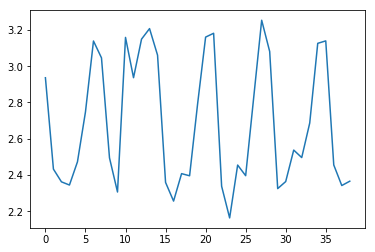

In [28]:
plt.plot(testpreds[129])

In [29]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [30]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.925956   
air_0164b9927d20bcc3_2017-04-23              1.572627   
air_0241aa3964b7f861_2017-04-23              2.489481   
air_0328696196e46f18_2017-04-23              2.211928   
air_034a3d5b40d5b1b1_2017-04-23              3.403070   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.861702  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.819293  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23  11.055013  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   8.133311  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  29.056237

In [31]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [32]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [33]:
submission.to_csv("../submission/3003_conv_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')